# S-N-VAE Model Testing Framework

In [1]:
# Parameters cell for papermill
# This cell will be tagged as "parameters" to allow papermill to inject parameter values
# Default seed value - can be overridden by papermill execution
seed = 0

In [2]:
# Parameters
seed = 10


In [3]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /workspace/Disentanglement-Project-V2


# Hyperparameters

In [4]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed': seed,  # Use parameterized seed value
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_dsprites = {
    'beta': 13,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [5]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 10, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [6]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# dSprites

In [8]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,  # Use parameterized seed value
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [9]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: beta_s_n_vae (rec_dist=bernoulli), kwargs={'beta': 13, 'latent_factor_topologies': ['S1', 'R1', 'R1'], 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001


Training for 192000 iter, 300.00 epochs:   0%|                                             | 0/192000 [00:00<?, ?it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 1/192000 [00:01<87:30:25,  1.64s/it]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 2/192000 [00:01<42:40:17,  1.25it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 41/192000 [00:01<1:23:56, 38.11it/s]

Training for 192000 iter, 300.00 epochs:   0%| | 41/192000 [00:01<1:23:56, 38.11it/s, epoch=0.08/300.00, iter=50/19200

Training for 192000 iter, 300.00 epochs:   0%| | 80/192000 [00:02<40:02, 79.87it/s, epoch=0.08/300.00, iter=50/192000,

Training for 192000 iter, 300.00 epochs:   0%| | 80/192000 [00:02<40:02, 79.87it/s, epoch=0.16/300.00, iter=100/192000

Training for 192000 iter, 300.00 epochs:   0%| | 119/192000 [00:02<25:41, 124.49it/s, epoch=0.16/300.00, iter=100/1920

Training for 192000 iter, 300.00 epochs:   0%| | 119/192000 [00:02<25:41, 124.49it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 159/192000 [00:02<18:40, 171.17it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 159/192000 [00:02<18:40, 171.17it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 200/192000 [00:02<14:44, 216.87it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 241/192000 [00:02<12:24, 257.66it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 241/192000 [00:02<12:24, 257.66it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 281/192000 [00:02<10:59, 290.87it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 281/192000 [00:02<10:59, 290.87it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 321/192000 [00:02<10:02, 318.02it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 321/192000 [00:02<10:02, 318.02it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 361/192000 [00:02<09:26, 338.12it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 361/192000 [00:02<09:26, 338.12it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 401/192000 [00:02<09:00, 354.56it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 441/192000 [00:02<08:42, 366.58it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 441/192000 [00:02<08:42, 366.58it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 481/192000 [00:03<08:33, 372.91it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 481/192000 [00:03<08:33, 372.91it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 521/192000 [00:03<08:33, 372.93it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 521/192000 [00:03<08:33, 372.93it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 560/192000 [00:03<08:28, 376.73it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 560/192000 [00:03<08:28, 376.73it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 600/192000 [00:03<08:20, 382.11it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 641/192000 [00:03<08:30, 374.75it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 641/192000 [00:03<08:30, 374.75it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 682/192000 [00:03<08:19, 382.66it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 682/192000 [00:03<08:19, 382.66it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 722/192000 [00:03<08:13, 387.61it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 722/192000 [00:03<08:13, 387.61it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 763/192000 [00:03<08:07, 391.95it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 763/192000 [00:03<08:07, 391.95it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 803/192000 [00:03<08:09, 390.36it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 843/192000 [00:04<08:11, 389.07it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 843/192000 [00:04<08:11, 389.07it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 883/192000 [00:04<08:12, 387.98it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 883/192000 [00:04<08:12, 387.98it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 922/192000 [00:04<08:13, 387.40it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 922/192000 [00:04<08:13, 387.40it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 962/192000 [00:04<08:09, 390.41it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 962/192000 [00:04<08:09, 390.41it/s, epoch=1.56/300.00, iter=1000/192

Training for 192000 iter, 300.00 epochs:   1%| | 1002/192000 [00:04<08:07, 391.73it/s, epoch=1.56/300.00, iter=1000/19

Training for 192000 iter, 300.00 epochs:   1%| | 1042/192000 [00:04<08:07, 391.65it/s, epoch=1.56/300.00, iter=1000/19

Training for 192000 iter, 300.00 epochs:   1%| | 1042/192000 [00:04<08:07, 391.65it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1082/192000 [00:04<08:11, 388.39it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1082/192000 [00:04<08:11, 388.39it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1122/192000 [00:04<08:10, 389.12it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1122/192000 [00:04<08:10, 389.12it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1162/192000 [00:04<08:08, 391.04it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1162/192000 [00:04<08:08, 391.04it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1202/192000 [00:04<08:08, 390.73it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1242/192000 [00:05<08:07, 391.40it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1242/192000 [00:05<08:07, 391.40it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1282/192000 [00:05<08:24, 377.85it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1282/192000 [00:05<08:24, 377.85it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1320/192000 [00:05<08:39, 367.40it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1320/192000 [00:05<08:39, 367.40it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1357/192000 [00:05<08:43, 364.19it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1396/192000 [00:05<08:33, 371.09it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1396/192000 [00:05<08:33, 371.09it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1434/192000 [00:05<08:38, 367.31it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1434/192000 [00:05<08:38, 367.31it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1474/192000 [00:05<08:28, 374.96it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1474/192000 [00:05<08:28, 374.96it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1512/192000 [00:05<08:26, 376.27it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1512/192000 [00:05<08:26, 376.27it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1550/192000 [00:05<10:27, 303.41it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1586/192000 [00:06<10:02, 316.09it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1586/192000 [00:06<10:02, 316.09it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1624/192000 [00:06<09:34, 331.38it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1624/192000 [00:06<09:34, 331.38it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1659/192000 [00:06<09:26, 335.79it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1697/192000 [00:06<09:08, 346.85it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1697/192000 [00:06<09:08, 346.85it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1736/192000 [00:06<08:51, 358.24it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1736/192000 [00:06<08:51, 358.24it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1773/192000 [00:06<09:01, 351.25it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1773/192000 [00:06<09:01, 351.25it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1812/192000 [00:06<08:46, 361.41it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1812/192000 [00:06<08:46, 361.41it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1852/192000 [00:06<08:31, 371.62it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1892/192000 [00:06<08:20, 379.54it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1892/192000 [00:06<08:20, 379.54it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1931/192000 [00:06<08:45, 361.39it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1931/192000 [00:07<08:45, 361.39it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1971/192000 [00:07<08:32, 370.55it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1971/192000 [00:07<08:32, 370.55it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2011/192000 [00:07<08:22, 378.30it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2011/192000 [00:07<08:22, 378.30it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2052/192000 [00:07<08:14, 384.46it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2093/192000 [00:07<08:07, 389.91it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2093/192000 [00:07<08:07, 389.91it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2133/192000 [00:07<08:11, 386.23it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2133/192000 [00:07<08:11, 386.23it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2172/192000 [00:07<08:17, 381.29it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2172/192000 [00:07<08:17, 381.29it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2213/192000 [00:07<08:09, 388.05it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2213/192000 [00:07<08:09, 388.05it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2254/192000 [00:07<08:03, 392.60it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2295/192000 [00:07<07:57, 396.90it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2295/192000 [00:07<07:57, 396.90it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2336/192000 [00:08<07:54, 399.87it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2336/192000 [00:08<07:54, 399.87it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2377/192000 [00:08<07:53, 400.50it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2377/192000 [00:08<07:53, 400.50it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2418/192000 [00:08<07:55, 398.96it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2418/192000 [00:08<07:55, 398.96it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2458/192000 [00:08<08:19, 379.34it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2499/192000 [00:08<08:09, 387.21it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2499/192000 [00:08<08:09, 387.21it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2539/192000 [00:08<08:04, 390.89it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2539/192000 [00:08<08:04, 390.89it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2579/192000 [00:08<08:21, 378.02it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2579/192000 [00:08<08:21, 378.02it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2617/192000 [00:08<08:34, 368.36it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2617/192000 [00:08<08:34, 368.36it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2658/192000 [00:08<08:19, 379.32it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2699/192000 [00:08<08:08, 387.71it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2699/192000 [00:08<08:08, 387.71it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2738/192000 [00:09<08:10, 385.74it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2738/192000 [00:09<08:10, 385.74it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2777/192000 [00:09<08:28, 372.19it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2777/192000 [00:09<08:28, 372.19it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2815/192000 [00:09<08:25, 373.94it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2815/192000 [00:09<08:25, 373.94it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   1%| | 2853/192000 [00:09<08:32, 369.26it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   2%| | 2894/192000 [00:09<08:17, 379.95it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   2%| | 2894/192000 [00:09<08:17, 379.95it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2933/192000 [00:09<08:27, 372.69it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2933/192000 [00:09<08:27, 372.69it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2971/192000 [00:09<08:28, 371.63it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2971/192000 [00:09<08:28, 371.63it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3012/192000 [00:09<08:15, 381.17it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3012/192000 [00:09<08:15, 381.17it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3052/192000 [00:09<08:11, 384.36it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3092/192000 [00:10<08:06, 388.00it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3092/192000 [00:10<08:06, 388.00it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3131/192000 [00:10<08:15, 381.03it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3131/192000 [00:10<08:15, 381.03it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3172/192000 [00:10<08:05, 388.84it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3172/192000 [00:10<08:05, 388.84it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3211/192000 [00:10<08:47, 358.07it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3248/192000 [00:10<09:49, 320.33it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3248/192000 [00:10<09:49, 320.33it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3282/192000 [00:10<10:16, 305.93it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3282/192000 [00:10<10:16, 305.93it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3319/192000 [00:10<09:48, 320.64it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3319/192000 [00:10<09:48, 320.64it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3361/192000 [00:10<09:06, 345.29it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3398/192000 [00:10<08:56, 351.54it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3398/192000 [00:10<08:56, 351.54it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3434/192000 [00:11<10:07, 310.24it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3434/192000 [00:11<10:07, 310.24it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3467/192000 [00:11<10:18, 305.07it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3467/192000 [00:11<10:18, 305.07it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3507/192000 [00:11<09:30, 330.20it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3548/192000 [00:11<08:58, 349.98it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3548/192000 [00:11<08:58, 349.98it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3589/192000 [00:11<08:34, 366.32it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3589/192000 [00:11<08:34, 366.32it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3630/192000 [00:11<08:18, 377.69it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3630/192000 [00:11<08:18, 377.69it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3670/192000 [00:11<08:10, 384.04it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3670/192000 [00:11<08:10, 384.04it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3709/192000 [00:11<08:50, 354.61it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3746/192000 [00:11<08:46, 357.36it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3746/192000 [00:11<08:46, 357.36it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3783/192000 [00:12<08:46, 357.32it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3783/192000 [00:12<08:46, 357.32it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3824/192000 [00:12<08:27, 370.76it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3824/192000 [00:12<08:27, 370.76it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3862/192000 [00:12<08:49, 355.39it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3898/192000 [00:12<09:33, 328.23it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3898/192000 [00:12<09:33, 328.23it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3932/192000 [00:12<09:57, 314.63it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3932/192000 [00:12<09:57, 314.63it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3972/192000 [00:12<09:18, 336.45it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3972/192000 [00:12<09:18, 336.45it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4008/192000 [00:12<09:10, 341.23it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4049/192000 [00:12<08:44, 358.60it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4049/192000 [00:12<08:44, 358.60it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4089/192000 [00:12<08:28, 369.64it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4089/192000 [00:12<08:28, 369.64it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4127/192000 [00:12<08:33, 366.19it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4127/192000 [00:13<08:33, 366.19it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4168/192000 [00:13<08:19, 376.20it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4168/192000 [00:13<08:19, 376.20it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4208/192000 [00:13<08:14, 379.87it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4247/192000 [00:13<08:26, 370.72it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4247/192000 [00:13<08:26, 370.72it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4285/192000 [00:13<08:30, 367.61it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4285/192000 [00:13<08:30, 367.61it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4323/192000 [00:13<08:26, 370.25it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4323/192000 [00:13<08:26, 370.25it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4363/192000 [00:13<08:16, 378.28it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4363/192000 [00:13<08:16, 378.28it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4403/192000 [00:13<08:07, 384.47it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4442/192000 [00:13<08:15, 378.21it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4442/192000 [00:13<08:15, 378.21it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4481/192000 [00:13<08:26, 370.02it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4481/192000 [00:13<08:26, 370.02it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4519/192000 [00:14<08:26, 369.93it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4519/192000 [00:14<08:26, 369.93it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4560/192000 [00:14<08:12, 380.97it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4560/192000 [00:14<08:12, 380.97it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4600/192000 [00:14<08:07, 384.80it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4639/192000 [00:14<09:07, 341.93it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4639/192000 [00:14<09:07, 341.93it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4679/192000 [00:14<08:45, 356.34it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4679/192000 [00:14<08:45, 356.34it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4718/192000 [00:14<08:32, 365.30it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4718/192000 [00:14<08:32, 365.30it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4757/192000 [00:14<08:23, 372.14it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4796/192000 [00:14<08:21, 373.12it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4796/192000 [00:14<08:21, 373.12it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4834/192000 [00:14<09:03, 344.43it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4834/192000 [00:14<09:03, 344.43it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4875/192000 [00:15<08:38, 360.72it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4875/192000 [00:15<08:38, 360.72it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4912/192000 [00:15<08:39, 360.47it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4912/192000 [00:15<08:39, 360.47it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4951/192000 [00:15<08:27, 368.71it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4991/192000 [00:15<08:15, 377.12it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4991/192000 [00:15<08:15, 377.12it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5032/192000 [00:15<08:05, 385.18it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5032/192000 [00:15<08:05, 385.18it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5072/192000 [00:15<08:00, 389.07it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5072/192000 [00:15<08:00, 389.07it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5112/192000 [00:15<08:00, 389.04it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5112/192000 [00:15<08:00, 389.04it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5152/192000 [00:15<08:15, 377.44it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5191/192000 [00:15<08:10, 380.73it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5191/192000 [00:15<08:10, 380.73it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5230/192000 [00:15<08:09, 381.55it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5230/192000 [00:15<08:09, 381.55it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5270/192000 [00:16<08:04, 385.60it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5270/192000 [00:16<08:04, 385.60it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5310/192000 [00:16<07:59, 389.20it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5310/192000 [00:16<07:59, 389.20it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5350/192000 [00:16<07:58, 390.29it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5391/192000 [00:16<07:52, 394.71it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5391/192000 [00:16<07:52, 394.71it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5431/192000 [00:16<07:57, 390.92it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5431/192000 [00:16<07:57, 390.92it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5471/192000 [00:16<07:54, 393.32it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5471/192000 [00:16<07:54, 393.32it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5511/192000 [00:16<08:11, 379.29it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5511/192000 [00:16<08:11, 379.29it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5551/192000 [00:16<08:07, 382.76it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5590/192000 [00:16<08:10, 379.75it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5590/192000 [00:16<08:10, 379.75it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5629/192000 [00:16<08:22, 370.74it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5629/192000 [00:17<08:22, 370.74it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5669/192000 [00:17<08:11, 378.94it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5669/192000 [00:17<08:11, 378.94it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5710/192000 [00:17<08:03, 385.28it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5710/192000 [00:17<08:03, 385.28it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5751/192000 [00:17<07:57, 390.25it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5791/192000 [00:17<08:25, 368.42it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5791/192000 [00:17<08:25, 368.42it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5831/192000 [00:17<08:14, 376.38it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5831/192000 [00:17<08:14, 376.38it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5872/192000 [00:17<08:03, 384.65it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5872/192000 [00:17<08:03, 384.65it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5911/192000 [00:17<08:16, 374.99it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5911/192000 [00:17<08:16, 374.99it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5951/192000 [00:17<08:09, 380.13it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5991/192000 [00:17<08:03, 384.48it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5991/192000 [00:17<08:03, 384.48it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6030/192000 [00:18<08:03, 384.44it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6030/192000 [00:18<08:03, 384.44it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6070/192000 [00:18<08:00, 386.91it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6070/192000 [00:18<08:00, 386.91it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6109/192000 [00:18<08:40, 357.40it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6146/192000 [00:18<08:39, 357.98it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6146/192000 [00:18<08:39, 357.98it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6185/192000 [00:18<08:29, 364.81it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6185/192000 [00:18<08:29, 364.81it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6222/192000 [00:18<08:41, 355.92it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6222/192000 [00:18<08:41, 355.92it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6258/192000 [00:18<09:56, 311.17it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6296/192000 [00:18<09:28, 326.63it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6296/192000 [00:18<09:28, 326.63it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6331/192000 [00:18<09:20, 331.29it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6331/192000 [00:18<09:20, 331.29it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6371/192000 [00:19<08:52, 348.36it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6371/192000 [00:19<08:52, 348.36it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6407/192000 [00:19<09:19, 331.94it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6447/192000 [00:19<08:52, 348.53it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6447/192000 [00:19<08:52, 348.53it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6486/192000 [00:19<08:37, 358.47it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6486/192000 [00:19<08:37, 358.47it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6524/192000 [00:19<08:30, 363.66it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6524/192000 [00:19<08:30, 363.66it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6561/192000 [00:19<08:31, 362.49it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6599/192000 [00:19<08:27, 365.05it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6599/192000 [00:19<08:27, 365.05it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6639/192000 [00:19<08:17, 372.62it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6639/192000 [00:19<08:17, 372.62it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6677/192000 [00:19<08:26, 366.00it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6677/192000 [00:19<08:26, 366.00it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   3%| | 6714/192000 [00:19<08:37, 358.31it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   3%| | 6714/192000 [00:20<08:37, 358.31it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6750/192000 [00:20<08:38, 356.96it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6790/192000 [00:20<08:23, 367.91it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6790/192000 [00:20<08:23, 367.91it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6829/192000 [00:20<08:17, 372.30it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6829/192000 [00:20<08:17, 372.30it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6867/192000 [00:20<08:17, 372.39it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6867/192000 [00:20<08:17, 372.39it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6907/192000 [00:20<08:07, 379.48it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6945/192000 [00:20<08:08, 378.63it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6945/192000 [00:20<08:08, 378.63it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6983/192000 [00:20<08:14, 374.32it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6983/192000 [00:20<08:14, 374.32it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7021/192000 [00:20<08:41, 354.75it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7021/192000 [00:20<08:41, 354.75it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7057/192000 [00:20<09:02, 341.21it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7096/192000 [00:21<08:42, 353.80it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7096/192000 [00:21<08:42, 353.80it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7132/192000 [00:21<08:56, 344.68it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7132/192000 [00:21<08:56, 344.68it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7171/192000 [00:21<08:39, 355.61it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7171/192000 [00:21<08:39, 355.61it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7212/192000 [00:21<08:19, 369.82it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7212/192000 [00:21<08:19, 369.82it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7253/192000 [00:21<08:07, 379.07it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7293/192000 [00:21<08:00, 384.38it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7293/192000 [00:21<08:00, 384.38it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7332/192000 [00:21<08:04, 381.24it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7332/192000 [00:21<08:04, 381.24it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7371/192000 [00:21<08:02, 382.63it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7371/192000 [00:21<08:02, 382.63it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7410/192000 [00:21<08:07, 378.55it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7449/192000 [00:21<08:04, 380.76it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7449/192000 [00:21<08:04, 380.76it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7488/192000 [00:22<08:04, 380.82it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7488/192000 [00:22<08:04, 380.82it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7527/192000 [00:22<08:06, 379.14it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7527/192000 [00:22<08:06, 379.14it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7565/192000 [00:22<08:06, 379.39it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7565/192000 [00:22<08:06, 379.39it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7605/192000 [00:22<07:58, 385.27it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7645/192000 [00:22<07:54, 388.75it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7645/192000 [00:22<07:54, 388.75it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7684/192000 [00:22<08:17, 370.16it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7684/192000 [00:22<08:17, 370.16it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7722/192000 [00:22<09:25, 326.10it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7722/192000 [00:22<09:25, 326.10it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7762/192000 [00:22<08:54, 344.48it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7762/192000 [00:22<08:54, 344.48it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7802/192000 [00:22<08:32, 359.19it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7843/192000 [00:23<08:16, 370.87it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7843/192000 [00:23<08:16, 370.87it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7883/192000 [00:23<08:05, 378.89it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7883/192000 [00:23<08:05, 378.89it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7922/192000 [00:23<08:03, 380.67it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7922/192000 [00:23<08:03, 380.67it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7962/192000 [00:23<07:56, 386.12it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7962/192000 [00:23<07:56, 386.12it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8002/192000 [00:23<07:51, 389.84it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8042/192000 [00:23<07:50, 391.39it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8042/192000 [00:23<07:50, 391.39it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8082/192000 [00:23<08:08, 376.29it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8082/192000 [00:23<08:08, 376.29it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8123/192000 [00:23<07:58, 384.49it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8123/192000 [00:23<07:58, 384.49it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8162/192000 [00:23<08:04, 379.60it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8162/192000 [00:23<08:04, 379.60it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8203/192000 [00:23<07:54, 387.72it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8242/192000 [00:24<08:16, 369.74it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8242/192000 [00:24<08:16, 369.74it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8282/192000 [00:24<08:07, 376.83it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8282/192000 [00:24<08:07, 376.83it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8321/192000 [00:24<08:13, 372.25it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8321/192000 [00:24<08:13, 372.25it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8359/192000 [00:24<08:47, 347.83it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8399/192000 [00:24<08:28, 361.03it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8399/192000 [00:24<08:28, 361.03it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8437/192000 [00:24<08:21, 365.70it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8437/192000 [00:24<08:21, 365.70it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8477/192000 [00:24<08:10, 374.13it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8477/192000 [00:24<08:10, 374.13it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8517/192000 [00:24<08:01, 380.82it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8517/192000 [00:24<08:01, 380.82it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8557/192000 [00:24<07:57, 384.51it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8597/192000 [00:25<07:52, 388.48it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8597/192000 [00:25<07:52, 388.48it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   4%| | 8637/192000 [00:25<07:50, 390.03it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   4%| | 8637/192000 [00:25<07:50, 390.03it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8677/192000 [00:25<07:48, 391.00it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8677/192000 [00:25<07:48, 391.00it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8717/192000 [00:25<07:51, 389.00it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8717/192000 [00:25<07:51, 389.00it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8757/192000 [00:25<07:48, 390.91it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8798/192000 [00:25<07:44, 394.66it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8798/192000 [00:25<07:44, 394.66it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8838/192000 [00:25<07:56, 384.49it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8838/192000 [00:25<07:56, 384.49it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8879/192000 [00:25<07:49, 389.94it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8879/192000 [00:25<07:49, 389.94it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8920/192000 [00:25<07:45, 393.43it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8920/192000 [00:25<07:45, 393.43it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8961/192000 [00:25<07:58, 382.27it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8961/192000 [00:26<07:58, 382.27it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9001/192000 [00:26<07:55, 384.95it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9040/192000 [00:26<08:01, 380.09it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9040/192000 [00:26<08:01, 380.09it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9079/192000 [00:26<08:03, 378.40it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9079/192000 [00:26<08:03, 378.40it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9120/192000 [00:26<07:53, 386.50it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9120/192000 [00:26<07:53, 386.50it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9160/192000 [00:26<07:51, 387.80it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9160/192000 [00:26<07:51, 387.80it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9200/192000 [00:26<07:48, 390.21it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9241/192000 [00:26<07:44, 393.84it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9241/192000 [00:26<07:44, 393.84it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9281/192000 [00:26<07:45, 392.70it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9281/192000 [00:26<07:45, 392.70it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9321/192000 [00:26<07:43, 394.22it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9321/192000 [00:26<07:43, 394.22it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9361/192000 [00:26<07:41, 395.59it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9361/192000 [00:27<07:41, 395.59it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9402/192000 [00:27<07:39, 397.38it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9443/192000 [00:27<07:35, 400.51it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9443/192000 [00:27<07:35, 400.51it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9484/192000 [00:27<07:34, 401.27it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9484/192000 [00:27<07:34, 401.27it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9525/192000 [00:27<07:36, 399.58it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9525/192000 [00:27<07:36, 399.58it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9565/192000 [00:27<07:37, 398.37it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9565/192000 [00:27<07:37, 398.37it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9605/192000 [00:27<08:03, 376.86it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9643/192000 [00:27<08:08, 373.46it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9643/192000 [00:27<08:08, 373.46it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9684/192000 [00:27<07:57, 381.77it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9684/192000 [00:27<07:57, 381.77it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9724/192000 [00:27<07:52, 385.95it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9724/192000 [00:27<07:52, 385.95it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9763/192000 [00:28<07:54, 384.24it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9763/192000 [00:28<07:54, 384.24it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9802/192000 [00:28<07:54, 384.07it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9841/192000 [00:28<07:56, 382.37it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9841/192000 [00:28<07:56, 382.37it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9881/192000 [00:28<07:50, 386.70it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9881/192000 [00:28<07:50, 386.70it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9922/192000 [00:28<07:44, 391.61it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9922/192000 [00:28<07:44, 391.61it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9962/192000 [00:28<07:47, 389.48it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9962/192000 [00:28<07:47, 389.48it/s, epoch=15.62/300.00, iter=10000/

Training for 192000 iter, 300.00 epochs:   5%| | 10001/192000 [00:28<08:34, 353.61it/s, epoch=15.62/300.00, iter=10000

Training for 192000 iter, 300.00 epochs:   5%| | 10042/192000 [00:28<08:16, 366.79it/s, epoch=15.62/300.00, iter=10000

Training for 192000 iter, 300.00 epochs:   5%| | 10042/192000 [00:28<08:16, 366.79it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10082/192000 [00:28<08:03, 375.88it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10082/192000 [00:28<08:03, 375.88it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10122/192000 [00:28<07:55, 382.58it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10122/192000 [00:29<07:55, 382.58it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10163/192000 [00:29<07:47, 388.63it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10163/192000 [00:29<07:47, 388.63it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10203/192000 [00:29<08:11, 370.11it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10241/192000 [00:29<08:29, 357.08it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10241/192000 [00:29<08:29, 357.08it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10281/192000 [00:29<08:14, 367.47it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10281/192000 [00:29<08:14, 367.47it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10322/192000 [00:29<08:00, 378.43it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10322/192000 [00:29<08:00, 378.43it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10361/192000 [00:29<07:57, 380.40it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10361/192000 [00:29<07:57, 380.40it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10401/192000 [00:29<07:50, 386.09it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10442/192000 [00:29<07:42, 392.33it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10442/192000 [00:29<07:42, 392.33it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10483/192000 [00:29<07:38, 396.28it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10483/192000 [00:29<07:38, 396.28it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10523/192000 [00:30<07:38, 396.16it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10523/192000 [00:30<07:38, 396.16it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10563/192000 [00:30<08:06, 372.67it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10563/192000 [00:30<08:06, 372.67it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10601/192000 [00:30<08:32, 353.63it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10642/192000 [00:30<08:13, 367.73it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10642/192000 [00:30<08:13, 367.73it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10680/192000 [00:30<08:12, 367.79it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10680/192000 [00:30<08:12, 367.79it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10718/192000 [00:30<08:13, 367.00it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10718/192000 [00:30<08:13, 367.00it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10758/192000 [00:30<08:02, 375.54it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10798/192000 [00:30<07:53, 382.49it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10798/192000 [00:30<07:53, 382.49it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10838/192000 [00:30<07:47, 387.12it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10838/192000 [00:30<07:47, 387.12it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10879/192000 [00:30<07:42, 391.84it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10879/192000 [00:31<07:42, 391.84it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10919/192000 [00:31<08:23, 359.82it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10919/192000 [00:31<08:23, 359.82it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10960/192000 [00:31<08:07, 371.54it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10960/192000 [00:31<08:07, 371.54it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11000/192000 [00:31<07:57, 379.36it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11041/192000 [00:31<07:47, 387.33it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11041/192000 [00:31<07:47, 387.33it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11081/192000 [00:31<07:51, 383.86it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11081/192000 [00:31<07:51, 383.86it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11120/192000 [00:31<08:01, 375.79it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11120/192000 [00:31<08:01, 375.79it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11160/192000 [00:31<07:52, 382.49it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11160/192000 [00:31<07:52, 382.49it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11200/192000 [00:31<07:46, 387.41it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11241/192000 [00:31<07:38, 394.01it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11241/192000 [00:31<07:38, 394.01it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11281/192000 [00:32<07:45, 387.90it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11281/192000 [00:32<07:45, 387.90it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11320/192000 [00:32<07:52, 382.18it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11320/192000 [00:32<07:52, 382.18it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11359/192000 [00:32<07:50, 384.30it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11399/192000 [00:32<07:48, 385.14it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11399/192000 [00:32<07:48, 385.14it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11438/192000 [00:32<07:50, 383.36it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11438/192000 [00:32<07:50, 383.36it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11478/192000 [00:32<07:45, 388.21it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11478/192000 [00:32<07:45, 388.21it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11517/192000 [00:32<07:49, 384.67it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11517/192000 [00:32<07:49, 384.67it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11556/192000 [00:32<08:13, 365.31it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11594/192000 [00:32<08:11, 367.21it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11594/192000 [00:32<08:11, 367.21it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11634/192000 [00:32<08:01, 374.43it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11634/192000 [00:33<08:01, 374.43it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11672/192000 [00:33<08:28, 354.56it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11672/192000 [00:33<08:28, 354.56it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11713/192000 [00:33<08:10, 367.79it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11713/192000 [00:33<08:10, 367.79it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11754/192000 [00:33<07:56, 378.33it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11793/192000 [00:33<08:00, 375.42it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11793/192000 [00:33<08:00, 375.42it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11831/192000 [00:33<07:58, 376.59it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11831/192000 [00:33<07:58, 376.59it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11871/192000 [00:33<07:49, 383.38it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11871/192000 [00:33<07:49, 383.38it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11911/192000 [00:33<07:44, 388.07it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11911/192000 [00:33<07:44, 388.07it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11950/192000 [00:33<07:44, 387.81it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11989/192000 [00:33<08:01, 374.09it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11989/192000 [00:33<08:01, 374.09it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12028/192000 [00:34<07:55, 378.20it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12028/192000 [00:34<07:55, 378.20it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12066/192000 [00:34<07:58, 375.72it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12066/192000 [00:34<07:58, 375.72it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12107/192000 [00:34<07:50, 382.71it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12146/192000 [00:34<07:50, 382.02it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12146/192000 [00:34<07:50, 382.02it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12185/192000 [00:34<08:00, 374.54it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12185/192000 [00:34<08:00, 374.54it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12225/192000 [00:34<07:51, 381.06it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12225/192000 [00:34<07:51, 381.06it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12264/192000 [00:34<07:54, 378.99it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12264/192000 [00:34<07:54, 378.99it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12304/192000 [00:34<07:48, 383.22it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12344/192000 [00:34<07:43, 387.19it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12344/192000 [00:34<07:43, 387.19it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12383/192000 [00:35<09:09, 327.00it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12383/192000 [00:35<09:09, 327.00it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12422/192000 [00:35<08:45, 341.56it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12422/192000 [00:35<08:45, 341.56it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   6%| | 12459/192000 [00:35<08:34, 348.76it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   6%| | 12459/192000 [00:35<08:34, 348.76it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12500/192000 [00:35<08:13, 363.63it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12541/192000 [00:35<07:59, 374.23it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12541/192000 [00:35<07:59, 374.23it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12581/192000 [00:35<07:52, 379.82it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12581/192000 [00:35<07:52, 379.82it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12621/192000 [00:35<07:46, 384.69it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12621/192000 [00:35<07:46, 384.69it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12660/192000 [00:35<07:53, 378.44it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12660/192000 [00:35<07:53, 378.44it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12700/192000 [00:35<07:46, 384.59it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12741/192000 [00:35<07:39, 389.78it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12741/192000 [00:35<07:39, 389.78it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12781/192000 [00:36<07:37, 391.97it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12781/192000 [00:36<07:37, 391.97it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12821/192000 [00:36<08:25, 354.40it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12821/192000 [00:36<08:25, 354.40it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12858/192000 [00:36<08:42, 342.93it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12899/192000 [00:36<08:16, 360.87it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12899/192000 [00:36<08:16, 360.87it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12939/192000 [00:36<08:03, 370.17it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12939/192000 [00:36<08:03, 370.17it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12980/192000 [00:36<07:51, 379.70it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12980/192000 [00:36<07:51, 379.70it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13019/192000 [00:36<07:52, 379.19it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13019/192000 [00:36<07:52, 379.19it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13058/192000 [00:36<08:03, 369.88it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13096/192000 [00:36<08:05, 368.49it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13096/192000 [00:36<08:05, 368.49it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13136/192000 [00:37<07:56, 375.73it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13136/192000 [00:37<07:56, 375.73it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13176/192000 [00:37<07:48, 381.71it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13176/192000 [00:37<07:48, 381.71it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13216/192000 [00:37<07:42, 386.29it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13216/192000 [00:37<07:42, 386.29it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13256/192000 [00:37<07:39, 388.81it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13295/192000 [00:37<07:56, 374.74it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13295/192000 [00:37<07:56, 374.74it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13335/192000 [00:37<07:48, 381.56it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13335/192000 [00:37<07:48, 381.56it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13375/192000 [00:37<07:42, 385.94it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13375/192000 [00:37<07:42, 385.94it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13414/192000 [00:37<07:46, 382.48it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13414/192000 [00:37<07:46, 382.48it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13453/192000 [00:37<08:00, 371.89it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13494/192000 [00:37<07:48, 381.23it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13494/192000 [00:37<07:48, 381.23it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13533/192000 [00:38<07:45, 383.64it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13533/192000 [00:38<07:45, 383.64it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13572/192000 [00:38<07:49, 380.18it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13572/192000 [00:38<07:49, 380.18it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13611/192000 [00:38<07:57, 373.32it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13649/192000 [00:38<10:33, 281.41it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13649/192000 [00:38<10:33, 281.41it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13689/192000 [00:38<09:38, 308.45it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13689/192000 [00:38<09:38, 308.45it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13730/192000 [00:38<08:56, 332.59it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13730/192000 [00:38<08:56, 332.59it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13771/192000 [00:38<08:27, 351.44it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13771/192000 [00:38<08:27, 351.44it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13812/192000 [00:38<08:07, 365.34it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13812/192000 [00:38<08:07, 365.34it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13853/192000 [00:38<07:53, 376.41it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13894/192000 [00:39<07:42, 385.34it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13894/192000 [00:39<07:42, 385.34it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13934/192000 [00:39<07:44, 383.74it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13934/192000 [00:39<07:44, 383.74it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13973/192000 [00:39<08:40, 342.21it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13973/192000 [00:39<08:40, 342.21it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14010/192000 [00:39<08:30, 348.51it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14048/192000 [00:39<08:18, 357.13it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14048/192000 [00:39<08:18, 357.13it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14085/192000 [00:39<08:46, 337.60it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14085/192000 [00:39<08:46, 337.60it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14123/192000 [00:39<08:33, 346.20it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14123/192000 [00:39<08:33, 346.20it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14160/192000 [00:39<08:24, 352.20it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14160/192000 [00:39<08:24, 352.20it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14201/192000 [00:39<08:05, 366.51it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14241/192000 [00:40<07:52, 376.11it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14241/192000 [00:40<07:52, 376.11it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14281/192000 [00:40<07:46, 381.24it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14281/192000 [00:40<07:46, 381.24it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14321/192000 [00:40<07:40, 385.71it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14321/192000 [00:40<07:40, 385.71it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14360/192000 [00:40<08:03, 367.68it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14360/192000 [00:40<08:03, 367.68it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14400/192000 [00:40<07:51, 376.35it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14440/192000 [00:40<07:46, 380.61it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14440/192000 [00:40<07:46, 380.61it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14479/192000 [00:40<08:05, 365.55it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14479/192000 [00:40<08:05, 365.55it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14516/192000 [00:40<08:15, 358.09it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14516/192000 [00:40<08:15, 358.09it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14554/192000 [00:40<08:07, 364.01it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14594/192000 [00:41<07:54, 373.68it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14594/192000 [00:41<07:54, 373.68it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14633/192000 [00:41<07:51, 376.31it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14633/192000 [00:41<07:51, 376.31it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14673/192000 [00:41<07:42, 383.03it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14673/192000 [00:41<07:42, 383.03it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14713/192000 [00:41<07:39, 385.65it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14713/192000 [00:41<07:39, 385.65it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14752/192000 [00:41<07:53, 374.33it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14791/192000 [00:41<07:49, 377.83it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14791/192000 [00:41<07:49, 377.83it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14830/192000 [00:41<07:47, 378.91it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14830/192000 [00:41<07:47, 378.91it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14870/192000 [00:41<07:41, 383.84it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14870/192000 [00:41<07:41, 383.84it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14909/192000 [00:41<07:39, 385.40it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14909/192000 [00:41<07:39, 385.40it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14950/192000 [00:41<07:31, 392.21it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14991/192000 [00:42<07:27, 395.62it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14991/192000 [00:42<07:27, 395.62it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15032/192000 [00:42<07:23, 398.83it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15032/192000 [00:42<07:23, 398.83it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15072/192000 [00:42<07:32, 391.31it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15072/192000 [00:42<07:32, 391.31it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15112/192000 [00:42<07:35, 388.22it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15112/192000 [00:42<07:35, 388.22it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15151/192000 [00:42<07:49, 376.73it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15191/192000 [00:42<07:41, 383.40it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15191/192000 [00:42<07:41, 383.40it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15230/192000 [00:42<07:43, 381.73it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15230/192000 [00:42<07:43, 381.73it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15270/192000 [00:42<07:39, 384.64it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15270/192000 [00:42<07:39, 384.64it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15311/192000 [00:42<07:33, 389.34it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15311/192000 [00:42<07:33, 389.34it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15351/192000 [00:42<07:32, 390.19it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15391/192000 [00:43<07:48, 377.19it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15391/192000 [00:43<07:48, 377.19it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15431/192000 [00:43<07:42, 381.76it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15431/192000 [00:43<07:42, 381.76it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15471/192000 [00:43<07:38, 384.68it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15471/192000 [00:43<07:38, 384.68it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15510/192000 [00:43<07:53, 372.41it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15510/192000 [00:43<07:53, 372.41it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15551/192000 [00:43<07:44, 380.17it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15591/192000 [00:43<07:37, 385.77it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15591/192000 [00:43<07:37, 385.77it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15631/192000 [00:43<07:35, 387.23it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15631/192000 [00:43<07:35, 387.23it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15670/192000 [00:43<07:37, 385.75it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15670/192000 [00:43<07:37, 385.75it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15711/192000 [00:43<07:31, 390.35it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15711/192000 [00:44<07:31, 390.35it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15751/192000 [00:44<08:05, 363.32it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15788/192000 [00:44<08:37, 340.83it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15788/192000 [00:44<08:37, 340.83it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15827/192000 [00:44<08:18, 353.08it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15827/192000 [00:44<08:18, 353.08it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15863/192000 [00:44<08:38, 339.45it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15863/192000 [00:44<08:38, 339.45it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15903/192000 [00:44<08:16, 354.39it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15942/192000 [00:44<08:04, 363.16it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15942/192000 [00:44<08:04, 363.16it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15982/192000 [00:44<07:53, 371.39it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15982/192000 [00:44<07:53, 371.39it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16020/192000 [00:44<08:24, 348.58it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16020/192000 [00:44<08:24, 348.58it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16057/192000 [00:44<08:16, 354.35it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16093/192000 [00:45<08:20, 351.59it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16093/192000 [00:45<08:20, 351.59it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16129/192000 [00:45<08:21, 350.63it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16129/192000 [00:45<08:21, 350.63it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16169/192000 [00:45<08:03, 363.34it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16169/192000 [00:45<08:03, 363.34it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16210/192000 [00:45<07:48, 375.52it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16210/192000 [00:45<07:48, 375.52it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16251/192000 [00:45<07:37, 384.23it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16291/192000 [00:45<07:32, 387.89it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16291/192000 [00:45<07:32, 387.89it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   9%| | 16330/192000 [00:45<07:34, 386.43it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   9%| | 16330/192000 [00:45<07:34, 386.43it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16369/192000 [00:45<07:34, 386.19it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16369/192000 [00:45<07:34, 386.19it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16408/192000 [00:45<07:44, 378.26it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16449/192000 [00:45<07:34, 386.23it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16449/192000 [00:45<07:34, 386.23it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16490/192000 [00:46<07:27, 392.26it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16490/192000 [00:46<07:27, 392.26it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16530/192000 [00:46<07:25, 393.72it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16530/192000 [00:46<07:25, 393.72it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16570/192000 [00:46<07:27, 391.62it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16570/192000 [00:46<07:27, 391.62it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16610/192000 [00:46<08:21, 350.07it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16646/192000 [00:46<08:34, 340.69it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16646/192000 [00:46<08:34, 340.69it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16682/192000 [00:46<08:28, 344.62it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16682/192000 [00:46<08:28, 344.62it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16717/192000 [00:46<09:51, 296.47it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16749/192000 [00:46<09:58, 292.71it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16749/192000 [00:46<09:58, 292.71it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16789/192000 [00:46<09:08, 319.62it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16789/192000 [00:46<09:08, 319.62it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16822/192000 [00:47<09:06, 320.69it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16822/192000 [00:47<09:06, 320.69it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16855/192000 [00:47<09:16, 314.63it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16891/192000 [00:47<09:00, 324.22it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16891/192000 [00:47<09:00, 324.22it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16930/192000 [00:47<08:33, 340.77it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16930/192000 [00:47<08:33, 340.77it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16966/192000 [00:47<08:26, 345.85it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16966/192000 [00:47<08:26, 345.85it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17005/192000 [00:47<08:08, 358.08it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17042/192000 [00:47<08:26, 345.26it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17042/192000 [00:47<08:26, 345.26it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17081/192000 [00:47<08:09, 357.03it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17081/192000 [00:47<08:09, 357.03it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17120/192000 [00:47<07:58, 365.58it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17120/192000 [00:47<07:58, 365.58it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17161/192000 [00:48<07:43, 377.01it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17161/192000 [00:48<07:43, 377.01it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17202/192000 [00:48<07:33, 385.32it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17241/192000 [00:48<07:38, 380.88it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17241/192000 [00:48<07:38, 380.88it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17280/192000 [00:48<07:39, 380.50it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17280/192000 [00:48<07:39, 380.50it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17319/192000 [00:48<08:21, 348.59it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17319/192000 [00:48<08:21, 348.59it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17358/192000 [00:48<08:08, 357.68it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17398/192000 [00:48<07:54, 367.99it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17398/192000 [00:48<07:54, 367.99it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17436/192000 [00:48<07:54, 368.06it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17436/192000 [00:48<07:54, 368.06it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17475/192000 [00:48<07:47, 373.16it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17475/192000 [00:48<07:47, 373.16it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17513/192000 [00:48<07:54, 368.05it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17513/192000 [00:49<07:54, 368.05it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17550/192000 [00:49<07:53, 368.60it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17587/192000 [00:49<08:05, 359.12it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17587/192000 [00:49<08:05, 359.12it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17624/192000 [00:49<08:45, 332.01it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17624/192000 [00:49<08:45, 332.01it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17658/192000 [00:49<08:44, 332.70it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17695/192000 [00:49<08:30, 341.17it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17695/192000 [00:49<08:30, 341.17it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17731/192000 [00:49<08:24, 345.74it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17731/192000 [00:49<08:24, 345.74it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17766/192000 [00:49<08:23, 346.29it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17766/192000 [00:49<08:23, 346.29it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17805/192000 [00:49<08:05, 358.88it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17842/192000 [00:49<08:05, 358.84it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17842/192000 [00:49<08:05, 358.84it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17882/192000 [00:50<07:50, 369.92it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17882/192000 [00:50<07:50, 369.92it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17920/192000 [00:50<07:50, 369.77it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17920/192000 [00:50<07:50, 369.77it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17958/192000 [00:50<08:24, 345.15it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17995/192000 [00:50<08:16, 350.56it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17995/192000 [00:50<08:16, 350.56it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18031/192000 [00:50<08:21, 347.10it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18031/192000 [00:50<08:21, 347.10it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18066/192000 [00:50<08:35, 337.62it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18066/192000 [00:50<08:35, 337.62it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18106/192000 [00:50<08:11, 353.60it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18145/192000 [00:50<07:58, 363.19it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18145/192000 [00:50<07:58, 363.19it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18185/192000 [00:50<07:47, 371.69it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18185/192000 [00:50<07:47, 371.69it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18225/192000 [00:50<07:38, 379.13it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18225/192000 [00:51<07:38, 379.13it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18265/192000 [00:51<07:32, 384.32it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18265/192000 [00:51<07:32, 384.32it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18304/192000 [00:51<07:30, 385.40it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18344/192000 [00:51<07:27, 387.94it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18344/192000 [00:51<07:27, 387.94it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18383/192000 [00:51<07:27, 388.07it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18383/192000 [00:51<07:27, 388.07it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18423/192000 [00:51<07:25, 389.42it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18423/192000 [00:51<07:25, 389.42it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18463/192000 [00:51<07:23, 390.92it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18463/192000 [00:51<07:23, 390.92it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18503/192000 [00:51<07:21, 392.69it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18544/192000 [00:51<07:19, 395.09it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18544/192000 [00:51<07:19, 395.09it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18584/192000 [00:51<07:52, 367.20it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18584/192000 [00:51<07:52, 367.20it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18622/192000 [00:52<07:56, 363.93it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18622/192000 [00:52<07:56, 363.93it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18663/192000 [00:52<07:42, 374.88it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18663/192000 [00:52<07:42, 374.88it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18701/192000 [00:52<07:49, 369.03it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18739/192000 [00:52<07:50, 367.87it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18739/192000 [00:52<07:50, 367.87it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18776/192000 [00:52<08:12, 352.04it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18776/192000 [00:52<08:12, 352.04it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18816/192000 [00:52<07:55, 363.92it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18816/192000 [00:52<07:55, 363.92it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18854/192000 [00:52<07:50, 367.70it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18895/192000 [00:52<07:37, 378.46it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18895/192000 [00:52<07:37, 378.46it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18934/192000 [00:52<07:33, 381.63it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18934/192000 [00:52<07:33, 381.63it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18974/192000 [00:52<07:28, 385.62it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18974/192000 [00:53<07:28, 385.62it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19014/192000 [00:53<07:24, 388.86it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19014/192000 [00:53<07:24, 388.86it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19054/192000 [00:53<07:23, 390.27it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19094/192000 [00:53<07:21, 391.90it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19094/192000 [00:53<07:21, 391.90it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19134/192000 [00:53<07:19, 393.70it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19134/192000 [00:53<07:19, 393.70it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19174/192000 [00:53<07:17, 395.19it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19174/192000 [00:53<07:17, 395.19it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19214/192000 [00:53<07:37, 377.51it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19214/192000 [00:53<07:37, 377.51it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19252/192000 [00:53<07:40, 375.45it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19293/192000 [00:53<07:30, 383.00it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19293/192000 [00:53<07:30, 383.00it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19334/192000 [00:53<07:24, 388.79it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19334/192000 [00:53<07:24, 388.79it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19373/192000 [00:53<07:29, 383.79it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19373/192000 [00:54<07:29, 383.79it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19412/192000 [00:54<07:30, 383.07it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19412/192000 [00:54<07:30, 383.07it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19452/192000 [00:54<07:26, 386.77it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19493/192000 [00:54<07:19, 392.73it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19493/192000 [00:54<07:19, 392.73it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19534/192000 [00:54<07:14, 397.10it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19534/192000 [00:54<07:14, 397.10it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19575/192000 [00:54<07:11, 399.39it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19575/192000 [00:54<07:11, 399.39it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19615/192000 [00:54<07:21, 390.83it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19615/192000 [00:54<07:21, 390.83it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19655/192000 [00:54<07:27, 385.10it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19694/192000 [00:54<07:27, 385.15it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19694/192000 [00:54<07:27, 385.15it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19735/192000 [00:54<07:21, 390.14it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19735/192000 [00:54<07:21, 390.14it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19775/192000 [00:55<07:22, 388.92it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19775/192000 [00:55<07:22, 388.92it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19814/192000 [00:55<07:24, 387.00it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19814/192000 [00:55<07:24, 387.00it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19853/192000 [00:55<07:55, 362.16it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19890/192000 [00:55<08:06, 353.82it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19890/192000 [00:55<08:06, 353.82it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19929/192000 [00:55<07:54, 362.39it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19929/192000 [00:55<07:54, 362.39it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19970/192000 [00:55<07:40, 373.39it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19970/192000 [00:55<07:40, 373.39it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20008/192000 [00:55<07:46, 368.52it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20045/192000 [00:55<07:52, 363.88it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20045/192000 [00:55<07:52, 363.88it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20084/192000 [00:55<07:43, 371.27it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20084/192000 [00:55<07:43, 371.27it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20122/192000 [00:55<08:12, 349.11it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20122/192000 [00:56<08:12, 349.11it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20162/192000 [00:56<07:55, 361.09it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20162/192000 [00:56<07:55, 361.09it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20201/192000 [00:56<07:45, 369.08it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20241/192000 [00:56<07:34, 377.71it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20241/192000 [00:56<07:34, 377.71it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20279/192000 [00:56<08:00, 357.61it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20279/192000 [00:56<08:00, 357.61it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20316/192000 [00:56<08:26, 339.06it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20316/192000 [00:56<08:26, 339.06it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20351/192000 [00:56<08:44, 327.55it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20391/192000 [00:56<08:17, 345.28it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20391/192000 [00:56<08:17, 345.28it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20431/192000 [00:56<07:57, 359.64it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20431/192000 [00:56<07:57, 359.64it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20471/192000 [00:56<07:42, 371.11it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20471/192000 [00:57<07:42, 371.11it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20509/192000 [00:57<07:46, 367.85it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20548/192000 [00:57<07:38, 374.12it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20548/192000 [00:57<07:38, 374.12it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20588/192000 [00:57<07:31, 379.78it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20588/192000 [00:57<07:31, 379.78it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20628/192000 [00:57<07:24, 385.51it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20628/192000 [00:57<07:24, 385.51it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20668/192000 [00:57<07:20, 389.16it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20668/192000 [00:57<07:20, 389.16it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20708/192000 [00:57<07:18, 390.92it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20748/192000 [00:57<07:15, 393.50it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20748/192000 [00:57<07:15, 393.50it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20788/192000 [00:57<07:13, 395.40it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20788/192000 [00:57<07:13, 395.40it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20828/192000 [00:57<07:11, 396.55it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20828/192000 [00:57<07:11, 396.55it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20868/192000 [00:57<07:10, 397.44it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20868/192000 [00:58<07:10, 397.44it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20908/192000 [00:58<07:10, 397.88it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20949/192000 [00:58<07:09, 398.56it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20949/192000 [00:58<07:09, 398.56it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20989/192000 [00:58<07:08, 398.85it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20989/192000 [00:58<07:08, 398.85it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21029/192000 [00:58<07:22, 386.39it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21029/192000 [00:58<07:22, 386.39it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21069/192000 [00:58<07:19, 388.84it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21069/192000 [00:58<07:19, 388.84it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21109/192000 [00:58<07:16, 391.64it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21149/192000 [00:58<07:29, 380.10it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21149/192000 [00:58<07:29, 380.10it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21188/192000 [00:58<07:30, 378.90it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21188/192000 [00:58<07:30, 378.90it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21227/192000 [00:58<07:31, 377.99it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21227/192000 [00:58<07:31, 377.99it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21265/192000 [00:59<07:41, 370.35it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21265/192000 [00:59<07:41, 370.35it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21303/192000 [00:59<07:55, 359.02it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21339/192000 [00:59<08:32, 332.98it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21339/192000 [00:59<08:32, 332.98it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21379/192000 [00:59<08:07, 349.69it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21379/192000 [00:59<08:07, 349.69it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21419/192000 [00:59<07:49, 363.22it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21419/192000 [00:59<07:49, 363.22it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21458/192000 [00:59<07:44, 367.43it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21496/192000 [00:59<07:58, 356.13it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21496/192000 [00:59<07:58, 356.13it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21532/192000 [00:59<08:29, 334.40it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21532/192000 [00:59<08:29, 334.40it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21572/192000 [00:59<08:05, 350.90it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21572/192000 [00:59<08:05, 350.90it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21612/192000 [00:59<07:48, 363.49it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21612/192000 [01:00<07:48, 363.49it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21652/192000 [01:00<07:38, 371.30it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21690/192000 [01:00<07:58, 356.29it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21690/192000 [01:00<07:58, 356.29it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21730/192000 [01:00<07:44, 366.25it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21730/192000 [01:00<07:44, 366.25it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21767/192000 [01:00<07:53, 359.57it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21767/192000 [01:00<07:53, 359.57it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21808/192000 [01:00<07:38, 371.47it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21847/192000 [01:00<07:35, 373.86it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21847/192000 [01:00<07:35, 373.86it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21886/192000 [01:00<07:30, 378.02it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21886/192000 [01:00<07:30, 378.02it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21927/192000 [01:00<07:20, 386.11it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21927/192000 [01:00<07:20, 386.11it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21968/192000 [01:00<07:14, 391.62it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21968/192000 [01:01<07:14, 391.62it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22008/192000 [01:01<07:13, 392.46it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22048/192000 [01:01<07:10, 394.45it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22048/192000 [01:01<07:10, 394.45it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  12%| | 22088/192000 [01:01<07:10, 394.99it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  12%| | 22088/192000 [01:01<07:10, 394.99it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22128/192000 [01:01<07:09, 395.57it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22128/192000 [01:01<07:09, 395.57it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22168/192000 [01:01<07:08, 396.28it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22168/192000 [01:01<07:08, 396.28it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22208/192000 [01:01<07:09, 395.71it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22248/192000 [01:01<07:07, 396.86it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22248/192000 [01:01<07:07, 396.86it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22289/192000 [01:01<07:05, 399.13it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22289/192000 [01:01<07:05, 399.13it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22330/192000 [01:01<07:04, 399.52it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22330/192000 [01:01<07:04, 399.52it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22371/192000 [01:01<07:04, 399.83it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22371/192000 [01:02<07:04, 399.83it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22411/192000 [01:02<07:14, 390.24it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22411/192000 [01:02<07:14, 390.24it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22451/192000 [01:02<07:18, 386.81it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22491/192000 [01:02<07:15, 389.64it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22491/192000 [01:02<07:15, 389.64it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22530/192000 [01:02<07:16, 388.01it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22530/192000 [01:02<07:16, 388.01it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22570/192000 [01:02<07:14, 389.68it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22570/192000 [01:02<07:14, 389.68it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22610/192000 [01:02<07:11, 392.45it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22610/192000 [01:02<07:11, 392.45it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22651/192000 [01:02<07:08, 395.50it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22692/192000 [01:02<07:06, 396.76it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22692/192000 [01:02<07:06, 396.76it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22732/192000 [01:02<07:45, 363.57it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22732/192000 [01:02<07:45, 363.57it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22772/192000 [01:02<07:34, 372.42it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22772/192000 [01:03<07:34, 372.42it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22810/192000 [01:03<07:37, 370.09it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22810/192000 [01:03<07:37, 370.09it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22850/192000 [01:03<07:28, 377.29it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22890/192000 [01:03<07:20, 383.49it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22890/192000 [01:03<07:20, 383.49it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22929/192000 [01:03<07:24, 380.01it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22929/192000 [01:03<07:24, 380.01it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22970/192000 [01:03<07:16, 387.31it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22970/192000 [01:03<07:16, 387.31it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23009/192000 [01:03<07:16, 387.07it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23048/192000 [01:03<07:29, 375.96it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23048/192000 [01:03<07:29, 375.96it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23086/192000 [01:03<07:28, 376.94it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23086/192000 [01:03<07:28, 376.94it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23124/192000 [01:03<07:36, 370.19it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23124/192000 [01:04<07:36, 370.19it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23162/192000 [01:04<07:45, 362.79it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23199/192000 [01:04<07:43, 363.90it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23199/192000 [01:04<07:43, 363.90it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23236/192000 [01:04<09:45, 288.45it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23236/192000 [01:04<09:45, 288.45it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23268/192000 [01:04<09:38, 291.72it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23268/192000 [01:04<09:38, 291.72it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23303/192000 [01:04<09:14, 304.38it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23340/192000 [01:04<08:44, 321.74it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23340/192000 [01:04<08:44, 321.74it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23378/192000 [01:04<08:19, 337.30it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23378/192000 [01:04<08:19, 337.30it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23413/192000 [01:04<08:21, 336.38it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23413/192000 [01:04<08:21, 336.38it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23452/192000 [01:04<08:01, 350.26it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23488/192000 [01:05<08:04, 347.54it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23488/192000 [01:05<08:04, 347.54it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23527/192000 [01:05<07:48, 359.69it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23527/192000 [01:05<07:48, 359.69it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23566/192000 [01:05<07:37, 368.51it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23566/192000 [01:05<07:37, 368.51it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23606/192000 [01:05<07:26, 377.25it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23647/192000 [01:05<07:17, 384.57it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23647/192000 [01:05<07:17, 384.57it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23686/192000 [01:05<07:34, 370.12it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23686/192000 [01:05<07:34, 370.12it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23726/192000 [01:05<07:24, 378.55it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23726/192000 [01:05<07:24, 378.55it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23767/192000 [01:05<07:15, 386.72it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23767/192000 [01:05<07:15, 386.72it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23806/192000 [01:05<07:28, 374.73it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23845/192000 [01:05<07:25, 377.75it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23845/192000 [01:05<07:25, 377.75it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23885/192000 [01:06<07:19, 382.72it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23885/192000 [01:06<07:19, 382.72it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23924/192000 [01:06<07:17, 384.06it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23924/192000 [01:06<07:17, 384.06it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23963/192000 [01:06<07:15, 385.48it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23963/192000 [01:06<07:15, 385.48it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24002/192000 [01:06<07:17, 383.68it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24043/192000 [01:06<07:11, 388.93it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24043/192000 [01:06<07:11, 388.93it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24084/192000 [01:06<07:08, 392.29it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24084/192000 [01:06<07:08, 392.29it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24124/192000 [01:06<07:06, 393.64it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24124/192000 [01:06<07:06, 393.64it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24164/192000 [01:06<07:04, 395.04it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24164/192000 [01:06<07:04, 395.04it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24204/192000 [01:06<07:03, 396.30it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24244/192000 [01:06<07:03, 396.53it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24244/192000 [01:07<07:03, 396.53it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24285/192000 [01:07<07:00, 398.43it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24285/192000 [01:07<07:00, 398.43it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24325/192000 [01:07<07:18, 382.36it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24325/192000 [01:07<07:18, 382.36it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24365/192000 [01:07<07:14, 386.21it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24365/192000 [01:07<07:14, 386.21it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24404/192000 [01:07<07:18, 382.40it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24445/192000 [01:07<07:10, 389.14it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24445/192000 [01:07<07:10, 389.14it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24484/192000 [01:07<07:34, 368.46it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24484/192000 [01:07<07:34, 368.46it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24522/192000 [01:07<07:36, 366.54it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24522/192000 [01:07<07:36, 366.54it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24562/192000 [01:07<07:28, 373.70it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24562/192000 [01:07<07:28, 373.70it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24602/192000 [01:07<07:20, 380.05it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24641/192000 [01:08<07:48, 357.14it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24641/192000 [01:08<07:48, 357.14it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24679/192000 [01:08<07:42, 361.55it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24679/192000 [01:08<07:42, 361.55it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24716/192000 [01:08<07:51, 354.57it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24716/192000 [01:08<07:51, 354.57it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24754/192000 [01:08<07:44, 360.18it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24795/192000 [01:08<07:28, 372.64it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24795/192000 [01:08<07:28, 372.64it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24833/192000 [01:08<07:53, 352.79it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24833/192000 [01:08<07:53, 352.79it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24873/192000 [01:08<07:38, 364.14it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24873/192000 [01:08<07:38, 364.14it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24912/192000 [01:08<07:33, 368.77it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24912/192000 [01:08<07:33, 368.77it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24953/192000 [01:08<07:22, 377.14it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24991/192000 [01:09<07:35, 366.82it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24991/192000 [01:09<07:35, 366.82it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25031/192000 [01:09<07:26, 373.78it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25031/192000 [01:09<07:26, 373.78it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25069/192000 [01:09<07:24, 375.16it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25069/192000 [01:09<07:24, 375.16it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25109/192000 [01:09<07:18, 380.28it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25149/192000 [01:09<07:12, 385.38it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25149/192000 [01:09<07:12, 385.38it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25188/192000 [01:09<07:14, 383.88it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25188/192000 [01:09<07:14, 383.88it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25227/192000 [01:09<07:16, 381.77it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25227/192000 [01:09<07:16, 381.77it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25266/192000 [01:09<07:16, 381.89it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25266/192000 [01:09<07:16, 381.89it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25305/192000 [01:09<07:27, 372.87it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25344/192000 [01:09<07:24, 375.16it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25344/192000 [01:09<07:24, 375.16it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25382/192000 [01:10<07:26, 373.08it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25382/192000 [01:10<07:26, 373.08it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25421/192000 [01:10<07:22, 376.16it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25421/192000 [01:10<07:22, 376.16it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25459/192000 [01:10<07:44, 358.59it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25499/192000 [01:10<07:31, 368.45it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25499/192000 [01:10<07:31, 368.45it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25537/192000 [01:10<07:28, 371.14it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25537/192000 [01:10<07:28, 371.14it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25575/192000 [01:10<07:29, 370.21it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25575/192000 [01:10<07:29, 370.21it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25613/192000 [01:10<07:47, 355.57it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25649/192000 [01:10<08:05, 342.50it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25649/192000 [01:10<08:05, 342.50it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25684/192000 [01:10<08:45, 316.38it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25684/192000 [01:10<08:45, 316.38it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25724/192000 [01:11<08:11, 338.65it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25724/192000 [01:11<08:11, 338.65it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25763/192000 [01:11<07:51, 352.26it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25799/192000 [01:11<08:01, 344.95it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25799/192000 [01:11<08:01, 344.95it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25834/192000 [01:11<08:05, 342.53it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25834/192000 [01:11<08:05, 342.53it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25875/192000 [01:11<07:40, 360.54it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25875/192000 [01:11<07:40, 360.54it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  13%|▏| 25916/192000 [01:11<07:23, 374.11it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  13%|▏| 25916/192000 [01:11<07:23, 374.11it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25957/192000 [01:11<07:14, 382.52it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25996/192000 [01:11<07:14, 381.82it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25996/192000 [01:11<07:14, 381.82it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26036/192000 [01:11<07:08, 386.94it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26036/192000 [01:11<07:08, 386.94it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26077/192000 [01:11<07:04, 390.94it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26077/192000 [01:12<07:04, 390.94it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26118/192000 [01:12<07:01, 393.88it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26118/192000 [01:12<07:01, 393.88it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26159/192000 [01:12<06:58, 396.02it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26199/192000 [01:12<07:03, 391.82it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26199/192000 [01:12<07:03, 391.82it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26240/192000 [01:12<06:58, 396.03it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26240/192000 [01:12<06:58, 396.03it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26280/192000 [01:12<07:10, 385.14it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26280/192000 [01:12<07:10, 385.14it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26320/192000 [01:12<07:05, 389.24it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26320/192000 [01:12<07:05, 389.24it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26360/192000 [01:12<07:02, 392.07it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26360/192000 [01:12<07:02, 392.07it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26400/192000 [01:12<07:04, 390.37it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26440/192000 [01:12<07:02, 392.12it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26440/192000 [01:12<07:02, 392.12it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26480/192000 [01:12<07:02, 391.46it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26480/192000 [01:13<07:02, 391.46it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26521/192000 [01:13<06:57, 395.97it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26521/192000 [01:13<06:57, 395.97it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26561/192000 [01:13<06:58, 395.16it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26561/192000 [01:13<06:58, 395.16it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26601/192000 [01:13<07:00, 392.99it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26641/192000 [01:13<06:58, 394.83it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26641/192000 [01:13<06:58, 394.83it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26681/192000 [01:13<06:57, 396.07it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26681/192000 [01:13<06:57, 396.07it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26722/192000 [01:13<06:56, 397.24it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26722/192000 [01:13<06:56, 397.24it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26762/192000 [01:13<06:55, 397.56it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26762/192000 [01:13<06:55, 397.56it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26803/192000 [01:13<06:52, 400.55it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26845/192000 [01:13<06:48, 404.38it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26845/192000 [01:13<06:48, 404.38it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26886/192000 [01:14<07:02, 390.57it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26886/192000 [01:14<07:02, 390.57it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26926/192000 [01:14<07:00, 392.60it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26926/192000 [01:14<07:00, 392.60it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26966/192000 [01:14<06:58, 394.01it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26966/192000 [01:14<06:58, 394.01it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27006/192000 [01:14<07:11, 382.10it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27045/192000 [01:14<07:11, 382.14it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27045/192000 [01:14<07:11, 382.14it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27084/192000 [01:14<07:10, 383.17it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27084/192000 [01:14<07:10, 383.17it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27123/192000 [01:14<07:12, 381.46it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27123/192000 [01:14<07:12, 381.46it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27163/192000 [01:14<07:08, 385.01it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27163/192000 [01:14<07:08, 385.01it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27203/192000 [01:14<07:05, 387.53it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27243/192000 [01:14<07:02, 389.55it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27243/192000 [01:14<07:02, 389.55it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27282/192000 [01:15<07:04, 388.38it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27282/192000 [01:15<07:04, 388.38it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27321/192000 [01:15<07:14, 378.70it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27321/192000 [01:15<07:14, 378.70it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27359/192000 [01:15<07:23, 371.28it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27398/192000 [01:15<07:17, 375.83it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27398/192000 [01:15<07:17, 375.83it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27438/192000 [01:15<07:10, 382.26it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27438/192000 [01:15<07:10, 382.26it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27478/192000 [01:15<07:06, 385.78it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27478/192000 [01:15<07:06, 385.78it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27518/192000 [01:15<07:01, 389.92it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27518/192000 [01:15<07:01, 389.92it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27558/192000 [01:15<07:15, 377.75it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27598/192000 [01:15<07:09, 382.43it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27598/192000 [01:15<07:09, 382.43it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27638/192000 [01:15<07:04, 386.91it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27638/192000 [01:16<07:04, 386.91it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27679/192000 [01:16<07:00, 390.92it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27679/192000 [01:16<07:00, 390.92it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27719/192000 [01:16<06:59, 391.95it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27719/192000 [01:16<06:59, 391.95it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27759/192000 [01:16<07:12, 379.46it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27799/192000 [01:16<07:07, 384.21it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27799/192000 [01:16<07:07, 384.21it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  14%|▏| 27839/192000 [01:16<07:02, 388.40it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  14%|▏| 27839/192000 [01:16<07:02, 388.40it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27880/192000 [01:16<06:57, 393.12it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27880/192000 [01:16<06:57, 393.12it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27921/192000 [01:16<06:53, 396.79it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27921/192000 [01:16<06:53, 396.79it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27962/192000 [01:16<06:50, 399.29it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27962/192000 [01:16<06:50, 399.29it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28003/192000 [01:16<06:49, 400.97it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28044/192000 [01:17<06:46, 403.14it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28044/192000 [01:17<06:46, 403.14it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28085/192000 [01:17<06:45, 404.47it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28085/192000 [01:17<06:45, 404.47it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28126/192000 [01:17<06:46, 403.00it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28126/192000 [01:17<06:46, 403.00it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28167/192000 [01:17<07:08, 382.54it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28167/192000 [01:17<07:08, 382.54it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28206/192000 [01:17<07:37, 358.15it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28243/192000 [01:17<07:48, 349.69it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28243/192000 [01:17<07:48, 349.69it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28284/192000 [01:17<07:29, 364.00it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28284/192000 [01:17<07:29, 364.00it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28323/192000 [01:17<07:20, 371.23it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28323/192000 [01:17<07:20, 371.23it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28361/192000 [01:17<07:17, 373.69it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28399/192000 [01:17<07:21, 370.58it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28399/192000 [01:17<07:21, 370.58it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28439/192000 [01:18<07:12, 378.33it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28439/192000 [01:18<07:12, 378.33it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28477/192000 [01:18<07:56, 343.49it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28477/192000 [01:18<07:56, 343.49it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28515/192000 [01:18<07:43, 353.01it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28515/192000 [01:18<07:43, 353.01it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28553/192000 [01:18<07:33, 360.43it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28590/192000 [01:18<08:03, 337.67it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28590/192000 [01:18<08:03, 337.67it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28629/192000 [01:18<07:48, 349.00it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28629/192000 [01:18<07:48, 349.00it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28665/192000 [01:18<08:20, 326.37it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28699/192000 [01:18<08:19, 326.81it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28699/192000 [01:18<08:19, 326.81it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28738/192000 [01:18<07:54, 343.92it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28738/192000 [01:19<07:54, 343.92it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28778/192000 [01:19<07:36, 357.76it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28778/192000 [01:19<07:36, 357.76it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28815/192000 [01:19<07:44, 351.06it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28815/192000 [01:19<07:44, 351.06it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28855/192000 [01:19<07:30, 362.35it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28894/192000 [01:19<07:22, 368.33it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28894/192000 [01:19<07:22, 368.33it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28935/192000 [01:19<07:10, 378.85it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28935/192000 [01:19<07:10, 378.85it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28974/192000 [01:19<07:18, 371.58it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28974/192000 [01:19<07:18, 371.58it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29015/192000 [01:19<07:07, 381.29it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29015/192000 [01:19<07:07, 381.29it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29055/192000 [01:19<07:05, 383.28it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29094/192000 [01:19<07:14, 375.15it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29094/192000 [01:19<07:14, 375.15it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29134/192000 [01:20<07:07, 381.35it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29134/192000 [01:20<07:07, 381.35it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29173/192000 [01:20<07:09, 379.47it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29173/192000 [01:20<07:09, 379.47it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29212/192000 [01:20<07:09, 378.78it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29212/192000 [01:20<07:09, 378.78it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29250/192000 [01:20<07:09, 378.52it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29288/192000 [01:20<07:22, 367.81it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29288/192000 [01:20<07:22, 367.81it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29327/192000 [01:20<07:15, 373.69it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29327/192000 [01:20<07:15, 373.69it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29366/192000 [01:20<07:11, 377.23it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29366/192000 [01:20<07:11, 377.23it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29405/192000 [01:20<07:08, 379.35it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29443/192000 [01:20<07:19, 370.02it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29443/192000 [01:20<07:19, 370.02it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29481/192000 [01:20<07:38, 354.32it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29481/192000 [01:21<07:38, 354.32it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29517/192000 [01:21<07:51, 344.69it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29517/192000 [01:21<07:51, 344.69it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29557/192000 [01:21<07:31, 360.16it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29595/192000 [01:21<07:24, 365.16it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29595/192000 [01:21<07:24, 365.16it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29633/192000 [01:21<07:20, 368.83it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29633/192000 [01:21<07:20, 368.83it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29674/192000 [01:21<07:08, 378.86it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29674/192000 [01:21<07:08, 378.86it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29715/192000 [01:21<06:59, 386.76it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29715/192000 [01:21<06:59, 386.76it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  15%|▏| 29755/192000 [01:21<06:56, 389.53it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29797/192000 [01:21<06:49, 395.82it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29797/192000 [01:21<06:49, 395.82it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29838/192000 [01:21<06:46, 399.11it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29838/192000 [01:21<06:46, 399.11it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29879/192000 [01:21<06:45, 400.08it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29879/192000 [01:22<06:45, 400.08it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29920/192000 [01:22<06:46, 398.48it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29920/192000 [01:22<06:46, 398.48it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29960/192000 [01:22<06:49, 395.72it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29960/192000 [01:22<06:49, 395.72it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30001/192000 [01:22<06:46, 398.05it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30041/192000 [01:22<06:57, 387.95it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30041/192000 [01:22<06:57, 387.95it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30081/192000 [01:22<07:02, 383.31it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30081/192000 [01:22<07:02, 383.31it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30120/192000 [01:22<07:06, 379.78it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30120/192000 [01:22<07:06, 379.78it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30159/192000 [01:22<07:06, 379.73it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30197/192000 [01:22<07:29, 360.19it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30197/192000 [01:22<07:29, 360.19it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30237/192000 [01:22<07:16, 370.61it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30237/192000 [01:22<07:16, 370.61it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30275/192000 [01:23<07:19, 368.02it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30275/192000 [01:23<07:19, 368.02it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30316/192000 [01:23<07:07, 378.07it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30316/192000 [01:23<07:07, 378.07it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30354/192000 [01:23<07:13, 373.03it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30393/192000 [01:23<07:07, 377.71it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30393/192000 [01:23<07:07, 377.71it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30431/192000 [01:23<07:20, 366.86it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30431/192000 [01:23<07:20, 366.86it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30470/192000 [01:23<07:13, 372.74it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30470/192000 [01:23<07:13, 372.74it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30510/192000 [01:23<07:07, 377.66it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30549/192000 [01:23<07:03, 381.01it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30549/192000 [01:23<07:03, 381.01it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30589/192000 [01:23<06:59, 384.95it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30589/192000 [01:23<06:59, 384.95it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30629/192000 [01:23<06:55, 388.04it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30629/192000 [01:24<06:55, 388.04it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30668/192000 [01:24<07:06, 378.04it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30668/192000 [01:24<07:06, 378.04it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30709/192000 [01:24<06:58, 385.56it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30748/192000 [01:24<07:17, 368.77it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30748/192000 [01:24<07:17, 368.77it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30786/192000 [01:24<07:14, 371.41it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30786/192000 [01:24<07:14, 371.41it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30825/192000 [01:24<07:08, 376.44it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30825/192000 [01:24<07:08, 376.44it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30864/192000 [01:24<07:04, 379.64it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30864/192000 [01:24<07:04, 379.64it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30903/192000 [01:24<07:04, 379.22it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30943/192000 [01:24<07:00, 382.63it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30943/192000 [01:24<07:00, 382.63it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30984/192000 [01:24<06:55, 387.96it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30984/192000 [01:24<06:55, 387.96it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31023/192000 [01:25<06:56, 386.67it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31023/192000 [01:25<06:56, 386.67it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31062/192000 [01:25<07:12, 371.84it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31062/192000 [01:25<07:12, 371.84it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31100/192000 [01:25<08:43, 307.47it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31138/192000 [01:25<08:14, 325.47it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31138/192000 [01:25<08:14, 325.47it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31173/192000 [01:25<08:31, 314.56it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31173/192000 [01:25<08:31, 314.56it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31212/192000 [01:25<08:02, 332.94it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31212/192000 [01:25<08:02, 332.94it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31253/192000 [01:25<07:35, 353.07it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31293/192000 [01:25<07:21, 364.03it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31293/192000 [01:25<07:21, 364.03it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31331/192000 [01:25<07:52, 340.23it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31331/192000 [01:25<07:52, 340.23it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31366/192000 [01:26<07:54, 338.39it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31366/192000 [01:26<07:54, 338.39it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31406/192000 [01:26<07:34, 353.70it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31447/192000 [01:26<07:17, 367.25it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31447/192000 [01:26<07:17, 367.25it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31487/192000 [01:26<07:06, 376.07it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31487/192000 [01:26<07:06, 376.07it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31528/192000 [01:26<06:57, 383.98it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31528/192000 [01:26<06:57, 383.98it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31567/192000 [01:26<07:08, 374.31it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31567/192000 [01:26<07:08, 374.31it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31608/192000 [01:26<06:59, 382.00it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31648/192000 [01:26<06:54, 386.75it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31648/192000 [01:26<06:54, 386.75it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  17%|▏| 31687/192000 [01:26<06:57, 384.06it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  17%|▏| 31687/192000 [01:26<06:57, 384.06it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31727/192000 [01:26<06:54, 386.32it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31727/192000 [01:27<06:54, 386.32it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31767/192000 [01:27<06:52, 388.70it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31767/192000 [01:27<06:52, 388.70it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31808/192000 [01:27<06:46, 393.89it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31848/192000 [01:27<06:49, 390.66it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31848/192000 [01:27<06:49, 390.66it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31888/192000 [01:27<06:47, 392.97it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31888/192000 [01:27<06:47, 392.97it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31928/192000 [01:27<06:47, 393.22it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31928/192000 [01:27<06:47, 393.22it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31968/192000 [01:27<06:47, 393.06it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31968/192000 [01:27<06:47, 393.06it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32008/192000 [01:27<07:01, 379.57it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32048/192000 [01:27<06:56, 384.00it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32048/192000 [01:27<06:56, 384.00it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32088/192000 [01:27<06:54, 385.54it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32088/192000 [01:27<06:54, 385.54it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32127/192000 [01:28<07:01, 379.16it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32127/192000 [01:28<07:01, 379.16it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32167/192000 [01:28<06:57, 382.53it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32167/192000 [01:28<06:57, 382.53it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32207/192000 [01:28<06:54, 385.16it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32247/192000 [01:28<06:51, 387.88it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32247/192000 [01:28<06:51, 387.88it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32286/192000 [01:28<06:51, 388.44it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32286/192000 [01:28<06:51, 388.44it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32325/192000 [01:28<06:56, 383.77it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32325/192000 [01:28<06:56, 383.77it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32365/192000 [01:28<06:52, 387.15it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32365/192000 [01:28<06:52, 387.15it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32405/192000 [01:28<06:50, 388.63it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32445/192000 [01:28<06:48, 390.32it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32445/192000 [01:28<06:48, 390.32it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32485/192000 [01:28<06:48, 390.92it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32485/192000 [01:28<06:48, 390.92it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32525/192000 [01:29<06:46, 392.00it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32525/192000 [01:29<06:46, 392.00it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32565/192000 [01:29<06:47, 391.20it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32565/192000 [01:29<06:47, 391.20it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32605/192000 [01:29<06:47, 391.60it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32645/192000 [01:29<06:59, 379.52it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32645/192000 [01:29<06:59, 379.52it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32684/192000 [01:29<07:10, 370.48it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32684/192000 [01:29<07:10, 370.48it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32724/192000 [01:29<07:03, 376.22it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32724/192000 [01:29<07:03, 376.22it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32762/192000 [01:29<07:31, 352.38it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32798/192000 [01:29<08:30, 312.08it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32798/192000 [01:29<08:30, 312.08it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32834/192000 [01:29<08:11, 323.71it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32834/192000 [01:29<08:11, 323.71it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32872/192000 [01:30<07:50, 338.17it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32872/192000 [01:30<07:50, 338.17it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32907/192000 [01:30<07:58, 332.55it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32946/192000 [01:30<07:37, 347.64it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32946/192000 [01:30<07:37, 347.64it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32987/192000 [01:30<07:16, 364.51it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32987/192000 [01:30<07:16, 364.51it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33024/192000 [01:30<07:23, 358.51it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33024/192000 [01:30<07:23, 358.51it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33064/192000 [01:30<07:10, 369.50it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33064/192000 [01:30<07:10, 369.50it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33105/192000 [01:30<06:57, 380.21it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33144/192000 [01:30<07:04, 373.98it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33144/192000 [01:30<07:04, 373.98it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33182/192000 [01:30<07:05, 373.06it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33182/192000 [01:30<07:05, 373.06it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33220/192000 [01:30<07:39, 345.79it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33220/192000 [01:31<07:39, 345.79it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33260/192000 [01:31<07:21, 359.74it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33297/192000 [01:31<07:32, 350.52it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33297/192000 [01:31<07:32, 350.52it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33333/192000 [01:31<07:29, 353.10it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33333/192000 [01:31<07:29, 353.10it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33372/192000 [01:31<07:18, 361.46it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33372/192000 [01:31<07:18, 361.46it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33409/192000 [01:31<07:25, 356.22it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33409/192000 [01:31<07:25, 356.22it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33450/192000 [01:31<07:09, 368.85it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33491/192000 [01:31<06:57, 379.61it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33491/192000 [01:31<06:57, 379.61it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33532/192000 [01:31<06:50, 386.00it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33532/192000 [01:31<06:50, 386.00it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33571/192000 [01:31<06:56, 380.35it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33571/192000 [01:32<06:56, 380.35it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33612/192000 [01:32<06:49, 386.74it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33612/192000 [01:32<06:49, 386.74it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33651/192000 [01:32<07:03, 374.25it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33691/192000 [01:32<06:55, 380.76it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33691/192000 [01:32<06:55, 380.76it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33732/192000 [01:32<06:48, 387.25it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33732/192000 [01:32<06:48, 387.25it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33773/192000 [01:32<06:43, 392.08it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33773/192000 [01:32<06:43, 392.08it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33813/192000 [01:32<06:41, 393.70it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33813/192000 [01:32<06:41, 393.70it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33853/192000 [01:32<06:41, 393.85it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33893/192000 [01:32<06:40, 395.13it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33893/192000 [01:32<06:40, 395.13it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33933/192000 [01:32<07:03, 373.19it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33933/192000 [01:32<07:03, 373.19it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33972/192000 [01:32<07:00, 376.06it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33972/192000 [01:33<07:00, 376.06it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34010/192000 [01:33<07:18, 360.70it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34049/192000 [01:33<07:08, 368.71it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34049/192000 [01:33<07:08, 368.71it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34087/192000 [01:33<07:08, 368.35it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34087/192000 [01:33<07:08, 368.35it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34124/192000 [01:33<07:11, 366.13it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34124/192000 [01:33<07:11, 366.13it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34163/192000 [01:33<07:03, 372.58it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34163/192000 [01:33<07:03, 372.58it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34204/192000 [01:33<06:52, 382.58it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34243/192000 [01:33<06:51, 383.14it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34243/192000 [01:33<06:51, 383.14it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34283/192000 [01:33<06:46, 387.83it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34283/192000 [01:33<06:46, 387.83it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34323/192000 [01:33<06:43, 390.88it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34323/192000 [01:33<06:43, 390.88it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34363/192000 [01:34<06:45, 389.13it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34363/192000 [01:34<06:45, 389.13it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34403/192000 [01:34<06:42, 391.86it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34443/192000 [01:34<06:42, 391.25it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34443/192000 [01:34<06:42, 391.25it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34483/192000 [01:34<06:50, 383.28it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34483/192000 [01:34<06:50, 383.28it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34522/192000 [01:34<06:59, 375.44it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34522/192000 [01:34<06:59, 375.44it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34561/192000 [01:34<07:04, 370.93it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34561/192000 [01:34<07:04, 370.93it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34600/192000 [01:34<07:01, 373.61it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34640/192000 [01:34<06:53, 380.80it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34640/192000 [01:34<06:53, 380.80it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34680/192000 [01:34<06:50, 383.27it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34680/192000 [01:34<06:50, 383.27it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34719/192000 [01:34<06:56, 377.44it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34719/192000 [01:35<06:56, 377.44it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34760/192000 [01:35<06:48, 385.04it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34760/192000 [01:35<06:48, 385.04it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34800/192000 [01:35<06:47, 386.19it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34839/192000 [01:35<07:49, 334.52it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34839/192000 [01:35<07:49, 334.52it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34874/192000 [01:35<07:50, 334.19it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34874/192000 [01:35<07:50, 334.19it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34914/192000 [01:35<07:26, 351.98it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34914/192000 [01:35<07:26, 351.98it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34955/192000 [01:35<07:07, 367.28it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34994/192000 [01:35<07:02, 371.38it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34994/192000 [01:35<07:02, 371.38it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35035/192000 [01:35<06:53, 379.99it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35035/192000 [01:35<06:53, 379.99it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35076/192000 [01:35<06:45, 387.36it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35076/192000 [01:35<06:45, 387.36it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35115/192000 [01:36<06:57, 376.21it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35115/192000 [01:36<06:57, 376.21it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35156/192000 [01:36<06:49, 383.45it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35197/192000 [01:36<06:41, 390.73it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35197/192000 [01:36<06:41, 390.73it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35237/192000 [01:36<07:18, 357.47it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35237/192000 [01:36<07:18, 357.47it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35276/192000 [01:36<07:08, 365.52it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35276/192000 [01:36<07:08, 365.52it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35316/192000 [01:36<06:58, 374.66it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35316/192000 [01:36<06:58, 374.66it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35356/192000 [01:36<06:50, 381.86it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35395/192000 [01:36<06:57, 375.02it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35395/192000 [01:36<06:57, 375.02it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35434/192000 [01:36<06:53, 378.40it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35434/192000 [01:36<06:53, 378.40it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35473/192000 [01:36<06:51, 380.53it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35473/192000 [01:37<06:51, 380.53it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  18%|▏| 35512/192000 [01:37<06:52, 379.24it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  18%|▏| 35512/192000 [01:37<06:52, 379.24it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35551/192000 [01:37<07:38, 341.42it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35589/192000 [01:37<07:25, 350.83it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35589/192000 [01:37<07:25, 350.83it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35629/192000 [01:37<07:10, 363.36it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35629/192000 [01:37<07:10, 363.36it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35669/192000 [01:37<06:58, 373.73it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35669/192000 [01:37<06:58, 373.73it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35708/192000 [01:37<06:53, 377.60it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35749/192000 [01:37<06:45, 385.47it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35749/192000 [01:37<06:45, 385.47it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35788/192000 [01:37<06:54, 377.05it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35788/192000 [01:37<06:54, 377.05it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35826/192000 [01:37<06:59, 372.29it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35826/192000 [01:38<06:59, 372.29it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35864/192000 [01:38<07:08, 364.02it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35864/192000 [01:38<07:08, 364.02it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35901/192000 [01:38<07:30, 346.41it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35938/192000 [01:38<07:23, 352.08it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35938/192000 [01:38<07:23, 352.08it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35978/192000 [01:38<07:08, 364.45it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35978/192000 [01:38<07:08, 364.45it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36019/192000 [01:38<06:55, 375.73it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36019/192000 [01:38<06:55, 375.73it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36060/192000 [01:38<06:45, 384.82it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36099/192000 [01:38<07:23, 351.44it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36099/192000 [01:38<07:23, 351.44it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36140/192000 [01:38<07:06, 365.73it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36140/192000 [01:38<07:06, 365.73it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36179/192000 [01:38<06:58, 372.08it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36179/192000 [01:38<06:58, 372.08it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36217/192000 [01:39<06:58, 372.20it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36217/192000 [01:39<06:58, 372.20it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36255/192000 [01:39<07:00, 370.65it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36293/192000 [01:39<07:08, 363.18it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36293/192000 [01:39<07:08, 363.18it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36332/192000 [01:39<07:01, 369.66it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36332/192000 [01:39<07:01, 369.66it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36370/192000 [01:39<06:57, 372.61it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36370/192000 [01:39<06:57, 372.61it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36409/192000 [01:39<06:53, 375.92it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36447/192000 [01:39<06:58, 371.57it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36447/192000 [01:39<06:58, 371.57it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36485/192000 [01:39<07:04, 366.56it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36485/192000 [01:39<07:04, 366.56it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36522/192000 [01:39<07:42, 335.93it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36522/192000 [01:39<07:42, 335.93it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36560/192000 [01:39<07:26, 348.01it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36598/192000 [01:40<07:16, 356.35it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36598/192000 [01:40<07:16, 356.35it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36638/192000 [01:40<07:03, 366.57it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36638/192000 [01:40<07:03, 366.57it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36675/192000 [01:40<07:06, 364.20it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36675/192000 [01:40<07:06, 364.20it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36715/192000 [01:40<06:56, 372.86it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36715/192000 [01:40<06:56, 372.86it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36753/192000 [01:40<07:07, 362.94it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36793/192000 [01:40<06:57, 371.36it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36793/192000 [01:40<06:57, 371.36it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36834/192000 [01:40<06:47, 381.02it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36834/192000 [01:40<06:47, 381.02it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36874/192000 [01:40<06:41, 386.47it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36874/192000 [01:40<06:41, 386.47it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36913/192000 [01:40<06:42, 385.60it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36913/192000 [01:41<06:42, 385.60it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36952/192000 [01:41<06:51, 376.53it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36990/192000 [01:41<06:54, 373.78it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36990/192000 [01:41<06:54, 373.78it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37031/192000 [01:41<06:44, 383.13it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37031/192000 [01:41<06:44, 383.13it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37072/192000 [01:41<06:38, 389.20it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37072/192000 [01:41<06:38, 389.20it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37113/192000 [01:41<06:33, 393.63it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37113/192000 [01:41<06:33, 393.63it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37153/192000 [01:41<06:53, 374.60it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37193/192000 [01:41<06:46, 380.93it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37193/192000 [01:41<06:46, 380.93it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37233/192000 [01:41<06:40, 385.95it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37233/192000 [01:41<06:40, 385.95it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37272/192000 [01:41<06:56, 371.87it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37272/192000 [01:41<06:56, 371.87it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37310/192000 [01:41<06:55, 371.86it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37348/192000 [01:42<06:57, 370.29it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37348/192000 [01:42<06:57, 370.29it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37387/192000 [01:42<06:51, 375.78it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37387/192000 [01:42<06:51, 375.78it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  19%|▏| 37426/192000 [01:42<06:46, 379.84it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  19%|▏| 37426/192000 [01:42<06:46, 379.84it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37466/192000 [01:42<06:42, 383.68it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37466/192000 [01:42<06:42, 383.68it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37506/192000 [01:42<06:39, 386.44it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37546/192000 [01:42<06:37, 388.41it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37546/192000 [01:42<06:37, 388.41it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37586/192000 [01:42<06:36, 388.98it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37586/192000 [01:42<06:36, 388.98it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37625/192000 [01:42<06:37, 387.93it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37625/192000 [01:42<06:37, 387.93it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37665/192000 [01:42<06:34, 390.79it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37665/192000 [01:42<06:34, 390.79it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37705/192000 [01:42<06:32, 393.13it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37746/192000 [01:43<06:29, 395.92it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37746/192000 [01:43<06:29, 395.92it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37786/192000 [01:43<06:55, 371.50it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37786/192000 [01:43<06:55, 371.50it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37824/192000 [01:43<07:11, 357.58it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37824/192000 [01:43<07:11, 357.58it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37864/192000 [01:43<06:58, 367.96it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37864/192000 [01:43<06:58, 367.96it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37902/192000 [01:43<07:18, 351.28it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37941/192000 [01:43<07:05, 361.89it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37941/192000 [01:43<07:05, 361.89it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37978/192000 [01:43<07:15, 353.94it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37978/192000 [01:43<07:15, 353.94it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38019/192000 [01:43<06:59, 367.35it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38019/192000 [01:43<06:59, 367.35it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38060/192000 [01:43<06:46, 378.89it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38099/192000 [01:44<06:54, 371.09it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38099/192000 [01:44<06:54, 371.09it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38137/192000 [01:44<07:42, 332.71it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38137/192000 [01:44<07:42, 332.71it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38177/192000 [01:44<07:20, 348.84it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38177/192000 [01:44<07:20, 348.84it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38217/192000 [01:44<07:03, 362.83it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38217/192000 [01:44<07:03, 362.83it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38256/192000 [01:44<06:57, 368.34it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38294/192000 [01:44<06:58, 367.26it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38294/192000 [01:44<06:58, 367.26it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38333/192000 [01:44<06:51, 373.18it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38333/192000 [01:44<06:51, 373.18it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38372/192000 [01:44<06:47, 377.01it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38372/192000 [01:44<06:47, 377.01it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38410/192000 [01:44<07:05, 360.75it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38449/192000 [01:45<06:57, 368.16it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38449/192000 [01:45<06:57, 368.16it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38488/192000 [01:45<06:50, 374.21it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38488/192000 [01:45<06:50, 374.21it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38526/192000 [01:45<06:50, 373.54it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38526/192000 [01:45<06:50, 373.54it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38567/192000 [01:45<06:41, 382.45it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38567/192000 [01:45<06:41, 382.45it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38606/192000 [01:45<06:51, 372.86it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38644/192000 [01:45<06:59, 365.85it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38644/192000 [01:45<06:59, 365.85it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38682/192000 [01:45<06:54, 369.53it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38682/192000 [01:45<06:54, 369.53it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38720/192000 [01:45<07:44, 330.19it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38720/192000 [01:45<07:44, 330.19it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38761/192000 [01:45<07:16, 350.72it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38799/192000 [01:45<07:07, 358.30it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38799/192000 [01:45<07:07, 358.30it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38838/192000 [01:46<06:59, 365.05it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38838/192000 [01:46<06:59, 365.05it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38875/192000 [01:46<06:59, 364.74it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38875/192000 [01:46<06:59, 364.74it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38915/192000 [01:46<06:49, 373.93it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38915/192000 [01:46<06:49, 373.93it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38954/192000 [01:46<06:45, 377.05it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38992/192000 [01:46<06:48, 374.33it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38992/192000 [01:46<06:48, 374.33it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39030/192000 [01:46<07:30, 339.62it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39030/192000 [01:46<07:30, 339.62it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39065/192000 [01:46<07:33, 337.10it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39065/192000 [01:46<07:33, 337.10it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39100/192000 [01:46<07:29, 340.09it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39135/192000 [01:46<07:57, 320.14it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39135/192000 [01:47<07:57, 320.14it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39176/192000 [01:47<07:24, 343.99it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39176/192000 [01:47<07:24, 343.99it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39216/192000 [01:47<07:05, 359.39it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39216/192000 [01:47<07:05, 359.39it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39256/192000 [01:47<06:52, 370.63it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39294/192000 [01:47<06:52, 370.50it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39294/192000 [01:47<06:52, 370.50it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39334/192000 [01:47<06:43, 378.67it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39334/192000 [01:47<06:43, 378.67it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39373/192000 [01:47<06:48, 373.75it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39373/192000 [01:47<06:48, 373.75it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39412/192000 [01:47<06:45, 376.01it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39412/192000 [01:47<06:45, 376.01it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39452/192000 [01:47<06:38, 382.99it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39491/192000 [01:47<06:40, 380.61it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39491/192000 [01:47<06:40, 380.61it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39531/192000 [01:47<06:36, 384.97it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39531/192000 [01:48<06:36, 384.97it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39570/192000 [01:48<06:37, 383.80it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39570/192000 [01:48<06:37, 383.80it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39609/192000 [01:48<06:37, 383.82it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39648/192000 [01:48<06:49, 372.30it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39648/192000 [01:48<06:49, 372.30it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39686/192000 [01:48<06:59, 362.68it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39686/192000 [01:48<06:59, 362.68it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39727/192000 [01:48<06:47, 374.11it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39727/192000 [01:48<06:47, 374.11it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39765/192000 [01:48<06:46, 374.74it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39765/192000 [01:48<06:46, 374.74it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39805/192000 [01:48<06:39, 381.32it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39844/192000 [01:48<06:36, 383.83it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39844/192000 [01:48<06:36, 383.83it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39883/192000 [01:48<06:39, 380.77it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39883/192000 [01:48<06:39, 380.77it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39924/192000 [01:49<06:32, 387.09it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39924/192000 [01:49<06:32, 387.09it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39963/192000 [01:49<06:45, 374.95it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39963/192000 [01:49<06:45, 374.95it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40001/192000 [01:49<07:39, 330.96it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40039/192000 [01:49<07:23, 342.43it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40039/192000 [01:49<07:23, 342.43it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40077/192000 [01:49<07:11, 352.23it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40077/192000 [01:49<07:11, 352.23it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40117/192000 [01:49<06:57, 363.56it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40117/192000 [01:49<06:57, 363.56it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40157/192000 [01:49<06:46, 373.18it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40197/192000 [01:49<06:39, 379.61it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40197/192000 [01:49<06:39, 379.61it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40236/192000 [01:49<06:51, 368.72it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40236/192000 [01:49<06:51, 368.72it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40274/192000 [01:50<07:13, 350.20it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40274/192000 [01:50<07:13, 350.20it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40310/192000 [01:50<07:16, 347.78it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40346/192000 [01:50<07:17, 346.88it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40346/192000 [01:50<07:17, 346.88it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40384/192000 [01:50<07:06, 355.78it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40384/192000 [01:50<07:06, 355.78it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40423/192000 [01:50<06:57, 362.82it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40423/192000 [01:50<06:57, 362.82it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40460/192000 [01:50<06:57, 362.78it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40460/192000 [01:50<06:57, 362.78it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40501/192000 [01:50<06:43, 375.63it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40542/192000 [01:50<06:33, 384.91it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40542/192000 [01:50<06:33, 384.91it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40583/192000 [01:50<06:29, 388.59it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40583/192000 [01:50<06:29, 388.59it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40623/192000 [01:50<06:27, 390.66it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40623/192000 [01:51<06:27, 390.66it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40663/192000 [01:51<06:27, 390.37it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40663/192000 [01:51<06:27, 390.37it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40704/192000 [01:51<06:23, 394.47it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40745/192000 [01:51<06:20, 397.71it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40745/192000 [01:51<06:20, 397.71it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40786/192000 [01:51<06:18, 399.19it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40786/192000 [01:51<06:18, 399.19it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40826/192000 [01:51<06:19, 398.86it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40826/192000 [01:51<06:19, 398.86it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40867/192000 [01:51<06:18, 399.57it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40867/192000 [01:51<06:18, 399.57it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40908/192000 [01:51<06:16, 401.71it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40949/192000 [01:51<06:15, 402.72it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40949/192000 [01:51<06:15, 402.72it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40990/192000 [01:51<06:34, 382.34it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40990/192000 [01:51<06:34, 382.34it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41029/192000 [01:51<06:35, 381.60it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41029/192000 [01:52<06:35, 381.60it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41069/192000 [01:52<06:31, 385.56it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41069/192000 [01:52<06:31, 385.56it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41108/192000 [01:52<06:38, 378.47it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41148/192000 [01:52<06:33, 383.68it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41148/192000 [01:52<06:33, 383.68it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41188/192000 [01:52<06:29, 387.22it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41188/192000 [01:52<06:29, 387.22it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41227/192000 [01:52<06:41, 375.89it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41227/192000 [01:52<06:41, 375.89it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  21%|▏| 41265/192000 [01:52<06:40, 376.66it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  21%|▏| 41265/192000 [01:52<06:40, 376.66it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41304/192000 [01:52<06:36, 379.72it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41345/192000 [01:52<06:29, 386.39it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41345/192000 [01:52<06:29, 386.39it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41384/192000 [01:52<06:34, 382.08it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41384/192000 [01:52<06:34, 382.08it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41423/192000 [01:53<06:50, 366.99it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41423/192000 [01:53<06:50, 366.99it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41464/192000 [01:53<06:39, 376.61it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41464/192000 [01:53<06:39, 376.61it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41504/192000 [01:53<06:33, 382.80it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41543/192000 [01:53<06:30, 384.85it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41543/192000 [01:53<06:30, 384.85it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41583/192000 [01:53<06:28, 387.05it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41583/192000 [01:53<06:28, 387.05it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41622/192000 [01:53<07:02, 356.04it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41622/192000 [01:53<07:02, 356.04it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41661/192000 [01:53<06:53, 363.29it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41661/192000 [01:53<06:53, 363.29it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41702/192000 [01:53<06:40, 375.23it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41740/192000 [01:53<06:46, 369.67it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41740/192000 [01:53<06:46, 369.67it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41778/192000 [01:53<06:46, 369.92it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41778/192000 [01:54<06:46, 369.92it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41819/192000 [01:54<06:34, 380.74it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41819/192000 [01:54<06:34, 380.74it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41858/192000 [01:54<06:35, 379.32it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41897/192000 [01:54<07:03, 354.10it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41897/192000 [01:54<07:03, 354.10it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41936/192000 [01:54<06:53, 362.82it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41936/192000 [01:54<06:53, 362.82it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41974/192000 [01:54<06:50, 365.69it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41974/192000 [01:54<06:50, 365.69it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42012/192000 [01:54<06:46, 369.28it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42012/192000 [01:54<06:46, 369.28it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42053/192000 [01:54<06:36, 378.49it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42093/192000 [01:54<06:29, 384.57it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42093/192000 [01:54<06:29, 384.57it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42134/192000 [01:54<06:24, 389.33it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42134/192000 [01:54<06:24, 389.33it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42174/192000 [01:55<06:30, 384.09it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42174/192000 [01:55<06:30, 384.09it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42214/192000 [01:55<06:25, 388.10it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42214/192000 [01:55<06:25, 388.10it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42253/192000 [01:55<06:36, 377.91it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42291/192000 [01:55<06:44, 370.34it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42291/192000 [01:55<06:44, 370.34it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42329/192000 [01:55<06:45, 369.26it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42329/192000 [01:55<06:45, 369.26it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42367/192000 [01:55<06:45, 369.10it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42367/192000 [01:55<06:45, 369.10it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42404/192000 [01:55<07:48, 319.54it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42445/192000 [01:55<07:16, 342.32it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42445/192000 [01:55<07:16, 342.32it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42487/192000 [01:55<06:55, 360.06it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42487/192000 [01:55<06:55, 360.06it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42524/192000 [01:56<07:01, 354.23it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42524/192000 [01:56<07:01, 354.23it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42563/192000 [01:56<06:53, 361.09it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42563/192000 [01:56<06:53, 361.09it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42601/192000 [01:56<06:48, 366.04it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42642/192000 [01:56<06:35, 377.63it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42642/192000 [01:56<06:35, 377.63it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42681/192000 [01:56<06:50, 363.76it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42681/192000 [01:56<06:50, 363.76it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42721/192000 [01:56<06:39, 373.37it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42721/192000 [01:56<06:39, 373.37it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42760/192000 [01:56<06:37, 375.78it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42760/192000 [01:56<06:37, 375.78it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42800/192000 [01:56<06:31, 381.57it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42839/192000 [01:56<06:29, 383.28it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42839/192000 [01:56<06:29, 383.28it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42878/192000 [01:56<06:43, 369.78it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42878/192000 [01:57<06:43, 369.78it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42916/192000 [01:57<06:59, 355.50it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42916/192000 [01:57<06:59, 355.50it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42955/192000 [01:57<06:49, 364.06it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42995/192000 [01:57<06:38, 373.52it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42995/192000 [01:57<06:38, 373.52it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43033/192000 [01:57<06:37, 374.68it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43033/192000 [01:57<06:37, 374.68it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43073/192000 [01:57<06:30, 381.41it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43073/192000 [01:57<06:30, 381.41it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43114/192000 [01:57<06:23, 388.43it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43114/192000 [01:57<06:23, 388.43it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43153/192000 [01:57<06:26, 384.95it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43192/192000 [01:57<06:27, 384.10it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43192/192000 [01:57<06:27, 384.10it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43231/192000 [01:57<06:53, 359.70it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43231/192000 [01:57<06:53, 359.70it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43268/192000 [01:58<06:59, 354.77it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43268/192000 [01:58<06:59, 354.77it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43308/192000 [01:58<06:46, 365.79it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43345/192000 [01:58<07:21, 336.55it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43345/192000 [01:58<07:21, 336.55it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43383/192000 [01:58<07:07, 347.97it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43383/192000 [01:58<07:07, 347.97it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43419/192000 [01:58<07:06, 348.51it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43419/192000 [01:58<07:06, 348.51it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43460/192000 [01:58<06:47, 364.90it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43499/192000 [01:58<06:39, 371.93it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43499/192000 [01:58<06:39, 371.93it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43537/192000 [01:58<07:00, 353.09it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43537/192000 [01:58<07:00, 353.09it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43573/192000 [01:58<07:07, 346.91it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43573/192000 [01:58<07:07, 346.91it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43611/192000 [01:58<06:57, 355.49it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43611/192000 [01:59<06:57, 355.49it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43650/192000 [01:59<06:46, 364.96it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43691/192000 [01:59<06:34, 375.68it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43691/192000 [01:59<06:34, 375.68it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43731/192000 [01:59<06:29, 380.65it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43731/192000 [01:59<06:29, 380.65it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43771/192000 [01:59<06:24, 385.85it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43771/192000 [01:59<06:24, 385.85it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43811/192000 [01:59<06:21, 388.16it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43811/192000 [01:59<06:21, 388.16it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43850/192000 [01:59<06:35, 374.26it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43889/192000 [01:59<06:33, 376.47it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43889/192000 [01:59<06:33, 376.47it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43927/192000 [01:59<06:35, 374.85it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43927/192000 [01:59<06:35, 374.85it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43966/192000 [01:59<06:32, 377.10it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43966/192000 [01:59<06:32, 377.10it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44005/192000 [02:00<06:29, 379.79it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44046/192000 [02:00<06:21, 387.34it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44046/192000 [02:00<06:21, 387.34it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44086/192000 [02:00<06:18, 391.03it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44086/192000 [02:00<06:18, 391.03it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44126/192000 [02:00<06:29, 380.09it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44126/192000 [02:00<06:29, 380.09it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44165/192000 [02:00<06:30, 378.96it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44165/192000 [02:00<06:30, 378.96it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44205/192000 [02:00<06:25, 383.18it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44244/192000 [02:00<06:26, 382.69it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44244/192000 [02:00<06:26, 382.69it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44283/192000 [02:00<06:29, 379.73it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44283/192000 [02:00<06:29, 379.73it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44323/192000 [02:00<06:25, 383.24it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44323/192000 [02:00<06:25, 383.24it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44362/192000 [02:00<07:06, 346.33it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44399/192000 [02:01<06:58, 352.68it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44399/192000 [02:01<06:58, 352.68it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44435/192000 [02:01<06:56, 354.54it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44435/192000 [02:01<06:56, 354.54it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44476/192000 [02:01<06:40, 368.53it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44476/192000 [02:01<06:40, 368.53it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44517/192000 [02:01<06:29, 378.47it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44517/192000 [02:01<06:29, 378.47it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44556/192000 [02:01<06:27, 380.95it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44595/192000 [02:01<06:30, 377.29it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44595/192000 [02:01<06:30, 377.29it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44636/192000 [02:01<06:23, 384.58it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44636/192000 [02:01<06:23, 384.58it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44675/192000 [02:01<06:22, 385.18it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44675/192000 [02:01<06:22, 385.18it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44715/192000 [02:01<06:18, 388.65it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44715/192000 [02:01<06:18, 388.65it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44754/192000 [02:02<06:29, 378.50it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44794/192000 [02:02<06:25, 381.83it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44794/192000 [02:02<06:25, 381.83it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44833/192000 [02:02<06:40, 367.74it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44833/192000 [02:02<06:40, 367.74it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44870/192000 [02:02<06:41, 366.60it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44870/192000 [02:02<06:41, 366.60it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44910/192000 [02:02<06:32, 375.00it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44949/192000 [02:02<06:27, 379.02it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44949/192000 [02:02<06:27, 379.02it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44987/192000 [02:02<06:27, 379.04it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44987/192000 [02:02<06:27, 379.04it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45027/192000 [02:02<06:22, 384.70it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45027/192000 [02:02<06:22, 384.70it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45067/192000 [02:02<06:18, 388.26it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45067/192000 [02:02<06:18, 388.26it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  23%|▏| 45107/192000 [02:02<06:17, 389.26it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  24%|▏| 45148/192000 [02:03<06:13, 392.92it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  24%|▏| 45148/192000 [02:03<06:13, 392.92it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45188/192000 [02:03<06:13, 392.67it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45188/192000 [02:03<06:13, 392.67it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45228/192000 [02:03<06:14, 391.78it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45228/192000 [02:03<06:14, 391.78it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45269/192000 [02:03<06:11, 394.96it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45269/192000 [02:03<06:11, 394.96it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45309/192000 [02:03<06:10, 395.85it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45309/192000 [02:03<06:10, 395.85it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45350/192000 [02:03<06:08, 397.60it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45391/192000 [02:03<06:07, 398.52it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45391/192000 [02:03<06:07, 398.52it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45431/192000 [02:03<06:08, 398.16it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45431/192000 [02:03<06:08, 398.16it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45471/192000 [02:03<06:19, 386.47it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45471/192000 [02:03<06:19, 386.47it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45510/192000 [02:03<06:24, 381.01it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45510/192000 [02:04<06:24, 381.01it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45551/192000 [02:04<06:18, 387.34it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45590/192000 [02:04<06:34, 371.42it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45590/192000 [02:04<06:34, 371.42it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45629/192000 [02:04<06:28, 376.28it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45629/192000 [02:04<06:28, 376.28it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45667/192000 [02:04<06:33, 371.90it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45667/192000 [02:04<06:33, 371.90it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45705/192000 [02:04<06:34, 371.19it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45744/192000 [02:04<06:30, 374.44it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45744/192000 [02:04<06:30, 374.44it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45784/192000 [02:04<06:23, 381.58it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45784/192000 [02:04<06:23, 381.58it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45825/192000 [02:04<06:16, 388.04it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45825/192000 [02:04<06:16, 388.04it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45866/192000 [02:04<06:10, 394.29it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45866/192000 [02:04<06:10, 394.29it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45906/192000 [02:04<06:10, 394.18it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45947/192000 [02:05<06:08, 396.26it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45947/192000 [02:05<06:08, 396.26it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45987/192000 [02:05<06:23, 380.76it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45987/192000 [02:05<06:23, 380.76it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46026/192000 [02:05<06:22, 381.38it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46026/192000 [02:05<06:22, 381.38it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46066/192000 [02:05<06:18, 385.08it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46066/192000 [02:05<06:18, 385.08it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46105/192000 [02:05<06:26, 377.39it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46145/192000 [02:05<06:20, 383.80it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46145/192000 [02:05<06:20, 383.80it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46185/192000 [02:05<06:15, 388.20it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46185/192000 [02:05<06:15, 388.20it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46224/192000 [02:05<06:15, 388.00it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46224/192000 [02:05<06:15, 388.00it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46265/192000 [02:05<06:11, 391.78it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46265/192000 [02:06<06:11, 391.78it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46305/192000 [02:06<06:10, 393.18it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46345/192000 [02:06<06:14, 389.12it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46345/192000 [02:06<06:14, 389.12it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46384/192000 [02:06<06:16, 387.00it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46384/192000 [02:06<06:16, 387.00it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46424/192000 [02:06<06:14, 388.22it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46424/192000 [02:06<06:14, 388.22it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46464/192000 [02:06<06:13, 389.18it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46464/192000 [02:06<06:13, 389.18it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46503/192000 [02:06<06:15, 387.15it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46543/192000 [02:06<06:14, 388.43it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46543/192000 [02:06<06:14, 388.43it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46582/192000 [02:06<06:25, 377.21it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46582/192000 [02:06<06:25, 377.21it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46621/192000 [02:06<06:21, 380.58it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46621/192000 [02:06<06:21, 380.58it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46661/192000 [02:06<06:16, 385.54it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46661/192000 [02:07<06:16, 385.54it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46702/192000 [02:07<06:12, 390.47it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46742/192000 [02:07<06:28, 374.10it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46742/192000 [02:07<06:28, 374.10it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46780/192000 [02:07<07:12, 335.69it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46780/192000 [02:07<07:12, 335.69it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46815/192000 [02:07<07:10, 336.89it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46815/192000 [02:07<07:10, 336.89it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46850/192000 [02:07<07:41, 314.57it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46883/192000 [02:07<07:58, 303.31it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46883/192000 [02:07<07:58, 303.31it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46919/192000 [02:07<07:36, 317.83it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46919/192000 [02:07<07:36, 317.83it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46952/192000 [02:07<07:47, 310.29it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46984/192000 [02:07<07:45, 311.73it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46984/192000 [02:08<07:45, 311.73it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47020/192000 [02:08<07:27, 323.88it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47020/192000 [02:08<07:27, 323.88it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47060/192000 [02:08<07:00, 344.97it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47060/192000 [02:08<07:00, 344.97it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47100/192000 [02:08<06:41, 360.77it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47141/192000 [02:08<06:28, 373.28it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47141/192000 [02:08<06:28, 373.28it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47181/192000 [02:08<06:20, 380.84it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47181/192000 [02:08<06:20, 380.84it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47222/192000 [02:08<06:12, 388.38it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47222/192000 [02:08<06:12, 388.38it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47262/192000 [02:08<06:10, 390.69it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47262/192000 [02:08<06:10, 390.69it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47303/192000 [02:08<06:06, 394.57it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47343/192000 [02:08<06:08, 392.35it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47343/192000 [02:08<06:08, 392.35it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47383/192000 [02:09<06:23, 376.93it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47383/192000 [02:09<06:23, 376.93it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47423/192000 [02:09<06:17, 383.04it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47423/192000 [02:09<06:17, 383.04it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47463/192000 [02:09<06:14, 385.78it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47463/192000 [02:09<06:14, 385.78it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47502/192000 [02:09<06:24, 375.85it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47540/192000 [02:09<06:25, 374.43it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47540/192000 [02:09<06:25, 374.43it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47578/192000 [02:09<06:39, 361.06it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47578/192000 [02:09<06:39, 361.06it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47618/192000 [02:09<06:29, 370.54it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47618/192000 [02:09<06:29, 370.54it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47656/192000 [02:09<06:43, 357.79it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47694/192000 [02:09<06:37, 362.87it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47694/192000 [02:09<06:37, 362.87it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47731/192000 [02:09<07:07, 337.13it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47731/192000 [02:10<07:07, 337.13it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47771/192000 [02:10<06:48, 353.31it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47771/192000 [02:10<06:48, 353.31it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47810/192000 [02:10<06:37, 362.78it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47810/192000 [02:10<06:37, 362.78it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47851/192000 [02:10<06:23, 375.47it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47891/192000 [02:10<06:19, 379.27it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47891/192000 [02:10<06:19, 379.27it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47930/192000 [02:10<06:47, 353.46it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47930/192000 [02:10<06:47, 353.46it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47967/192000 [02:10<06:43, 356.62it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47967/192000 [02:10<06:43, 356.62it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48004/192000 [02:10<06:42, 357.98it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48043/192000 [02:10<06:33, 366.20it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48043/192000 [02:10<06:33, 366.20it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48084/192000 [02:10<06:21, 377.32it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48084/192000 [02:10<06:21, 377.32it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48125/192000 [02:11<06:14, 384.51it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48125/192000 [02:11<06:14, 384.51it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48164/192000 [02:11<06:14, 384.39it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48164/192000 [02:11<06:14, 384.39it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48203/192000 [02:11<06:14, 383.67it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48244/192000 [02:11<06:08, 390.05it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48244/192000 [02:11<06:08, 390.05it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48285/192000 [02:11<06:03, 395.88it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48285/192000 [02:11<06:03, 395.88it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48325/192000 [02:11<06:01, 397.05it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48325/192000 [02:11<06:01, 397.05it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48366/192000 [02:11<06:00, 398.70it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48366/192000 [02:11<06:00, 398.70it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48407/192000 [02:11<05:57, 401.40it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48448/192000 [02:11<05:57, 401.19it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48448/192000 [02:11<05:57, 401.19it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48489/192000 [02:11<05:58, 400.57it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48489/192000 [02:11<05:58, 400.57it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48530/192000 [02:12<05:59, 399.48it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48530/192000 [02:12<05:59, 399.48it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48571/192000 [02:12<05:58, 399.92it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48571/192000 [02:12<05:58, 399.92it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48611/192000 [02:12<05:58, 399.68it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48611/192000 [02:12<05:58, 399.68it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48651/192000 [02:12<06:11, 385.97it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48691/192000 [02:12<06:09, 387.84it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48691/192000 [02:12<06:09, 387.84it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48730/192000 [02:12<06:12, 384.74it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48730/192000 [02:12<06:12, 384.74it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48769/192000 [02:12<06:12, 384.25it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48769/192000 [02:12<06:12, 384.25it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48809/192000 [02:12<06:09, 387.66it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48809/192000 [02:12<06:09, 387.66it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48850/192000 [02:12<06:05, 391.42it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48890/192000 [02:12<06:03, 393.66it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48890/192000 [02:12<06:03, 393.66it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48930/192000 [02:13<06:04, 392.97it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48930/192000 [02:13<06:04, 392.97it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48970/192000 [02:13<06:03, 393.39it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48970/192000 [02:13<06:03, 393.39it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49010/192000 [02:13<06:12, 384.17it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49049/192000 [02:13<06:11, 384.77it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49049/192000 [02:13<06:11, 384.77it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49089/192000 [02:13<06:08, 387.32it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49089/192000 [02:13<06:08, 387.32it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49128/192000 [02:13<06:08, 387.83it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49128/192000 [02:13<06:08, 387.83it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49167/192000 [02:13<06:13, 382.23it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49167/192000 [02:13<06:13, 382.23it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49207/192000 [02:13<06:09, 386.18it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49246/192000 [02:13<06:35, 360.54it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49246/192000 [02:13<06:35, 360.54it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49283/192000 [02:14<06:36, 360.31it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49283/192000 [02:14<06:36, 360.31it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49322/192000 [02:14<06:28, 367.43it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49322/192000 [02:14<06:28, 367.43it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49359/192000 [02:14<06:28, 366.89it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49399/192000 [02:14<06:19, 376.17it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49399/192000 [02:14<06:19, 376.17it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49437/192000 [02:14<06:24, 370.44it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49437/192000 [02:14<06:24, 370.44it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49475/192000 [02:14<06:30, 365.41it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49475/192000 [02:14<06:30, 365.41it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49513/192000 [02:14<06:28, 367.18it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49513/192000 [02:14<06:28, 367.18it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49550/192000 [02:14<06:32, 362.86it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49591/192000 [02:14<06:20, 374.38it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49591/192000 [02:14<06:20, 374.38it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49631/192000 [02:14<06:12, 381.77it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49631/192000 [02:14<06:12, 381.77it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49672/192000 [02:15<06:07, 387.54it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49672/192000 [02:15<06:07, 387.54it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49712/192000 [02:15<06:05, 389.81it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49712/192000 [02:15<06:05, 389.81it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49752/192000 [02:15<06:03, 391.03it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49792/192000 [02:15<06:02, 392.73it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49792/192000 [02:15<06:02, 392.73it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49833/192000 [02:15<05:59, 395.32it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49833/192000 [02:15<05:59, 395.32it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49873/192000 [02:15<06:00, 394.35it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49873/192000 [02:15<06:00, 394.35it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49914/192000 [02:15<05:58, 396.58it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49914/192000 [02:15<05:58, 396.58it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49954/192000 [02:15<06:46, 349.61it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49993/192000 [02:15<06:34, 360.12it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49993/192000 [02:15<06:34, 360.12it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50034/192000 [02:15<06:22, 371.51it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50034/192000 [02:16<06:22, 371.51it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50075/192000 [02:16<06:13, 380.02it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50075/192000 [02:16<06:13, 380.02it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50116/192000 [02:16<06:07, 386.03it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50116/192000 [02:16<06:07, 386.03it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50157/192000 [02:16<06:02, 391.52it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50198/192000 [02:16<05:58, 395.65it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50198/192000 [02:16<05:58, 395.65it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50238/192000 [02:16<05:58, 395.63it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50238/192000 [02:16<05:58, 395.63it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50278/192000 [02:16<06:18, 374.52it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50278/192000 [02:16<06:18, 374.52it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50319/192000 [02:16<06:10, 382.24it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50319/192000 [02:16<06:10, 382.24it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50360/192000 [02:16<06:04, 388.46it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50360/192000 [02:16<06:04, 388.46it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50400/192000 [02:16<06:04, 388.14it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50439/192000 [02:17<06:20, 371.82it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50439/192000 [02:17<06:20, 371.82it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50479/192000 [02:17<06:13, 378.62it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50479/192000 [02:17<06:13, 378.62it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50520/192000 [02:17<06:07, 385.36it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50520/192000 [02:17<06:07, 385.36it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50559/192000 [02:17<06:18, 373.95it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50597/192000 [02:17<06:24, 367.93it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50597/192000 [02:17<06:24, 367.93it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50637/192000 [02:17<06:16, 375.72it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50637/192000 [02:17<06:16, 375.72it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50677/192000 [02:17<06:12, 379.17it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50677/192000 [02:17<06:12, 379.17it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50717/192000 [02:17<06:08, 383.48it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50717/192000 [02:17<06:08, 383.48it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50758/192000 [02:17<06:03, 388.73it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50798/192000 [02:17<06:00, 391.77it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50798/192000 [02:17<06:00, 391.77it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50838/192000 [02:18<06:02, 389.28it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50838/192000 [02:18<06:02, 389.28it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  26%|▎| 50877/192000 [02:18<06:11, 379.63it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  26%|▎| 50877/192000 [02:18<06:11, 379.63it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50916/192000 [02:18<06:12, 378.25it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50916/192000 [02:18<06:12, 378.25it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50957/192000 [02:18<06:04, 386.42it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50998/192000 [02:18<05:59, 392.25it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50998/192000 [02:18<05:59, 392.25it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51038/192000 [02:18<06:01, 389.50it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51038/192000 [02:18<06:01, 389.50it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51078/192000 [02:18<06:00, 391.04it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51078/192000 [02:18<06:00, 391.04it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51119/192000 [02:18<05:57, 393.80it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51119/192000 [02:18<05:57, 393.80it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51159/192000 [02:18<05:56, 395.00it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51159/192000 [02:19<05:56, 395.00it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51200/192000 [02:19<05:53, 398.27it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51240/192000 [02:19<06:12, 377.78it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51240/192000 [02:19<06:12, 377.78it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51278/192000 [02:19<06:12, 377.92it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51278/192000 [02:19<06:12, 377.92it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51316/192000 [02:19<06:25, 365.04it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51316/192000 [02:19<06:25, 365.04it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51356/192000 [02:19<06:15, 374.83it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51394/192000 [02:19<06:18, 371.70it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51394/192000 [02:19<06:18, 371.70it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51432/192000 [02:19<06:15, 374.09it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51432/192000 [02:19<06:15, 374.09it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51471/192000 [02:19<06:12, 377.24it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51471/192000 [02:19<06:12, 377.24it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51511/192000 [02:19<06:06, 383.31it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51511/192000 [02:19<06:06, 383.31it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51551/192000 [02:19<06:03, 386.63it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51591/192000 [02:20<06:00, 389.71it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51591/192000 [02:20<06:00, 389.71it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51631/192000 [02:20<05:58, 392.03it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51631/192000 [02:20<05:58, 392.03it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51671/192000 [02:20<05:55, 394.28it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51671/192000 [02:20<05:55, 394.28it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51711/192000 [02:20<05:55, 394.24it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51711/192000 [02:20<05:55, 394.24it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51752/192000 [02:20<05:54, 396.04it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51792/192000 [02:20<05:53, 396.17it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51792/192000 [02:20<05:53, 396.17it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51832/192000 [02:20<06:00, 388.67it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51832/192000 [02:20<06:00, 388.67it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51871/192000 [02:20<06:21, 367.27it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51871/192000 [02:20<06:21, 367.27it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51910/192000 [02:20<06:17, 371.46it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51910/192000 [02:20<06:17, 371.46it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51950/192000 [02:20<06:11, 376.52it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51989/192000 [02:21<06:09, 378.88it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51989/192000 [02:21<06:09, 378.88it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52027/192000 [02:21<06:13, 374.84it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52027/192000 [02:21<06:13, 374.84it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52065/192000 [02:21<06:11, 376.22it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52065/192000 [02:21<06:11, 376.22it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52104/192000 [02:21<06:08, 379.74it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52143/192000 [02:21<06:06, 381.93it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52143/192000 [02:21<06:06, 381.93it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52183/192000 [02:21<06:02, 386.03it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52183/192000 [02:21<06:02, 386.03it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52222/192000 [02:21<06:01, 386.34it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52222/192000 [02:21<06:01, 386.34it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52261/192000 [02:21<06:02, 385.06it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52261/192000 [02:21<06:02, 385.06it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52300/192000 [02:21<06:09, 378.06it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52339/192000 [02:22<06:07, 380.02it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52339/192000 [02:22<06:07, 380.02it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52378/192000 [02:22<06:39, 349.37it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52378/192000 [02:22<06:39, 349.37it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52414/192000 [02:22<06:47, 342.86it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52449/192000 [02:22<06:58, 333.15it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52449/192000 [02:22<06:58, 333.15it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52485/192000 [02:22<06:51, 339.14it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52485/192000 [02:22<06:51, 339.14it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52520/192000 [02:22<06:56, 334.51it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52520/192000 [02:22<06:56, 334.51it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52554/192000 [02:22<06:55, 335.88it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52589/192000 [02:22<06:50, 339.43it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52589/192000 [02:22<06:50, 339.43it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52625/192000 [02:22<06:44, 344.82it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52625/192000 [02:22<06:44, 344.82it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52666/192000 [02:22<06:24, 362.43it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52666/192000 [02:23<06:24, 362.43it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52706/192000 [02:23<06:14, 371.91it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52746/192000 [02:23<06:08, 377.47it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52746/192000 [02:23<06:08, 377.47it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52784/192000 [02:23<06:32, 354.38it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52784/192000 [02:23<06:32, 354.38it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52821/192000 [02:23<06:30, 356.25it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52821/192000 [02:23<06:30, 356.25it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52860/192000 [02:23<06:21, 364.63it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52897/192000 [02:23<06:23, 362.60it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52897/192000 [02:23<06:23, 362.60it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52938/192000 [02:23<06:10, 375.40it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52938/192000 [02:23<06:10, 375.40it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52979/192000 [02:23<06:01, 384.72it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52979/192000 [02:23<06:01, 384.72it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53020/192000 [02:23<05:56, 390.04it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53020/192000 [02:23<05:56, 390.04it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53060/192000 [02:24<05:55, 391.19it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53060/192000 [02:24<05:55, 391.19it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53101/192000 [02:24<05:51, 394.63it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53141/192000 [02:24<05:59, 386.28it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53141/192000 [02:24<05:59, 386.28it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53180/192000 [02:24<06:06, 378.59it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53180/192000 [02:24<06:06, 378.59it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53221/192000 [02:24<05:59, 385.88it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53221/192000 [02:24<05:59, 385.88it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53261/192000 [02:24<05:57, 388.53it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53261/192000 [02:24<05:57, 388.53it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53300/192000 [02:24<06:12, 372.29it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53338/192000 [02:24<06:38, 348.33it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53338/192000 [02:24<06:38, 348.33it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53374/192000 [02:24<06:53, 334.87it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53374/192000 [02:24<06:53, 334.87it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53408/192000 [02:25<07:27, 309.71it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53440/192000 [02:25<08:59, 256.91it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53440/192000 [02:25<08:59, 256.91it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53479/192000 [02:25<08:00, 288.37it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53479/192000 [02:25<08:00, 288.37it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53519/192000 [02:25<07:18, 315.46it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53519/192000 [02:25<07:18, 315.46it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53557/192000 [02:25<06:56, 332.41it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53592/192000 [02:25<07:21, 313.36it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53592/192000 [02:25<07:21, 313.36it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53632/192000 [02:25<06:52, 335.75it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53632/192000 [02:25<06:52, 335.75it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53673/192000 [02:25<06:30, 354.07it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53673/192000 [02:25<06:30, 354.07it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53713/192000 [02:25<06:16, 366.91it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53713/192000 [02:26<06:16, 366.91it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53753/192000 [02:26<06:07, 376.26it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53792/192000 [02:26<06:13, 370.31it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53792/192000 [02:26<06:13, 370.31it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53831/192000 [02:26<06:08, 375.45it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53831/192000 [02:26<06:08, 375.45it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53872/192000 [02:26<06:00, 383.61it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53872/192000 [02:26<06:00, 383.61it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53911/192000 [02:26<06:23, 360.06it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53948/192000 [02:26<06:21, 362.16it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53948/192000 [02:26<06:21, 362.16it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53986/192000 [02:26<06:18, 364.32it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53986/192000 [02:26<06:18, 364.32it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54023/192000 [02:26<06:44, 340.81it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54023/192000 [02:26<06:44, 340.81it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54064/192000 [02:26<06:24, 358.81it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54064/192000 [02:26<06:24, 358.81it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54105/192000 [02:27<06:10, 371.87it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54145/192000 [02:27<06:05, 376.83it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54145/192000 [02:27<06:05, 376.83it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54183/192000 [02:27<06:07, 375.33it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54183/192000 [02:27<06:07, 375.33it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54224/192000 [02:27<05:59, 382.93it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54224/192000 [02:27<05:59, 382.93it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54264/192000 [02:27<05:57, 385.61it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54264/192000 [02:27<05:57, 385.61it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54303/192000 [02:27<05:58, 383.65it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54344/192000 [02:27<05:52, 390.34it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54344/192000 [02:27<05:52, 390.34it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54384/192000 [02:27<05:50, 392.44it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54384/192000 [02:27<05:50, 392.44it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54424/192000 [02:27<06:01, 380.61it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54424/192000 [02:27<06:01, 380.61it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54463/192000 [02:27<06:00, 381.24it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54463/192000 [02:28<06:00, 381.24it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54502/192000 [02:28<06:04, 376.89it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54541/192000 [02:28<06:02, 379.03it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54541/192000 [02:28<06:02, 379.03it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54581/192000 [02:28<05:56, 384.98it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54581/192000 [02:28<05:56, 384.98it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54621/192000 [02:28<05:54, 387.19it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54621/192000 [02:28<05:54, 387.19it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54660/192000 [02:28<05:54, 387.10it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54660/192000 [02:28<05:54, 387.10it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  28%|▎| 54700/192000 [02:28<05:54, 387.63it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  29%|▎| 54741/192000 [02:28<05:49, 392.30it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  29%|▎| 54741/192000 [02:28<05:49, 392.30it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54781/192000 [02:28<05:52, 389.64it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54781/192000 [02:28<05:52, 389.64it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54820/192000 [02:28<06:02, 378.83it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54820/192000 [02:28<06:02, 378.83it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54860/192000 [02:28<05:58, 382.60it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54899/192000 [02:29<05:56, 384.10it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54899/192000 [02:29<05:56, 384.10it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54939/192000 [02:29<05:54, 386.57it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54939/192000 [02:29<05:54, 386.57it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54980/192000 [02:29<05:50, 390.91it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54980/192000 [02:29<05:50, 390.91it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55020/192000 [02:29<05:52, 388.92it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55020/192000 [02:29<05:52, 388.92it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55059/192000 [02:29<07:02, 323.78it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55098/192000 [02:29<06:42, 340.21it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55098/192000 [02:29<06:42, 340.21it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55136/192000 [02:29<06:31, 349.96it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55136/192000 [02:29<06:31, 349.96it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55176/192000 [02:29<06:16, 363.22it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55176/192000 [02:29<06:16, 363.22it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55214/192000 [02:29<06:18, 361.57it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55214/192000 [02:30<06:18, 361.57it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55254/192000 [02:30<06:08, 370.79it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55294/192000 [02:30<06:02, 376.67it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55294/192000 [02:30<06:02, 376.67it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55333/192000 [02:30<05:59, 380.14it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55333/192000 [02:30<05:59, 380.14it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55372/192000 [02:30<05:58, 380.60it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55372/192000 [02:30<05:58, 380.60it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55411/192000 [02:30<05:58, 381.14it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55411/192000 [02:30<05:58, 381.14it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55450/192000 [02:30<06:07, 371.84it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55488/192000 [02:30<06:10, 368.61it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55488/192000 [02:30<06:10, 368.61it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55525/192000 [02:30<06:14, 364.87it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55525/192000 [02:30<06:14, 364.87it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55562/192000 [02:30<06:14, 364.63it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55562/192000 [02:30<06:14, 364.63it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55602/192000 [02:30<06:03, 374.78it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55640/192000 [02:31<06:04, 373.90it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55640/192000 [02:31<06:04, 373.90it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55680/192000 [02:31<05:58, 380.71it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55680/192000 [02:31<05:58, 380.71it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55719/192000 [02:31<06:10, 368.11it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55719/192000 [02:31<06:10, 368.11it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55758/192000 [02:31<06:05, 372.35it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55796/192000 [02:31<06:07, 370.53it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55796/192000 [02:31<06:07, 370.53it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55834/192000 [02:31<06:04, 373.12it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55834/192000 [02:31<06:04, 373.12it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55873/192000 [02:31<06:00, 377.80it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55873/192000 [02:31<06:00, 377.80it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55911/192000 [02:31<06:02, 375.40it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55911/192000 [02:31<06:02, 375.40it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55951/192000 [02:31<05:55, 382.33it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55992/192000 [02:32<05:50, 387.83it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55992/192000 [02:32<05:50, 387.83it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56032/192000 [02:32<05:48, 390.25it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56032/192000 [02:32<05:48, 390.25it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56072/192000 [02:32<05:47, 391.59it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56072/192000 [02:32<05:47, 391.59it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56112/192000 [02:32<05:45, 392.88it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56112/192000 [02:32<05:45, 392.88it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56153/192000 [02:32<05:43, 395.27it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56194/192000 [02:32<05:40, 398.91it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56194/192000 [02:32<05:40, 398.91it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56234/192000 [02:32<05:40, 398.91it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56234/192000 [02:32<05:40, 398.91it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56275/192000 [02:32<05:39, 400.30it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56275/192000 [02:32<05:39, 400.30it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56317/192000 [02:32<05:35, 403.93it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56317/192000 [02:32<05:35, 403.93it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56358/192000 [02:32<05:53, 383.98it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56398/192000 [02:33<05:49, 388.31it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56398/192000 [02:33<05:49, 388.31it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56438/192000 [02:33<05:47, 390.07it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56438/192000 [02:33<05:47, 390.07it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56478/192000 [02:33<05:46, 391.19it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56478/192000 [02:33<05:46, 391.19it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56518/192000 [02:33<05:44, 392.92it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56518/192000 [02:33<05:44, 392.92it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56558/192000 [02:33<05:43, 394.48it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56599/192000 [02:33<05:41, 396.52it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56599/192000 [02:33<05:41, 396.52it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56639/192000 [02:33<05:41, 396.62it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56639/192000 [02:33<05:41, 396.62it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56679/192000 [02:33<05:41, 396.36it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56679/192000 [02:33<05:41, 396.36it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56719/192000 [02:33<05:41, 395.57it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56719/192000 [02:33<05:41, 395.57it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56759/192000 [02:33<05:42, 394.79it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56799/192000 [02:34<05:41, 396.13it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56799/192000 [02:34<05:41, 396.13it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56839/192000 [02:34<05:48, 387.41it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56839/192000 [02:34<05:48, 387.41it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56878/192000 [02:34<05:49, 387.12it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56878/192000 [02:34<05:49, 387.12it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56917/192000 [02:34<05:48, 387.55it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56917/192000 [02:34<05:48, 387.55it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56958/192000 [02:34<05:44, 392.12it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56998/192000 [02:34<06:08, 366.52it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56998/192000 [02:34<06:08, 366.52it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57037/192000 [02:34<06:01, 373.10it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57037/192000 [02:34<06:01, 373.10it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57076/192000 [02:34<05:58, 376.31it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57076/192000 [02:34<05:58, 376.31it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57114/192000 [02:34<06:00, 374.57it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57114/192000 [02:35<06:00, 374.57it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57152/192000 [02:35<06:09, 365.16it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57189/192000 [02:35<06:09, 364.93it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57189/192000 [02:35<06:09, 364.93it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57226/192000 [02:35<06:11, 362.87it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57226/192000 [02:35<06:11, 362.87it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57264/192000 [02:35<06:06, 367.84it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57264/192000 [02:35<06:06, 367.84it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57301/192000 [02:35<06:10, 363.50it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57338/192000 [02:35<06:20, 353.86it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57338/192000 [02:35<06:20, 353.86it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57374/192000 [02:35<07:00, 320.38it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57374/192000 [02:35<07:00, 320.38it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57415/192000 [02:35<06:32, 342.87it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57415/192000 [02:35<06:32, 342.87it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57455/192000 [02:35<06:17, 356.71it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57495/192000 [02:35<06:04, 368.77it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57495/192000 [02:35<06:04, 368.77it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57535/192000 [02:36<05:58, 375.54it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57535/192000 [02:36<05:58, 375.54it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57575/192000 [02:36<05:52, 381.46it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57575/192000 [02:36<05:52, 381.46it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57614/192000 [02:36<06:04, 368.89it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57614/192000 [02:36<06:04, 368.89it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57654/192000 [02:36<05:55, 377.43it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57692/192000 [02:36<05:56, 377.19it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57692/192000 [02:36<05:56, 377.19it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57730/192000 [02:36<06:02, 370.50it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57730/192000 [02:36<06:02, 370.50it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57771/192000 [02:36<05:53, 379.63it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57771/192000 [02:36<05:53, 379.63it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57810/192000 [02:36<05:53, 379.78it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57810/192000 [02:36<05:53, 379.78it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57851/192000 [02:36<05:45, 387.86it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57892/192000 [02:37<05:41, 392.57it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57892/192000 [02:37<05:41, 392.57it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57932/192000 [02:37<05:49, 383.52it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57932/192000 [02:37<05:49, 383.52it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57971/192000 [02:37<05:49, 384.03it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57971/192000 [02:37<05:49, 384.03it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58010/192000 [02:37<05:50, 382.05it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58049/192000 [02:37<05:48, 384.34it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58049/192000 [02:37<05:48, 384.34it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58089/192000 [02:37<05:45, 387.33it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58089/192000 [02:37<05:45, 387.33it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58128/192000 [02:37<05:45, 387.44it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58128/192000 [02:37<05:45, 387.44it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58167/192000 [02:37<05:46, 386.48it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58167/192000 [02:37<05:46, 386.48it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58206/192000 [02:37<05:48, 384.46it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58245/192000 [02:37<06:05, 366.35it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58245/192000 [02:37<06:05, 366.35it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58282/192000 [02:38<06:08, 362.45it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58282/192000 [02:38<06:08, 362.45it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58321/192000 [02:38<06:02, 369.12it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58321/192000 [02:38<06:02, 369.12it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58361/192000 [02:38<05:54, 377.40it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58361/192000 [02:38<05:54, 377.40it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58401/192000 [02:38<05:48, 382.86it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58442/192000 [02:38<05:43, 388.68it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58442/192000 [02:38<05:43, 388.68it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58483/192000 [02:38<05:40, 392.59it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58483/192000 [02:38<05:40, 392.59it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58523/192000 [02:38<06:09, 361.02it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58523/192000 [02:38<06:09, 361.02it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58563/192000 [02:38<06:00, 370.57it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58563/192000 [02:38<06:00, 370.57it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58604/192000 [02:38<05:50, 380.32it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58645/192000 [02:38<05:44, 387.39it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58645/192000 [02:39<05:44, 387.39it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58685/192000 [02:39<05:44, 386.66it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58685/192000 [02:39<05:44, 386.66it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58726/192000 [02:39<05:40, 390.88it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58726/192000 [02:39<05:40, 390.88it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58767/192000 [02:39<05:37, 394.61it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58767/192000 [02:39<05:37, 394.61it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58808/192000 [02:39<05:35, 396.79it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58848/192000 [02:39<05:36, 396.05it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58848/192000 [02:39<05:36, 396.05it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58888/192000 [02:39<06:12, 357.02it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58888/192000 [02:39<06:12, 357.02it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58927/192000 [02:39<06:03, 365.72it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58927/192000 [02:39<06:03, 365.72it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58967/192000 [02:39<05:56, 373.45it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58967/192000 [02:39<05:56, 373.45it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59007/192000 [02:39<05:50, 379.06it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59047/192000 [02:40<05:45, 385.08it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59047/192000 [02:40<05:45, 385.08it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59087/192000 [02:40<05:42, 388.09it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59087/192000 [02:40<05:42, 388.09it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59127/192000 [02:40<05:39, 390.97it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59127/192000 [02:40<05:39, 390.97it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59168/192000 [02:40<05:36, 394.54it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59168/192000 [02:40<05:36, 394.54it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59208/192000 [02:40<05:37, 393.31it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59248/192000 [02:40<05:36, 394.68it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59248/192000 [02:40<05:36, 394.68it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59288/192000 [02:40<05:41, 388.34it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59288/192000 [02:40<05:41, 388.34it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59327/192000 [02:40<05:46, 382.54it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59327/192000 [02:40<05:46, 382.54it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59368/192000 [02:40<05:39, 390.35it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59368/192000 [02:40<05:39, 390.35it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59409/192000 [02:40<05:35, 394.79it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59409/192000 [02:41<05:35, 394.79it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59450/192000 [02:41<05:33, 397.53it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59491/192000 [02:41<05:30, 400.58it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59491/192000 [02:41<05:30, 400.58it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59532/192000 [02:41<05:42, 386.97it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59532/192000 [02:41<05:42, 386.97it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59572/192000 [02:41<05:40, 388.98it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59572/192000 [02:41<05:40, 388.98it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59612/192000 [02:41<05:37, 391.77it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59612/192000 [02:41<05:37, 391.77it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59652/192000 [02:41<05:46, 381.43it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59691/192000 [02:41<05:45, 382.86it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59691/192000 [02:41<05:45, 382.86it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59730/192000 [02:41<06:02, 364.83it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59730/192000 [02:41<06:02, 364.83it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59770/192000 [02:41<05:53, 374.48it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59770/192000 [02:41<05:53, 374.48it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59809/192000 [02:42<05:49, 378.71it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59849/192000 [02:42<05:44, 383.22it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59849/192000 [02:42<05:44, 383.22it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59889/192000 [02:42<05:40, 387.66it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59889/192000 [02:42<05:40, 387.66it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59929/192000 [02:42<05:37, 390.81it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59929/192000 [02:42<05:37, 390.81it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59970/192000 [02:42<05:34, 394.40it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59970/192000 [02:42<05:34, 394.40it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60010/192000 [02:42<05:34, 394.87it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60010/192000 [02:42<05:34, 394.87it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60050/192000 [02:42<05:42, 385.48it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60089/192000 [02:42<05:44, 382.93it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60089/192000 [02:42<05:44, 382.93it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60128/192000 [02:42<05:49, 377.39it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60128/192000 [02:42<05:49, 377.39it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60166/192000 [02:42<05:59, 366.95it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60166/192000 [02:43<05:59, 366.95it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60203/192000 [02:43<06:35, 333.34it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60237/192000 [02:43<06:46, 324.35it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60237/192000 [02:43<06:46, 324.35it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60274/192000 [02:43<06:33, 334.74it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60274/192000 [02:43<06:33, 334.74it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60314/192000 [02:43<06:15, 351.00it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60314/192000 [02:43<06:15, 351.00it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60354/192000 [02:43<06:02, 363.45it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60395/192000 [02:43<05:50, 375.06it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60395/192000 [02:43<05:50, 375.06it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60433/192000 [02:43<06:02, 363.42it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60433/192000 [02:43<06:02, 363.42it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60472/192000 [02:43<05:55, 370.49it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60472/192000 [02:43<05:55, 370.49it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60512/192000 [02:43<05:47, 378.63it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60512/192000 [02:44<05:47, 378.63it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60551/192000 [02:44<05:57, 368.14it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60589/192000 [02:44<05:54, 370.87it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60589/192000 [02:44<05:54, 370.87it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60629/192000 [02:44<05:47, 378.28it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60629/192000 [02:44<05:47, 378.28it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60669/192000 [02:44<05:42, 383.79it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60669/192000 [02:44<05:42, 383.79it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60708/192000 [02:44<05:41, 383.91it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60749/192000 [02:44<05:36, 389.59it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60749/192000 [02:44<05:36, 389.59it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60789/192000 [02:44<05:44, 381.21it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60789/192000 [02:44<05:44, 381.21it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60828/192000 [02:44<06:07, 357.01it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60828/192000 [02:44<06:07, 357.01it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60869/192000 [02:44<05:54, 370.35it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60869/192000 [02:44<05:54, 370.35it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60907/192000 [02:44<06:15, 348.96it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60943/192000 [02:45<06:26, 339.15it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60943/192000 [02:45<06:26, 339.15it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60982/192000 [02:45<06:12, 351.60it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60982/192000 [02:45<06:12, 351.60it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61019/192000 [02:45<06:09, 354.79it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61019/192000 [02:45<06:09, 354.79it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61058/192000 [02:45<05:59, 364.63it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61096/192000 [02:45<05:54, 369.01it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61096/192000 [02:45<05:54, 369.01it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61134/192000 [02:45<05:53, 369.99it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61134/192000 [02:45<05:53, 369.99it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61173/192000 [02:45<05:49, 374.16it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61173/192000 [02:45<05:49, 374.16it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61211/192000 [02:45<05:51, 372.03it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61249/192000 [02:45<05:57, 365.23it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61249/192000 [02:45<05:57, 365.23it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61289/192000 [02:46<05:50, 372.92it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61289/192000 [02:46<05:50, 372.92it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61329/192000 [02:46<05:43, 380.28it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61329/192000 [02:46<05:43, 380.28it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61369/192000 [02:46<05:39, 384.33it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61369/192000 [02:46<05:39, 384.33it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61409/192000 [02:46<05:37, 386.56it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61448/192000 [02:46<05:50, 372.25it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61448/192000 [02:46<05:50, 372.25it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61489/192000 [02:46<05:42, 381.46it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61489/192000 [02:46<05:42, 381.46it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61530/192000 [02:46<05:35, 388.93it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61530/192000 [02:46<05:35, 388.93it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61569/192000 [02:46<05:39, 384.14it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61569/192000 [02:46<05:39, 384.14it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61608/192000 [02:46<05:46, 376.28it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61648/192000 [02:46<05:40, 382.52it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61648/192000 [02:46<05:40, 382.52it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61688/192000 [02:47<05:38, 385.10it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61688/192000 [02:47<05:38, 385.10it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61727/192000 [02:47<05:37, 385.76it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61727/192000 [02:47<05:37, 385.76it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61766/192000 [02:47<05:42, 380.64it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61766/192000 [02:47<05:42, 380.64it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61805/192000 [02:47<05:45, 376.69it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61843/192000 [02:47<06:14, 347.11it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61843/192000 [02:47<06:14, 347.11it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61879/192000 [02:47<06:21, 340.88it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61879/192000 [02:47<06:21, 340.88it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61919/192000 [02:47<06:04, 356.45it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61919/192000 [02:47<06:04, 356.45it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61955/192000 [02:47<06:08, 353.28it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61996/192000 [02:47<05:53, 367.40it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61996/192000 [02:47<05:53, 367.40it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62035/192000 [02:48<05:47, 373.75it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62035/192000 [02:48<05:47, 373.75it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62076/192000 [02:48<05:38, 383.38it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62076/192000 [02:48<05:38, 383.38it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62115/192000 [02:48<06:12, 348.96it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62115/192000 [02:48<06:12, 348.96it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62151/192000 [02:48<06:10, 350.74it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62188/192000 [02:48<06:05, 354.74it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62188/192000 [02:48<06:05, 354.74it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62229/192000 [02:48<05:51, 368.92it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62229/192000 [02:48<05:51, 368.92it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62268/192000 [02:48<05:48, 372.39it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62268/192000 [02:48<05:48, 372.39it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62306/192000 [02:48<06:00, 360.07it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62343/192000 [02:48<05:58, 361.31it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62343/192000 [02:48<05:58, 361.31it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62383/192000 [02:48<05:51, 369.09it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62383/192000 [02:49<05:51, 369.09it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62421/192000 [02:49<05:55, 364.79it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62421/192000 [02:49<05:55, 364.79it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62462/192000 [02:49<05:44, 375.91it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62462/192000 [02:49<05:44, 375.91it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62500/192000 [02:49<05:43, 376.73it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62538/192000 [02:49<05:48, 371.10it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62538/192000 [02:49<05:48, 371.10it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62576/192000 [02:49<05:55, 363.64it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62576/192000 [02:49<05:55, 363.64it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62613/192000 [02:49<06:05, 354.05it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62649/192000 [02:49<06:35, 327.19it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62649/192000 [02:49<06:35, 327.19it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62683/192000 [02:49<06:48, 316.75it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62683/192000 [02:49<06:48, 316.75it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62721/192000 [02:49<06:38, 324.66it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62721/192000 [02:50<06:38, 324.66it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62758/192000 [02:50<06:25, 335.57it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62796/192000 [02:50<06:13, 345.79it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62796/192000 [02:50<06:13, 345.79it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62835/192000 [02:50<06:01, 357.55it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62835/192000 [02:50<06:01, 357.55it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62871/192000 [02:50<06:03, 355.27it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62871/192000 [02:50<06:03, 355.27it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62907/192000 [02:50<06:30, 330.96it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62944/192000 [02:50<06:18, 341.34it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62944/192000 [02:50<06:18, 341.34it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62985/192000 [02:50<05:59, 359.09it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62985/192000 [02:50<05:59, 359.09it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63025/192000 [02:50<05:49, 368.64it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63025/192000 [02:50<05:49, 368.64it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63065/192000 [02:50<05:41, 377.62it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63065/192000 [02:51<05:41, 377.62it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63103/192000 [02:51<05:54, 363.89it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63143/192000 [02:51<05:45, 373.25it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63143/192000 [02:51<05:45, 373.25it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63183/192000 [02:51<05:38, 380.44it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63183/192000 [02:51<05:38, 380.44it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63223/192000 [02:51<05:34, 385.20it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63223/192000 [02:51<05:34, 385.20it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63263/192000 [02:51<05:32, 387.26it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63263/192000 [02:51<05:32, 387.26it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63303/192000 [02:51<05:29, 390.78it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63343/192000 [02:51<05:27, 393.27it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63343/192000 [02:51<05:27, 393.27it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63383/192000 [02:51<05:50, 366.97it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63383/192000 [02:51<05:50, 366.97it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63421/192000 [02:51<06:08, 349.36it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63421/192000 [02:51<06:08, 349.36it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63459/192000 [02:51<05:59, 357.35it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63499/192000 [02:52<05:48, 368.66it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63499/192000 [02:52<05:48, 368.66it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63540/192000 [02:52<05:40, 377.74it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63540/192000 [02:52<05:40, 377.74it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63579/192000 [02:52<05:52, 364.07it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63579/192000 [02:52<05:52, 364.07it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63616/192000 [02:52<05:53, 363.56it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63616/192000 [02:52<05:53, 363.56it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63653/192000 [02:52<05:57, 359.51it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63693/192000 [02:52<05:47, 368.75it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63693/192000 [02:52<05:47, 368.75it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63732/192000 [02:52<05:42, 374.70it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63732/192000 [02:52<05:42, 374.70it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63771/192000 [02:52<05:39, 377.21it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63771/192000 [02:52<05:39, 377.21it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63809/192000 [02:52<05:49, 367.28it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63846/192000 [02:53<06:24, 333.12it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63846/192000 [02:53<06:24, 333.12it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63883/192000 [02:53<06:14, 342.08it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63883/192000 [02:53<06:14, 342.08it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63921/192000 [02:53<06:04, 351.03it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63921/192000 [02:53<06:04, 351.03it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63959/192000 [02:53<05:57, 358.42it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63998/192000 [02:53<05:49, 366.21it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63998/192000 [02:53<05:49, 366.21it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64035/192000 [02:53<06:09, 346.30it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64035/192000 [02:53<06:09, 346.30it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64070/192000 [02:53<07:53, 270.37it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64070/192000 [02:53<07:53, 270.37it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64107/192000 [02:53<07:15, 293.37it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64143/192000 [02:53<06:55, 307.97it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64143/192000 [02:54<06:55, 307.97it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64177/192000 [02:54<06:45, 315.48it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64177/192000 [02:54<06:45, 315.48it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64217/192000 [02:54<06:17, 338.45it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64217/192000 [02:54<06:17, 338.45it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64257/192000 [02:54<05:59, 355.28it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64298/192000 [02:54<05:44, 370.39it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64298/192000 [02:54<05:44, 370.39it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  34%|▎| 64336/192000 [02:54<05:45, 369.81it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  34%|▎| 64336/192000 [02:54<05:45, 369.81it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64374/192000 [02:54<05:48, 366.57it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64374/192000 [02:54<05:48, 366.57it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64412/192000 [02:54<05:53, 361.39it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64412/192000 [02:54<05:53, 361.39it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64450/192000 [02:54<05:50, 363.94it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64491/192000 [02:54<05:38, 376.82it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64491/192000 [02:54<05:38, 376.82it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64529/192000 [02:55<05:58, 355.15it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64529/192000 [02:55<05:58, 355.15it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64569/192000 [02:55<05:47, 366.55it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64569/192000 [02:55<05:47, 366.55it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64609/192000 [02:55<05:41, 373.01it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64647/192000 [02:55<05:48, 365.24it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64647/192000 [02:55<05:48, 365.24it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64685/192000 [02:55<05:44, 369.29it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64685/192000 [02:55<05:44, 369.29it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64723/192000 [02:55<06:14, 339.69it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64723/192000 [02:55<06:14, 339.69it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64758/192000 [02:55<06:12, 341.57it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64795/192000 [02:55<06:06, 347.47it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64795/192000 [02:55<06:06, 347.47it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64835/192000 [02:55<05:52, 360.60it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64835/192000 [02:55<05:52, 360.60it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64875/192000 [02:55<05:43, 369.75it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64875/192000 [02:56<05:43, 369.75it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64914/192000 [02:56<05:39, 374.61it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64914/192000 [02:56<05:39, 374.61it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64953/192000 [02:56<05:36, 377.97it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64991/192000 [02:56<05:39, 373.59it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64991/192000 [02:56<05:39, 373.59it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65029/192000 [02:56<05:40, 372.88it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65029/192000 [02:56<05:40, 372.88it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65069/192000 [02:56<05:35, 378.26it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65069/192000 [02:56<05:35, 378.26it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65107/192000 [02:56<05:43, 368.98it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65144/192000 [02:56<05:46, 366.60it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65144/192000 [02:56<05:46, 366.60it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65182/192000 [02:56<05:44, 368.00it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65182/192000 [02:56<05:44, 368.00it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65219/192000 [02:56<05:49, 362.49it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65219/192000 [02:57<05:49, 362.49it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65258/192000 [02:57<05:42, 370.28it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65296/192000 [02:57<06:01, 350.29it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65296/192000 [02:57<06:01, 350.29it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65334/192000 [02:57<05:54, 357.25it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65334/192000 [02:57<05:54, 357.25it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65370/192000 [02:57<06:13, 339.41it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65370/192000 [02:57<06:13, 339.41it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65407/192000 [02:57<06:03, 347.90it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65443/192000 [02:57<06:22, 331.17it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65443/192000 [02:57<06:22, 331.17it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65477/192000 [02:57<06:22, 330.50it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65477/192000 [02:57<06:22, 330.50it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65512/192000 [02:57<06:18, 334.36it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65512/192000 [02:57<06:18, 334.36it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65553/192000 [02:57<05:57, 353.56it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65591/192000 [02:57<05:51, 360.06it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65591/192000 [02:58<05:51, 360.06it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65628/192000 [02:58<05:50, 360.15it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65628/192000 [02:58<05:50, 360.15it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65667/192000 [02:58<05:44, 366.66it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65667/192000 [02:58<05:44, 366.66it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65704/192000 [02:58<05:48, 362.30it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65745/192000 [02:58<05:37, 374.20it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65745/192000 [02:58<05:37, 374.20it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65783/192000 [02:58<05:37, 373.59it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65783/192000 [02:58<05:37, 373.59it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65823/192000 [02:58<05:31, 380.59it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65823/192000 [02:58<05:31, 380.59it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65863/192000 [02:58<05:26, 386.21it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65863/192000 [02:58<05:26, 386.21it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65902/192000 [02:58<05:50, 359.33it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65939/192000 [02:58<06:23, 328.52it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65939/192000 [02:59<06:23, 328.52it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65975/192000 [02:59<06:15, 335.84it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65975/192000 [02:59<06:15, 335.84it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66013/192000 [02:59<06:04, 346.02it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66049/192000 [02:59<06:20, 331.23it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66049/192000 [02:59<06:20, 331.23it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66089/192000 [02:59<06:01, 348.21it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66089/192000 [02:59<06:01, 348.21it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66125/192000 [02:59<06:54, 303.83it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66125/192000 [02:59<06:54, 303.83it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66162/192000 [02:59<06:32, 320.22it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66197/192000 [02:59<06:24, 326.82it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66197/192000 [02:59<06:24, 326.82it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  34%|▎| 66233/192000 [02:59<06:15, 334.77it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  34%|▎| 66233/192000 [02:59<06:15, 334.77it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66272/192000 [02:59<06:01, 347.57it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66272/192000 [03:00<06:01, 347.57it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66311/192000 [03:00<05:51, 357.37it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66348/192000 [03:00<05:48, 360.86it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66348/192000 [03:00<05:48, 360.86it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66385/192000 [03:00<06:39, 314.51it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66385/192000 [03:00<06:39, 314.51it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66419/192000 [03:00<06:32, 319.79it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66419/192000 [03:00<06:32, 319.79it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66455/192000 [03:00<06:21, 328.89it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66489/192000 [03:00<06:21, 328.96it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66489/192000 [03:00<06:21, 328.96it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66529/192000 [03:00<05:59, 348.59it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66529/192000 [03:00<05:59, 348.59it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66565/192000 [03:00<05:59, 348.49it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66565/192000 [03:00<05:59, 348.49it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66601/192000 [03:00<05:57, 350.97it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66641/192000 [03:01<05:44, 363.58it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66641/192000 [03:01<05:44, 363.58it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66679/192000 [03:01<05:42, 366.27it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66679/192000 [03:01<05:42, 366.27it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66718/192000 [03:01<05:37, 371.04it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66718/192000 [03:01<05:37, 371.04it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66756/192000 [03:01<05:48, 359.36it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66793/192000 [03:01<06:00, 347.04it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66793/192000 [03:01<06:00, 347.04it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66832/192000 [03:01<05:49, 358.57it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66832/192000 [03:01<05:49, 358.57it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66869/192000 [03:01<05:51, 356.46it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66869/192000 [03:01<05:51, 356.46it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66908/192000 [03:01<05:42, 365.11it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66946/192000 [03:01<05:41, 365.85it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66946/192000 [03:01<05:41, 365.85it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66983/192000 [03:01<05:50, 356.50it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66983/192000 [03:02<05:50, 356.50it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67022/192000 [03:02<05:43, 363.94it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67022/192000 [03:02<05:43, 363.94it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67061/192000 [03:02<05:37, 370.63it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67061/192000 [03:02<05:37, 370.63it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67100/192000 [03:02<05:32, 376.12it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67140/192000 [03:02<05:27, 380.75it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67140/192000 [03:02<05:27, 380.75it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67179/192000 [03:02<05:26, 381.86it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67179/192000 [03:02<05:26, 381.86it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67218/192000 [03:02<05:45, 361.43it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67218/192000 [03:02<05:45, 361.43it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67257/192000 [03:02<05:39, 366.99it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67297/192000 [03:02<05:32, 375.07it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67297/192000 [03:02<05:32, 375.07it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67337/192000 [03:02<05:28, 379.60it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67337/192000 [03:02<05:28, 379.60it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67376/192000 [03:03<05:30, 377.27it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67376/192000 [03:03<05:30, 377.27it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67414/192000 [03:03<05:39, 367.14it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67414/192000 [03:03<05:39, 367.14it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67451/192000 [03:03<06:00, 345.69it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67487/192000 [03:03<05:58, 347.42it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67487/192000 [03:03<05:58, 347.42it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67526/192000 [03:03<05:47, 357.95it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67526/192000 [03:03<05:47, 357.95it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67565/192000 [03:03<05:39, 366.35it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67565/192000 [03:03<05:39, 366.35it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67602/192000 [03:03<05:44, 361.15it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67641/192000 [03:03<05:38, 367.37it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67641/192000 [03:03<05:38, 367.37it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67679/192000 [03:03<05:36, 369.15it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67679/192000 [03:03<05:36, 369.15it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67718/192000 [03:03<05:32, 373.43it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67718/192000 [03:04<05:32, 373.43it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67757/192000 [03:04<05:31, 375.25it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67797/192000 [03:04<05:26, 380.19it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67797/192000 [03:04<05:26, 380.19it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67838/192000 [03:04<05:20, 387.19it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67838/192000 [03:04<05:20, 387.19it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67877/192000 [03:04<05:39, 365.84it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67877/192000 [03:04<05:39, 365.84it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67914/192000 [03:04<05:47, 357.05it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67914/192000 [03:04<05:47, 357.05it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67950/192000 [03:04<05:48, 356.33it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67989/192000 [03:04<05:39, 365.21it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67989/192000 [03:04<05:39, 365.21it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68030/192000 [03:04<05:29, 375.97it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68030/192000 [03:04<05:29, 375.97it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68070/192000 [03:04<05:24, 382.01it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68070/192000 [03:04<05:24, 382.01it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68110/192000 [03:05<05:21, 385.54it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68149/192000 [03:05<05:21, 384.85it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68149/192000 [03:05<05:21, 384.85it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68189/192000 [03:05<05:18, 388.64it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68189/192000 [03:05<05:18, 388.64it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68229/192000 [03:05<05:16, 391.67it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68229/192000 [03:05<05:16, 391.67it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68269/192000 [03:05<05:14, 392.94it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68269/192000 [03:05<05:14, 392.94it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68309/192000 [03:05<05:13, 394.31it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68309/192000 [03:05<05:13, 394.31it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68350/192000 [03:05<05:12, 395.71it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68391/192000 [03:05<05:10, 398.04it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68391/192000 [03:05<05:10, 398.04it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68431/192000 [03:05<05:10, 398.46it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68431/192000 [03:05<05:10, 398.46it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68471/192000 [03:05<05:09, 398.70it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68471/192000 [03:06<05:09, 398.70it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68511/192000 [03:06<05:36, 366.47it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68549/192000 [03:06<05:36, 367.40it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68549/192000 [03:06<05:36, 367.40it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68587/192000 [03:06<05:56, 346.42it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68587/192000 [03:06<05:56, 346.42it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68623/192000 [03:06<06:10, 332.55it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68623/192000 [03:06<06:10, 332.55it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68659/192000 [03:06<06:05, 337.80it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68694/192000 [03:06<06:10, 333.25it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68694/192000 [03:06<06:10, 333.25it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68734/192000 [03:06<05:52, 349.56it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68734/192000 [03:06<05:52, 349.56it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68771/192000 [03:06<05:48, 353.23it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68771/192000 [03:06<05:48, 353.23it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68811/192000 [03:06<05:36, 366.13it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68811/192000 [03:07<05:36, 366.13it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68852/192000 [03:07<05:27, 375.78it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68891/192000 [03:07<05:26, 377.63it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68891/192000 [03:07<05:26, 377.63it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68929/192000 [03:07<05:29, 373.82it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68929/192000 [03:07<05:29, 373.82it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68969/192000 [03:07<05:23, 380.36it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68969/192000 [03:07<05:23, 380.36it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69008/192000 [03:07<05:27, 376.00it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69048/192000 [03:07<05:22, 381.41it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69048/192000 [03:07<05:22, 381.41it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69088/192000 [03:07<05:18, 385.81it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69088/192000 [03:07<05:18, 385.81it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69127/192000 [03:07<05:29, 372.79it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69127/192000 [03:07<05:29, 372.79it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69167/192000 [03:07<05:23, 379.21it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69167/192000 [03:07<05:23, 379.21it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69207/192000 [03:07<05:20, 383.41it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69246/192000 [03:08<05:23, 379.55it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69246/192000 [03:08<05:23, 379.55it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69286/192000 [03:08<05:18, 385.19it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69286/192000 [03:08<05:18, 385.19it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69325/192000 [03:08<05:27, 374.38it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69325/192000 [03:08<05:27, 374.38it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69363/192000 [03:08<05:34, 366.41it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69363/192000 [03:08<05:34, 366.41it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69400/192000 [03:08<05:38, 362.65it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69440/192000 [03:08<05:28, 372.93it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69440/192000 [03:08<05:28, 372.93it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69478/192000 [03:08<05:36, 364.47it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69478/192000 [03:08<05:36, 364.47it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69515/192000 [03:08<05:46, 353.57it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69515/192000 [03:08<05:46, 353.57it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69553/192000 [03:08<05:40, 359.90it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69594/192000 [03:09<05:29, 371.89it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69594/192000 [03:09<05:29, 371.89it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69634/192000 [03:09<05:22, 379.89it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69634/192000 [03:09<05:22, 379.89it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69674/192000 [03:09<05:17, 385.68it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69674/192000 [03:09<05:17, 385.68it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69714/192000 [03:09<05:15, 387.95it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69714/192000 [03:09<05:15, 387.95it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69755/192000 [03:09<05:12, 391.78it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69795/192000 [03:09<05:44, 354.59it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69795/192000 [03:09<05:44, 354.59it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69834/192000 [03:09<05:37, 362.48it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69834/192000 [03:09<05:37, 362.48it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69875/192000 [03:09<05:26, 374.36it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69875/192000 [03:09<05:26, 374.36it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69916/192000 [03:09<05:19, 382.31it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69916/192000 [03:09<05:19, 382.31it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69956/192000 [03:09<05:16, 385.29it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69997/192000 [03:10<05:13, 389.75it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69997/192000 [03:10<05:13, 389.75it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70037/192000 [03:10<05:14, 388.10it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70037/192000 [03:10<05:14, 388.10it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  36%|▎| 70077/192000 [03:10<05:12, 390.43it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  36%|▎| 70077/192000 [03:10<05:12, 390.43it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70118/192000 [03:10<05:09, 393.70it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70118/192000 [03:10<05:09, 393.70it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70159/192000 [03:10<05:07, 396.07it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70159/192000 [03:10<05:07, 396.07it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70200/192000 [03:10<05:06, 397.36it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70241/192000 [03:10<05:05, 399.20it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70241/192000 [03:10<05:05, 399.20it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70281/192000 [03:10<05:04, 399.36it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70281/192000 [03:10<05:04, 399.36it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70321/192000 [03:10<05:05, 397.80it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70321/192000 [03:10<05:05, 397.80it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70361/192000 [03:10<05:06, 397.41it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70361/192000 [03:11<05:06, 397.41it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70401/192000 [03:11<05:12, 388.52it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70440/192000 [03:11<05:18, 381.56it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70440/192000 [03:11<05:18, 381.56it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70479/192000 [03:11<06:12, 326.56it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70479/192000 [03:11<06:12, 326.56it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70514/192000 [03:11<06:06, 331.32it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70514/192000 [03:11<06:06, 331.32it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70550/192000 [03:11<06:01, 335.79it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70588/192000 [03:11<05:49, 347.45it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70588/192000 [03:11<05:49, 347.45it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70624/192000 [03:11<06:14, 324.53it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70624/192000 [03:11<06:14, 324.53it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70661/192000 [03:11<06:02, 334.60it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70661/192000 [03:11<06:02, 334.60it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70701/192000 [03:11<05:44, 352.02it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70740/192000 [03:12<05:34, 361.99it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70740/192000 [03:12<05:34, 361.99it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70780/192000 [03:12<05:26, 371.75it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70780/192000 [03:12<05:26, 371.75it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70820/192000 [03:12<05:18, 379.90it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70820/192000 [03:12<05:18, 379.90it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70860/192000 [03:12<05:14, 384.93it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70860/192000 [03:12<05:14, 384.93it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70900/192000 [03:12<05:12, 387.92it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70939/192000 [03:12<05:12, 386.98it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70939/192000 [03:12<05:12, 386.98it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70979/192000 [03:12<05:10, 389.62it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70979/192000 [03:12<05:10, 389.62it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71019/192000 [03:12<05:10, 390.10it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71019/192000 [03:12<05:10, 390.10it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71059/192000 [03:12<05:15, 383.37it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71098/192000 [03:13<05:16, 382.27it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71098/192000 [03:13<05:16, 382.27it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71137/192000 [03:13<05:22, 375.20it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71137/192000 [03:13<05:22, 375.20it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71176/192000 [03:13<05:19, 377.90it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71176/192000 [03:13<05:19, 377.90it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71216/192000 [03:13<05:16, 382.07it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71216/192000 [03:13<05:16, 382.07it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71255/192000 [03:13<05:16, 381.72it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71294/192000 [03:13<05:15, 382.91it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71294/192000 [03:13<05:15, 382.91it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71334/192000 [03:13<05:12, 385.79it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71334/192000 [03:13<05:12, 385.79it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71374/192000 [03:13<05:10, 388.36it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71374/192000 [03:13<05:10, 388.36it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71414/192000 [03:13<05:08, 390.85it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71414/192000 [03:13<05:08, 390.85it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71454/192000 [03:13<05:06, 393.15it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71495/192000 [03:14<05:04, 395.66it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71495/192000 [03:14<05:04, 395.66it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71535/192000 [03:14<05:03, 396.79it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71535/192000 [03:14<05:03, 396.79it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71575/192000 [03:14<05:05, 394.39it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71575/192000 [03:14<05:05, 394.39it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71615/192000 [03:14<05:04, 395.42it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71615/192000 [03:14<05:04, 395.42it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71656/192000 [03:14<05:02, 397.71it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71696/192000 [03:14<05:13, 383.58it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71696/192000 [03:14<05:13, 383.58it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71737/192000 [03:14<05:09, 388.54it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71737/192000 [03:14<05:09, 388.54it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71777/192000 [03:14<05:07, 391.51it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71777/192000 [03:14<05:07, 391.51it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71817/192000 [03:14<05:07, 390.72it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71817/192000 [03:14<05:07, 390.72it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71857/192000 [03:14<05:07, 391.32it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71897/192000 [03:15<05:06, 391.57it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71897/192000 [03:15<05:06, 391.57it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71937/192000 [03:15<05:05, 392.80it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71937/192000 [03:15<05:05, 392.80it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71977/192000 [03:15<05:04, 393.85it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71977/192000 [03:15<05:04, 393.85it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72017/192000 [03:15<05:03, 395.33it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72017/192000 [03:15<05:03, 395.33it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72057/192000 [03:15<05:03, 395.41it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72097/192000 [03:15<05:02, 395.85it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72097/192000 [03:15<05:02, 395.85it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72138/192000 [03:15<05:01, 397.32it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72138/192000 [03:15<05:01, 397.32it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72179/192000 [03:15<05:00, 398.57it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72179/192000 [03:15<05:00, 398.57it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72220/192000 [03:15<05:00, 398.94it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72220/192000 [03:15<05:00, 398.94it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72260/192000 [03:15<05:01, 397.26it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72260/192000 [03:16<05:01, 397.26it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72301/192000 [03:16<04:59, 399.20it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72341/192000 [03:16<05:08, 388.34it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72341/192000 [03:16<05:08, 388.34it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72380/192000 [03:16<05:10, 385.56it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72380/192000 [03:16<05:10, 385.56it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72419/192000 [03:16<05:40, 351.16it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72419/192000 [03:16<05:40, 351.16it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72455/192000 [03:16<05:55, 336.19it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72493/192000 [03:16<05:45, 345.61it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72493/192000 [03:16<05:45, 345.61it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72530/192000 [03:16<05:39, 351.46it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72530/192000 [03:16<05:39, 351.46it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72571/192000 [03:16<05:26, 365.63it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72571/192000 [03:16<05:26, 365.63it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72612/192000 [03:16<05:17, 375.79it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72612/192000 [03:17<05:17, 375.79it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72652/192000 [03:17<05:12, 381.95it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72691/192000 [03:17<05:11, 382.45it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72691/192000 [03:17<05:11, 382.45it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72732/192000 [03:17<05:06, 389.38it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72732/192000 [03:17<05:06, 389.38it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72773/192000 [03:17<05:02, 394.10it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72773/192000 [03:17<05:02, 394.10it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72814/192000 [03:17<05:00, 396.94it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72814/192000 [03:17<05:00, 396.94it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72854/192000 [03:17<05:06, 388.98it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72894/192000 [03:17<05:05, 390.07it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72894/192000 [03:17<05:05, 390.07it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72935/192000 [03:17<05:03, 392.94it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72935/192000 [03:17<05:03, 392.94it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72975/192000 [03:17<05:31, 359.20it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72975/192000 [03:17<05:31, 359.20it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73012/192000 [03:18<05:42, 347.19it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73049/192000 [03:18<05:36, 353.12it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73049/192000 [03:18<05:36, 353.12it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73089/192000 [03:18<05:26, 364.56it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73089/192000 [03:18<05:26, 364.56it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73129/192000 [03:18<05:17, 373.96it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73129/192000 [03:18<05:17, 373.96it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73168/192000 [03:18<05:14, 377.53it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73168/192000 [03:18<05:14, 377.53it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73208/192000 [03:18<05:11, 381.93it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73248/192000 [03:18<05:07, 386.60it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73248/192000 [03:18<05:07, 386.60it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73288/192000 [03:18<05:04, 389.69it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73288/192000 [03:18<05:04, 389.69it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73328/192000 [03:18<05:03, 391.11it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73328/192000 [03:18<05:03, 391.11it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73368/192000 [03:18<05:04, 389.67it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73368/192000 [03:19<05:04, 389.67it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73408/192000 [03:19<05:03, 391.31it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73448/192000 [03:19<05:02, 391.79it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73448/192000 [03:19<05:02, 391.79it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73488/192000 [03:19<05:00, 394.04it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73488/192000 [03:19<05:00, 394.04it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73529/192000 [03:19<04:59, 396.02it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73529/192000 [03:19<04:59, 396.02it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73569/192000 [03:19<04:58, 396.73it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73569/192000 [03:19<04:58, 396.73it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73609/192000 [03:19<05:12, 379.29it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73648/192000 [03:19<05:15, 375.07it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73648/192000 [03:19<05:15, 375.07it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73688/192000 [03:19<05:10, 381.03it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73688/192000 [03:19<05:10, 381.03it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73729/192000 [03:19<05:04, 388.55it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73729/192000 [03:19<05:04, 388.55it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73768/192000 [03:19<05:07, 384.17it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73768/192000 [03:20<05:07, 384.17it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73809/192000 [03:20<05:03, 388.99it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73809/192000 [03:20<05:03, 388.99it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73850/192000 [03:20<04:59, 394.76it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73892/192000 [03:20<04:55, 399.24it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73892/192000 [03:20<04:55, 399.24it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73933/192000 [03:20<04:53, 401.71it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73933/192000 [03:20<04:53, 401.71it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73974/192000 [03:20<04:53, 402.73it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73974/192000 [03:20<04:53, 402.73it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74015/192000 [03:20<04:52, 403.79it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74015/192000 [03:20<04:52, 403.79it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74056/192000 [03:20<04:56, 397.86it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74097/192000 [03:20<04:54, 399.71it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74097/192000 [03:20<04:54, 399.71it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74138/192000 [03:20<04:53, 401.40it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74138/192000 [03:20<04:53, 401.40it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74179/192000 [03:20<04:56, 396.91it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74179/192000 [03:21<04:56, 396.91it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74220/192000 [03:21<04:54, 400.01it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74220/192000 [03:21<04:54, 400.01it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74261/192000 [03:21<05:05, 385.04it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74261/192000 [03:21<05:05, 385.04it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74300/192000 [03:21<05:10, 379.64it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74339/192000 [03:21<05:14, 374.60it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74339/192000 [03:21<05:14, 374.60it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74377/192000 [03:21<05:21, 365.77it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74377/192000 [03:21<05:21, 365.77it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74416/192000 [03:21<05:16, 371.06it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74416/192000 [03:21<05:16, 371.06it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74454/192000 [03:21<05:21, 365.45it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74493/192000 [03:21<05:17, 370.55it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74493/192000 [03:21<05:17, 370.55it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74532/192000 [03:21<05:13, 374.64it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74532/192000 [03:22<05:13, 374.64it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74570/192000 [03:22<05:25, 360.53it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74570/192000 [03:22<05:25, 360.53it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74607/192000 [03:22<05:29, 356.73it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74643/192000 [03:22<05:28, 357.22it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74643/192000 [03:22<05:28, 357.22it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74680/192000 [03:22<05:25, 360.89it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74680/192000 [03:22<05:25, 360.89it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74717/192000 [03:22<05:43, 341.55it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74717/192000 [03:22<05:43, 341.55it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74757/192000 [03:22<05:27, 357.72it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74794/192000 [03:22<05:28, 356.33it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74794/192000 [03:22<05:28, 356.33it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74834/192000 [03:22<05:18, 367.86it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74834/192000 [03:22<05:18, 367.86it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74875/192000 [03:22<05:09, 377.99it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74875/192000 [03:22<05:09, 377.99it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74913/192000 [03:23<05:15, 371.60it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74913/192000 [03:23<05:15, 371.60it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74951/192000 [03:23<06:00, 325.02it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74987/192000 [03:23<05:50, 333.66it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74987/192000 [03:23<05:50, 333.66it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75022/192000 [03:23<05:56, 328.03it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75022/192000 [03:23<05:56, 328.03it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75057/192000 [03:23<05:53, 331.11it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75095/192000 [03:23<05:39, 344.39it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75095/192000 [03:23<05:39, 344.39it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75130/192000 [03:23<05:54, 329.79it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75130/192000 [03:23<05:54, 329.79it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75165/192000 [03:23<05:48, 335.10it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75165/192000 [03:23<05:48, 335.10it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75200/192000 [03:23<05:46, 337.51it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75234/192000 [03:24<06:01, 323.16it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75234/192000 [03:24<06:01, 323.16it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75267/192000 [03:24<06:03, 320.79it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75267/192000 [03:24<06:03, 320.79it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75306/192000 [03:24<05:43, 339.42it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75343/192000 [03:24<05:36, 346.93it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75343/192000 [03:24<05:36, 346.93it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75378/192000 [03:24<05:39, 343.80it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75378/192000 [03:24<05:39, 343.80it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75416/192000 [03:24<05:30, 352.42it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75416/192000 [03:24<05:30, 352.42it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75452/192000 [03:24<05:39, 343.21it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75488/192000 [03:24<05:36, 345.93it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75488/192000 [03:24<05:36, 345.93it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75523/192000 [03:24<05:37, 345.02it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75523/192000 [03:24<05:37, 345.02it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75562/192000 [03:24<05:27, 355.63it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75562/192000 [03:25<05:27, 355.63it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75601/192000 [03:25<05:18, 365.64it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75638/192000 [03:25<05:53, 329.14it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75638/192000 [03:25<05:53, 329.14it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75678/192000 [03:25<05:35, 347.00it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75678/192000 [03:25<05:35, 347.00it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75718/192000 [03:25<05:22, 360.99it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75718/192000 [03:25<05:22, 360.99it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75758/192000 [03:25<05:13, 371.33it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75799/192000 [03:25<05:05, 380.02it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75799/192000 [03:25<05:05, 380.02it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  40%|▍| 75840/192000 [03:25<05:00, 386.12it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  40%|▍| 75840/192000 [03:25<05:00, 386.12it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75880/192000 [03:25<04:57, 389.86it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75880/192000 [03:25<04:57, 389.86it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75920/192000 [03:25<04:56, 391.51it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75920/192000 [03:25<04:56, 391.51it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75960/192000 [03:25<04:59, 386.93it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75960/192000 [03:26<04:59, 386.93it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76000/192000 [03:26<04:59, 387.44it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76041/192000 [03:26<04:56, 391.31it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76041/192000 [03:26<04:56, 391.31it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76081/192000 [03:26<04:54, 393.73it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76081/192000 [03:26<04:54, 393.73it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76121/192000 [03:26<04:53, 395.10it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76121/192000 [03:26<04:53, 395.10it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76161/192000 [03:26<05:06, 378.54it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76161/192000 [03:26<05:06, 378.54it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76201/192000 [03:26<05:02, 383.23it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76240/192000 [03:26<05:00, 385.01it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76240/192000 [03:26<05:00, 385.01it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76280/192000 [03:26<04:58, 388.08it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76280/192000 [03:26<04:58, 388.08it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76320/192000 [03:26<04:56, 389.62it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76320/192000 [03:26<04:56, 389.62it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76360/192000 [03:27<04:55, 391.73it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76360/192000 [03:27<04:55, 391.73it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76400/192000 [03:27<04:53, 393.81it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76440/192000 [03:27<04:53, 394.32it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76440/192000 [03:27<04:53, 394.32it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76480/192000 [03:27<04:53, 393.45it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76480/192000 [03:27<04:53, 393.45it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76520/192000 [03:27<04:52, 394.63it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76520/192000 [03:27<04:52, 394.63it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76560/192000 [03:27<04:51, 396.10it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76560/192000 [03:27<04:51, 396.10it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76600/192000 [03:27<04:50, 397.16it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76641/192000 [03:27<04:49, 398.63it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76641/192000 [03:27<04:49, 398.63it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76681/192000 [03:27<04:49, 398.95it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76681/192000 [03:27<04:49, 398.95it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76722/192000 [03:27<04:48, 399.45it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76722/192000 [03:27<04:48, 399.45it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76763/192000 [03:28<04:48, 399.70it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76763/192000 [03:28<04:48, 399.70it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76803/192000 [03:28<05:00, 383.82it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76842/192000 [03:28<04:59, 384.04it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76842/192000 [03:28<04:59, 384.04it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76882/192000 [03:28<04:57, 387.12it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76882/192000 [03:28<04:57, 387.12it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76921/192000 [03:28<05:00, 383.41it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76921/192000 [03:28<05:00, 383.41it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76960/192000 [03:28<05:02, 380.51it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76999/192000 [03:28<05:01, 381.93it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76999/192000 [03:28<05:01, 381.93it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77038/192000 [03:28<05:01, 381.52it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77038/192000 [03:28<05:01, 381.52it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77077/192000 [03:28<04:59, 383.36it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77077/192000 [03:28<04:59, 383.36it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77116/192000 [03:28<04:58, 384.24it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77116/192000 [03:29<04:58, 384.24it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77155/192000 [03:29<05:01, 381.33it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77194/192000 [03:29<05:00, 382.21it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77194/192000 [03:29<05:00, 382.21it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77234/192000 [03:29<04:57, 386.08it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77234/192000 [03:29<04:57, 386.08it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77273/192000 [03:29<04:57, 386.27it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77273/192000 [03:29<04:57, 386.27it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77312/192000 [03:29<04:56, 386.55it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77312/192000 [03:29<04:56, 386.55it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77352/192000 [03:29<04:55, 388.01it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77392/192000 [03:29<04:53, 390.78it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77392/192000 [03:29<04:53, 390.78it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77433/192000 [03:29<04:50, 394.62it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77433/192000 [03:29<04:50, 394.62it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77473/192000 [03:29<05:08, 371.76it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77473/192000 [03:29<05:08, 371.76it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77514/192000 [03:29<05:01, 380.35it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77514/192000 [03:30<05:01, 380.35it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77554/192000 [03:30<04:57, 384.82it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77594/192000 [03:30<04:56, 386.41it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77594/192000 [03:30<04:56, 386.41it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77634/192000 [03:30<04:54, 388.75it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77634/192000 [03:30<04:54, 388.75it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77674/192000 [03:30<04:52, 391.01it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77674/192000 [03:30<04:52, 391.01it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77714/192000 [03:30<04:50, 393.16it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77714/192000 [03:30<04:50, 393.16it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  40%|▍| 77754/192000 [03:30<04:51, 392.52it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77794/192000 [03:30<04:50, 393.37it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77794/192000 [03:30<04:50, 393.37it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77834/192000 [03:30<04:49, 393.82it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77834/192000 [03:30<04:49, 393.82it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77874/192000 [03:30<04:49, 394.71it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77874/192000 [03:30<04:49, 394.71it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77914/192000 [03:31<04:48, 395.71it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77914/192000 [03:31<04:48, 395.71it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77954/192000 [03:31<04:48, 395.33it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77994/192000 [03:31<04:48, 394.74it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77994/192000 [03:31<04:48, 394.74it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78034/192000 [03:31<04:48, 395.31it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78034/192000 [03:31<04:48, 395.31it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78075/192000 [03:31<04:46, 397.00it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78075/192000 [03:31<04:46, 397.00it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78115/192000 [03:31<04:58, 381.87it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78115/192000 [03:31<04:58, 381.87it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78154/192000 [03:31<04:59, 380.53it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78193/192000 [03:31<04:58, 380.86it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78193/192000 [03:31<04:58, 380.86it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78232/192000 [03:31<05:08, 369.26it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78232/192000 [03:31<05:08, 369.26it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78271/192000 [03:31<05:03, 374.67it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78271/192000 [03:32<05:03, 374.67it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78312/192000 [03:32<04:56, 383.10it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78312/192000 [03:32<04:56, 383.10it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78352/192000 [03:32<04:53, 387.68it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78392/192000 [03:32<04:50, 390.95it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78392/192000 [03:32<04:50, 390.95it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78432/192000 [03:32<04:49, 392.32it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78432/192000 [03:32<04:49, 392.32it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78472/192000 [03:32<04:47, 394.39it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78472/192000 [03:32<04:47, 394.39it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78513/192000 [03:32<04:46, 396.32it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78513/192000 [03:32<04:46, 396.32it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78553/192000 [03:32<04:45, 397.31it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78594/192000 [03:32<04:44, 398.19it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78594/192000 [03:32<04:44, 398.19it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78634/192000 [03:32<04:45, 396.77it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78634/192000 [03:32<04:45, 396.77it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78674/192000 [03:32<04:49, 391.93it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78674/192000 [03:33<04:49, 391.93it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78714/192000 [03:33<04:47, 393.50it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78714/192000 [03:33<04:47, 393.50it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78754/192000 [03:33<05:10, 365.12it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78793/192000 [03:33<05:05, 371.09it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78793/192000 [03:33<05:05, 371.09it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78833/192000 [03:33<04:59, 378.12it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78833/192000 [03:33<04:59, 378.12it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78872/192000 [03:33<04:59, 378.35it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78872/192000 [03:33<04:59, 378.35it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78912/192000 [03:33<04:55, 382.88it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78912/192000 [03:33<04:55, 382.88it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78952/192000 [03:33<04:53, 385.26it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78992/192000 [03:33<04:50, 389.28it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78992/192000 [03:33<04:50, 389.28it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79032/192000 [03:33<04:48, 391.19it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79032/192000 [03:33<04:48, 391.19it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79072/192000 [03:34<04:47, 393.01it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79072/192000 [03:34<04:47, 393.01it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79112/192000 [03:34<04:46, 393.46it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79112/192000 [03:34<04:46, 393.46it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79152/192000 [03:34<04:45, 394.84it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79192/192000 [03:34<04:45, 394.67it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79192/192000 [03:34<04:45, 394.67it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79233/192000 [03:34<04:44, 396.65it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79233/192000 [03:34<04:44, 396.65it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79274/192000 [03:34<04:43, 398.16it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79274/192000 [03:34<04:43, 398.16it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79314/192000 [03:34<04:43, 397.67it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79314/192000 [03:34<04:43, 397.67it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79355/192000 [03:34<04:42, 399.14it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79395/192000 [03:34<05:04, 369.31it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79395/192000 [03:34<05:04, 369.31it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79433/192000 [03:34<05:03, 370.70it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79433/192000 [03:34<05:03, 370.70it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79473/192000 [03:35<04:57, 378.57it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79473/192000 [03:35<04:57, 378.57it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79512/192000 [03:35<05:01, 373.35it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79512/192000 [03:35<05:01, 373.35it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79552/192000 [03:35<04:55, 380.45it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79592/192000 [03:35<04:51, 385.37it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79592/192000 [03:35<04:51, 385.37it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79631/192000 [03:35<05:12, 359.84it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79631/192000 [03:35<05:12, 359.84it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  41%|▍| 79668/192000 [03:35<05:42, 328.28it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  41%|▍| 79668/192000 [03:35<05:42, 328.28it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79709/192000 [03:35<05:21, 349.55it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79745/192000 [03:35<05:33, 336.70it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79745/192000 [03:35<05:33, 336.70it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79784/192000 [03:35<05:20, 350.64it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79784/192000 [03:35<05:20, 350.64it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79823/192000 [03:36<05:10, 361.44it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79823/192000 [03:36<05:10, 361.44it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79860/192000 [03:36<05:12, 358.30it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79860/192000 [03:36<05:12, 358.30it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79901/192000 [03:36<05:02, 370.65it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79941/192000 [03:36<04:56, 377.93it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79941/192000 [03:36<04:56, 377.93it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79981/192000 [03:36<04:53, 381.26it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79981/192000 [03:36<04:53, 381.26it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80020/192000 [03:36<05:24, 344.93it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80020/192000 [03:36<05:24, 344.93it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80056/192000 [03:36<05:35, 333.83it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80095/192000 [03:36<05:21, 348.46it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80095/192000 [03:36<05:21, 348.46it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80135/192000 [03:36<05:10, 360.58it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80135/192000 [03:36<05:10, 360.58it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80173/192000 [03:37<05:06, 365.09it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80173/192000 [03:37<05:06, 365.09it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80210/192000 [03:37<05:28, 340.38it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80210/192000 [03:37<05:28, 340.38it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80251/192000 [03:37<05:12, 357.88it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80291/192000 [03:37<05:02, 369.18it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80291/192000 [03:37<05:02, 369.18it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80330/192000 [03:37<04:59, 373.36it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80330/192000 [03:37<04:59, 373.36it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80371/192000 [03:37<04:52, 381.66it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80371/192000 [03:37<04:52, 381.66it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80411/192000 [03:37<04:49, 385.72it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80411/192000 [03:37<04:49, 385.72it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80450/192000 [03:37<04:58, 373.66it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80491/192000 [03:37<04:50, 383.93it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80491/192000 [03:37<04:50, 383.93it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80530/192000 [03:37<04:56, 375.87it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80530/192000 [03:38<04:56, 375.87it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80568/192000 [03:38<05:06, 363.35it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80568/192000 [03:38<05:06, 363.35it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80607/192000 [03:38<05:01, 369.74it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80645/192000 [03:38<05:23, 344.15it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80645/192000 [03:38<05:23, 344.15it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80684/192000 [03:38<05:13, 354.68it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80684/192000 [03:38<05:13, 354.68it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80725/192000 [03:38<05:00, 369.86it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80725/192000 [03:38<05:00, 369.86it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80766/192000 [03:38<04:51, 381.19it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80766/192000 [03:38<04:51, 381.19it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80806/192000 [03:38<04:49, 383.90it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80845/192000 [03:38<05:22, 344.78it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80845/192000 [03:38<05:22, 344.78it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80881/192000 [03:38<05:19, 347.72it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80881/192000 [03:38<05:19, 347.72it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80921/192000 [03:39<05:07, 361.46it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80921/192000 [03:39<05:07, 361.46it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80962/192000 [03:39<04:56, 374.77it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80962/192000 [03:39<04:56, 374.77it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81000/192000 [03:39<04:55, 375.81it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81041/192000 [03:39<04:48, 385.21it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81041/192000 [03:39<04:48, 385.21it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81082/192000 [03:39<04:44, 390.13it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81082/192000 [03:39<04:44, 390.13it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81122/192000 [03:39<04:45, 387.99it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81122/192000 [03:39<04:45, 387.99it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81162/192000 [03:39<04:43, 390.89it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81162/192000 [03:39<04:43, 390.89it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81203/192000 [03:39<04:39, 395.83it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81244/192000 [03:39<04:37, 398.52it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81244/192000 [03:39<04:37, 398.52it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81284/192000 [03:39<04:45, 387.12it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81284/192000 [03:40<04:45, 387.12it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81325/192000 [03:40<04:42, 391.13it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81325/192000 [03:40<04:42, 391.13it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81365/192000 [03:40<04:41, 392.45it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81365/192000 [03:40<04:41, 392.45it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81406/192000 [03:40<04:38, 397.21it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81446/192000 [03:40<04:37, 397.92it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81446/192000 [03:40<04:37, 397.92it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81487/192000 [03:40<04:35, 400.86it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81487/192000 [03:40<04:35, 400.86it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81528/192000 [03:40<04:38, 396.97it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81528/192000 [03:40<04:38, 396.97it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81569/192000 [03:40<04:36, 399.04it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81569/192000 [03:40<04:36, 399.04it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81609/192000 [03:40<04:54, 375.10it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81647/192000 [03:40<05:06, 360.57it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81647/192000 [03:40<05:06, 360.57it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81684/192000 [03:41<05:07, 358.75it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81684/192000 [03:41<05:07, 358.75it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81723/192000 [03:41<05:00, 367.14it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81723/192000 [03:41<05:00, 367.14it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81764/192000 [03:41<04:52, 376.99it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81764/192000 [03:41<04:52, 376.99it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81805/192000 [03:41<04:45, 385.64it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81847/192000 [03:41<04:40, 393.26it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81847/192000 [03:41<04:40, 393.26it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81887/192000 [03:41<04:39, 394.00it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81887/192000 [03:41<04:39, 394.00it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81927/192000 [03:41<04:48, 381.12it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81927/192000 [03:41<04:48, 381.12it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81966/192000 [03:41<04:46, 383.51it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81966/192000 [03:41<04:46, 383.51it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82005/192000 [03:41<05:12, 351.47it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82042/192000 [03:41<05:08, 356.47it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82042/192000 [03:41<05:08, 356.47it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82082/192000 [03:42<04:58, 368.01it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82082/192000 [03:42<04:58, 368.01it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82123/192000 [03:42<04:50, 378.26it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82123/192000 [03:42<04:50, 378.26it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82162/192000 [03:42<04:53, 374.21it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82162/192000 [03:42<04:53, 374.21it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82203/192000 [03:42<04:46, 382.66it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82244/192000 [03:42<04:42, 388.60it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82244/192000 [03:42<04:42, 388.60it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82284/192000 [03:42<04:40, 390.67it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82284/192000 [03:42<04:40, 390.67it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82325/192000 [03:42<04:37, 394.74it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82325/192000 [03:42<04:37, 394.74it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82366/192000 [03:42<04:35, 397.90it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82366/192000 [03:42<04:35, 397.90it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82406/192000 [03:42<04:42, 388.07it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82445/192000 [03:43<04:49, 378.29it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82445/192000 [03:43<04:49, 378.29it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82483/192000 [03:43<04:53, 373.66it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82483/192000 [03:43<04:53, 373.66it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82521/192000 [03:43<04:54, 371.72it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82521/192000 [03:43<04:54, 371.72it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82561/192000 [03:43<04:55, 370.74it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82599/192000 [03:43<04:57, 368.15it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82599/192000 [03:43<04:57, 368.15it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82640/192000 [03:43<04:49, 378.01it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82640/192000 [03:43<04:49, 378.01it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82678/192000 [03:43<04:53, 371.90it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82678/192000 [03:43<04:53, 371.90it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82718/192000 [03:43<04:47, 379.50it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82718/192000 [03:43<04:47, 379.50it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82756/192000 [03:43<04:47, 379.47it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82794/192000 [03:43<04:48, 378.31it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82794/192000 [03:43<04:48, 378.31it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82835/192000 [03:44<04:43, 384.86it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82835/192000 [03:44<04:43, 384.86it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82876/192000 [03:44<04:39, 390.09it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82876/192000 [03:44<04:39, 390.09it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82917/192000 [03:44<04:37, 393.62it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82917/192000 [03:44<04:37, 393.62it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82957/192000 [03:44<04:48, 377.51it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82996/192000 [03:44<04:46, 380.48it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82996/192000 [03:44<04:46, 380.48it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83035/192000 [03:44<04:48, 377.73it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83035/192000 [03:44<04:48, 377.73it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83074/192000 [03:44<04:45, 381.04it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83074/192000 [03:44<04:45, 381.04it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83114/192000 [03:44<04:42, 385.48it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83114/192000 [03:44<04:42, 385.48it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83153/192000 [03:44<04:41, 386.58it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83194/192000 [03:44<04:38, 391.24it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83194/192000 [03:44<04:38, 391.24it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83234/192000 [03:45<04:53, 370.61it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83234/192000 [03:45<04:53, 370.61it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83272/192000 [03:45<04:58, 364.04it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83272/192000 [03:45<04:58, 364.04it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83312/192000 [03:45<04:51, 372.57it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83312/192000 [03:45<04:51, 372.57it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83350/192000 [03:45<04:51, 373.13it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83391/192000 [03:45<04:44, 381.42it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83391/192000 [03:45<04:44, 381.42it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83430/192000 [03:45<04:49, 374.42it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83430/192000 [03:45<04:49, 374.42it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83468/192000 [03:45<04:54, 368.79it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83468/192000 [03:45<04:54, 368.79it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  43%|▍| 83508/192000 [03:45<04:48, 376.31it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  44%|▍| 83549/192000 [03:45<04:41, 384.72it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  44%|▍| 83549/192000 [03:45<04:41, 384.72it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83589/192000 [03:46<04:39, 388.04it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83589/192000 [03:46<04:39, 388.04it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83630/192000 [03:46<04:35, 393.17it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83630/192000 [03:46<04:35, 393.17it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83671/192000 [03:46<04:32, 397.41it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83671/192000 [03:46<04:32, 397.41it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83712/192000 [03:46<04:30, 400.81it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83712/192000 [03:46<04:30, 400.81it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83753/192000 [03:46<04:28, 402.53it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83794/192000 [03:46<04:27, 403.97it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83794/192000 [03:46<04:27, 403.97it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83835/192000 [03:46<04:26, 405.39it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83835/192000 [03:46<04:26, 405.39it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83876/192000 [03:46<04:43, 381.32it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83876/192000 [03:46<04:43, 381.32it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83915/192000 [03:46<04:42, 382.63it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83915/192000 [03:46<04:42, 382.63it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83954/192000 [03:46<04:42, 381.90it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83993/192000 [03:47<04:41, 383.37it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83993/192000 [03:47<04:41, 383.37it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84033/192000 [03:47<04:39, 385.73it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84033/192000 [03:47<04:39, 385.73it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84074/192000 [03:47<04:36, 390.91it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84074/192000 [03:47<04:36, 390.91it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84115/192000 [03:47<04:33, 393.76it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84115/192000 [03:47<04:33, 393.76it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84155/192000 [03:47<04:37, 389.08it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84195/192000 [03:47<04:34, 392.12it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84195/192000 [03:47<04:34, 392.12it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84235/192000 [03:47<04:36, 389.56it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84235/192000 [03:47<04:36, 389.56it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84274/192000 [03:47<04:36, 389.46it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84274/192000 [03:47<04:36, 389.46it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84313/192000 [03:47<04:44, 378.99it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84313/192000 [03:47<04:44, 378.99it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84352/192000 [03:47<04:42, 381.35it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84391/192000 [03:48<04:44, 378.79it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84391/192000 [03:48<04:44, 378.79it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84429/192000 [03:48<04:48, 372.66it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84429/192000 [03:48<04:48, 372.66it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84469/192000 [03:48<04:43, 378.70it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84469/192000 [03:48<04:43, 378.70it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84507/192000 [03:48<05:09, 347.42it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84544/192000 [03:48<05:05, 352.14it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84544/192000 [03:48<05:05, 352.14it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84581/192000 [03:48<05:00, 357.07it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84581/192000 [03:48<05:00, 357.07it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84618/192000 [03:48<04:57, 360.71it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84618/192000 [03:48<04:57, 360.71it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84655/192000 [03:48<05:28, 326.97it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84689/192000 [03:48<05:29, 325.41it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84689/192000 [03:49<05:29, 325.41it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84729/192000 [03:49<05:11, 344.73it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84729/192000 [03:49<05:11, 344.73it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84764/192000 [03:49<05:14, 340.49it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84764/192000 [03:49<05:14, 340.49it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84802/192000 [03:49<05:05, 351.29it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84842/192000 [03:49<04:54, 364.38it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84842/192000 [03:49<04:54, 364.38it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84879/192000 [03:49<04:58, 358.97it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84879/192000 [03:49<04:58, 358.97it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84917/192000 [03:49<04:54, 363.93it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84917/192000 [03:49<04:54, 363.93it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84954/192000 [03:49<04:53, 364.46it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84995/192000 [03:49<04:45, 375.25it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84995/192000 [03:49<04:45, 375.25it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85036/192000 [03:49<04:38, 384.61it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85036/192000 [03:49<04:38, 384.61it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85076/192000 [03:49<04:36, 387.03it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85076/192000 [03:50<04:36, 387.03it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85116/192000 [03:50<04:33, 390.32it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85116/192000 [03:50<04:33, 390.32it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85156/192000 [03:50<04:45, 374.68it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85196/192000 [03:50<04:40, 380.46it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85196/192000 [03:50<04:40, 380.46it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85235/192000 [03:50<05:11, 342.43it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85235/192000 [03:50<05:11, 342.43it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85272/192000 [03:50<05:05, 349.42it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85272/192000 [03:50<05:05, 349.42it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85313/192000 [03:50<04:53, 363.52it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85313/192000 [03:50<04:53, 363.52it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85350/192000 [03:50<04:53, 363.93it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85391/192000 [03:50<04:43, 376.65it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85391/192000 [03:50<04:43, 376.65it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85429/192000 [03:50<04:44, 374.06it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85429/192000 [03:51<04:44, 374.06it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85467/192000 [03:51<04:58, 356.42it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85467/192000 [03:51<04:58, 356.42it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85507/192000 [03:51<04:50, 366.67it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85544/192000 [03:51<04:51, 365.10it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85544/192000 [03:51<04:51, 365.10it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85583/192000 [03:51<04:46, 371.81it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85583/192000 [03:51<04:46, 371.81it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85623/192000 [03:51<04:40, 379.65it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85623/192000 [03:51<04:40, 379.65it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85664/192000 [03:51<04:34, 386.72it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85664/192000 [03:51<04:34, 386.72it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85705/192000 [03:51<04:31, 391.46it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85745/192000 [03:51<04:42, 375.53it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85745/192000 [03:51<04:42, 375.53it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85783/192000 [03:51<05:08, 344.28it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85783/192000 [03:51<05:08, 344.28it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85823/192000 [03:52<04:56, 358.41it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85823/192000 [03:52<04:56, 358.41it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85861/192000 [03:52<04:51, 364.24it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85861/192000 [03:52<04:51, 364.24it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85900/192000 [03:52<04:47, 369.28it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85938/192000 [03:52<04:56, 358.14it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85938/192000 [03:52<04:56, 358.14it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85977/192000 [03:52<04:49, 366.04it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85977/192000 [03:52<04:49, 366.04it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86016/192000 [03:52<04:46, 370.50it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86016/192000 [03:52<04:46, 370.50it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86057/192000 [03:52<04:39, 379.35it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86096/192000 [03:52<04:38, 380.32it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86096/192000 [03:52<04:38, 380.32it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86137/192000 [03:52<04:34, 386.31it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86137/192000 [03:52<04:34, 386.31it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86176/192000 [03:52<04:41, 376.57it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86176/192000 [03:53<04:41, 376.57it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86216/192000 [03:53<04:36, 382.70it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86216/192000 [03:53<04:36, 382.70it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86257/192000 [03:53<04:31, 389.48it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86297/192000 [03:53<04:37, 380.36it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86297/192000 [03:53<04:37, 380.36it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86338/192000 [03:53<04:33, 386.59it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86338/192000 [03:53<04:33, 386.59it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86377/192000 [03:53<05:11, 339.33it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86377/192000 [03:53<05:11, 339.33it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86412/192000 [03:53<05:18, 331.47it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86446/192000 [03:53<05:20, 328.93it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86446/192000 [03:53<05:20, 328.93it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86487/192000 [03:53<05:01, 349.96it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86487/192000 [03:53<05:01, 349.96it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86528/192000 [03:53<04:47, 366.86it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86528/192000 [03:54<04:47, 366.86it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86566/192000 [03:54<04:45, 369.88it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86566/192000 [03:54<04:45, 369.88it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86606/192000 [03:54<04:38, 377.96it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86647/192000 [03:54<04:33, 385.84it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86647/192000 [03:54<04:33, 385.84it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86688/192000 [03:54<04:29, 391.17it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86688/192000 [03:54<04:29, 391.17it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86729/192000 [03:54<04:26, 395.75it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86729/192000 [03:54<04:26, 395.75it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86769/192000 [03:54<04:25, 396.41it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86769/192000 [03:54<04:25, 396.41it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86809/192000 [03:54<04:32, 385.79it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86848/192000 [03:54<05:16, 332.50it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86848/192000 [03:54<05:16, 332.50it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86888/192000 [03:54<05:00, 350.22it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86888/192000 [03:54<05:00, 350.22it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86929/192000 [03:55<04:47, 365.87it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86929/192000 [03:55<04:47, 365.87it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86967/192000 [03:55<04:52, 358.49it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86967/192000 [03:55<04:52, 358.49it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87006/192000 [03:55<04:46, 365.94it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87044/192000 [03:55<04:51, 360.13it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87044/192000 [03:55<04:51, 360.13it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87082/192000 [03:55<04:47, 365.33it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87082/192000 [03:55<04:47, 365.33it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87122/192000 [03:55<04:39, 374.93it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87122/192000 [03:55<04:39, 374.93it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87162/192000 [03:55<04:34, 382.01it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87162/192000 [03:55<04:34, 382.01it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87202/192000 [03:55<04:31, 386.22it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87242/192000 [03:55<04:29, 388.63it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87242/192000 [03:55<04:29, 388.63it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87283/192000 [03:55<04:27, 392.17it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87283/192000 [03:56<04:27, 392.17it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87323/192000 [03:56<04:27, 391.45it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87323/192000 [03:56<04:27, 391.45it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87363/192000 [03:56<04:25, 393.39it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87363/192000 [03:56<04:25, 393.39it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87403/192000 [03:56<04:26, 392.62it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87443/192000 [03:56<04:25, 394.49it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87443/192000 [03:56<04:25, 394.49it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87483/192000 [03:56<04:23, 396.11it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87483/192000 [03:56<04:23, 396.11it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87523/192000 [03:56<04:23, 397.08it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87523/192000 [03:56<04:23, 397.08it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87563/192000 [03:56<04:22, 397.59it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87563/192000 [03:56<04:22, 397.59it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87603/192000 [03:56<04:22, 397.75it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87644/192000 [03:56<04:21, 399.00it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87644/192000 [03:56<04:21, 399.00it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87684/192000 [03:56<04:31, 384.06it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87684/192000 [03:57<04:31, 384.06it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87723/192000 [03:57<04:31, 383.95it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87723/192000 [03:57<04:31, 383.95it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87762/192000 [03:57<04:41, 370.05it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87762/192000 [03:57<04:41, 370.05it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87801/192000 [03:57<04:38, 374.30it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87840/192000 [03:57<04:35, 377.95it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87840/192000 [03:57<04:35, 377.95it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87879/192000 [03:57<04:33, 380.14it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87879/192000 [03:57<04:33, 380.14it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87919/192000 [03:57<04:31, 383.58it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87919/192000 [03:57<04:31, 383.58it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87958/192000 [03:57<04:30, 384.49it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87998/192000 [03:57<04:29, 386.43it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87998/192000 [03:57<04:29, 386.43it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88038/192000 [03:57<04:28, 387.81it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88038/192000 [03:57<04:28, 387.81it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88078/192000 [03:58<04:26, 389.92it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88078/192000 [03:58<04:26, 389.92it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88118/192000 [03:58<04:27, 388.90it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88118/192000 [03:58<04:27, 388.90it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88157/192000 [03:58<04:30, 384.13it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88197/192000 [03:58<04:28, 386.52it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88197/192000 [03:58<04:28, 386.52it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88237/192000 [03:58<04:26, 389.48it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88237/192000 [03:58<04:26, 389.48it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88276/192000 [03:58<04:32, 380.63it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88276/192000 [03:58<04:32, 380.63it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88315/192000 [03:58<04:36, 375.47it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88315/192000 [03:58<04:36, 375.47it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88353/192000 [03:58<04:44, 364.64it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88393/192000 [03:58<04:36, 374.27it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88393/192000 [03:58<04:36, 374.27it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88432/192000 [03:58<04:34, 376.91it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88432/192000 [03:58<04:34, 376.91it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88472/192000 [03:59<04:31, 381.77it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88472/192000 [03:59<04:31, 381.77it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88511/192000 [03:59<04:34, 377.57it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88549/192000 [03:59<04:34, 376.48it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88549/192000 [03:59<04:34, 376.48it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88589/192000 [03:59<04:30, 382.85it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88589/192000 [03:59<04:30, 382.85it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88630/192000 [03:59<04:25, 388.98it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88630/192000 [03:59<04:25, 388.98it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88669/192000 [03:59<04:29, 383.93it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88669/192000 [03:59<04:29, 383.93it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88708/192000 [03:59<04:37, 372.25it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88748/192000 [03:59<04:32, 379.28it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88748/192000 [03:59<04:32, 379.28it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88788/192000 [03:59<04:28, 384.77it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88788/192000 [03:59<04:28, 384.77it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88828/192000 [03:59<04:25, 388.95it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88828/192000 [04:00<04:25, 388.95it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88868/192000 [04:00<04:24, 389.86it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88868/192000 [04:00<04:24, 389.86it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88908/192000 [04:00<04:25, 388.92it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88949/192000 [04:00<04:21, 393.52it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88949/192000 [04:00<04:21, 393.52it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88989/192000 [04:00<04:45, 360.59it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88989/192000 [04:00<04:45, 360.59it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89026/192000 [04:00<04:45, 360.07it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89026/192000 [04:00<04:45, 360.07it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89063/192000 [04:00<04:47, 358.43it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89063/192000 [04:00<04:47, 358.43it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89104/192000 [04:00<04:37, 371.35it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89145/192000 [04:00<04:30, 380.04it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89145/192000 [04:00<04:30, 380.04it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89186/192000 [04:00<04:25, 387.03it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89186/192000 [04:00<04:25, 387.03it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89225/192000 [04:01<04:25, 386.77it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89225/192000 [04:01<04:25, 386.77it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  46%|▍| 89266/192000 [04:01<04:22, 391.85it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  46%|▍| 89266/192000 [04:01<04:22, 391.85it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89306/192000 [04:01<04:20, 393.95it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89347/192000 [04:01<04:19, 396.07it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89347/192000 [04:01<04:19, 396.07it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89387/192000 [04:01<04:22, 390.39it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89387/192000 [04:01<04:22, 390.39it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89427/192000 [04:01<04:24, 387.77it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89427/192000 [04:01<04:24, 387.77it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89468/192000 [04:01<04:20, 393.11it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89468/192000 [04:01<04:20, 393.11it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89509/192000 [04:01<04:18, 396.74it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89549/192000 [04:01<04:18, 396.35it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89549/192000 [04:01<04:18, 396.35it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89590/192000 [04:01<04:16, 398.73it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89590/192000 [04:01<04:16, 398.73it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89630/192000 [04:02<04:31, 377.54it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89630/192000 [04:02<04:31, 377.54it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89668/192000 [04:02<04:33, 373.70it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89668/192000 [04:02<04:33, 373.70it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89709/192000 [04:02<04:27, 382.35it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89748/192000 [04:02<04:31, 377.28it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89748/192000 [04:02<04:31, 377.28it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89787/192000 [04:02<04:29, 379.64it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89787/192000 [04:02<04:29, 379.64it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89826/192000 [04:02<04:28, 380.47it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89826/192000 [04:02<04:28, 380.47it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89866/192000 [04:02<04:24, 385.79it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89866/192000 [04:02<04:24, 385.79it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89905/192000 [04:02<04:24, 386.27it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89944/192000 [04:02<04:48, 353.36it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89944/192000 [04:02<04:48, 353.36it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89980/192000 [04:03<04:53, 348.04it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89980/192000 [04:03<04:53, 348.04it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90016/192000 [04:03<04:52, 348.35it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90016/192000 [04:03<04:52, 348.35it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90054/192000 [04:03<04:47, 355.04it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90090/192000 [04:03<04:47, 354.06it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90090/192000 [04:03<04:47, 354.06it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90129/192000 [04:03<04:41, 362.23it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90129/192000 [04:03<04:41, 362.23it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90168/192000 [04:03<04:35, 369.59it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90168/192000 [04:03<04:35, 369.59it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90206/192000 [04:03<04:33, 372.30it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90244/192000 [04:03<04:40, 362.13it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90244/192000 [04:03<04:40, 362.13it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90281/192000 [04:03<04:44, 356.94it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90281/192000 [04:03<04:44, 356.94it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90321/192000 [04:03<04:36, 367.34it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90321/192000 [04:04<04:36, 367.34it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90362/192000 [04:04<04:29, 377.29it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90362/192000 [04:04<04:29, 377.29it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90403/192000 [04:04<04:23, 385.77it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90442/192000 [04:04<04:30, 376.02it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90442/192000 [04:04<04:30, 376.02it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90481/192000 [04:04<04:27, 379.77it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90481/192000 [04:04<04:27, 379.77it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90520/192000 [04:04<04:32, 372.42it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90520/192000 [04:04<04:32, 372.42it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90558/192000 [04:04<04:32, 372.11it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90599/192000 [04:04<04:26, 380.61it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90599/192000 [04:04<04:26, 380.61it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90638/192000 [04:04<04:29, 376.20it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90638/192000 [04:04<04:29, 376.20it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90678/192000 [04:04<04:25, 381.14it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90678/192000 [04:04<04:25, 381.14it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90717/192000 [04:05<04:27, 378.65it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90717/192000 [04:05<04:27, 378.65it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90755/192000 [04:05<04:27, 378.67it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90793/192000 [04:05<05:01, 336.15it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90793/192000 [04:05<05:01, 336.15it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90828/192000 [04:05<05:37, 299.37it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90828/192000 [04:05<05:37, 299.37it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90865/192000 [04:05<05:20, 315.47it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90898/192000 [04:05<05:21, 314.71it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90898/192000 [04:05<05:21, 314.71it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90939/192000 [04:05<04:57, 339.67it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90939/192000 [04:05<04:57, 339.67it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90979/192000 [04:05<04:44, 355.63it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90979/192000 [04:05<04:44, 355.63it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91016/192000 [04:05<04:44, 354.86it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91016/192000 [04:05<04:44, 354.86it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91057/192000 [04:06<04:34, 368.40it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91095/192000 [04:06<04:33, 369.35it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91095/192000 [04:06<04:33, 369.35it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91136/192000 [04:06<04:26, 378.67it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91136/192000 [04:06<04:26, 378.67it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91177/192000 [04:06<04:21, 385.17it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91177/192000 [04:06<04:21, 385.17it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91216/192000 [04:06<04:24, 381.61it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91216/192000 [04:06<04:24, 381.61it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91256/192000 [04:06<04:21, 385.34it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91295/192000 [04:06<04:30, 371.72it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91295/192000 [04:06<04:30, 371.72it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91333/192000 [04:06<04:44, 353.96it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91333/192000 [04:06<04:44, 353.96it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91373/192000 [04:06<04:35, 365.85it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91373/192000 [04:06<04:35, 365.85it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91414/192000 [04:06<04:27, 376.34it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91414/192000 [04:07<04:27, 376.34it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91454/192000 [04:07<04:22, 383.05it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91494/192000 [04:07<04:20, 386.47it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91494/192000 [04:07<04:20, 386.47it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91533/192000 [04:07<04:25, 378.39it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91533/192000 [04:07<04:25, 378.39it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91571/192000 [04:07<05:09, 324.86it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91571/192000 [04:07<05:09, 324.86it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91605/192000 [04:07<05:33, 300.78it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91644/192000 [04:07<05:11, 322.27it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91644/192000 [04:07<05:11, 322.27it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91685/192000 [04:07<04:52, 343.45it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91685/192000 [04:07<04:52, 343.45it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91723/192000 [04:07<04:45, 350.76it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91723/192000 [04:07<04:45, 350.76it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91763/192000 [04:07<04:36, 362.80it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91763/192000 [04:08<04:36, 362.80it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91804/192000 [04:08<04:27, 374.93it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91845/192000 [04:08<04:21, 382.71it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91845/192000 [04:08<04:21, 382.71it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91885/192000 [04:08<04:18, 386.86it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91885/192000 [04:08<04:18, 386.86it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91924/192000 [04:08<04:26, 375.02it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91924/192000 [04:08<04:26, 375.02it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91965/192000 [04:08<04:20, 383.44it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91965/192000 [04:08<04:20, 383.44it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92006/192000 [04:08<04:17, 388.76it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92047/192000 [04:08<04:13, 394.72it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92047/192000 [04:08<04:13, 394.72it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92087/192000 [04:08<04:15, 391.58it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92087/192000 [04:08<04:15, 391.58it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92127/192000 [04:08<04:13, 393.53it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92127/192000 [04:08<04:13, 393.53it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92167/192000 [04:09<04:24, 377.17it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92167/192000 [04:09<04:24, 377.17it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92205/192000 [04:09<04:32, 366.57it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92242/192000 [04:09<04:33, 364.98it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92242/192000 [04:09<04:33, 364.98it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92283/192000 [04:09<04:24, 376.32it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92283/192000 [04:09<04:24, 376.32it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92322/192000 [04:09<04:23, 377.93it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92322/192000 [04:09<04:23, 377.93it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92363/192000 [04:09<04:18, 385.20it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92363/192000 [04:09<04:18, 385.20it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92402/192000 [04:09<04:19, 383.95it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92441/192000 [04:09<04:19, 384.09it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92441/192000 [04:09<04:19, 384.09it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92480/192000 [04:09<04:18, 385.32it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92480/192000 [04:09<04:18, 385.32it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92520/192000 [04:09<04:16, 388.20it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92520/192000 [04:10<04:16, 388.20it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92559/192000 [04:10<04:15, 388.52it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92599/192000 [04:10<04:15, 389.68it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92599/192000 [04:10<04:15, 389.68it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92638/192000 [04:10<04:36, 359.09it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92638/192000 [04:10<04:36, 359.09it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92677/192000 [04:10<04:30, 367.42it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92677/192000 [04:10<04:30, 367.42it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92715/192000 [04:10<04:34, 362.26it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92715/192000 [04:10<04:34, 362.26it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92752/192000 [04:10<04:32, 363.97it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92793/192000 [04:10<04:24, 375.37it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92793/192000 [04:10<04:24, 375.37it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92831/192000 [04:10<04:43, 349.83it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92831/192000 [04:10<04:43, 349.83it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92867/192000 [04:10<05:36, 294.34it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92867/192000 [04:11<05:36, 294.34it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92906/192000 [04:11<05:12, 317.18it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92946/192000 [04:11<04:52, 338.73it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92946/192000 [04:11<04:52, 338.73it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92982/192000 [04:11<05:02, 327.04it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92982/192000 [04:11<05:02, 327.04it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93017/192000 [04:11<04:59, 330.58it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93017/192000 [04:11<04:59, 330.58it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93056/192000 [04:11<04:46, 345.93it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93095/192000 [04:11<04:37, 356.36it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93095/192000 [04:11<04:37, 356.36it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  49%|▍| 93136/192000 [04:11<04:27, 370.05it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  49%|▍| 93136/192000 [04:11<04:27, 370.05it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93176/192000 [04:11<04:21, 377.84it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93176/192000 [04:11<04:21, 377.84it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93215/192000 [04:11<04:20, 379.84it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93215/192000 [04:11<04:20, 379.84it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93256/192000 [04:12<04:14, 387.55it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93295/192000 [04:12<04:39, 353.44it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93295/192000 [04:12<04:39, 353.44it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93332/192000 [04:12<05:19, 308.52it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93332/192000 [04:12<05:19, 308.52it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93373/192000 [04:12<04:56, 332.38it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93373/192000 [04:12<04:56, 332.38it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93410/192000 [04:12<04:49, 341.03it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93446/192000 [04:12<04:51, 337.76it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93446/192000 [04:12<04:51, 337.76it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93487/192000 [04:12<04:37, 355.44it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93487/192000 [04:12<04:37, 355.44it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93527/192000 [04:12<04:28, 367.05it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93527/192000 [04:12<04:28, 367.05it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93567/192000 [04:12<04:21, 375.82it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93567/192000 [04:13<04:21, 375.82it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93607/192000 [04:13<04:17, 381.58it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93647/192000 [04:13<04:14, 386.32it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93647/192000 [04:13<04:14, 386.32it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93687/192000 [04:13<04:12, 389.08it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93687/192000 [04:13<04:12, 389.08it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93727/192000 [04:13<04:12, 389.62it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93727/192000 [04:13<04:12, 389.62it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93767/192000 [04:13<04:10, 391.60it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93767/192000 [04:13<04:10, 391.60it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93807/192000 [04:13<04:09, 393.38it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93848/192000 [04:13<04:08, 395.50it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93848/192000 [04:13<04:08, 395.50it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93888/192000 [04:13<04:09, 393.93it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93888/192000 [04:13<04:09, 393.93it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93928/192000 [04:13<04:08, 394.31it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93928/192000 [04:13<04:08, 394.31it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93968/192000 [04:13<04:08, 395.09it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93968/192000 [04:14<04:08, 395.09it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94008/192000 [04:14<04:07, 395.44it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94049/192000 [04:14<04:06, 397.39it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94049/192000 [04:14<04:06, 397.39it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94089/192000 [04:14<04:15, 382.76it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94089/192000 [04:14<04:15, 382.76it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94129/192000 [04:14<04:13, 386.15it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94129/192000 [04:14<04:13, 386.15it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94168/192000 [04:14<04:14, 385.03it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94168/192000 [04:14<04:14, 385.03it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94208/192000 [04:14<04:12, 387.57it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94248/192000 [04:14<04:10, 390.12it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94248/192000 [04:14<04:10, 390.12it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94288/192000 [04:14<04:09, 391.36it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94288/192000 [04:14<04:09, 391.36it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94328/192000 [04:14<04:08, 392.68it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94328/192000 [04:14<04:08, 392.68it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94368/192000 [04:14<04:07, 394.34it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94368/192000 [04:15<04:07, 394.34it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94408/192000 [04:15<04:07, 395.07it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94449/192000 [04:15<04:05, 396.69it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94449/192000 [04:15<04:05, 396.69it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94489/192000 [04:15<04:06, 396.16it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94489/192000 [04:15<04:06, 396.16it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94529/192000 [04:15<04:05, 396.93it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94529/192000 [04:15<04:05, 396.93it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94569/192000 [04:15<04:05, 397.28it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94569/192000 [04:15<04:05, 397.28it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94610/192000 [04:15<04:04, 398.21it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94610/192000 [04:15<04:04, 398.21it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94650/192000 [04:15<04:04, 398.35it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94691/192000 [04:15<04:03, 399.12it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94691/192000 [04:15<04:03, 399.12it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94731/192000 [04:15<04:11, 386.72it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94731/192000 [04:15<04:11, 386.72it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94771/192000 [04:15<04:10, 388.13it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94771/192000 [04:16<04:10, 388.13it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94811/192000 [04:16<04:09, 389.12it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94811/192000 [04:16<04:09, 389.12it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94850/192000 [04:16<04:12, 384.89it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94890/192000 [04:16<04:09, 388.53it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94890/192000 [04:16<04:09, 388.53it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94930/192000 [04:16<04:08, 390.80it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94930/192000 [04:16<04:08, 390.80it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94970/192000 [04:16<04:11, 385.40it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94970/192000 [04:16<04:11, 385.40it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  49%|▍| 95010/192000 [04:16<04:10, 386.53it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  49%|▍| 95010/192000 [04:16<04:10, 386.53it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95050/192000 [04:16<04:09, 389.31it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95091/192000 [04:16<04:06, 393.47it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95091/192000 [04:16<04:06, 393.47it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95131/192000 [04:16<04:05, 394.36it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95131/192000 [04:16<04:05, 394.36it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95171/192000 [04:17<04:05, 394.83it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95171/192000 [04:17<04:05, 394.83it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95211/192000 [04:17<04:04, 395.68it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95211/192000 [04:17<04:04, 395.68it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95252/192000 [04:17<04:03, 397.06it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95292/192000 [04:17<04:03, 397.15it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95292/192000 [04:17<04:03, 397.15it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95332/192000 [04:17<04:06, 392.02it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95332/192000 [04:17<04:06, 392.02it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95372/192000 [04:17<04:45, 338.90it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95372/192000 [04:17<04:45, 338.90it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95412/192000 [04:17<04:32, 354.27it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95412/192000 [04:17<04:32, 354.27it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95453/192000 [04:17<04:22, 368.23it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95494/192000 [04:17<04:14, 378.98it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95494/192000 [04:17<04:14, 378.98it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95535/192000 [04:17<04:10, 385.63it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95535/192000 [04:18<04:10, 385.63it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95576/192000 [04:18<04:06, 390.64it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95576/192000 [04:18<04:06, 390.64it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95616/192000 [04:18<04:05, 391.95it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95616/192000 [04:18<04:05, 391.95it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95657/192000 [04:18<04:04, 394.60it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95697/192000 [04:18<04:03, 395.89it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95697/192000 [04:18<04:03, 395.89it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95737/192000 [04:18<04:09, 385.30it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95737/192000 [04:18<04:09, 385.30it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95778/192000 [04:18<04:06, 390.32it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95778/192000 [04:18<04:06, 390.32it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95818/192000 [04:18<04:05, 392.14it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95818/192000 [04:18<04:05, 392.14it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95858/192000 [04:18<04:04, 393.86it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95898/192000 [04:18<04:02, 395.54it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95898/192000 [04:18<04:02, 395.54it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95938/192000 [04:18<04:03, 394.19it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95938/192000 [04:19<04:03, 394.19it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95978/192000 [04:19<04:09, 384.75it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95978/192000 [04:19<04:09, 384.75it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96017/192000 [04:19<04:18, 371.43it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96017/192000 [04:19<04:18, 371.43it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96057/192000 [04:19<04:13, 378.43it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96096/192000 [04:19<04:11, 380.97it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96096/192000 [04:19<04:11, 380.97it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96135/192000 [04:19<04:11, 380.92it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96135/192000 [04:19<04:11, 380.92it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96174/192000 [04:19<04:33, 350.75it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96174/192000 [04:19<04:33, 350.75it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96210/192000 [04:19<04:48, 332.36it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96248/192000 [04:19<04:38, 343.31it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96248/192000 [04:19<04:38, 343.31it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96284/192000 [04:19<04:35, 347.34it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96284/192000 [04:20<04:35, 347.34it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96324/192000 [04:20<04:25, 360.02it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96324/192000 [04:20<04:25, 360.02it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96361/192000 [04:20<04:26, 359.29it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96361/192000 [04:20<04:26, 359.29it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96401/192000 [04:20<04:19, 368.42it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96441/192000 [04:20<04:13, 377.07it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96441/192000 [04:20<04:13, 377.07it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96481/192000 [04:20<04:10, 381.38it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96481/192000 [04:20<04:10, 381.38it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96521/192000 [04:20<04:07, 386.26it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96521/192000 [04:20<04:07, 386.26it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96561/192000 [04:20<04:05, 389.42it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96561/192000 [04:20<04:05, 389.42it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96600/192000 [04:20<04:11, 379.99it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96639/192000 [04:20<04:09, 382.00it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96639/192000 [04:20<04:09, 382.00it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96678/192000 [04:21<04:18, 368.44it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96678/192000 [04:21<04:18, 368.44it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96717/192000 [04:21<04:15, 373.52it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96717/192000 [04:21<04:15, 373.52it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96757/192000 [04:21<04:10, 380.77it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96797/192000 [04:21<04:06, 386.04it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96797/192000 [04:21<04:06, 386.04it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96837/192000 [04:21<04:04, 389.94it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96837/192000 [04:21<04:04, 389.94it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96877/192000 [04:21<04:02, 392.71it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96877/192000 [04:21<04:02, 392.71it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96918/192000 [04:21<04:00, 395.13it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96918/192000 [04:21<04:00, 395.13it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  50%|▌| 96959/192000 [04:21<03:59, 396.88it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  51%|▌| 96999/192000 [04:21<04:02, 392.18it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  51%|▌| 96999/192000 [04:21<04:02, 392.18it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97039/192000 [04:21<04:07, 384.10it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97039/192000 [04:21<04:07, 384.10it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97078/192000 [04:22<04:18, 366.95it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97078/192000 [04:22<04:18, 366.95it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97117/192000 [04:22<04:14, 372.53it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97117/192000 [04:22<04:14, 372.53it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97155/192000 [04:22<04:16, 370.31it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97193/192000 [04:22<04:15, 370.42it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97193/192000 [04:22<04:15, 370.42it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97232/192000 [04:22<04:12, 375.92it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97232/192000 [04:22<04:12, 375.92it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97272/192000 [04:22<04:08, 380.50it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97272/192000 [04:22<04:08, 380.50it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97311/192000 [04:22<04:17, 368.06it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97311/192000 [04:22<04:17, 368.06it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97350/192000 [04:22<04:14, 371.85it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97389/192000 [04:22<04:11, 375.97it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97389/192000 [04:22<04:11, 375.97it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97428/192000 [04:22<04:09, 379.30it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97428/192000 [04:23<04:09, 379.30it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97467/192000 [04:23<04:07, 382.33it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97467/192000 [04:23<04:07, 382.33it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97506/192000 [04:23<04:10, 377.87it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97544/192000 [04:23<04:09, 378.30it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97544/192000 [04:23<04:09, 378.30it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97583/192000 [04:23<04:08, 379.80it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97583/192000 [04:23<04:08, 379.80it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97622/192000 [04:23<04:12, 374.42it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97622/192000 [04:23<04:12, 374.42it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97663/192000 [04:23<04:05, 383.68it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97663/192000 [04:23<04:05, 383.68it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97704/192000 [04:23<04:01, 389.80it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97745/192000 [04:23<03:58, 394.57it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97745/192000 [04:23<03:58, 394.57it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97785/192000 [04:23<04:01, 389.50it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97785/192000 [04:23<04:01, 389.50it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97826/192000 [04:24<03:59, 393.39it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97826/192000 [04:24<03:59, 393.39it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97866/192000 [04:24<03:58, 394.08it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97866/192000 [04:24<03:58, 394.08it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97907/192000 [04:24<03:57, 396.55it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97947/192000 [04:24<04:03, 385.48it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97947/192000 [04:24<04:03, 385.48it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97987/192000 [04:24<04:01, 389.49it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97987/192000 [04:24<04:01, 389.49it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98027/192000 [04:24<03:59, 392.00it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98027/192000 [04:24<03:59, 392.00it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98067/192000 [04:24<04:03, 385.15it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98067/192000 [04:24<04:03, 385.15it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98107/192000 [04:24<04:02, 387.01it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98147/192000 [04:24<04:00, 389.53it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98147/192000 [04:24<04:00, 389.53it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98186/192000 [04:24<04:01, 389.07it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98186/192000 [04:24<04:01, 389.07it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98225/192000 [04:25<04:03, 385.57it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98225/192000 [04:25<04:03, 385.57it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98264/192000 [04:25<04:02, 386.31it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98264/192000 [04:25<04:02, 386.31it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98303/192000 [04:25<04:05, 381.31it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98343/192000 [04:25<04:02, 385.78it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98343/192000 [04:25<04:02, 385.78it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98382/192000 [04:25<04:18, 362.04it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98382/192000 [04:25<04:18, 362.04it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98419/192000 [04:25<04:19, 360.24it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98419/192000 [04:25<04:19, 360.24it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98459/192000 [04:25<04:13, 369.06it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98499/192000 [04:25<04:09, 375.51it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98499/192000 [04:25<04:09, 375.51it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98539/192000 [04:25<04:05, 380.92it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98539/192000 [04:25<04:05, 380.92it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98578/192000 [04:25<04:11, 370.89it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98578/192000 [04:26<04:11, 370.89it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98617/192000 [04:26<04:08, 375.34it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98617/192000 [04:26<04:08, 375.34it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98655/192000 [04:26<04:08, 376.15it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98695/192000 [04:26<04:03, 382.72it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98695/192000 [04:26<04:03, 382.72it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98734/192000 [04:26<04:19, 359.72it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98734/192000 [04:26<04:19, 359.72it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98771/192000 [04:26<04:22, 355.11it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98771/192000 [04:26<04:22, 355.11it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98807/192000 [04:26<04:28, 347.02it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98842/192000 [04:26<04:45, 325.86it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98842/192000 [04:26<04:45, 325.86it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  51%|▌| 98875/192000 [04:26<04:56, 314.03it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  51%|▌| 98875/192000 [04:26<04:56, 314.03it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98914/192000 [04:26<04:38, 333.98it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98914/192000 [04:27<04:38, 333.98it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98954/192000 [04:27<04:25, 350.69it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98993/192000 [04:27<04:19, 358.69it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98993/192000 [04:27<04:19, 358.69it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99031/192000 [04:27<04:15, 363.65it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99031/192000 [04:27<04:15, 363.65it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99072/192000 [04:27<04:07, 374.88it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99072/192000 [04:27<04:07, 374.88it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99110/192000 [04:27<04:07, 376.01it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99110/192000 [04:27<04:07, 376.01it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99151/192000 [04:27<04:01, 383.95it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99192/192000 [04:27<03:58, 389.91it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99192/192000 [04:27<03:58, 389.91it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99232/192000 [04:27<04:04, 378.81it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99232/192000 [04:27<04:04, 378.81it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99270/192000 [04:27<04:06, 376.22it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99270/192000 [04:27<04:06, 376.22it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99310/192000 [04:28<04:02, 381.96it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99310/192000 [04:28<04:02, 381.96it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99350/192000 [04:28<04:00, 385.17it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99389/192000 [04:28<04:00, 385.06it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99389/192000 [04:28<04:00, 385.06it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99428/192000 [04:28<04:02, 381.79it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99428/192000 [04:28<04:02, 381.79it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99467/192000 [04:28<04:02, 382.31it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99467/192000 [04:28<04:02, 382.31it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99508/192000 [04:28<03:57, 388.64it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99549/192000 [04:28<03:55, 393.18it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99549/192000 [04:28<03:55, 393.18it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99590/192000 [04:28<03:52, 397.30it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99590/192000 [04:28<03:52, 397.30it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99631/192000 [04:28<03:51, 398.82it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99631/192000 [04:28<03:51, 398.82it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99671/192000 [04:28<03:51, 398.81it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99671/192000 [04:28<03:51, 398.81it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99711/192000 [04:29<03:52, 397.16it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99711/192000 [04:29<03:52, 397.16it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99751/192000 [04:29<03:53, 394.72it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99791/192000 [04:29<03:55, 391.73it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99791/192000 [04:29<03:55, 391.73it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99831/192000 [04:29<04:00, 383.03it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99831/192000 [04:29<04:00, 383.03it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99870/192000 [04:29<04:08, 370.82it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99870/192000 [04:29<04:08, 370.82it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99909/192000 [04:29<04:06, 373.39it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99947/192000 [04:29<04:12, 364.57it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99947/192000 [04:29<04:12, 364.57it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99985/192000 [04:29<04:09, 368.60it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99985/192000 [04:29<04:09, 368.60it/s, epoch=156.25/300.00, iter=1000

Training for 192000 iter, 300.00 epochs:  52%|▌| 100025/192000 [04:29<04:05, 375.18it/s, epoch=156.25/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100025/192000 [04:29<04:05, 375.18it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100064/192000 [04:29<04:02, 379.15it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100064/192000 [04:30<04:02, 379.15it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100104/192000 [04:30<03:58, 385.00it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100143/192000 [04:30<04:00, 382.44it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100143/192000 [04:30<04:00, 382.44it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100183/192000 [04:30<03:57, 387.15it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100183/192000 [04:30<03:57, 387.15it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100224/192000 [04:30<03:54, 391.20it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100224/192000 [04:30<03:54, 391.20it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100264/192000 [04:30<03:55, 388.92it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100264/192000 [04:30<03:55, 388.92it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100304/192000 [04:30<03:53, 392.07it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100344/192000 [04:30<03:54, 390.46it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100344/192000 [04:30<03:54, 390.46it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100384/192000 [04:30<03:53, 392.00it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100384/192000 [04:30<03:53, 392.00it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100424/192000 [04:30<03:52, 393.58it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100424/192000 [04:30<03:52, 393.58it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100464/192000 [04:30<04:01, 378.81it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100464/192000 [04:31<04:01, 378.81it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100503/192000 [04:31<04:20, 351.05it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100542/192000 [04:31<04:13, 361.19it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100542/192000 [04:31<04:13, 361.19it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100582/192000 [04:31<04:06, 370.86it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100582/192000 [04:31<04:06, 370.86it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100621/192000 [04:31<04:03, 375.12it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100621/192000 [04:31<04:03, 375.12it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100660/192000 [04:31<04:01, 378.89it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100699/192000 [04:31<03:59, 381.76it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100699/192000 [04:31<03:59, 381.76it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100738/192000 [04:31<03:59, 380.43it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100738/192000 [04:31<03:59, 380.43it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100777/192000 [04:31<03:58, 382.68it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100777/192000 [04:31<03:58, 382.68it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100817/192000 [04:31<03:55, 387.68it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100817/192000 [04:32<03:55, 387.68it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100858/192000 [04:32<03:52, 392.77it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100899/192000 [04:32<03:49, 396.25it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100899/192000 [04:32<03:49, 396.25it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100939/192000 [04:32<03:53, 390.48it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100939/192000 [04:32<03:53, 390.48it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100979/192000 [04:32<04:07, 367.97it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100979/192000 [04:32<04:07, 367.97it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101017/192000 [04:32<04:08, 366.32it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101017/192000 [04:32<04:08, 366.32it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101054/192000 [04:32<04:12, 360.73it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101091/192000 [04:32<04:19, 350.21it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101091/192000 [04:32<04:19, 350.21it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101127/192000 [04:32<04:18, 351.18it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101127/192000 [04:32<04:18, 351.18it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101168/192000 [04:32<04:08, 366.23it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101168/192000 [04:32<04:08, 366.23it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101208/192000 [04:32<04:02, 373.67it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101246/192000 [04:33<04:01, 375.50it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101246/192000 [04:33<04:01, 375.50it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101286/192000 [04:33<03:57, 381.64it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101286/192000 [04:33<03:57, 381.64it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101327/192000 [04:33<03:53, 387.56it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101327/192000 [04:33<03:53, 387.56it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101366/192000 [04:33<03:55, 384.78it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101366/192000 [04:33<03:55, 384.78it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101407/192000 [04:33<03:52, 390.37it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101448/192000 [04:33<03:49, 395.37it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101448/192000 [04:33<03:49, 395.37it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101488/192000 [04:33<04:35, 328.52it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101488/192000 [04:33<04:35, 328.52it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101526/192000 [04:33<04:25, 340.81it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101526/192000 [04:33<04:25, 340.81it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101562/192000 [04:33<04:30, 334.20it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101597/192000 [04:34<05:01, 299.63it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101597/192000 [04:34<05:01, 299.63it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101629/192000 [04:34<05:03, 298.08it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101629/192000 [04:34<05:03, 298.08it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101667/192000 [04:34<04:43, 318.93it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101667/192000 [04:34<04:43, 318.93it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101701/192000 [04:34<04:40, 322.30it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101741/192000 [04:34<04:23, 342.24it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101741/192000 [04:34<04:23, 342.24it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101776/192000 [04:34<04:25, 339.92it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101776/192000 [04:34<04:25, 339.92it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101815/192000 [04:34<04:16, 352.10it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101815/192000 [04:34<04:16, 352.10it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101855/192000 [04:34<04:06, 365.78it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101895/192000 [04:34<04:00, 374.90it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101895/192000 [04:34<04:00, 374.90it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101933/192000 [04:35<04:13, 355.39it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101933/192000 [04:35<04:13, 355.39it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101970/192000 [04:35<04:11, 358.14it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101970/192000 [04:35<04:11, 358.14it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102008/192000 [04:35<04:08, 362.55it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102048/192000 [04:35<04:02, 371.09it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102048/192000 [04:35<04:02, 371.09it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102089/192000 [04:35<03:56, 380.10it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102089/192000 [04:35<03:56, 380.10it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102129/192000 [04:35<03:53, 385.25it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102129/192000 [04:35<03:53, 385.25it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102168/192000 [04:35<03:54, 383.35it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102168/192000 [04:35<03:54, 383.35it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102207/192000 [04:35<03:53, 383.94it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102246/192000 [04:35<03:57, 377.15it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102246/192000 [04:35<03:57, 377.15it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102284/192000 [04:36<04:15, 350.86it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102284/192000 [04:36<04:15, 350.86it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102320/192000 [04:36<04:15, 351.40it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102320/192000 [04:36<04:15, 351.40it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102356/192000 [04:36<04:18, 346.78it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102397/192000 [04:36<04:06, 363.70it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102397/192000 [04:36<04:06, 363.70it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102434/192000 [04:36<04:09, 358.91it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102434/192000 [04:36<04:09, 358.91it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102471/192000 [04:36<04:07, 361.86it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102471/192000 [04:36<04:07, 361.86it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102510/192000 [04:36<04:02, 369.50it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102510/192000 [04:36<04:02, 369.50it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102551/192000 [04:36<03:56, 378.85it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102590/192000 [04:36<03:55, 379.75it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102590/192000 [04:36<03:55, 379.75it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102630/192000 [04:36<03:53, 383.26it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102630/192000 [04:37<03:53, 383.26it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102669/192000 [04:37<03:58, 374.79it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102669/192000 [04:37<03:58, 374.79it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102708/192000 [04:37<03:55, 378.69it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102746/192000 [04:37<04:05, 362.84it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102746/192000 [04:37<04:05, 362.84it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102783/192000 [04:37<04:10, 356.73it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102783/192000 [04:37<04:10, 356.73it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102819/192000 [04:37<04:16, 347.16it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102819/192000 [04:37<04:16, 347.16it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102857/192000 [04:37<04:10, 356.18it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102896/192000 [04:37<04:05, 363.51it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102896/192000 [04:37<04:05, 363.51it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102935/192000 [04:37<04:01, 368.68it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102935/192000 [04:37<04:01, 368.68it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102972/192000 [04:37<04:02, 367.28it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102972/192000 [04:37<04:02, 367.28it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103010/192000 [04:38<04:00, 370.64it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103048/192000 [04:38<04:11, 353.36it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103048/192000 [04:38<04:11, 353.36it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103085/192000 [04:38<04:09, 356.34it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103085/192000 [04:38<04:09, 356.34it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103125/192000 [04:38<04:01, 367.54it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103125/192000 [04:38<04:01, 367.54it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103162/192000 [04:38<04:02, 365.97it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103199/192000 [04:38<04:05, 361.16it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103199/192000 [04:38<04:05, 361.16it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103236/192000 [04:38<04:25, 334.08it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103236/192000 [04:38<04:25, 334.08it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103272/192000 [04:38<04:20, 340.98it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103272/192000 [04:38<04:20, 340.98it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103310/192000 [04:38<04:12, 351.74it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103346/192000 [04:38<04:34, 322.47it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103346/192000 [04:39<04:34, 322.47it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103379/192000 [04:39<04:36, 320.91it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103379/192000 [04:39<04:36, 320.91it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103420/192000 [04:39<04:17, 344.05it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103420/192000 [04:39<04:17, 344.05it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103461/192000 [04:39<04:05, 361.10it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103461/192000 [04:39<04:05, 361.10it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103502/192000 [04:39<03:57, 372.96it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103543/192000 [04:39<03:51, 382.17it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103543/192000 [04:39<03:51, 382.17it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103582/192000 [04:39<03:55, 375.96it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103582/192000 [04:39<03:55, 375.96it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103622/192000 [04:39<03:50, 382.85it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103622/192000 [04:39<03:50, 382.85it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103663/192000 [04:39<03:47, 388.91it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103663/192000 [04:39<03:47, 388.91it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103703/192000 [04:39<04:00, 367.64it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103741/192000 [04:40<04:06, 357.60it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103741/192000 [04:40<04:06, 357.60it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103781/192000 [04:40<03:59, 368.67it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103781/192000 [04:40<03:59, 368.67it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103822/192000 [04:40<03:52, 378.59it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103822/192000 [04:40<03:52, 378.59it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103861/192000 [04:40<03:58, 369.85it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103899/192000 [04:40<04:00, 366.81it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103899/192000 [04:40<04:00, 366.81it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103937/192000 [04:40<03:57, 370.58it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103937/192000 [04:40<03:57, 370.58it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103975/192000 [04:40<04:01, 364.50it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103975/192000 [04:40<04:01, 364.50it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104015/192000 [04:40<03:56, 372.44it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104015/192000 [04:40<03:56, 372.44it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104055/192000 [04:40<03:52, 378.32it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104093/192000 [04:40<03:54, 375.49it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104093/192000 [04:41<03:54, 375.49it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104131/192000 [04:41<03:55, 372.39it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104131/192000 [04:41<03:55, 372.39it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104171/192000 [04:41<03:51, 379.30it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104171/192000 [04:41<03:51, 379.30it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104209/192000 [04:41<03:55, 372.60it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104249/192000 [04:41<03:51, 378.59it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104249/192000 [04:41<03:51, 378.59it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104288/192000 [04:41<03:50, 380.64it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104288/192000 [04:41<03:50, 380.64it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104327/192000 [04:41<04:01, 363.15it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104327/192000 [04:41<04:01, 363.15it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104364/192000 [04:41<04:12, 346.69it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104399/192000 [04:41<04:41, 311.26it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104399/192000 [04:41<04:41, 311.26it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104431/192000 [04:42<05:00, 291.12it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104431/192000 [04:42<05:00, 291.12it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104469/192000 [04:42<04:39, 313.69it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104469/192000 [04:42<04:39, 313.69it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104509/192000 [04:42<04:19, 336.68it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104549/192000 [04:42<04:08, 352.44it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104549/192000 [04:42<04:08, 352.44it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104590/192000 [04:42<03:58, 366.55it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104590/192000 [04:42<03:58, 366.55it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104628/192000 [04:42<04:09, 350.00it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104628/192000 [04:42<04:09, 350.00it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104664/192000 [04:42<04:08, 352.05it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104664/192000 [04:42<04:08, 352.05it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104701/192000 [04:42<04:04, 356.69it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104742/192000 [04:42<03:55, 370.40it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104742/192000 [04:42<03:55, 370.40it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104780/192000 [04:42<04:00, 362.88it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104780/192000 [04:42<04:00, 362.88it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104821/192000 [04:43<03:52, 375.36it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104821/192000 [04:43<03:52, 375.36it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104862/192000 [04:43<03:47, 383.73it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104862/192000 [04:43<03:47, 383.73it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104901/192000 [04:43<03:56, 368.70it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104939/192000 [04:43<04:01, 359.88it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104939/192000 [04:43<04:01, 359.88it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104976/192000 [04:43<04:04, 356.59it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104976/192000 [04:43<04:04, 356.59it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105017/192000 [04:43<03:54, 370.22it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105017/192000 [04:43<03:54, 370.22it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105055/192000 [04:43<03:54, 370.99it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105096/192000 [04:43<03:48, 380.99it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105096/192000 [04:43<03:48, 380.99it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105136/192000 [04:43<03:44, 386.41it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105136/192000 [04:43<03:44, 386.41it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105176/192000 [04:43<03:43, 388.80it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105176/192000 [04:44<03:43, 388.80it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105215/192000 [04:44<03:44, 386.44it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105215/192000 [04:44<03:44, 386.44it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105254/192000 [04:44<03:51, 374.80it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105295/192000 [04:44<03:46, 383.28it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105295/192000 [04:44<03:46, 383.28it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105336/192000 [04:44<03:43, 388.40it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105336/192000 [04:44<03:43, 388.40it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105377/192000 [04:44<03:40, 393.43it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105377/192000 [04:44<03:40, 393.43it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105417/192000 [04:44<03:39, 393.91it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105417/192000 [04:44<03:39, 393.91it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105458/192000 [04:44<03:37, 397.91it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105498/192000 [04:44<03:38, 396.39it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105498/192000 [04:44<03:38, 396.39it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105538/192000 [04:44<03:39, 393.50it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105538/192000 [04:44<03:39, 393.50it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105579/192000 [04:45<03:38, 395.97it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105579/192000 [04:45<03:38, 395.97it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105619/192000 [04:45<03:49, 376.62it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105619/192000 [04:45<03:49, 376.62it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105657/192000 [04:45<04:20, 331.29it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105694/192000 [04:45<04:13, 340.17it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105694/192000 [04:45<04:13, 340.17it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105733/192000 [04:45<04:04, 352.81it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105733/192000 [04:45<04:04, 352.81it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105773/192000 [04:45<03:56, 364.68it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105773/192000 [04:45<03:56, 364.68it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105811/192000 [04:45<03:59, 359.52it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105811/192000 [04:45<03:59, 359.52it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105851/192000 [04:45<03:53, 368.35it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105889/192000 [04:45<03:56, 364.78it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105889/192000 [04:45<03:56, 364.78it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105926/192000 [04:46<03:57, 361.78it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105926/192000 [04:46<03:57, 361.78it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105965/192000 [04:46<03:54, 367.45it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105965/192000 [04:46<03:54, 367.45it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106003/192000 [04:46<03:51, 370.95it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106041/192000 [04:46<03:51, 370.86it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106041/192000 [04:46<03:51, 370.86it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106082/192000 [04:46<03:45, 380.78it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106082/192000 [04:46<03:45, 380.78it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106123/192000 [04:46<03:41, 387.22it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106123/192000 [04:46<03:41, 387.22it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106162/192000 [04:46<03:49, 373.50it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106162/192000 [04:46<03:49, 373.50it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106200/192000 [04:46<03:51, 371.41it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106238/192000 [04:46<03:50, 371.91it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106238/192000 [04:46<03:50, 371.91it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106276/192000 [04:46<03:58, 358.92it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106276/192000 [04:47<03:58, 358.92it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106314/192000 [04:47<03:56, 362.39it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106314/192000 [04:47<03:56, 362.39it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106352/192000 [04:47<03:53, 367.45it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106389/192000 [04:47<04:01, 355.11it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106389/192000 [04:47<04:01, 355.11it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106425/192000 [04:47<04:35, 310.39it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106425/192000 [04:47<04:35, 310.39it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106463/192000 [04:47<04:21, 327.08it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106497/192000 [04:47<04:31, 315.41it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106497/192000 [04:47<04:31, 315.41it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106537/192000 [04:47<04:13, 337.64it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106537/192000 [04:47<04:13, 337.64it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106577/192000 [04:47<04:01, 354.44it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106577/192000 [04:47<04:01, 354.44it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106617/192000 [04:47<03:53, 366.27it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106617/192000 [04:48<03:53, 366.27it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106655/192000 [04:48<04:02, 351.34it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106694/192000 [04:48<03:56, 360.19it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106694/192000 [04:48<03:56, 360.19it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106734/192000 [04:48<03:50, 369.19it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106734/192000 [04:48<03:50, 369.19it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106772/192000 [04:48<03:53, 364.30it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106772/192000 [04:48<03:53, 364.30it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106811/192000 [04:48<03:49, 371.02it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106811/192000 [04:48<03:49, 371.02it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106851/192000 [04:48<03:44, 379.43it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106890/192000 [04:48<03:50, 368.84it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106890/192000 [04:48<03:50, 368.84it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106930/192000 [04:48<03:46, 375.84it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106930/192000 [04:48<03:46, 375.84it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106968/192000 [04:48<03:46, 375.07it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106968/192000 [04:48<03:46, 375.07it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107006/192000 [04:48<03:48, 372.23it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107047/192000 [04:49<03:42, 381.87it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107047/192000 [04:49<03:42, 381.87it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107088/192000 [04:49<03:38, 387.83it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107088/192000 [04:49<03:38, 387.83it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107127/192000 [04:49<03:41, 383.71it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107127/192000 [04:49<03:41, 383.71it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107166/192000 [04:49<03:47, 373.47it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107166/192000 [04:49<03:47, 373.47it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107205/192000 [04:49<03:45, 376.02it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107243/192000 [04:49<03:45, 375.27it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107243/192000 [04:49<03:45, 375.27it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107282/192000 [04:49<03:44, 376.83it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107282/192000 [04:49<03:44, 376.83it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107321/192000 [04:49<03:42, 380.15it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107321/192000 [04:49<03:42, 380.15it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107360/192000 [04:49<03:45, 375.29it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107398/192000 [04:50<03:48, 369.57it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107398/192000 [04:50<03:48, 369.57it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107436/192000 [04:50<03:47, 372.45it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107436/192000 [04:50<03:47, 372.45it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107476/192000 [04:50<03:43, 378.56it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107476/192000 [04:50<03:43, 378.56it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107517/192000 [04:50<03:39, 385.25it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107517/192000 [04:50<03:39, 385.25it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107556/192000 [04:50<03:51, 364.55it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107597/192000 [04:50<03:44, 375.68it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107597/192000 [04:50<03:44, 375.68it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107637/192000 [04:50<03:41, 381.23it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107637/192000 [04:50<03:41, 381.23it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107676/192000 [04:50<03:40, 382.94it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107676/192000 [04:50<03:40, 382.94it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107715/192000 [04:50<03:39, 384.63it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107715/192000 [04:50<03:39, 384.63it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107756/192000 [04:50<03:35, 391.07it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107796/192000 [04:51<03:38, 386.01it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107796/192000 [04:51<03:38, 386.01it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107837/192000 [04:51<03:34, 391.46it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107837/192000 [04:51<03:34, 391.46it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107877/192000 [04:51<03:38, 384.61it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107877/192000 [04:51<03:38, 384.61it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107917/192000 [04:51<03:37, 386.37it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107917/192000 [04:51<03:37, 386.37it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107958/192000 [04:51<03:34, 391.22it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107999/192000 [04:51<03:32, 395.11it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107999/192000 [04:51<03:32, 395.11it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108039/192000 [04:51<03:38, 383.88it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108039/192000 [04:51<03:38, 383.88it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108079/192000 [04:51<03:37, 386.14it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108079/192000 [04:51<03:37, 386.14it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108120/192000 [04:51<03:34, 391.63it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108120/192000 [04:51<03:34, 391.63it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108161/192000 [04:52<03:38, 383.80it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108161/192000 [04:52<03:38, 383.80it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108201/192000 [04:52<03:37, 385.53it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108240/192000 [04:52<03:56, 354.66it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108240/192000 [04:52<03:56, 354.66it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108276/192000 [04:52<04:06, 339.20it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108276/192000 [04:52<04:06, 339.20it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108316/192000 [04:52<03:55, 354.60it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108316/192000 [04:52<03:55, 354.60it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108356/192000 [04:52<03:48, 365.41it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108396/192000 [04:52<03:43, 374.07it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108396/192000 [04:52<03:43, 374.07it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108437/192000 [04:52<03:38, 382.82it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108437/192000 [04:52<03:38, 382.82it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108477/192000 [04:52<03:35, 386.99it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108477/192000 [04:52<03:35, 386.99it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108518/192000 [04:52<03:33, 391.08it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108518/192000 [04:53<03:33, 391.08it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108558/192000 [04:53<03:34, 388.62it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108597/192000 [04:53<03:35, 387.88it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108597/192000 [04:53<03:35, 387.88it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108636/192000 [04:53<03:35, 387.50it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108636/192000 [04:53<03:35, 387.50it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108675/192000 [04:53<03:37, 382.91it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108675/192000 [04:53<03:37, 382.91it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108714/192000 [04:53<03:52, 358.59it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108714/192000 [04:53<03:52, 358.59it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108755/192000 [04:53<03:44, 371.07it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108797/192000 [04:53<03:37, 383.38it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108797/192000 [04:53<03:37, 383.38it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108836/192000 [04:53<03:46, 366.95it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108836/192000 [04:53<03:46, 366.95it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108875/192000 [04:53<03:42, 372.96it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108875/192000 [04:53<03:42, 372.96it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108913/192000 [04:54<03:43, 372.04it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108913/192000 [04:54<03:43, 372.04it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108953/192000 [04:54<03:38, 379.26it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108994/192000 [04:54<03:35, 386.07it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108994/192000 [04:54<03:35, 386.07it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109034/192000 [04:54<03:33, 389.28it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109034/192000 [04:54<03:33, 389.28it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109074/192000 [04:54<03:31, 392.04it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109074/192000 [04:54<03:31, 392.04it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109114/192000 [04:54<03:30, 394.39it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109114/192000 [04:54<03:30, 394.39it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109154/192000 [04:54<03:32, 389.58it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109194/192000 [04:54<03:53, 355.12it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109194/192000 [04:54<03:53, 355.12it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109233/192000 [04:54<03:47, 364.59it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109233/192000 [04:54<03:47, 364.59it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109270/192000 [04:55<04:03, 340.33it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109270/192000 [04:55<04:03, 340.33it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109305/192000 [04:55<04:02, 340.62it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109341/192000 [04:55<03:59, 345.32it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109341/192000 [04:55<03:59, 345.32it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109381/192000 [04:55<03:49, 360.02it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109381/192000 [04:55<03:49, 360.02it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109421/192000 [04:55<03:42, 370.67it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109421/192000 [04:55<03:42, 370.67it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109459/192000 [04:55<03:45, 365.48it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109499/192000 [04:55<03:40, 374.08it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109499/192000 [04:55<03:40, 374.08it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109540/192000 [04:55<03:35, 381.99it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109540/192000 [04:55<03:35, 381.99it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109580/192000 [04:55<03:33, 386.69it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109580/192000 [04:55<03:33, 386.69it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109619/192000 [04:55<03:41, 372.58it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109619/192000 [04:56<03:41, 372.58it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109657/192000 [04:56<03:43, 368.05it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109695/192000 [04:56<03:41, 371.12it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109695/192000 [04:56<03:41, 371.12it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109733/192000 [04:56<04:05, 335.05it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109733/192000 [04:56<04:05, 335.05it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109768/192000 [04:56<04:13, 324.18it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109768/192000 [04:56<04:13, 324.18it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109804/192000 [04:56<04:06, 333.26it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109845/192000 [04:56<03:52, 352.93it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109845/192000 [04:56<03:52, 352.93it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109886/192000 [04:56<03:43, 366.74it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109886/192000 [04:56<03:43, 366.74it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109924/192000 [04:56<03:53, 352.10it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109924/192000 [04:56<03:53, 352.10it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109962/192000 [04:56<03:48, 359.25it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109962/192000 [04:57<03:48, 359.25it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110002/192000 [04:57<03:41, 370.52it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110043/192000 [04:57<03:36, 379.36it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110043/192000 [04:57<03:36, 379.36it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110082/192000 [04:57<03:43, 366.79it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110082/192000 [04:57<03:43, 366.79it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110121/192000 [04:57<03:40, 371.99it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110121/192000 [04:57<03:40, 371.99it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110159/192000 [04:57<03:42, 368.61it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110196/192000 [04:57<03:51, 353.55it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110196/192000 [04:57<03:51, 353.55it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110232/192000 [04:57<03:50, 354.60it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110232/192000 [04:57<03:50, 354.60it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110268/192000 [04:57<04:01, 338.12it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110268/192000 [04:57<04:01, 338.12it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110308/192000 [04:57<03:50, 355.04it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110346/192000 [04:57<03:46, 360.54it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110346/192000 [04:57<03:46, 360.54it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110383/192000 [04:58<03:54, 348.11it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110383/192000 [04:58<03:54, 348.11it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110419/192000 [04:58<04:05, 332.08it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110419/192000 [04:58<04:05, 332.08it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110455/192000 [04:58<04:00, 338.80it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110494/192000 [04:58<03:51, 352.66it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110494/192000 [04:58<03:51, 352.66it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110534/192000 [04:58<03:43, 364.79it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110534/192000 [04:58<03:43, 364.79it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110573/192000 [04:58<03:38, 371.82it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110573/192000 [04:58<03:38, 371.82it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110611/192000 [04:58<03:38, 372.21it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110611/192000 [04:58<03:38, 372.21it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110651/192000 [04:58<03:34, 379.21it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110691/192000 [04:58<03:31, 384.99it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110691/192000 [04:58<03:31, 384.99it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110730/192000 [04:59<03:36, 375.06it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110730/192000 [04:59<03:36, 375.06it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110770/192000 [04:59<03:33, 381.00it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110770/192000 [04:59<03:33, 381.00it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110811/192000 [04:59<03:29, 387.07it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110811/192000 [04:59<03:29, 387.07it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110852/192000 [04:59<03:27, 391.29it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110892/192000 [04:59<03:47, 355.79it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110892/192000 [04:59<03:47, 355.79it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110931/192000 [04:59<03:42, 364.09it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110931/192000 [04:59<03:42, 364.09it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110971/192000 [04:59<03:37, 373.36it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110971/192000 [04:59<03:37, 373.36it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111009/192000 [04:59<03:48, 354.84it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111047/192000 [04:59<03:43, 361.54it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111047/192000 [04:59<03:43, 361.54it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111086/192000 [04:59<03:39, 368.43it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111086/192000 [05:00<03:39, 368.43it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111126/192000 [05:00<03:34, 376.36it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111126/192000 [05:00<03:34, 376.36it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111166/192000 [05:00<03:32, 380.56it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111166/192000 [05:00<03:32, 380.56it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111205/192000 [05:00<03:33, 379.09it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111244/192000 [05:00<03:32, 379.31it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111244/192000 [05:00<03:32, 379.31it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111285/192000 [05:00<03:29, 385.60it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111285/192000 [05:00<03:29, 385.60it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111324/192000 [05:00<03:42, 363.30it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111324/192000 [05:00<03:42, 363.30it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111361/192000 [05:00<03:43, 360.83it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111361/192000 [05:00<03:43, 360.83it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111401/192000 [05:00<03:38, 369.51it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111439/192000 [05:00<03:41, 363.74it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111439/192000 [05:00<03:41, 363.74it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111480/192000 [05:01<03:34, 375.19it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111480/192000 [05:01<03:34, 375.19it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111519/192000 [05:01<03:32, 378.23it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111519/192000 [05:01<03:32, 378.23it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111560/192000 [05:01<03:28, 385.63it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111599/192000 [05:01<03:28, 385.43it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111599/192000 [05:01<03:28, 385.43it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111638/192000 [05:01<03:31, 379.25it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111638/192000 [05:01<03:31, 379.25it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111678/192000 [05:01<03:29, 382.94it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111678/192000 [05:01<03:29, 382.94it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111717/192000 [05:01<03:34, 373.74it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111717/192000 [05:01<03:34, 373.74it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111755/192000 [05:01<03:37, 369.44it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111792/192000 [05:01<03:38, 366.29it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111792/192000 [05:01<03:38, 366.29it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111830/192000 [05:01<03:38, 367.49it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111830/192000 [05:02<03:38, 367.49it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111869/192000 [05:02<03:34, 373.34it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111869/192000 [05:02<03:34, 373.34it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111910/192000 [05:02<03:30, 381.32it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111910/192000 [05:02<03:30, 381.32it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111951/192000 [05:02<03:26, 387.45it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111992/192000 [05:02<03:23, 393.37it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111992/192000 [05:02<03:23, 393.37it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112032/192000 [05:02<03:37, 367.51it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112032/192000 [05:02<03:37, 367.51it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112071/192000 [05:02<03:33, 373.79it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112071/192000 [05:02<03:33, 373.79it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112111/192000 [05:02<03:30, 380.04it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112111/192000 [05:02<03:30, 380.04it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112150/192000 [05:02<03:38, 365.38it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112190/192000 [05:02<03:33, 374.53it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112190/192000 [05:02<03:33, 374.53it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112231/192000 [05:03<03:28, 382.46it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112231/192000 [05:03<03:28, 382.46it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112271/192000 [05:03<03:25, 387.31it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112271/192000 [05:03<03:25, 387.31it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112310/192000 [05:03<03:39, 363.28it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112310/192000 [05:03<03:39, 363.28it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112351/192000 [05:03<03:32, 374.37it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112389/192000 [05:03<03:33, 373.74it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112389/192000 [05:03<03:33, 373.74it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112427/192000 [05:03<03:34, 370.75it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112427/192000 [05:03<03:34, 370.75it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112468/192000 [05:03<03:28, 381.59it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112468/192000 [05:03<03:28, 381.59it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112508/192000 [05:03<03:26, 384.78it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112549/192000 [05:03<03:23, 390.49it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112549/192000 [05:03<03:23, 390.49it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112589/192000 [05:03<03:22, 393.10it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112589/192000 [05:04<03:22, 393.10it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112630/192000 [05:04<03:20, 396.36it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112630/192000 [05:04<03:20, 396.36it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112670/192000 [05:04<03:31, 375.19it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112670/192000 [05:04<03:31, 375.19it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112710/192000 [05:04<03:27, 381.75it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112710/192000 [05:04<03:27, 381.75it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112751/192000 [05:04<03:24, 387.31it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112791/192000 [05:04<03:23, 389.32it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112791/192000 [05:04<03:23, 389.32it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112831/192000 [05:04<03:22, 390.69it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112831/192000 [05:04<03:22, 390.69it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112871/192000 [05:04<03:21, 392.12it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112871/192000 [05:04<03:21, 392.12it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112911/192000 [05:04<03:20, 394.08it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112911/192000 [05:04<03:20, 394.08it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112951/192000 [05:04<03:19, 395.36it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112992/192000 [05:05<03:19, 396.52it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112992/192000 [05:05<03:19, 396.52it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113033/192000 [05:05<03:18, 398.09it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113033/192000 [05:05<03:18, 398.09it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113073/192000 [05:05<03:18, 398.18it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113073/192000 [05:05<03:18, 398.18it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113113/192000 [05:05<03:27, 380.41it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113113/192000 [05:05<03:27, 380.41it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113153/192000 [05:05<03:24, 385.17it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113192/192000 [05:05<03:24, 385.12it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113192/192000 [05:05<03:24, 385.12it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113233/192000 [05:05<03:21, 390.40it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113233/192000 [05:05<03:21, 390.40it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113273/192000 [05:05<03:25, 382.55it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113273/192000 [05:05<03:25, 382.55it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113312/192000 [05:05<03:34, 367.68it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113312/192000 [05:05<03:34, 367.68it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113352/192000 [05:05<03:30, 374.32it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113391/192000 [05:06<03:28, 377.71it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113391/192000 [05:06<03:28, 377.71it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113432/192000 [05:06<03:24, 384.17it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113432/192000 [05:06<03:24, 384.17it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113471/192000 [05:06<03:30, 373.44it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113471/192000 [05:06<03:30, 373.44it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113510/192000 [05:06<03:28, 377.15it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113548/192000 [05:06<03:35, 363.59it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113548/192000 [05:06<03:35, 363.59it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113585/192000 [05:06<03:36, 362.97it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113585/192000 [05:06<03:36, 362.97it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113624/192000 [05:06<03:31, 370.13it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113624/192000 [05:06<03:31, 370.13it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113662/192000 [05:06<03:30, 372.09it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113662/192000 [05:06<03:30, 372.09it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113700/192000 [05:06<03:29, 373.93it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113741/192000 [05:06<03:24, 382.09it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113741/192000 [05:07<03:24, 382.09it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113781/192000 [05:07<03:22, 386.22it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113781/192000 [05:07<03:22, 386.22it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113822/192000 [05:07<03:19, 391.89it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113822/192000 [05:07<03:19, 391.89it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113862/192000 [05:07<03:20, 389.96it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113862/192000 [05:07<03:20, 389.96it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113902/192000 [05:07<03:19, 392.30it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113942/192000 [05:07<03:27, 376.94it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113942/192000 [05:07<03:27, 376.94it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113980/192000 [05:07<03:26, 377.03it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113980/192000 [05:07<03:26, 377.03it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114019/192000 [05:07<03:24, 380.80it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114019/192000 [05:07<03:24, 380.80it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114059/192000 [05:07<03:22, 384.64it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114098/192000 [05:07<03:23, 382.29it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114098/192000 [05:07<03:23, 382.29it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114137/192000 [05:08<03:24, 380.94it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114137/192000 [05:08<03:24, 380.94it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114176/192000 [05:08<03:23, 383.09it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114176/192000 [05:08<03:23, 383.09it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114215/192000 [05:08<03:25, 378.53it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114215/192000 [05:08<03:25, 378.53it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114253/192000 [05:08<03:31, 367.72it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114293/192000 [05:08<03:26, 376.35it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114293/192000 [05:08<03:26, 376.35it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114331/192000 [05:08<03:31, 367.09it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114331/192000 [05:08<03:31, 367.09it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114372/192000 [05:08<03:25, 377.88it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114372/192000 [05:08<03:25, 377.88it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114412/192000 [05:08<03:22, 383.82it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114412/192000 [05:08<03:22, 383.82it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114453/192000 [05:08<03:19, 389.47it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114494/192000 [05:08<03:17, 393.42it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114494/192000 [05:08<03:17, 393.42it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114534/192000 [05:09<03:16, 395.17it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114534/192000 [05:09<03:16, 395.17it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114574/192000 [05:09<03:22, 382.61it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114574/192000 [05:09<03:22, 382.61it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114613/192000 [05:09<03:22, 382.00it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114613/192000 [05:09<03:22, 382.00it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114652/192000 [05:09<03:22, 381.24it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114691/192000 [05:09<03:27, 371.81it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114691/192000 [05:09<03:27, 371.81it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114729/192000 [05:09<03:31, 365.46it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114729/192000 [05:09<03:31, 365.46it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114768/192000 [05:09<03:28, 370.93it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114768/192000 [05:09<03:28, 370.93it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114806/192000 [05:09<03:44, 343.34it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114845/192000 [05:09<03:37, 354.09it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114845/192000 [05:09<03:37, 354.09it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114881/192000 [05:10<03:57, 325.19it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114881/192000 [05:10<03:57, 325.19it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114915/192000 [05:10<04:08, 310.30it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114915/192000 [05:10<04:08, 310.30it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114954/192000 [05:10<03:53, 329.87it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114994/192000 [05:10<03:42, 346.81it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114994/192000 [05:10<03:42, 346.81it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115034/192000 [05:10<03:33, 360.03it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115034/192000 [05:10<03:33, 360.03it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115074/192000 [05:10<03:27, 370.01it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115074/192000 [05:10<03:27, 370.01it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115113/192000 [05:10<03:25, 373.42it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115113/192000 [05:10<03:25, 373.42it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115153/192000 [05:10<03:22, 379.04it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115192/192000 [05:10<03:56, 324.93it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115192/192000 [05:11<03:56, 324.93it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115226/192000 [05:11<04:36, 277.30it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115226/192000 [05:11<04:36, 277.30it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115265/192000 [05:11<04:12, 303.93it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115265/192000 [05:11<04:12, 303.93it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115305/192000 [05:11<03:53, 328.07it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115343/192000 [05:11<03:45, 340.41it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115343/192000 [05:11<03:45, 340.41it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115382/192000 [05:11<03:37, 352.61it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115382/192000 [05:11<03:37, 352.61it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115419/192000 [05:11<03:35, 355.81it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115419/192000 [05:11<03:35, 355.81it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115459/192000 [05:11<03:27, 368.05it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115498/192000 [05:11<03:24, 373.48it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115498/192000 [05:11<03:24, 373.48it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115538/192000 [05:11<03:20, 380.60it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115538/192000 [05:11<03:20, 380.60it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115578/192000 [05:12<03:18, 385.79it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115578/192000 [05:12<03:18, 385.79it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115617/192000 [05:12<03:18, 384.84it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115617/192000 [05:12<03:18, 384.84it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115656/192000 [05:12<03:19, 382.33it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115695/192000 [05:12<03:24, 372.87it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115695/192000 [05:12<03:24, 372.87it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115733/192000 [05:12<03:34, 356.24it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115733/192000 [05:12<03:34, 356.24it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115769/192000 [05:12<03:50, 330.42it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115769/192000 [05:12<03:50, 330.42it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115805/192000 [05:12<03:46, 337.11it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115841/192000 [05:12<03:43, 340.47it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115841/192000 [05:12<03:43, 340.47it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115879/192000 [05:12<03:37, 349.20it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115879/192000 [05:12<03:37, 349.20it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115919/192000 [05:13<03:29, 362.80it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115919/192000 [05:13<03:29, 362.80it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115957/192000 [05:13<03:27, 365.91it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115994/192000 [05:13<03:41, 343.57it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115994/192000 [05:13<03:41, 343.57it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116033/192000 [05:13<03:34, 354.80it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116033/192000 [05:13<03:34, 354.80it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116073/192000 [05:13<03:27, 366.26it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116073/192000 [05:13<03:27, 366.26it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116114/192000 [05:13<03:20, 378.11it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116114/192000 [05:13<03:20, 378.11it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116155/192000 [05:13<03:16, 386.72it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116196/192000 [05:13<03:13, 391.13it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116196/192000 [05:13<03:13, 391.13it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116237/192000 [05:13<03:11, 395.17it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116237/192000 [05:13<03:11, 395.17it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116277/192000 [05:13<03:12, 394.37it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116277/192000 [05:13<03:12, 394.37it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116317/192000 [05:14<03:11, 395.48it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116317/192000 [05:14<03:11, 395.48it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116357/192000 [05:14<03:11, 395.89it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116398/192000 [05:14<03:09, 398.00it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116398/192000 [05:14<03:09, 398.00it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116439/192000 [05:14<03:09, 399.68it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116439/192000 [05:14<03:09, 399.68it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116480/192000 [05:14<03:08, 400.05it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116480/192000 [05:14<03:08, 400.05it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116521/192000 [05:14<03:18, 380.56it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116521/192000 [05:14<03:18, 380.56it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116562/192000 [05:14<03:15, 386.61it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116562/192000 [05:14<03:15, 386.61it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116603/192000 [05:14<03:12, 390.85it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116644/192000 [05:14<03:10, 394.82it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116644/192000 [05:14<03:10, 394.82it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116684/192000 [05:14<03:11, 393.05it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116684/192000 [05:15<03:11, 393.05it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116724/192000 [05:15<03:10, 394.17it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116724/192000 [05:15<03:10, 394.17it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116764/192000 [05:15<03:17, 380.51it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116764/192000 [05:15<03:17, 380.51it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116803/192000 [05:15<03:27, 362.66it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116840/192000 [05:15<03:49, 326.96it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116840/192000 [05:15<03:49, 326.96it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116880/192000 [05:15<03:37, 344.69it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116880/192000 [05:15<03:37, 344.69it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116918/192000 [05:15<03:32, 353.02it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116918/192000 [05:15<03:32, 353.02it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116954/192000 [05:15<03:34, 350.10it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116995/192000 [05:15<03:25, 364.73it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116995/192000 [05:15<03:25, 364.73it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117035/192000 [05:15<03:20, 373.43it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117035/192000 [05:16<03:20, 373.43it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117073/192000 [05:16<03:23, 369.05it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117073/192000 [05:16<03:23, 369.05it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117112/192000 [05:16<03:20, 374.14it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117112/192000 [05:16<03:20, 374.14it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117150/192000 [05:16<03:24, 365.41it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117187/192000 [05:16<03:47, 328.56it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117187/192000 [05:16<03:47, 328.56it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117221/192000 [05:16<04:35, 271.10it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117221/192000 [05:16<04:35, 271.10it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117254/192000 [05:16<04:23, 283.96it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117294/192000 [05:16<03:58, 313.30it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117294/192000 [05:16<03:58, 313.30it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117331/192000 [05:16<03:48, 326.87it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117331/192000 [05:16<03:48, 326.87it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117368/192000 [05:17<03:40, 337.78it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117368/192000 [05:17<03:40, 337.78it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117408/192000 [05:17<03:30, 355.01it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117445/192000 [05:17<03:35, 346.35it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117445/192000 [05:17<03:35, 346.35it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117486/192000 [05:17<03:26, 361.67it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117486/192000 [05:17<03:26, 361.67it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117523/192000 [05:17<03:26, 360.79it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117523/192000 [05:17<03:26, 360.79it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117562/192000 [05:17<03:22, 368.35it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117562/192000 [05:17<03:22, 368.35it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117600/192000 [05:17<03:20, 370.58it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117640/192000 [05:17<03:16, 378.64it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117640/192000 [05:17<03:16, 378.64it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117679/192000 [05:17<03:15, 380.55it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117679/192000 [05:17<03:15, 380.55it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117718/192000 [05:17<03:15, 379.10it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117718/192000 [05:18<03:15, 379.10it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117758/192000 [05:18<03:13, 383.94it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117797/192000 [05:18<03:17, 375.58it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117797/192000 [05:18<03:17, 375.58it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117837/192000 [05:18<03:14, 381.62it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117837/192000 [05:18<03:14, 381.62it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117878/192000 [05:18<03:11, 387.42it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117878/192000 [05:18<03:11, 387.42it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117918/192000 [05:18<03:10, 389.27it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117918/192000 [05:18<03:10, 389.27it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117958/192000 [05:18<03:08, 392.09it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117999/192000 [05:18<03:07, 394.57it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117999/192000 [05:18<03:07, 394.57it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118039/192000 [05:18<03:07, 393.66it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118039/192000 [05:18<03:07, 393.66it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118080/192000 [05:18<03:06, 395.61it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118080/192000 [05:18<03:06, 395.61it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118120/192000 [05:18<03:06, 396.02it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118120/192000 [05:19<03:06, 396.02it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118160/192000 [05:19<03:06, 395.56it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118160/192000 [05:19<03:06, 395.56it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118201/192000 [05:19<03:05, 396.82it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118241/192000 [05:19<03:05, 397.29it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118241/192000 [05:19<03:05, 397.29it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118281/192000 [05:19<03:05, 397.69it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118281/192000 [05:19<03:05, 397.69it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118321/192000 [05:19<03:05, 397.86it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118321/192000 [05:19<03:05, 397.86it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118361/192000 [05:19<03:05, 396.04it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118361/192000 [05:19<03:05, 396.04it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118401/192000 [05:19<03:18, 369.87it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118439/192000 [05:19<03:51, 317.12it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118439/192000 [05:19<03:51, 317.12it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118475/192000 [05:19<03:44, 327.16it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118475/192000 [05:20<03:44, 327.16it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118515/192000 [05:20<03:32, 345.70it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118515/192000 [05:20<03:32, 345.70it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118554/192000 [05:20<03:25, 357.43it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118593/192000 [05:20<03:20, 366.31it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118593/192000 [05:20<03:20, 366.31it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118633/192000 [05:20<03:15, 375.05it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118633/192000 [05:20<03:15, 375.05it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118673/192000 [05:20<03:11, 382.05it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118673/192000 [05:20<03:11, 382.05it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118712/192000 [05:20<03:15, 374.34it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118712/192000 [05:20<03:15, 374.34it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118750/192000 [05:20<03:23, 359.15it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118791/192000 [05:20<03:16, 372.43it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118791/192000 [05:20<03:16, 372.43it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118832/192000 [05:20<03:11, 382.15it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118832/192000 [05:20<03:11, 382.15it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118873/192000 [05:20<03:07, 389.38it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118873/192000 [05:21<03:07, 389.38it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118914/192000 [05:21<03:05, 394.96it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118914/192000 [05:21<03:05, 394.96it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118955/192000 [05:21<03:03, 398.39it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118996/192000 [05:21<03:02, 399.95it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118996/192000 [05:21<03:02, 399.95it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119037/192000 [05:21<03:01, 402.05it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119037/192000 [05:21<03:01, 402.05it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119078/192000 [05:21<03:09, 383.84it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119078/192000 [05:21<03:09, 383.84it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119117/192000 [05:21<03:09, 385.31it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119117/192000 [05:21<03:09, 385.31it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119157/192000 [05:21<03:07, 388.51it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119197/192000 [05:21<03:06, 390.70it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119197/192000 [05:21<03:06, 390.70it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119237/192000 [05:21<03:04, 393.39it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119237/192000 [05:21<03:04, 393.39it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119278/192000 [05:22<03:03, 396.98it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119278/192000 [05:22<03:03, 396.98it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119318/192000 [05:22<03:04, 394.85it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119318/192000 [05:22<03:04, 394.85it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119358/192000 [05:22<03:28, 348.89it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119399/192000 [05:22<03:18, 365.30it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119399/192000 [05:22<03:18, 365.30it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119440/192000 [05:22<03:12, 377.66it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119440/192000 [05:22<03:12, 377.66it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119479/192000 [05:22<03:10, 381.02it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119479/192000 [05:22<03:10, 381.02it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119518/192000 [05:22<03:13, 373.69it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119518/192000 [05:22<03:13, 373.69it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119556/192000 [05:22<03:14, 371.94it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119597/192000 [05:22<03:10, 380.33it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119597/192000 [05:22<03:10, 380.33it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119636/192000 [05:22<03:11, 378.76it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119636/192000 [05:23<03:11, 378.76it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119677/192000 [05:23<03:07, 386.59it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119677/192000 [05:23<03:07, 386.59it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119716/192000 [05:23<03:19, 363.09it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119716/192000 [05:23<03:19, 363.09it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119753/192000 [05:23<03:23, 354.31it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119792/192000 [05:23<03:19, 362.05it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119792/192000 [05:23<03:19, 362.05it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119830/192000 [05:23<03:17, 364.58it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119830/192000 [05:23<03:17, 364.58it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119867/192000 [05:23<03:17, 365.77it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119867/192000 [05:23<03:17, 365.77it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119908/192000 [05:23<03:11, 376.28it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119946/192000 [05:23<03:11, 376.85it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119946/192000 [05:23<03:11, 376.85it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119987/192000 [05:23<03:06, 385.24it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119987/192000 [05:23<03:06, 385.24it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120027/192000 [05:24<03:04, 389.35it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120027/192000 [05:24<03:04, 389.35it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120068/192000 [05:24<03:02, 394.19it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120068/192000 [05:24<03:02, 394.19it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120109/192000 [05:24<03:00, 397.72it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120109/192000 [05:24<03:00, 397.72it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120150/192000 [05:24<03:00, 397.93it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120191/192000 [05:24<02:59, 401.09it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120191/192000 [05:24<02:59, 401.09it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120232/192000 [05:24<02:58, 401.86it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120232/192000 [05:24<02:58, 401.86it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120273/192000 [05:24<03:03, 391.17it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120273/192000 [05:24<03:03, 391.17it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120314/192000 [05:24<03:01, 395.24it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120314/192000 [05:24<03:01, 395.24it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120354/192000 [05:24<03:07, 383.07it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120394/192000 [05:24<03:04, 387.44it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120394/192000 [05:24<03:04, 387.44it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120433/192000 [05:25<03:10, 375.47it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120433/192000 [05:25<03:10, 375.47it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120471/192000 [05:25<03:10, 375.22it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120471/192000 [05:25<03:10, 375.22it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120509/192000 [05:25<03:21, 354.22it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120546/192000 [05:25<03:19, 357.34it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120546/192000 [05:25<03:19, 357.34it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120582/192000 [05:25<03:28, 342.51it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120582/192000 [05:25<03:28, 342.51it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120621/192000 [05:25<03:21, 354.50it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120621/192000 [05:25<03:21, 354.50it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120659/192000 [05:25<03:17, 361.60it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120659/192000 [05:25<03:17, 361.60it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120700/192000 [05:25<03:11, 372.77it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120739/192000 [05:25<03:09, 376.34it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120739/192000 [05:25<03:09, 376.34it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120780/192000 [05:26<03:05, 384.41it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120780/192000 [05:26<03:05, 384.41it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120821/192000 [05:26<03:02, 390.35it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120821/192000 [05:26<03:02, 390.35it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120861/192000 [05:26<03:05, 383.01it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120861/192000 [05:26<03:05, 383.01it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120900/192000 [05:26<03:07, 379.52it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120939/192000 [05:26<03:17, 360.08it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120939/192000 [05:26<03:17, 360.08it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120976/192000 [05:26<03:31, 336.27it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120976/192000 [05:26<03:31, 336.27it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121012/192000 [05:26<03:28, 341.22it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121012/192000 [05:26<03:28, 341.22it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121051/192000 [05:26<03:21, 352.61it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121089/192000 [05:26<03:17, 358.61it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121089/192000 [05:26<03:17, 358.61it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121129/192000 [05:26<03:12, 368.27it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121129/192000 [05:27<03:12, 368.27it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121170/192000 [05:27<03:07, 378.33it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121170/192000 [05:27<03:07, 378.33it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121209/192000 [05:27<03:06, 379.71it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121248/192000 [05:27<03:06, 379.87it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121248/192000 [05:27<03:06, 379.87it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121289/192000 [05:27<03:02, 387.22it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121289/192000 [05:27<03:02, 387.22it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121330/192000 [05:27<02:59, 392.62it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121330/192000 [05:27<02:59, 392.62it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121371/192000 [05:27<02:57, 396.79it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121371/192000 [05:27<02:57, 396.79it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121412/192000 [05:27<02:56, 399.07it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121412/192000 [05:27<02:56, 399.07it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121453/192000 [05:27<02:56, 400.57it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121494/192000 [05:27<02:55, 400.98it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121494/192000 [05:27<02:55, 400.98it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121535/192000 [05:27<02:55, 400.88it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121535/192000 [05:28<02:55, 400.88it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121576/192000 [05:28<03:00, 390.70it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121576/192000 [05:28<03:00, 390.70it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121616/192000 [05:28<03:08, 372.95it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121616/192000 [05:28<03:08, 372.95it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121654/192000 [05:28<03:08, 372.55it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121694/192000 [05:28<03:04, 380.11it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121694/192000 [05:28<03:04, 380.11it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121733/192000 [05:28<03:03, 382.65it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121733/192000 [05:28<03:03, 382.65it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121772/192000 [05:28<03:12, 364.81it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121772/192000 [05:28<03:12, 364.81it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121812/192000 [05:28<03:07, 374.51it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121812/192000 [05:28<03:07, 374.51it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121851/192000 [05:28<03:05, 377.75it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121889/192000 [05:28<03:19, 352.11it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121889/192000 [05:29<03:19, 352.11it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121928/192000 [05:29<03:13, 362.15it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121928/192000 [05:29<03:13, 362.15it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121967/192000 [05:29<03:10, 368.39it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121967/192000 [05:29<03:10, 368.39it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122008/192000 [05:29<03:04, 379.33it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122049/192000 [05:29<03:01, 385.81it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122049/192000 [05:29<03:01, 385.81it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122089/192000 [05:29<02:59, 388.96it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122089/192000 [05:29<02:59, 388.96it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122129/192000 [05:29<03:00, 387.49it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122129/192000 [05:29<03:00, 387.49it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122170/192000 [05:29<02:58, 391.94it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122170/192000 [05:29<02:58, 391.94it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122210/192000 [05:29<03:10, 366.25it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122248/192000 [05:29<03:15, 356.03it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122248/192000 [05:29<03:15, 356.03it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122286/192000 [05:30<03:12, 362.17it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122286/192000 [05:30<03:12, 362.17it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122327/192000 [05:30<03:06, 373.14it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122327/192000 [05:30<03:06, 373.14it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122367/192000 [05:30<03:02, 380.56it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122367/192000 [05:30<03:02, 380.56it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122408/192000 [05:30<02:59, 386.67it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122447/192000 [05:30<02:59, 387.21it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122447/192000 [05:30<02:59, 387.21it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122488/192000 [05:30<02:57, 391.93it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122488/192000 [05:30<02:57, 391.93it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122528/192000 [05:30<02:57, 391.26it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122528/192000 [05:30<02:57, 391.26it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122568/192000 [05:30<03:00, 385.35it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122568/192000 [05:30<03:00, 385.35it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122608/192000 [05:30<02:58, 389.15it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122649/192000 [05:30<02:55, 394.21it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122649/192000 [05:30<02:55, 394.21it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122690/192000 [05:31<02:54, 397.12it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122690/192000 [05:31<02:54, 397.12it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122730/192000 [05:31<02:55, 395.64it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122730/192000 [05:31<02:55, 395.64it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122770/192000 [05:31<02:56, 393.14it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122770/192000 [05:31<02:56, 393.14it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122810/192000 [05:31<02:56, 391.06it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122810/192000 [05:31<02:56, 391.06it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122850/192000 [05:31<03:03, 376.69it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122888/192000 [05:31<03:05, 373.40it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122888/192000 [05:31<03:05, 373.40it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122928/192000 [05:31<03:01, 379.52it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122928/192000 [05:31<03:01, 379.52it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122968/192000 [05:31<03:00, 382.84it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122968/192000 [05:31<03:00, 382.84it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123007/192000 [05:31<03:03, 375.43it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123048/192000 [05:31<02:59, 383.78it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123048/192000 [05:31<02:59, 383.78it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123088/192000 [05:32<02:57, 387.18it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123088/192000 [05:32<02:57, 387.18it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123129/192000 [05:32<02:55, 391.76it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123129/192000 [05:32<02:55, 391.76it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123170/192000 [05:32<02:53, 395.77it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123170/192000 [05:32<02:53, 395.77it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123211/192000 [05:32<02:52, 399.09it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123211/192000 [05:32<02:52, 399.09it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123251/192000 [05:32<02:52, 398.44it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123292/192000 [05:32<02:51, 399.73it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123292/192000 [05:32<02:51, 399.73it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123332/192000 [05:32<02:51, 399.48it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123332/192000 [05:32<02:51, 399.48it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123373/192000 [05:32<02:51, 400.07it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123373/192000 [05:32<02:51, 400.07it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123414/192000 [05:32<02:51, 399.98it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123414/192000 [05:32<02:51, 399.98it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123455/192000 [05:33<02:51, 399.75it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123496/192000 [05:33<02:51, 400.13it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123496/192000 [05:33<02:51, 400.13it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123537/192000 [05:33<03:02, 374.48it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123537/192000 [05:33<03:02, 374.48it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123575/192000 [05:33<03:07, 364.29it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123575/192000 [05:33<03:07, 364.29it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123614/192000 [05:33<03:04, 370.37it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123614/192000 [05:33<03:04, 370.37it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123652/192000 [05:33<03:05, 367.80it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123692/192000 [05:33<03:01, 376.90it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123692/192000 [05:33<03:01, 376.90it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123731/192000 [05:33<02:59, 379.81it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123731/192000 [05:33<02:59, 379.81it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123770/192000 [05:33<03:15, 349.85it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123770/192000 [05:33<03:15, 349.85it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123810/192000 [05:33<03:08, 361.38it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123847/192000 [05:34<03:08, 362.02it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123847/192000 [05:34<03:08, 362.02it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123887/192000 [05:34<03:03, 371.81it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123887/192000 [05:34<03:03, 371.81it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123927/192000 [05:34<03:00, 377.41it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123927/192000 [05:34<03:00, 377.41it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123966/192000 [05:34<02:59, 379.93it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123966/192000 [05:34<02:59, 379.93it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124005/192000 [05:34<03:14, 350.35it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124045/192000 [05:34<03:07, 362.96it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124045/192000 [05:34<03:07, 362.96it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124085/192000 [05:34<03:02, 372.50it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124085/192000 [05:34<03:02, 372.50it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124125/192000 [05:34<02:58, 380.07it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124125/192000 [05:34<02:58, 380.07it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124164/192000 [05:34<03:01, 373.71it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124164/192000 [05:35<03:01, 373.71it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124202/192000 [05:35<03:13, 350.21it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124241/192000 [05:35<03:07, 361.08it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124241/192000 [05:35<03:07, 361.08it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124278/192000 [05:35<03:06, 362.26it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124278/192000 [05:35<03:06, 362.26it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124315/192000 [05:35<03:21, 335.46it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124315/192000 [05:35<03:21, 335.46it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124355/192000 [05:35<03:12, 352.31it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124393/192000 [05:35<03:08, 358.87it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124393/192000 [05:35<03:08, 358.87it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124433/192000 [05:35<03:02, 370.20it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124433/192000 [05:35<03:02, 370.20it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124471/192000 [05:35<03:01, 371.05it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124471/192000 [05:35<03:01, 371.05it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124510/192000 [05:35<02:59, 375.94it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124548/192000 [05:36<03:01, 371.63it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124548/192000 [05:36<03:01, 371.63it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124586/192000 [05:36<03:32, 317.46it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124586/192000 [05:36<03:32, 317.46it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124620/192000 [05:36<03:29, 320.94it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124620/192000 [05:36<03:29, 320.94it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124659/192000 [05:36<03:18, 338.73it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124699/192000 [05:36<03:09, 355.58it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124699/192000 [05:36<03:09, 355.58it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124738/192000 [05:36<03:04, 363.91it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124738/192000 [05:36<03:04, 363.91it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124778/192000 [05:36<03:00, 373.05it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124778/192000 [05:36<03:00, 373.05it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124816/192000 [05:36<03:04, 364.56it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124816/192000 [05:36<03:04, 364.56it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124855/192000 [05:36<03:01, 369.37it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124893/192000 [05:36<03:02, 367.57it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124893/192000 [05:37<03:02, 367.57it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124930/192000 [05:37<03:03, 365.96it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124930/192000 [05:37<03:03, 365.96it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124970/192000 [05:37<02:59, 373.94it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124970/192000 [05:37<02:59, 373.94it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125011/192000 [05:37<02:55, 382.27it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125011/192000 [05:37<02:55, 382.27it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125052/192000 [05:37<02:51, 389.58it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125093/192000 [05:37<02:49, 394.06it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125093/192000 [05:37<02:49, 394.06it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125133/192000 [05:37<02:50, 393.28it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125133/192000 [05:37<02:50, 393.28it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125174/192000 [05:37<02:48, 395.64it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125174/192000 [05:37<02:48, 395.64it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125215/192000 [05:37<02:48, 397.15it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125215/192000 [05:37<02:48, 397.15it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125255/192000 [05:37<02:50, 392.08it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125295/192000 [05:38<02:50, 391.56it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125295/192000 [05:38<02:50, 391.56it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125335/192000 [05:38<02:49, 392.21it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125335/192000 [05:38<02:49, 392.21it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125375/192000 [05:38<02:49, 392.08it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125375/192000 [05:38<02:49, 392.08it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125415/192000 [05:38<02:49, 392.99it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125415/192000 [05:38<02:49, 392.99it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125455/192000 [05:38<02:56, 377.02it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125496/192000 [05:38<02:53, 384.12it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125496/192000 [05:38<02:53, 384.12it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125537/192000 [05:38<02:50, 389.92it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125537/192000 [05:38<02:50, 389.92it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125578/192000 [05:38<02:48, 394.16it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125578/192000 [05:38<02:48, 394.16it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125618/192000 [05:38<02:47, 395.54it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125618/192000 [05:38<02:47, 395.54it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125658/192000 [05:38<02:54, 379.68it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125698/192000 [05:39<02:52, 384.93it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125698/192000 [05:39<02:52, 384.93it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125737/192000 [05:39<02:51, 385.97it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125737/192000 [05:39<02:51, 385.97it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125776/192000 [05:39<02:57, 373.49it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125776/192000 [05:39<02:57, 373.49it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125817/192000 [05:39<02:53, 381.85it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125817/192000 [05:39<02:53, 381.85it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125857/192000 [05:39<02:51, 386.72it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125897/192000 [05:39<02:50, 388.58it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125897/192000 [05:39<02:50, 388.58it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125937/192000 [05:39<02:48, 391.83it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125937/192000 [05:39<02:48, 391.83it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125978/192000 [05:39<02:47, 394.49it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125978/192000 [05:39<02:47, 394.49it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126018/192000 [05:39<02:58, 370.43it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126018/192000 [05:39<02:58, 370.43it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126058/192000 [05:39<02:55, 376.29it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126096/192000 [05:40<03:01, 363.67it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126096/192000 [05:40<03:01, 363.67it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126134/192000 [05:40<03:00, 365.71it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126134/192000 [05:40<03:00, 365.71it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126171/192000 [05:40<03:01, 363.15it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126171/192000 [05:40<03:01, 363.15it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126208/192000 [05:40<03:00, 364.98it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126246/192000 [05:40<02:59, 366.19it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126246/192000 [05:40<02:59, 366.19it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126283/192000 [05:40<03:11, 342.95it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126283/192000 [05:40<03:11, 342.95it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126324/192000 [05:40<03:02, 359.76it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126324/192000 [05:40<03:02, 359.76it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126363/192000 [05:40<02:59, 366.34it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126363/192000 [05:40<02:59, 366.34it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126400/192000 [05:40<02:59, 365.79it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126437/192000 [05:41<03:19, 329.11it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126437/192000 [05:41<03:19, 329.11it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126474/192000 [05:41<03:13, 339.39it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126474/192000 [05:41<03:13, 339.39it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126514/192000 [05:41<03:04, 354.18it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126514/192000 [05:41<03:04, 354.18it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126553/192000 [05:41<03:00, 362.18it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126591/192000 [05:41<02:59, 365.37it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126591/192000 [05:41<02:59, 365.37it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126631/192000 [05:41<02:54, 373.62it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126631/192000 [05:41<02:54, 373.62it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126671/192000 [05:41<02:51, 380.02it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126671/192000 [05:41<02:51, 380.02it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126711/192000 [05:41<02:49, 384.88it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126711/192000 [05:41<02:49, 384.88it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126750/192000 [05:41<02:51, 379.86it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126791/192000 [05:42<02:48, 386.87it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126791/192000 [05:42<02:48, 386.87it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126831/192000 [05:42<02:47, 389.29it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126831/192000 [05:42<02:47, 389.29it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126871/192000 [05:42<02:47, 389.55it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126871/192000 [05:42<02:47, 389.55it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126911/192000 [05:42<02:46, 392.02it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126911/192000 [05:42<02:46, 392.02it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126951/192000 [05:42<02:46, 390.69it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126991/192000 [05:42<02:46, 391.54it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126991/192000 [05:42<02:46, 391.54it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127031/192000 [05:42<02:45, 391.69it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127031/192000 [05:42<02:45, 391.69it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127071/192000 [05:42<02:45, 393.18it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127071/192000 [05:42<02:45, 393.18it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127111/192000 [05:42<02:44, 394.97it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127111/192000 [05:42<02:44, 394.97it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127151/192000 [05:42<02:44, 394.00it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127191/192000 [05:43<02:44, 394.40it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127191/192000 [05:43<02:44, 394.40it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127231/192000 [05:43<02:45, 390.49it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127231/192000 [05:43<02:45, 390.49it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127271/192000 [05:43<02:47, 386.10it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127271/192000 [05:43<02:47, 386.10it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127311/192000 [05:43<02:46, 388.78it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127311/192000 [05:43<02:46, 388.78it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127350/192000 [05:43<02:49, 381.77it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127389/192000 [05:43<02:52, 374.91it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127389/192000 [05:43<02:52, 374.91it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127430/192000 [05:43<02:48, 382.34it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127430/192000 [05:43<02:48, 382.34it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127470/192000 [05:43<02:46, 387.38it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127470/192000 [05:43<02:46, 387.38it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127511/192000 [05:43<02:44, 391.76it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127511/192000 [05:43<02:44, 391.76it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127551/192000 [05:43<02:48, 383.35it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127590/192000 [05:44<02:48, 381.67it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127590/192000 [05:44<02:48, 381.67it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127629/192000 [05:44<02:49, 379.39it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127629/192000 [05:44<02:49, 379.39it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127669/192000 [05:44<02:47, 383.49it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127669/192000 [05:44<02:47, 383.49it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127708/192000 [05:44<02:52, 371.82it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127748/192000 [05:44<02:49, 379.54it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127748/192000 [05:44<02:49, 379.54it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127787/192000 [05:44<02:49, 379.37it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127787/192000 [05:44<02:49, 379.37it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127828/192000 [05:44<02:46, 386.29it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127828/192000 [05:44<02:46, 386.29it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127868/192000 [05:44<02:44, 390.08it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127868/192000 [05:44<02:44, 390.08it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127909/192000 [05:44<02:42, 393.79it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127909/192000 [05:44<02:42, 393.79it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127950/192000 [05:44<02:41, 396.79it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127992/192000 [05:45<02:39, 401.15it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127992/192000 [05:45<02:39, 401.15it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128033/192000 [05:45<02:49, 377.81it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128033/192000 [05:45<02:49, 377.81it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128073/192000 [05:45<02:47, 382.71it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128073/192000 [05:45<02:47, 382.71it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128114/192000 [05:45<02:44, 387.90it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128114/192000 [05:45<02:44, 387.90it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128153/192000 [05:45<02:48, 378.66it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128192/192000 [05:45<02:51, 372.38it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128192/192000 [05:45<02:51, 372.38it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128231/192000 [05:45<02:49, 376.44it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128231/192000 [05:45<02:49, 376.44it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128269/192000 [05:45<02:53, 367.41it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128269/192000 [05:45<02:53, 367.41it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128309/192000 [05:45<02:49, 375.02it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128347/192000 [05:46<02:49, 374.68it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128347/192000 [05:46<02:49, 374.68it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128386/192000 [05:46<02:48, 378.10it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128386/192000 [05:46<02:48, 378.10it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128424/192000 [05:46<02:49, 374.01it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128424/192000 [05:46<02:49, 374.01it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128462/192000 [05:46<02:51, 371.43it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128462/192000 [05:46<02:51, 371.43it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128500/192000 [05:46<02:49, 373.57it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128538/192000 [05:46<03:10, 333.11it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128538/192000 [05:46<03:10, 333.11it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128573/192000 [05:46<03:38, 289.91it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128573/192000 [05:46<03:38, 289.91it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128604/192000 [05:46<03:49, 276.04it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128633/192000 [05:47<03:51, 273.68it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128633/192000 [05:47<03:51, 273.68it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128662/192000 [05:47<03:55, 268.95it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128690/192000 [05:47<03:57, 266.41it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128690/192000 [05:47<03:57, 266.41it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128717/192000 [05:47<03:57, 266.38it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128748/192000 [05:47<03:47, 278.28it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128748/192000 [05:47<03:47, 278.28it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128782/192000 [05:47<03:33, 295.45it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128782/192000 [05:47<03:33, 295.45it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128812/192000 [05:47<03:44, 281.49it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128841/192000 [05:47<03:47, 277.38it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128841/192000 [05:47<03:47, 277.38it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128869/192000 [05:47<03:47, 277.51it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128897/192000 [05:47<03:55, 267.60it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128897/192000 [05:47<03:55, 267.60it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128924/192000 [05:48<03:58, 264.06it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128924/192000 [05:48<03:58, 264.06it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128954/192000 [05:48<03:50, 274.04it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128991/192000 [05:48<03:30, 299.46it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128991/192000 [05:48<03:30, 299.46it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129022/192000 [05:48<03:33, 294.46it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129022/192000 [05:48<03:33, 294.46it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129052/192000 [05:48<03:45, 278.88it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129081/192000 [05:48<03:45, 279.63it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129081/192000 [05:48<03:45, 279.63it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129117/192000 [05:48<03:28, 301.30it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129117/192000 [05:48<03:28, 301.30it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129154/192000 [05:48<03:16, 319.25it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129187/192000 [05:48<03:14, 322.35it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129187/192000 [05:48<03:14, 322.35it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129220/192000 [05:49<03:22, 310.70it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129220/192000 [05:49<03:22, 310.70it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129256/192000 [05:49<03:14, 323.19it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129289/192000 [05:49<03:14, 322.35it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129289/192000 [05:49<03:14, 322.35it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129325/192000 [05:49<03:09, 331.33it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129325/192000 [05:49<03:09, 331.33it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129364/192000 [05:49<03:00, 347.68it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129364/192000 [05:49<03:00, 347.68it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129402/192000 [05:49<02:56, 354.90it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129440/192000 [05:49<02:52, 362.00it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129440/192000 [05:49<02:52, 362.00it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129478/192000 [05:49<02:51, 364.95it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129478/192000 [05:49<02:51, 364.95it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129518/192000 [05:49<02:47, 373.53it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129518/192000 [05:49<02:47, 373.53it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129556/192000 [05:49<03:03, 340.02it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129592/192000 [05:50<03:01, 344.58it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129592/192000 [05:50<03:01, 344.58it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129632/192000 [05:50<02:54, 357.25it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129632/192000 [05:50<02:54, 357.25it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129670/192000 [05:50<02:52, 361.93it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129670/192000 [05:50<02:52, 361.93it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129707/192000 [05:50<02:51, 363.70it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129747/192000 [05:50<02:46, 373.21it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129747/192000 [05:50<02:46, 373.21it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129787/192000 [05:50<02:43, 379.85it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129787/192000 [05:50<02:43, 379.85it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129827/192000 [05:50<02:41, 384.85it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129827/192000 [05:50<02:41, 384.85it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129867/192000 [05:50<02:40, 387.56it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129867/192000 [05:50<02:40, 387.56it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129907/192000 [05:50<02:38, 390.88it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129947/192000 [05:51<02:52, 359.15it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129947/192000 [05:51<02:52, 359.15it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129984/192000 [05:51<02:59, 344.77it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129984/192000 [05:51<02:59, 344.77it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130024/192000 [05:51<02:52, 359.58it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130024/192000 [05:51<02:52, 359.58it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130061/192000 [05:51<03:01, 341.85it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130096/192000 [05:51<03:15, 317.41it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130096/192000 [05:51<03:15, 317.41it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130136/192000 [05:51<03:02, 339.00it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130136/192000 [05:51<03:02, 339.00it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130177/192000 [05:51<02:53, 356.38it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130177/192000 [05:51<02:53, 356.38it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130217/192000 [05:51<02:48, 366.21it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130217/192000 [05:51<02:48, 366.21it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130256/192000 [05:51<02:45, 372.17it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130296/192000 [05:52<02:42, 379.72it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130296/192000 [05:52<02:42, 379.72it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130336/192000 [05:52<02:40, 384.63it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130336/192000 [05:52<02:40, 384.63it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130375/192000 [05:52<02:41, 382.28it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130375/192000 [05:52<02:41, 382.28it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130414/192000 [05:52<02:54, 352.74it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130414/192000 [05:52<02:54, 352.74it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130454/192000 [05:52<02:48, 364.54it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130493/192000 [05:52<02:47, 368.16it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130493/192000 [05:52<02:47, 368.16it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130531/192000 [05:52<02:45, 370.98it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130531/192000 [05:52<02:45, 370.98it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130569/192000 [05:52<02:59, 342.02it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130569/192000 [05:52<02:59, 342.02it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130608/192000 [05:52<02:52, 354.88it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130649/192000 [05:52<02:45, 369.70it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130649/192000 [05:52<02:45, 369.70it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130689/192000 [05:53<02:42, 377.59it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130689/192000 [05:53<02:42, 377.59it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130728/192000 [05:53<02:46, 367.70it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130728/192000 [05:53<02:46, 367.70it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130769/192000 [05:53<02:42, 377.87it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130769/192000 [05:53<02:42, 377.87it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130809/192000 [05:53<02:39, 383.03it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130809/192000 [05:53<02:39, 383.03it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130850/192000 [05:53<02:36, 390.74it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130890/192000 [05:53<02:35, 392.44it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130890/192000 [05:53<02:35, 392.44it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130930/192000 [05:53<02:39, 383.50it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130930/192000 [05:53<02:39, 383.50it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130969/192000 [05:53<02:39, 382.01it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130969/192000 [05:53<02:39, 382.01it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131009/192000 [05:53<02:38, 385.16it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131048/192000 [05:54<02:37, 386.02it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131048/192000 [05:54<02:37, 386.02it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131087/192000 [05:54<02:37, 385.98it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131087/192000 [05:54<02:37, 385.98it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131127/192000 [05:54<02:36, 389.81it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131127/192000 [05:54<02:36, 389.81it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131167/192000 [05:54<02:34, 392.70it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131167/192000 [05:54<02:34, 392.70it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131207/192000 [05:54<02:42, 373.14it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131246/192000 [05:54<02:41, 376.59it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131246/192000 [05:54<02:41, 376.59it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131284/192000 [05:54<02:44, 368.44it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131284/192000 [05:54<02:44, 368.44it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131322/192000 [05:54<02:44, 369.45it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131322/192000 [05:54<02:44, 369.45it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131363/192000 [05:54<02:39, 379.37it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131363/192000 [05:54<02:39, 379.37it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131402/192000 [05:54<02:38, 382.35it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131442/192000 [05:55<02:36, 386.26it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131442/192000 [05:55<02:36, 386.26it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131481/192000 [05:55<02:50, 354.79it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131481/192000 [05:55<02:50, 354.79it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131518/192000 [05:55<02:48, 357.95it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131518/192000 [05:55<02:48, 357.95it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131559/192000 [05:55<02:43, 370.49it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131597/192000 [05:55<02:42, 371.49it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131597/192000 [05:55<02:42, 371.49it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131635/192000 [05:55<02:46, 362.34it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131635/192000 [05:55<02:46, 362.34it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131675/192000 [05:55<02:42, 371.65it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131675/192000 [05:55<02:42, 371.65it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131715/192000 [05:55<02:39, 378.65it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131715/192000 [05:55<02:39, 378.65it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131755/192000 [05:55<02:37, 381.62it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131794/192000 [05:56<02:40, 375.60it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131794/192000 [05:56<02:40, 375.60it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131832/192000 [05:56<02:51, 351.80it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131832/192000 [05:56<02:51, 351.80it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131868/192000 [05:56<02:53, 346.78it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131868/192000 [05:56<02:53, 346.78it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131905/192000 [05:56<02:50, 351.45it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131941/192000 [05:56<02:50, 351.65it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131941/192000 [05:56<02:50, 351.65it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131981/192000 [05:56<02:44, 365.08it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131981/192000 [05:56<02:44, 365.08it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132021/192000 [05:56<02:40, 373.26it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132021/192000 [05:56<02:40, 373.26it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132059/192000 [05:56<02:45, 362.71it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132059/192000 [05:56<02:45, 362.71it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132100/192000 [05:56<02:40, 372.99it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132138/192000 [05:56<02:39, 374.39it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132138/192000 [05:57<02:39, 374.39it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132176/192000 [05:57<02:54, 342.93it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132176/192000 [05:57<02:54, 342.93it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132212/192000 [05:57<02:52, 345.87it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132212/192000 [05:57<02:52, 345.87it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132251/192000 [05:57<02:47, 357.33it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132292/192000 [05:57<02:41, 370.56it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132292/192000 [05:57<02:41, 370.56it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132333/192000 [05:57<02:37, 379.94it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132333/192000 [05:57<02:37, 379.94it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132374/192000 [05:57<02:33, 387.28it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132374/192000 [05:57<02:33, 387.28it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132415/192000 [05:57<02:31, 392.71it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132415/192000 [05:57<02:31, 392.71it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132456/192000 [05:57<02:30, 395.79it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132496/192000 [05:57<02:42, 367.03it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132496/192000 [05:57<02:42, 367.03it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132536/192000 [05:58<02:38, 374.48it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132536/192000 [05:58<02:38, 374.48it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132577/192000 [05:58<02:35, 382.05it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132577/192000 [05:58<02:35, 382.05it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132616/192000 [05:58<02:34, 384.17it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132616/192000 [05:58<02:34, 384.17it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132655/192000 [05:58<02:43, 363.27it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132696/192000 [05:58<02:38, 374.88it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132696/192000 [05:58<02:38, 374.88it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132734/192000 [05:58<02:38, 373.06it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132734/192000 [05:58<02:38, 373.06it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132773/192000 [05:58<02:36, 377.80it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132773/192000 [05:58<02:36, 377.80it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132813/192000 [05:58<02:34, 382.22it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132813/192000 [05:58<02:34, 382.22it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132852/192000 [05:58<02:34, 382.70it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132893/192000 [05:58<02:32, 388.02it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132893/192000 [05:58<02:32, 388.02it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132932/192000 [05:59<02:35, 378.98it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132932/192000 [05:59<02:35, 378.98it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132972/192000 [05:59<02:34, 383.30it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132972/192000 [05:59<02:34, 383.30it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133011/192000 [05:59<02:34, 382.41it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133011/192000 [05:59<02:34, 382.41it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133050/192000 [05:59<02:33, 384.08it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133090/192000 [05:59<02:32, 386.23it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133090/192000 [05:59<02:32, 386.23it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133129/192000 [05:59<02:39, 368.38it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133129/192000 [05:59<02:39, 368.38it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133167/192000 [05:59<02:42, 361.05it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133167/192000 [05:59<02:42, 361.05it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133204/192000 [05:59<02:49, 346.24it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133244/192000 [05:59<02:43, 360.31it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133244/192000 [05:59<02:43, 360.31it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133281/192000 [06:00<02:44, 356.60it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133281/192000 [06:00<02:44, 356.60it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133317/192000 [06:00<03:06, 313.88it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133317/192000 [06:00<03:06, 313.88it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133357/192000 [06:00<02:54, 335.33it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133398/192000 [06:00<02:45, 353.33it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133398/192000 [06:00<02:45, 353.33it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133438/192000 [06:00<02:39, 366.06it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133438/192000 [06:00<02:39, 366.06it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133477/192000 [06:00<02:37, 372.23it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133477/192000 [06:00<02:37, 372.23it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133515/192000 [06:00<02:38, 369.35it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133515/192000 [06:00<02:38, 369.35it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133555/192000 [06:00<02:34, 377.29it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133595/192000 [06:00<02:33, 381.56it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133595/192000 [06:00<02:33, 381.56it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133634/192000 [06:00<02:34, 377.36it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133634/192000 [06:01<02:34, 377.36it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133673/192000 [06:01<02:33, 381.04it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133673/192000 [06:01<02:33, 381.04it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133712/192000 [06:01<02:32, 382.91it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133712/192000 [06:01<02:32, 382.91it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133752/192000 [06:01<02:30, 387.66it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133791/192000 [06:01<02:34, 375.91it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133791/192000 [06:01<02:34, 375.91it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133831/192000 [06:01<02:32, 382.56it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133831/192000 [06:01<02:32, 382.56it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133870/192000 [06:01<02:31, 384.49it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133870/192000 [06:01<02:31, 384.49it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133909/192000 [06:01<02:34, 376.74it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133948/192000 [06:01<02:33, 378.14it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133948/192000 [06:01<02:33, 378.14it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133986/192000 [06:01<02:47, 345.56it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133986/192000 [06:01<02:47, 345.56it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134026/192000 [06:02<02:40, 360.58it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134026/192000 [06:02<02:40, 360.58it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134066/192000 [06:02<02:37, 368.26it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134066/192000 [06:02<02:37, 368.26it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134104/192000 [06:02<02:39, 363.63it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134145/192000 [06:02<02:34, 374.37it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134145/192000 [06:02<02:34, 374.37it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134183/192000 [06:02<02:40, 360.14it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134183/192000 [06:02<02:40, 360.14it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134220/192000 [06:02<02:44, 351.61it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134220/192000 [06:02<02:44, 351.61it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134256/192000 [06:02<02:59, 321.70it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134290/192000 [06:02<02:57, 325.86it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134290/192000 [06:02<02:57, 325.86it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134327/192000 [06:02<02:51, 335.55it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134327/192000 [06:02<02:51, 335.55it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134366/192000 [06:03<02:45, 348.55it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134366/192000 [06:03<02:45, 348.55it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134402/192000 [06:03<02:48, 341.64it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134437/192000 [06:03<02:48, 341.67it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134437/192000 [06:03<02:48, 341.67it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134477/192000 [06:03<02:41, 357.22it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134477/192000 [06:03<02:41, 357.22it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134513/192000 [06:03<02:42, 353.74it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134513/192000 [06:03<02:42, 353.74it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134553/192000 [06:03<02:36, 366.79it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134593/192000 [06:03<02:33, 375.13it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134593/192000 [06:03<02:33, 375.13it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134632/192000 [06:03<02:32, 377.34it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134632/192000 [06:03<02:32, 377.34it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134671/192000 [06:03<02:31, 378.48it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134671/192000 [06:03<02:31, 378.48it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134711/192000 [06:03<02:29, 384.16it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134711/192000 [06:04<02:29, 384.16it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134752/192000 [06:04<02:26, 389.78it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134793/192000 [06:04<02:25, 393.11it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134793/192000 [06:04<02:25, 393.11it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134833/192000 [06:04<02:25, 391.90it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134833/192000 [06:04<02:25, 391.90it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134873/192000 [06:04<02:28, 385.41it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134873/192000 [06:04<02:28, 385.41it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134912/192000 [06:04<02:28, 384.46it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134912/192000 [06:04<02:28, 384.46it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134951/192000 [06:04<02:27, 385.83it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134990/192000 [06:04<02:28, 385.19it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134990/192000 [06:04<02:28, 385.19it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135031/192000 [06:04<02:25, 390.81it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135031/192000 [06:04<02:25, 390.81it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135071/192000 [06:04<02:30, 378.40it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135071/192000 [06:04<02:30, 378.40it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135112/192000 [06:04<02:27, 386.90it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135112/192000 [06:05<02:27, 386.90it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135152/192000 [06:05<02:25, 389.94it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135193/192000 [06:05<02:24, 394.17it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135193/192000 [06:05<02:24, 394.17it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135234/192000 [06:05<02:22, 397.46it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135234/192000 [06:05<02:22, 397.46it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135275/192000 [06:05<02:21, 399.87it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135275/192000 [06:05<02:21, 399.87it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135316/192000 [06:05<02:21, 401.52it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135316/192000 [06:05<02:21, 401.52it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135357/192000 [06:05<02:21, 401.35it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135398/192000 [06:05<02:21, 399.40it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135398/192000 [06:05<02:21, 399.40it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135438/192000 [06:05<02:21, 398.96it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135438/192000 [06:05<02:21, 398.96it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135478/192000 [06:05<02:21, 398.70it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135478/192000 [06:05<02:21, 398.70it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135518/192000 [06:06<02:21, 398.39it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135518/192000 [06:06<02:21, 398.39it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135558/192000 [06:06<02:22, 396.75it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135598/192000 [06:06<02:22, 396.43it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135598/192000 [06:06<02:22, 396.43it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135638/192000 [06:06<02:22, 396.17it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135638/192000 [06:06<02:22, 396.17it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135679/192000 [06:06<02:21, 397.78it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135679/192000 [06:06<02:21, 397.78it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135719/192000 [06:06<02:28, 379.95it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135719/192000 [06:06<02:28, 379.95it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135759/192000 [06:06<02:26, 385.00it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135798/192000 [06:06<02:36, 359.50it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135798/192000 [06:06<02:36, 359.50it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135839/192000 [06:06<02:30, 372.36it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135839/192000 [06:06<02:30, 372.36it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135877/192000 [06:06<02:33, 364.59it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135877/192000 [06:07<02:33, 364.59it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135918/192000 [06:07<02:28, 376.80it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135918/192000 [06:07<02:28, 376.80it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135959/192000 [06:07<02:26, 383.84it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135959/192000 [06:07<02:26, 383.84it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136000/192000 [06:07<02:23, 389.16it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136041/192000 [06:07<02:21, 394.20it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136041/192000 [06:07<02:21, 394.20it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136082/192000 [06:07<02:20, 398.10it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136082/192000 [06:07<02:20, 398.10it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136123/192000 [06:07<02:19, 401.59it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136123/192000 [06:07<02:19, 401.59it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136164/192000 [06:07<02:18, 402.43it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136164/192000 [06:07<02:18, 402.43it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136205/192000 [06:07<02:18, 403.41it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136246/192000 [06:07<02:19, 399.48it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136246/192000 [06:07<02:19, 399.48it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136286/192000 [06:07<02:19, 398.09it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136286/192000 [06:08<02:19, 398.09it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136326/192000 [06:08<02:24, 385.86it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136326/192000 [06:08<02:24, 385.86it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136366/192000 [06:08<02:23, 387.43it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136366/192000 [06:08<02:23, 387.43it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136407/192000 [06:08<02:22, 391.31it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136447/192000 [06:08<02:21, 393.46it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136447/192000 [06:08<02:21, 393.46it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136487/192000 [06:08<02:32, 365.13it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136487/192000 [06:08<02:32, 365.13it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136526/192000 [06:08<02:29, 370.00it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136526/192000 [06:08<02:29, 370.00it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136567/192000 [06:08<02:26, 379.51it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136567/192000 [06:08<02:26, 379.51it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136607/192000 [06:08<02:23, 385.01it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136646/192000 [06:08<02:25, 381.59it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136646/192000 [06:08<02:25, 381.59it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136687/192000 [06:09<02:22, 387.57it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136687/192000 [06:09<02:22, 387.57it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136728/192000 [06:09<02:20, 392.55it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136728/192000 [06:09<02:20, 392.55it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136768/192000 [06:09<02:22, 387.57it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136768/192000 [06:09<02:22, 387.57it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136809/192000 [06:09<02:21, 391.40it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136809/192000 [06:09<02:21, 391.40it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136850/192000 [06:09<02:19, 395.61it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136890/192000 [06:09<02:21, 388.88it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136890/192000 [06:09<02:21, 388.88it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136930/192000 [06:09<02:21, 390.07it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136930/192000 [06:09<02:21, 390.07it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136970/192000 [06:09<02:24, 379.70it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136970/192000 [06:09<02:24, 379.70it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137011/192000 [06:09<02:22, 385.97it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137011/192000 [06:09<02:22, 385.97it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137052/192000 [06:09<02:20, 390.23it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137094/192000 [06:10<02:18, 396.43it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137094/192000 [06:10<02:18, 396.43it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137134/192000 [06:10<02:20, 389.71it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137134/192000 [06:10<02:20, 389.71it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137174/192000 [06:10<02:25, 376.68it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137174/192000 [06:10<02:25, 376.68it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137212/192000 [06:10<02:28, 370.01it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137212/192000 [06:10<02:28, 370.01it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137251/192000 [06:10<02:26, 373.76it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137291/192000 [06:10<02:23, 380.42it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137291/192000 [06:10<02:23, 380.42it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137332/192000 [06:10<02:21, 387.29it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137332/192000 [06:10<02:21, 387.29it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137372/192000 [06:10<02:20, 389.71it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137372/192000 [06:10<02:20, 389.71it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137412/192000 [06:10<02:19, 392.00it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137412/192000 [06:11<02:19, 392.00it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137453/192000 [06:11<02:18, 394.74it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137494/192000 [06:11<02:17, 396.98it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137494/192000 [06:11<02:17, 396.98it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137534/192000 [06:11<02:17, 396.57it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137534/192000 [06:11<02:17, 396.57it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137574/192000 [06:11<02:19, 391.51it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137574/192000 [06:11<02:19, 391.51it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137614/192000 [06:11<02:21, 384.42it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137614/192000 [06:11<02:21, 384.42it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137653/192000 [06:11<02:29, 362.46it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137690/192000 [06:11<02:30, 361.52it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137690/192000 [06:11<02:30, 361.52it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137727/192000 [06:11<02:30, 360.72it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137727/192000 [06:11<02:30, 360.72it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137764/192000 [06:11<02:41, 334.96it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137764/192000 [06:11<02:41, 334.96it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137804/192000 [06:11<02:34, 350.59it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137840/192000 [06:12<02:34, 349.81it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137840/192000 [06:12<02:34, 349.81it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137876/192000 [06:12<02:44, 328.53it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137876/192000 [06:12<02:44, 328.53it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137917/192000 [06:12<02:35, 348.78it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137917/192000 [06:12<02:35, 348.78it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137958/192000 [06:12<02:28, 363.60it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137999/192000 [06:12<02:23, 375.72it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137999/192000 [06:12<02:23, 375.72it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138040/192000 [06:12<02:20, 383.37it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138040/192000 [06:12<02:20, 383.37it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138080/192000 [06:12<02:19, 387.02it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138080/192000 [06:12<02:19, 387.02it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138120/192000 [06:12<02:17, 390.53it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138120/192000 [06:12<02:17, 390.53it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138160/192000 [06:12<02:17, 392.82it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138160/192000 [06:13<02:17, 392.82it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138202/192000 [06:13<02:14, 398.76it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138242/192000 [06:13<02:19, 384.57it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138242/192000 [06:13<02:19, 384.57it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138281/192000 [06:13<02:22, 377.05it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138281/192000 [06:13<02:22, 377.05it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138321/192000 [06:13<02:20, 382.23it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138321/192000 [06:13<02:20, 382.23it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138362/192000 [06:13<02:18, 388.21it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138362/192000 [06:13<02:18, 388.21it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138403/192000 [06:13<02:16, 392.93it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138444/192000 [06:13<02:14, 396.84it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138444/192000 [06:13<02:14, 396.84it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138485/192000 [06:13<02:13, 399.39it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138485/192000 [06:13<02:13, 399.39it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138525/192000 [06:13<02:13, 399.51it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138525/192000 [06:13<02:13, 399.51it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138566/192000 [06:13<02:13, 400.30it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138566/192000 [06:14<02:13, 400.30it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138607/192000 [06:14<02:14, 395.84it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138647/192000 [06:14<02:16, 390.23it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138647/192000 [06:14<02:16, 390.23it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138688/192000 [06:14<02:15, 394.56it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138688/192000 [06:14<02:15, 394.56it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138729/192000 [06:14<02:13, 398.63it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138729/192000 [06:14<02:13, 398.63it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138769/192000 [06:14<02:14, 394.65it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138769/192000 [06:14<02:14, 394.65it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138809/192000 [06:14<02:14, 395.24it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138849/192000 [06:14<02:14, 394.14it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138849/192000 [06:14<02:14, 394.14it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138889/192000 [06:14<02:24, 368.51it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138889/192000 [06:14<02:24, 368.51it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138927/192000 [06:14<02:26, 361.99it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138927/192000 [06:14<02:26, 361.99it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138966/192000 [06:15<02:23, 369.84it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138966/192000 [06:15<02:23, 369.84it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139006/192000 [06:15<02:20, 376.57it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139044/192000 [06:15<02:20, 377.25it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139044/192000 [06:15<02:20, 377.25it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139082/192000 [06:15<02:27, 357.99it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139082/192000 [06:15<02:27, 357.99it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139122/192000 [06:15<02:23, 368.76it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139122/192000 [06:15<02:23, 368.76it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139162/192000 [06:15<02:20, 376.86it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139162/192000 [06:15<02:20, 376.86it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139202/192000 [06:15<02:17, 382.81it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139243/192000 [06:15<02:15, 388.11it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139243/192000 [06:15<02:15, 388.11it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139284/192000 [06:15<02:14, 393.03it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139284/192000 [06:15<02:14, 393.03it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139324/192000 [06:15<02:13, 394.87it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139324/192000 [06:16<02:13, 394.87it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139364/192000 [06:16<02:13, 394.69it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139364/192000 [06:16<02:13, 394.69it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139404/192000 [06:16<02:13, 394.41it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139444/192000 [06:16<02:12, 395.81it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139444/192000 [06:16<02:12, 395.81it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139484/192000 [06:16<02:12, 396.63it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139484/192000 [06:16<02:12, 396.63it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139524/192000 [06:16<02:16, 384.90it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139524/192000 [06:16<02:16, 384.90it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139563/192000 [06:16<02:16, 384.40it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139563/192000 [06:16<02:16, 384.40it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139603/192000 [06:16<02:15, 388.06it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139642/192000 [06:16<02:15, 386.84it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139642/192000 [06:16<02:15, 386.84it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139683/192000 [06:16<02:13, 393.04it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139683/192000 [06:16<02:13, 393.04it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139724/192000 [06:16<02:11, 396.50it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139724/192000 [06:17<02:11, 396.50it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139764/192000 [06:17<02:16, 383.36it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139764/192000 [06:17<02:16, 383.36it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139804/192000 [06:17<02:14, 386.73it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139843/192000 [06:17<02:41, 323.90it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139843/192000 [06:17<02:41, 323.90it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139882/192000 [06:17<02:33, 340.19it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139882/192000 [06:17<02:33, 340.19it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139918/192000 [06:17<02:31, 344.13it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139918/192000 [06:17<02:31, 344.13it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139958/192000 [06:17<02:24, 359.44it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139998/192000 [06:17<02:20, 368.98it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139998/192000 [06:17<02:20, 368.98it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140039/192000 [06:17<02:17, 379.19it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140039/192000 [06:17<02:17, 379.19it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140080/192000 [06:17<02:14, 385.85it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140080/192000 [06:18<02:14, 385.85it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140120/192000 [06:18<02:13, 389.45it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140120/192000 [06:18<02:13, 389.45it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140160/192000 [06:18<02:16, 379.33it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140199/192000 [06:18<02:26, 353.75it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140199/192000 [06:18<02:26, 353.75it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140239/192000 [06:18<02:21, 365.52it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140239/192000 [06:18<02:21, 365.52it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140276/192000 [06:18<02:23, 361.30it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140276/192000 [06:18<02:23, 361.30it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140313/192000 [06:18<02:32, 338.17it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140313/192000 [06:18<02:32, 338.17it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140353/192000 [06:18<02:26, 353.53it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140389/192000 [06:18<02:29, 345.63it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140389/192000 [06:18<02:29, 345.63it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140425/192000 [06:18<02:27, 348.94it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140425/192000 [06:19<02:27, 348.94it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140465/192000 [06:19<02:21, 363.40it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140465/192000 [06:19<02:21, 363.40it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140505/192000 [06:19<02:18, 371.12it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140545/192000 [06:19<02:15, 379.10it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140545/192000 [06:19<02:15, 379.10it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140584/192000 [06:19<02:15, 379.25it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140584/192000 [06:19<02:15, 379.25it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140624/192000 [06:19<02:14, 383.32it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140624/192000 [06:19<02:14, 383.32it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140663/192000 [06:19<02:13, 383.76it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140663/192000 [06:19<02:13, 383.76it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140703/192000 [06:19<02:12, 386.53it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140742/192000 [06:19<02:19, 368.09it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140742/192000 [06:19<02:19, 368.09it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140782/192000 [06:19<02:16, 376.15it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140782/192000 [06:19<02:16, 376.15it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140820/192000 [06:20<02:28, 345.62it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140820/192000 [06:20<02:28, 345.62it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140856/192000 [06:20<02:31, 336.59it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140896/192000 [06:20<02:24, 353.20it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140896/192000 [06:20<02:24, 353.20it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140937/192000 [06:20<02:19, 366.67it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140937/192000 [06:20<02:19, 366.67it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140978/192000 [06:20<02:15, 376.28it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140978/192000 [06:20<02:15, 376.28it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141019/192000 [06:20<02:12, 383.88it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141019/192000 [06:20<02:12, 383.88it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141058/192000 [06:20<02:13, 382.83it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141099/192000 [06:20<02:10, 389.64it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141099/192000 [06:20<02:10, 389.64it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141139/192000 [06:20<02:09, 392.67it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141139/192000 [06:20<02:09, 392.67it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141179/192000 [06:20<02:09, 392.30it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141179/192000 [06:20<02:09, 392.30it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141220/192000 [06:21<02:08, 393.95it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141220/192000 [06:21<02:08, 393.95it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141260/192000 [06:21<02:35, 327.04it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141297/192000 [06:21<02:30, 336.63it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141297/192000 [06:21<02:30, 336.63it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141333/192000 [06:21<02:36, 322.95it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141333/192000 [06:21<02:36, 322.95it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141373/192000 [06:21<02:27, 342.61it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141373/192000 [06:21<02:27, 342.61it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141413/192000 [06:21<02:21, 356.38it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141413/192000 [06:21<02:21, 356.38it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141450/192000 [06:21<02:40, 315.14it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141487/192000 [06:21<02:34, 327.83it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141487/192000 [06:21<02:34, 327.83it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141529/192000 [06:21<02:24, 350.37it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141529/192000 [06:22<02:24, 350.37it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141570/192000 [06:22<02:17, 365.72it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141570/192000 [06:22<02:17, 365.72it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141611/192000 [06:22<02:13, 376.80it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141611/192000 [06:22<02:13, 376.80it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141651/192000 [06:22<02:11, 381.70it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141692/192000 [06:22<02:09, 388.12it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141692/192000 [06:22<02:09, 388.12it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141733/192000 [06:22<02:08, 392.33it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141733/192000 [06:22<02:08, 392.33it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141774/192000 [06:22<02:07, 395.21it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141774/192000 [06:22<02:07, 395.21it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141814/192000 [06:22<02:09, 388.58it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141814/192000 [06:22<02:09, 388.58it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141854/192000 [06:22<02:08, 389.95it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141894/192000 [06:22<02:07, 392.28it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141894/192000 [06:22<02:07, 392.28it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141934/192000 [06:23<02:08, 390.06it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141934/192000 [06:23<02:08, 390.06it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141974/192000 [06:23<02:08, 390.60it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141974/192000 [06:23<02:08, 390.60it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142014/192000 [06:23<02:11, 381.08it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142014/192000 [06:23<02:11, 381.08it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142053/192000 [06:23<02:10, 382.86it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142092/192000 [06:23<02:15, 367.29it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142092/192000 [06:23<02:15, 367.29it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142132/192000 [06:23<02:12, 375.01it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142132/192000 [06:23<02:12, 375.01it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142171/192000 [06:23<02:11, 379.14it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142171/192000 [06:23<02:11, 379.14it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142210/192000 [06:23<02:15, 366.32it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142247/192000 [06:23<02:24, 345.28it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142247/192000 [06:23<02:24, 345.28it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142285/192000 [06:23<02:20, 354.61it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142285/192000 [06:24<02:20, 354.61it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142323/192000 [06:24<02:18, 359.89it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142323/192000 [06:24<02:18, 359.89it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142360/192000 [06:24<02:27, 336.36it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142395/192000 [06:24<02:44, 300.80it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142395/192000 [06:24<02:44, 300.80it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142435/192000 [06:24<02:31, 326.39it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142435/192000 [06:24<02:31, 326.39it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142473/192000 [06:24<02:26, 337.60it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142473/192000 [06:24<02:26, 337.60it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142512/192000 [06:24<02:20, 352.00it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142512/192000 [06:24<02:20, 352.00it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142552/192000 [06:24<02:15, 364.88it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142590/192000 [06:24<02:24, 341.36it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142590/192000 [06:24<02:24, 341.36it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142628/192000 [06:24<02:20, 351.49it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142628/192000 [06:25<02:20, 351.49it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142668/192000 [06:25<02:15, 363.06it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142668/192000 [06:25<02:15, 363.06it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142708/192000 [06:25<02:12, 373.18it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142746/192000 [06:25<02:17, 357.73it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142746/192000 [06:25<02:17, 357.73it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142783/192000 [06:25<02:31, 324.91it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142783/192000 [06:25<02:31, 324.91it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142823/192000 [06:25<02:22, 343.96it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142823/192000 [06:25<02:22, 343.96it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142860/192000 [06:25<02:20, 349.56it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142896/192000 [06:25<02:33, 320.68it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142896/192000 [06:25<02:33, 320.68it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142929/192000 [06:25<02:36, 314.04it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142929/192000 [06:25<02:36, 314.04it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142961/192000 [06:26<02:43, 300.02it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142961/192000 [06:26<02:43, 300.02it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  74%|▋| 143001/192000 [06:26<02:30, 325.85it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  74%|▋| 143039/192000 [06:26<02:24, 339.91it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  74%|▋| 143039/192000 [06:26<02:24, 339.91it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143079/192000 [06:26<02:17, 355.02it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143079/192000 [06:26<02:17, 355.02it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143115/192000 [06:26<02:17, 355.87it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143115/192000 [06:26<02:17, 355.87it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143154/192000 [06:26<02:13, 365.15it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143192/192000 [06:26<02:13, 366.91it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143192/192000 [06:26<02:13, 366.91it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143230/192000 [06:26<02:11, 370.09it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143230/192000 [06:26<02:11, 370.09it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143268/192000 [06:26<02:11, 371.53it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143268/192000 [06:26<02:11, 371.53it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143307/192000 [06:26<02:10, 374.36it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143346/192000 [06:27<02:08, 378.67it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143346/192000 [06:27<02:08, 378.67it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143384/192000 [06:27<02:11, 370.37it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143384/192000 [06:27<02:11, 370.37it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143424/192000 [06:27<02:08, 377.21it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143424/192000 [06:27<02:08, 377.21it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143464/192000 [06:27<02:06, 383.29it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143464/192000 [06:27<02:06, 383.29it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143504/192000 [06:27<02:05, 386.86it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143543/192000 [06:27<02:31, 318.86it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143543/192000 [06:27<02:31, 318.86it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143584/192000 [06:27<02:21, 341.72it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143584/192000 [06:27<02:21, 341.72it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143625/192000 [06:27<02:14, 358.83it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143625/192000 [06:27<02:14, 358.83it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143666/192000 [06:27<02:09, 372.28it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143666/192000 [06:28<02:09, 372.28it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143705/192000 [06:28<02:15, 356.13it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143746/192000 [06:28<02:10, 370.31it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143746/192000 [06:28<02:10, 370.31it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143787/192000 [06:28<02:06, 379.66it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143787/192000 [06:28<02:06, 379.66it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143826/192000 [06:28<02:08, 375.23it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143826/192000 [06:28<02:08, 375.23it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143867/192000 [06:28<02:05, 384.33it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143867/192000 [06:28<02:05, 384.33it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143906/192000 [06:28<02:05, 383.16it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143946/192000 [06:28<02:03, 387.92it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143946/192000 [06:28<02:03, 387.92it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143987/192000 [06:28<02:02, 391.93it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143987/192000 [06:28<02:02, 391.93it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144027/192000 [06:28<02:07, 376.65it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144027/192000 [06:28<02:07, 376.65it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144065/192000 [06:28<02:09, 370.85it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144065/192000 [06:29<02:09, 370.85it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144103/192000 [06:29<02:09, 370.74it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144143/192000 [06:29<02:06, 378.72it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144143/192000 [06:29<02:06, 378.72it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144183/192000 [06:29<02:04, 382.66it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144183/192000 [06:29<02:04, 382.66it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144223/192000 [06:29<02:03, 385.36it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144223/192000 [06:29<02:03, 385.36it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144264/192000 [06:29<02:02, 390.17it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144264/192000 [06:29<02:02, 390.17it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144304/192000 [06:29<02:02, 388.76it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144344/192000 [06:29<02:01, 391.24it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144344/192000 [06:29<02:01, 391.24it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144384/192000 [06:29<02:05, 379.20it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144384/192000 [06:29<02:05, 379.20it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144423/192000 [06:29<02:04, 382.17it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144423/192000 [06:29<02:04, 382.17it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144464/192000 [06:30<02:02, 387.96it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144464/192000 [06:30<02:02, 387.96it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144504/192000 [06:30<02:01, 390.12it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144544/192000 [06:30<02:00, 392.38it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144544/192000 [06:30<02:00, 392.38it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144584/192000 [06:30<02:02, 385.95it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144584/192000 [06:30<02:02, 385.95it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144624/192000 [06:30<02:01, 389.26it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144624/192000 [06:30<02:01, 389.26it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144663/192000 [06:30<02:05, 378.25it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144663/192000 [06:30<02:05, 378.25it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144701/192000 [06:30<02:07, 371.42it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144739/192000 [06:30<02:06, 372.47it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144739/192000 [06:30<02:06, 372.47it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144779/192000 [06:30<02:04, 379.59it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144779/192000 [06:30<02:04, 379.59it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144818/192000 [06:30<02:17, 343.08it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144818/192000 [06:31<02:17, 343.08it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144854/192000 [06:31<02:16, 346.33it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144893/192000 [06:31<02:11, 357.80it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144893/192000 [06:31<02:11, 357.80it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144932/192000 [06:31<02:08, 365.72it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144932/192000 [06:31<02:08, 365.72it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144972/192000 [06:31<02:05, 375.38it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144972/192000 [06:31<02:05, 375.38it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145012/192000 [06:31<02:03, 381.34it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145012/192000 [06:31<02:03, 381.34it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145052/192000 [06:31<02:01, 386.57it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145091/192000 [06:31<02:09, 362.36it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145091/192000 [06:31<02:09, 362.36it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145128/192000 [06:31<02:16, 342.32it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145128/192000 [06:31<02:16, 342.32it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145169/192000 [06:31<02:10, 358.92it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145169/192000 [06:32<02:10, 358.92it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145209/192000 [06:32<02:07, 368.35it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145248/192000 [06:32<02:05, 371.14it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145248/192000 [06:32<02:05, 371.14it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145286/192000 [06:32<02:10, 358.14it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145286/192000 [06:32<02:10, 358.14it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145323/192000 [06:32<02:29, 312.99it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145323/192000 [06:32<02:29, 312.99it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145357/192000 [06:32<02:26, 318.73it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145394/192000 [06:32<02:20, 331.29it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145394/192000 [06:32<02:20, 331.29it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145430/192000 [06:32<02:18, 337.16it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145430/192000 [06:32<02:18, 337.16it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145468/192000 [06:32<02:13, 348.77it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145468/192000 [06:32<02:13, 348.77it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145505/192000 [06:32<02:11, 352.51it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145542/192000 [06:33<02:10, 356.06it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145542/192000 [06:33<02:10, 356.06it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145581/192000 [06:33<02:06, 365.60it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145581/192000 [06:33<02:06, 365.60it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145621/192000 [06:33<02:03, 375.30it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145621/192000 [06:33<02:03, 375.30it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145662/192000 [06:33<02:00, 383.37it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145662/192000 [06:33<02:00, 383.37it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145701/192000 [06:33<02:01, 382.48it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145742/192000 [06:33<01:59, 388.61it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145742/192000 [06:33<01:59, 388.61it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145782/192000 [06:33<01:58, 390.31it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145782/192000 [06:33<01:58, 390.31it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145823/192000 [06:33<01:56, 394.79it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145823/192000 [06:33<01:56, 394.79it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145863/192000 [06:33<01:57, 394.16it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145863/192000 [06:33<01:57, 394.16it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145903/192000 [06:33<01:56, 395.58it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145943/192000 [06:34<02:00, 383.54it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145943/192000 [06:34<02:00, 383.54it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145983/192000 [06:34<01:58, 386.91it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145983/192000 [06:34<01:58, 386.91it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146023/192000 [06:34<01:58, 389.46it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146023/192000 [06:34<01:58, 389.46it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146062/192000 [06:34<01:58, 387.18it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146062/192000 [06:34<01:58, 387.18it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146101/192000 [06:34<02:16, 336.01it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146136/192000 [06:34<02:21, 325.15it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146136/192000 [06:34<02:21, 325.15it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146177/192000 [06:34<02:12, 345.93it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146177/192000 [06:34<02:12, 345.93it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146217/192000 [06:34<02:07, 360.10it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146217/192000 [06:34<02:07, 360.10it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146258/192000 [06:34<02:02, 373.84it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146258/192000 [06:35<02:02, 373.84it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146300/192000 [06:35<01:58, 384.40it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146342/192000 [06:35<01:56, 392.31it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146342/192000 [06:35<01:56, 392.31it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146383/192000 [06:35<01:54, 397.01it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146383/192000 [06:35<01:54, 397.01it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146423/192000 [06:35<01:58, 385.29it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146423/192000 [06:35<01:58, 385.29it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146463/192000 [06:35<01:57, 387.12it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146463/192000 [06:35<01:57, 387.12it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146504/192000 [06:35<01:55, 392.57it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146545/192000 [06:35<01:55, 394.88it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146545/192000 [06:35<01:55, 394.88it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146585/192000 [06:35<02:02, 371.90it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146585/192000 [06:35<02:02, 371.90it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146623/192000 [06:35<02:10, 347.75it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146623/192000 [06:35<02:10, 347.75it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146663/192000 [06:35<02:05, 361.94it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146663/192000 [06:36<02:05, 361.94it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146700/192000 [06:36<02:05, 359.90it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146740/192000 [06:36<02:03, 367.50it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146740/192000 [06:36<02:03, 367.50it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146777/192000 [06:36<02:03, 365.86it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146777/192000 [06:36<02:03, 365.86it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146817/192000 [06:36<02:00, 375.08it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146817/192000 [06:36<02:00, 375.08it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146858/192000 [06:36<01:57, 383.82it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146897/192000 [06:36<01:57, 385.35it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146897/192000 [06:36<01:57, 385.35it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146938/192000 [06:36<01:55, 390.81it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146938/192000 [06:36<01:55, 390.81it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146979/192000 [06:36<01:54, 393.84it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146979/192000 [06:36<01:54, 393.84it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147019/192000 [06:36<01:56, 384.90it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147019/192000 [06:36<01:56, 384.90it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147060/192000 [06:37<01:54, 391.17it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147060/192000 [06:37<01:54, 391.17it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147101/192000 [06:37<01:53, 395.89it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147142/192000 [06:37<01:52, 398.81it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147142/192000 [06:37<01:52, 398.81it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147183/192000 [06:37<01:51, 400.78it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147183/192000 [06:37<01:51, 400.78it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147224/192000 [06:37<01:56, 384.85it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147224/192000 [06:37<01:56, 384.85it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147263/192000 [06:37<02:02, 363.94it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147263/192000 [06:37<02:02, 363.94it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147300/192000 [06:37<02:16, 328.03it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147337/192000 [06:37<02:12, 337.13it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147337/192000 [06:37<02:12, 337.13it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147378/192000 [06:37<02:05, 354.93it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147378/192000 [06:37<02:05, 354.93it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147418/192000 [06:37<02:01, 366.66it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147418/192000 [06:38<02:01, 366.66it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147459/192000 [06:38<01:57, 378.62it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147459/192000 [06:38<01:57, 378.62it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147500/192000 [06:38<01:55, 385.49it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147541/192000 [06:38<01:53, 390.33it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147541/192000 [06:38<01:53, 390.33it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147581/192000 [06:38<01:53, 392.98it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147581/192000 [06:38<01:53, 392.98it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147622/192000 [06:38<01:52, 395.12it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147622/192000 [06:38<01:52, 395.12it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147662/192000 [06:38<01:52, 395.66it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147662/192000 [06:38<01:52, 395.66it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147702/192000 [06:38<01:51, 396.05it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147743/192000 [06:38<01:51, 397.76it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147743/192000 [06:38<01:51, 397.76it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147783/192000 [06:38<01:51, 397.96it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147783/192000 [06:38<01:51, 397.96it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147823/192000 [06:39<01:50, 398.29it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147823/192000 [06:39<01:50, 398.29it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147863/192000 [06:39<01:57, 375.74it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147863/192000 [06:39<01:57, 375.74it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147902/192000 [06:39<01:56, 379.49it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147943/192000 [06:39<01:54, 386.05it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147943/192000 [06:39<01:54, 386.05it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147983/192000 [06:39<01:53, 389.12it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147983/192000 [06:39<01:53, 389.12it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148023/192000 [06:39<01:59, 368.26it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148023/192000 [06:39<01:59, 368.26it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148063/192000 [06:39<01:56, 377.17it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148063/192000 [06:39<01:56, 377.17it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148101/192000 [06:39<02:04, 353.62it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148137/192000 [06:39<02:04, 352.85it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148137/192000 [06:39<02:04, 352.85it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148178/192000 [06:39<01:59, 367.77it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148178/192000 [06:40<01:59, 367.77it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148217/192000 [06:40<01:57, 372.62it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148217/192000 [06:40<01:57, 372.62it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148255/192000 [06:40<01:57, 372.90it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148296/192000 [06:40<01:54, 382.93it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148296/192000 [06:40<01:54, 382.93it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148336/192000 [06:40<01:52, 386.98it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148336/192000 [06:40<01:52, 386.98it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148375/192000 [06:40<01:53, 383.53it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148375/192000 [06:40<01:53, 383.53it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148414/192000 [06:40<01:55, 377.19it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148414/192000 [06:40<01:55, 377.19it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148455/192000 [06:40<01:53, 384.07it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148494/192000 [06:40<01:55, 376.54it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148494/192000 [06:40<01:55, 376.54it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148535/192000 [06:40<01:53, 383.74it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148535/192000 [06:40<01:53, 383.74it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148575/192000 [06:41<01:52, 387.26it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148575/192000 [06:41<01:52, 387.26it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148615/192000 [06:41<01:51, 388.62it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148615/192000 [06:41<01:51, 388.62it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148654/192000 [06:41<01:52, 386.01it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148695/192000 [06:41<01:50, 391.28it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148695/192000 [06:41<01:50, 391.28it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148735/192000 [06:41<01:50, 391.89it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148735/192000 [06:41<01:50, 391.89it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148775/192000 [06:41<01:50, 392.30it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148775/192000 [06:41<01:50, 392.30it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148815/192000 [06:41<01:50, 390.31it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148815/192000 [06:41<01:50, 390.31it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148855/192000 [06:41<01:49, 392.39it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148895/192000 [06:41<01:49, 394.37it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148895/192000 [06:41<01:49, 394.37it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148935/192000 [06:41<01:48, 395.21it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148935/192000 [06:41<01:48, 395.21it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148975/192000 [06:42<01:49, 393.28it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148975/192000 [06:42<01:49, 393.28it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149015/192000 [06:42<01:50, 390.26it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149015/192000 [06:42<01:50, 390.26it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149055/192000 [06:42<01:50, 390.09it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149095/192000 [06:42<01:49, 391.56it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149095/192000 [06:42<01:49, 391.56it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149135/192000 [06:42<01:52, 379.44it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149135/192000 [06:42<01:52, 379.44it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149175/192000 [06:42<01:51, 383.84it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149175/192000 [06:42<01:51, 383.84it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149215/192000 [06:42<01:50, 387.81it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149215/192000 [06:42<01:50, 387.81it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149254/192000 [06:42<01:50, 388.13it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149294/192000 [06:42<01:49, 391.19it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149294/192000 [06:42<01:49, 391.19it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149335/192000 [06:42<01:48, 394.40it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149335/192000 [06:42<01:48, 394.40it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149376/192000 [06:43<01:47, 397.77it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149376/192000 [06:43<01:47, 397.77it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149416/192000 [06:43<01:46, 398.25it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149416/192000 [06:43<01:46, 398.25it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149456/192000 [06:43<01:47, 397.34it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149496/192000 [06:43<01:46, 397.77it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149496/192000 [06:43<01:46, 397.77it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149537/192000 [06:43<01:46, 398.74it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149537/192000 [06:43<01:46, 398.74it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149578/192000 [06:43<01:46, 400.04it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149578/192000 [06:43<01:46, 400.04it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149619/192000 [06:43<01:45, 399.88it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149619/192000 [06:43<01:45, 399.88it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149660/192000 [06:43<01:45, 400.30it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149660/192000 [06:43<01:45, 400.30it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149701/192000 [06:43<01:45, 400.04it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149742/192000 [06:43<01:45, 401.37it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149742/192000 [06:43<01:45, 401.37it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149783/192000 [06:44<01:49, 386.43it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149783/192000 [06:44<01:49, 386.43it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149824/192000 [06:44<01:47, 391.15it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149824/192000 [06:44<01:47, 391.15it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149865/192000 [06:44<01:46, 394.17it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149865/192000 [06:44<01:46, 394.17it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149906/192000 [06:44<01:46, 395.89it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149947/192000 [06:44<01:45, 397.75it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149947/192000 [06:44<01:45, 397.75it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149987/192000 [06:44<01:45, 396.86it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149987/192000 [06:44<01:45, 396.86it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150027/192000 [06:44<01:45, 396.02it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150027/192000 [06:44<01:45, 396.02it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150068/192000 [06:44<01:45, 397.78it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150068/192000 [06:44<01:45, 397.78it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150108/192000 [06:44<01:45, 397.88it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150149/192000 [06:44<01:44, 399.40it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150149/192000 [06:45<01:44, 399.40it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150190/192000 [06:45<01:43, 402.33it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150190/192000 [06:45<01:43, 402.33it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150231/192000 [06:45<01:45, 396.19it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150231/192000 [06:45<01:45, 396.19it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150272/192000 [06:45<01:44, 397.50it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150272/192000 [06:45<01:44, 397.50it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150313/192000 [06:45<01:44, 399.08it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150313/192000 [06:45<01:44, 399.08it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150354/192000 [06:45<01:44, 400.17it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150395/192000 [06:45<01:44, 398.76it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150395/192000 [06:45<01:44, 398.76it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150435/192000 [06:45<01:48, 383.96it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150435/192000 [06:45<01:48, 383.96it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150476/192000 [06:45<01:46, 389.38it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150476/192000 [06:45<01:46, 389.38it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150516/192000 [06:45<01:45, 392.01it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150516/192000 [06:46<01:45, 392.01it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150557/192000 [06:46<01:44, 395.43it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150598/192000 [06:46<01:44, 397.23it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150598/192000 [06:46<01:44, 397.23it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150638/192000 [06:46<01:48, 381.65it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150638/192000 [06:46<01:48, 381.65it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150677/192000 [06:46<02:03, 333.29it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150677/192000 [06:46<02:03, 333.29it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150717/192000 [06:46<01:57, 350.05it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150717/192000 [06:46<01:57, 350.05it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150756/192000 [06:46<01:54, 360.42it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150793/192000 [06:46<02:00, 341.50it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150793/192000 [06:46<02:00, 341.50it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150828/192000 [06:46<02:05, 327.67it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150828/192000 [06:46<02:05, 327.67it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150865/192000 [06:46<02:01, 337.19it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150865/192000 [06:47<02:01, 337.19it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150906/192000 [06:47<01:55, 355.11it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150947/192000 [06:47<01:51, 368.71it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150947/192000 [06:47<01:51, 368.71it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150988/192000 [06:47<01:48, 378.00it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150988/192000 [06:47<01:48, 378.00it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151028/192000 [06:47<01:47, 381.90it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151028/192000 [06:47<01:47, 381.90it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151067/192000 [06:47<01:53, 361.69it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151067/192000 [06:47<01:53, 361.69it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151106/192000 [06:47<01:51, 367.82it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151144/192000 [06:47<01:50, 368.42it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151144/192000 [06:47<01:50, 368.42it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151185/192000 [06:47<01:48, 377.80it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151185/192000 [06:47<01:48, 377.80it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151223/192000 [06:47<01:48, 376.73it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151223/192000 [06:47<01:48, 376.73it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151264/192000 [06:47<01:45, 385.67it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151264/192000 [06:48<01:45, 385.67it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151304/192000 [06:48<01:44, 389.17it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151343/192000 [06:48<01:46, 382.53it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151343/192000 [06:48<01:46, 382.53it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151382/192000 [06:48<01:45, 384.43it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151382/192000 [06:48<01:45, 384.43it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151422/192000 [06:48<01:44, 386.73it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151422/192000 [06:48<01:44, 386.73it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151463/192000 [06:48<01:43, 392.69it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151463/192000 [06:48<01:43, 392.69it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151504/192000 [06:48<01:42, 396.22it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151544/192000 [06:48<01:42, 393.36it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151544/192000 [06:48<01:42, 393.36it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151584/192000 [06:48<01:44, 386.18it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151584/192000 [06:48<01:44, 386.18it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151623/192000 [06:48<01:46, 378.24it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151623/192000 [06:48<01:46, 378.24it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151664/192000 [06:49<01:44, 384.86it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151664/192000 [06:49<01:44, 384.86it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151703/192000 [06:49<01:50, 365.76it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151743/192000 [06:49<01:47, 374.93it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151743/192000 [06:49<01:47, 374.93it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151781/192000 [06:49<01:51, 360.56it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151781/192000 [06:49<01:51, 360.56it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151818/192000 [06:49<01:51, 359.96it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151818/192000 [06:49<01:51, 359.96it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151858/192000 [06:49<01:49, 367.44it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151896/192000 [06:49<01:48, 370.12it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151896/192000 [06:49<01:48, 370.12it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151937/192000 [06:49<01:45, 380.64it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151937/192000 [06:49<01:45, 380.64it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151978/192000 [06:49<01:43, 387.06it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151978/192000 [06:49<01:43, 387.06it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152017/192000 [06:49<01:43, 387.25it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152017/192000 [06:50<01:43, 387.25it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152056/192000 [06:50<01:44, 381.00it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152095/192000 [06:50<02:00, 331.60it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152095/192000 [06:50<02:00, 331.60it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152130/192000 [06:50<02:03, 323.10it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152130/192000 [06:50<02:03, 323.10it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152170/192000 [06:50<01:56, 342.30it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152170/192000 [06:50<01:56, 342.30it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152209/192000 [06:50<01:51, 355.42it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152246/192000 [06:50<01:52, 354.19it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152246/192000 [06:50<01:52, 354.19it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152285/192000 [06:50<01:49, 363.46it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152285/192000 [06:50<01:49, 363.46it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152322/192000 [06:50<01:49, 361.05it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152322/192000 [06:50<01:49, 361.05it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152362/192000 [06:50<01:46, 370.69it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152362/192000 [06:51<01:46, 370.69it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152402/192000 [06:51<01:45, 377.03it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152443/192000 [06:51<01:42, 385.19it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152443/192000 [06:51<01:42, 385.19it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152483/192000 [06:51<01:42, 387.04it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152483/192000 [06:51<01:42, 387.04it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152522/192000 [06:51<01:42, 385.32it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152522/192000 [06:51<01:42, 385.32it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152563/192000 [06:51<01:41, 389.90it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152563/192000 [06:51<01:41, 389.90it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152603/192000 [06:51<01:40, 390.95it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152644/192000 [06:51<01:39, 395.86it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152644/192000 [06:51<01:39, 395.86it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152684/192000 [06:51<01:39, 396.18it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152684/192000 [06:51<01:39, 396.18it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152724/192000 [06:51<01:39, 396.04it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152724/192000 [06:51<01:39, 396.04it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152765/192000 [06:51<01:38, 399.76it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152765/192000 [06:52<01:38, 399.76it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152805/192000 [06:52<01:38, 399.45it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152845/192000 [06:52<01:38, 398.24it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152845/192000 [06:52<01:38, 398.24it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152885/192000 [06:52<01:38, 396.00it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152885/192000 [06:52<01:38, 396.00it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152925/192000 [06:52<01:38, 396.33it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152925/192000 [06:52<01:38, 396.33it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152965/192000 [06:52<01:43, 375.82it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152965/192000 [06:52<01:43, 375.82it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153003/192000 [06:52<01:53, 343.92it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153038/192000 [06:52<01:58, 328.67it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153038/192000 [06:52<01:58, 328.67it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153078/192000 [06:52<01:52, 346.55it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153078/192000 [06:52<01:52, 346.55it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153118/192000 [06:52<01:47, 360.89it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153118/192000 [06:53<01:47, 360.89it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153159/192000 [06:53<01:43, 374.51it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153159/192000 [06:53<01:43, 374.51it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153200/192000 [06:53<01:41, 381.90it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153241/192000 [06:53<01:39, 388.85it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153241/192000 [06:53<01:39, 388.85it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153281/192000 [06:53<01:40, 386.36it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153281/192000 [06:53<01:40, 386.36it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153322/192000 [06:53<01:38, 392.18it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153322/192000 [06:53<01:38, 392.18it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153363/192000 [06:53<01:37, 395.77it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153363/192000 [06:53<01:37, 395.77it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153403/192000 [06:53<01:39, 388.19it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153443/192000 [06:53<01:39, 389.40it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153443/192000 [06:53<01:39, 389.40it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153484/192000 [06:53<01:37, 394.73it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153484/192000 [06:53<01:37, 394.73it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153525/192000 [06:53<01:36, 396.88it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153525/192000 [06:54<01:36, 396.88it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153566/192000 [06:54<01:36, 400.28it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153566/192000 [06:54<01:36, 400.28it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153607/192000 [06:54<01:39, 385.01it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153646/192000 [06:54<01:41, 376.23it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153646/192000 [06:54<01:41, 376.23it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153684/192000 [06:54<01:47, 355.09it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153684/192000 [06:54<01:47, 355.09it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153723/192000 [06:54<01:45, 364.27it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153723/192000 [06:54<01:45, 364.27it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153760/192000 [06:54<01:47, 356.27it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153799/192000 [06:54<01:44, 363.99it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153799/192000 [06:54<01:44, 363.99it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153840/192000 [06:54<01:41, 374.63it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153840/192000 [06:54<01:41, 374.63it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153878/192000 [06:54<01:42, 371.96it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153878/192000 [06:54<01:42, 371.96it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153916/192000 [06:55<01:42, 372.52it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153916/192000 [06:55<01:42, 372.52it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153954/192000 [06:55<01:44, 364.95it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153994/192000 [06:55<01:42, 372.26it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153994/192000 [06:55<01:42, 372.26it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154032/192000 [06:55<01:42, 370.36it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154032/192000 [06:55<01:42, 370.36it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154071/192000 [06:55<01:41, 375.29it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154071/192000 [06:55<01:41, 375.29it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154109/192000 [06:55<01:45, 358.14it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154146/192000 [06:55<01:44, 361.34it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154146/192000 [06:55<01:44, 361.34it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154186/192000 [06:55<01:41, 371.00it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154186/192000 [06:55<01:41, 371.00it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154226/192000 [06:55<01:40, 377.24it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154226/192000 [06:55<01:40, 377.24it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154264/192000 [06:56<01:57, 320.66it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154298/192000 [06:56<02:07, 296.71it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154298/192000 [06:56<02:07, 296.71it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154337/192000 [06:56<01:57, 319.49it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154337/192000 [06:56<01:57, 319.49it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154371/192000 [06:56<01:55, 324.78it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154371/192000 [06:56<01:55, 324.78it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154409/192000 [06:56<01:50, 339.61it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154409/192000 [06:56<01:50, 339.61it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154450/192000 [06:56<01:44, 358.35it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154489/192000 [06:56<01:42, 366.43it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154489/192000 [06:56<01:42, 366.43it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154527/192000 [06:56<01:41, 369.32it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154527/192000 [06:56<01:41, 369.32it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154565/192000 [06:56<01:42, 364.34it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154565/192000 [06:56<01:42, 364.34it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154602/192000 [06:56<01:43, 361.17it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154642/192000 [06:57<01:40, 370.74it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154642/192000 [06:57<01:40, 370.74it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154681/192000 [06:57<01:39, 376.03it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154681/192000 [06:57<01:39, 376.03it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154719/192000 [06:57<01:39, 373.20it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154719/192000 [06:57<01:39, 373.20it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154757/192000 [06:57<01:39, 373.75it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154795/192000 [06:57<01:56, 318.79it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154795/192000 [06:57<01:56, 318.79it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154833/192000 [06:57<01:51, 334.68it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154833/192000 [06:57<01:51, 334.68it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154868/192000 [06:57<01:59, 310.68it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154868/192000 [06:57<01:59, 310.68it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154901/192000 [06:57<02:03, 299.96it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154941/192000 [06:58<01:53, 325.76it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154941/192000 [06:58<01:53, 325.76it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154981/192000 [06:58<01:47, 345.79it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154981/192000 [06:58<01:47, 345.79it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155021/192000 [06:58<01:42, 360.35it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155021/192000 [06:58<01:42, 360.35it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155062/192000 [06:58<01:39, 372.17it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155062/192000 [06:58<01:39, 372.17it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155102/192000 [06:58<01:37, 378.65it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155142/192000 [06:58<01:35, 384.15it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155142/192000 [06:58<01:35, 384.15it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155183/192000 [06:58<01:34, 389.89it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155183/192000 [06:58<01:34, 389.89it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155223/192000 [06:58<01:33, 391.52it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155223/192000 [06:58<01:33, 391.52it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155263/192000 [06:58<01:33, 393.67it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155263/192000 [06:58<01:33, 393.67it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155304/192000 [06:58<01:32, 396.29it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155344/192000 [06:59<01:32, 396.62it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155344/192000 [06:59<01:32, 396.62it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155384/192000 [06:59<01:34, 387.32it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155384/192000 [06:59<01:34, 387.32it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155424/192000 [06:59<01:33, 390.21it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155424/192000 [06:59<01:33, 390.21it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155464/192000 [06:59<01:39, 366.66it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155464/192000 [06:59<01:39, 366.66it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155503/192000 [06:59<01:38, 370.94it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155541/192000 [06:59<01:41, 359.29it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155541/192000 [06:59<01:41, 359.29it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155581/192000 [06:59<01:38, 370.52it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155581/192000 [06:59<01:38, 370.52it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155622/192000 [06:59<01:35, 380.61it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155622/192000 [06:59<01:35, 380.61it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155663/192000 [06:59<01:33, 386.80it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155663/192000 [06:59<01:33, 386.80it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155702/192000 [06:59<01:34, 382.15it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155743/192000 [07:00<01:33, 387.63it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155743/192000 [07:00<01:33, 387.63it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155782/192000 [07:00<01:33, 386.99it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155782/192000 [07:00<01:33, 386.99it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155823/192000 [07:00<01:31, 393.25it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155823/192000 [07:00<01:31, 393.25it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155863/192000 [07:00<01:32, 391.70it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155863/192000 [07:00<01:32, 391.70it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155904/192000 [07:00<01:31, 396.53it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155945/192000 [07:00<01:30, 397.66it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155945/192000 [07:00<01:30, 397.66it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155985/192000 [07:00<01:31, 393.10it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155985/192000 [07:00<01:31, 393.10it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156025/192000 [07:00<01:31, 394.78it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156025/192000 [07:00<01:31, 394.78it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156065/192000 [07:00<01:32, 390.02it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156065/192000 [07:00<01:32, 390.02it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156105/192000 [07:01<01:31, 390.89it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156146/192000 [07:01<01:30, 394.89it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156146/192000 [07:01<01:30, 394.89it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156186/192000 [07:01<01:32, 386.11it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156186/192000 [07:01<01:32, 386.11it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156226/192000 [07:01<01:31, 389.56it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156226/192000 [07:01<01:31, 389.56it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156265/192000 [07:01<01:32, 386.51it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156265/192000 [07:01<01:32, 386.51it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156304/192000 [07:01<01:37, 364.67it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156341/192000 [07:01<01:43, 343.42it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156341/192000 [07:01<01:43, 343.42it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156380/192000 [07:01<01:40, 356.01it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156380/192000 [07:01<01:40, 356.01it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156419/192000 [07:01<01:37, 363.97it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156419/192000 [07:01<01:37, 363.97it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156460/192000 [07:01<01:34, 375.19it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156498/192000 [07:02<01:35, 370.61it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156498/192000 [07:02<01:35, 370.61it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156536/192000 [07:02<01:35, 373.23it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156536/192000 [07:02<01:35, 373.23it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156574/192000 [07:02<01:36, 365.91it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156574/192000 [07:02<01:36, 365.91it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156613/192000 [07:02<01:35, 371.54it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156613/192000 [07:02<01:35, 371.54it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156654/192000 [07:02<01:32, 380.46it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156695/192000 [07:02<01:30, 388.11it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156695/192000 [07:02<01:30, 388.11it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156737/192000 [07:02<01:29, 394.83it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156737/192000 [07:02<01:29, 394.83it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156778/192000 [07:02<01:28, 397.60it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156778/192000 [07:02<01:28, 397.60it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156818/192000 [07:02<01:31, 385.80it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156818/192000 [07:02<01:31, 385.80it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156859/192000 [07:03<01:30, 390.04it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156899/192000 [07:03<01:31, 384.87it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156899/192000 [07:03<01:31, 384.87it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156940/192000 [07:03<01:30, 389.50it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156940/192000 [07:03<01:30, 389.50it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156980/192000 [07:03<01:29, 390.08it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156980/192000 [07:03<01:29, 390.08it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157020/192000 [07:03<01:29, 392.97it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157020/192000 [07:03<01:29, 392.97it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157060/192000 [07:03<01:30, 387.02it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157099/192000 [07:03<01:30, 385.32it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157099/192000 [07:03<01:30, 385.32it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157138/192000 [07:03<01:32, 375.37it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157138/192000 [07:03<01:32, 375.37it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157179/192000 [07:03<01:30, 382.73it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157179/192000 [07:03<01:30, 382.73it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157219/192000 [07:03<01:29, 386.89it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157219/192000 [07:04<01:29, 386.89it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157258/192000 [07:04<01:29, 386.56it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157298/192000 [07:04<01:29, 388.72it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157298/192000 [07:04<01:29, 388.72it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157338/192000 [07:04<01:28, 389.60it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157338/192000 [07:04<01:28, 389.60it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157379/192000 [07:04<01:28, 392.91it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157379/192000 [07:04<01:28, 392.91it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157419/192000 [07:04<01:28, 392.95it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157419/192000 [07:04<01:28, 392.95it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157459/192000 [07:04<01:32, 372.41it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157499/192000 [07:04<01:31, 379.05it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157499/192000 [07:04<01:31, 379.05it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157539/192000 [07:04<01:29, 383.37it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157539/192000 [07:04<01:29, 383.37it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157578/192000 [07:04<01:29, 383.80it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157578/192000 [07:04<01:29, 383.80it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157617/192000 [07:04<01:29, 384.86it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157617/192000 [07:05<01:29, 384.86it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157657/192000 [07:05<01:28, 386.66it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157696/192000 [07:05<01:31, 375.21it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157696/192000 [07:05<01:31, 375.21it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157734/192000 [07:05<01:38, 349.50it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157734/192000 [07:05<01:38, 349.50it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157774/192000 [07:05<01:34, 363.17it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157774/192000 [07:05<01:34, 363.17it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157815/192000 [07:05<01:31, 373.79it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157815/192000 [07:05<01:31, 373.79it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157856/192000 [07:05<01:29, 382.42it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157896/192000 [07:05<01:28, 387.03it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157896/192000 [07:05<01:28, 387.03it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157936/192000 [07:05<01:27, 390.54it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157936/192000 [07:05<01:27, 390.54it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157976/192000 [07:05<01:28, 382.71it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157976/192000 [07:05<01:28, 382.71it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158016/192000 [07:06<01:27, 386.36it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158016/192000 [07:06<01:27, 386.36it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158055/192000 [07:06<01:28, 382.42it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158094/192000 [07:06<01:30, 373.52it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158094/192000 [07:06<01:30, 373.52it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158133/192000 [07:06<01:29, 377.27it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158133/192000 [07:06<01:29, 377.27it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158173/192000 [07:06<01:28, 381.89it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158173/192000 [07:06<01:28, 381.89it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158213/192000 [07:06<01:27, 386.48it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158213/192000 [07:06<01:27, 386.48it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158253/192000 [07:06<01:26, 388.34it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158293/192000 [07:06<01:26, 390.67it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158293/192000 [07:06<01:26, 390.67it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158333/192000 [07:06<01:26, 390.88it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158333/192000 [07:06<01:26, 390.88it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158373/192000 [07:06<01:25, 391.93it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158373/192000 [07:07<01:25, 391.93it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158413/192000 [07:07<01:25, 390.71it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158413/192000 [07:07<01:25, 390.71it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158453/192000 [07:07<01:27, 383.64it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158492/192000 [07:07<01:27, 384.14it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158492/192000 [07:07<01:27, 384.14it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158531/192000 [07:07<01:28, 376.22it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158531/192000 [07:07<01:28, 376.22it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158569/192000 [07:07<01:32, 361.27it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158569/192000 [07:07<01:32, 361.27it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158606/192000 [07:07<01:39, 335.99it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158646/192000 [07:07<01:34, 352.11it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158646/192000 [07:07<01:34, 352.11it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158686/192000 [07:07<01:31, 364.16it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158686/192000 [07:07<01:31, 364.16it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158723/192000 [07:07<01:35, 349.18it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158723/192000 [07:08<01:35, 349.18it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158759/192000 [07:08<01:36, 346.02it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158795/192000 [07:08<01:35, 349.24it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158795/192000 [07:08<01:35, 349.24it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158831/192000 [07:08<01:35, 347.91it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158831/192000 [07:08<01:35, 347.91it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158871/192000 [07:08<01:31, 361.61it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158871/192000 [07:08<01:31, 361.61it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158908/192000 [07:08<01:39, 333.01it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158947/192000 [07:08<01:35, 346.68it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158947/192000 [07:08<01:35, 346.68it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158985/192000 [07:08<01:32, 355.49it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158985/192000 [07:08<01:32, 355.49it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159021/192000 [07:08<01:33, 354.35it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159021/192000 [07:08<01:33, 354.35it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159057/192000 [07:08<01:34, 349.25it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159093/192000 [07:09<01:45, 313.00it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159093/192000 [07:09<01:45, 313.00it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159133/192000 [07:09<01:38, 334.39it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159133/192000 [07:09<01:38, 334.39it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159173/192000 [07:09<01:33, 350.59it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159173/192000 [07:09<01:33, 350.59it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159213/192000 [07:09<01:29, 364.36it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159213/192000 [07:09<01:29, 364.36it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159253/192000 [07:09<01:27, 373.56it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159292/192000 [07:09<01:26, 377.90it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159292/192000 [07:09<01:26, 377.90it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159332/192000 [07:09<01:25, 382.13it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159332/192000 [07:09<01:25, 382.13it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159371/192000 [07:09<01:27, 371.90it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159371/192000 [07:09<01:27, 371.90it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159411/192000 [07:09<01:25, 379.74it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159411/192000 [07:09<01:25, 379.74it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159451/192000 [07:09<01:24, 385.03it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159491/192000 [07:10<01:23, 387.61it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159491/192000 [07:10<01:23, 387.61it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159530/192000 [07:10<01:24, 383.42it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159530/192000 [07:10<01:24, 383.42it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159569/192000 [07:10<01:24, 383.63it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159569/192000 [07:10<01:24, 383.63it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159609/192000 [07:10<01:23, 386.96it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159609/192000 [07:10<01:23, 386.96it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159650/192000 [07:10<01:22, 393.55it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159691/192000 [07:10<01:21, 396.87it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159691/192000 [07:10<01:21, 396.87it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159731/192000 [07:10<01:22, 392.49it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159731/192000 [07:10<01:22, 392.49it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159772/192000 [07:10<01:21, 395.13it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159772/192000 [07:10<01:21, 395.13it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159812/192000 [07:10<01:21, 396.40it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159812/192000 [07:10<01:21, 396.40it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159853/192000 [07:10<01:20, 397.55it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159893/192000 [07:11<01:21, 396.01it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159893/192000 [07:11<01:21, 396.01it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159933/192000 [07:11<01:26, 371.40it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159933/192000 [07:11<01:26, 371.40it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159972/192000 [07:11<01:25, 375.65it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159972/192000 [07:11<01:25, 375.65it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160010/192000 [07:11<01:27, 366.69it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160047/192000 [07:11<01:27, 366.52it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160047/192000 [07:11<01:27, 366.52it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160086/192000 [07:11<01:25, 371.32it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160086/192000 [07:11<01:25, 371.32it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160126/192000 [07:11<01:24, 377.28it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160126/192000 [07:11<01:24, 377.28it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160164/192000 [07:11<01:24, 376.70it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160164/192000 [07:11<01:24, 376.70it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160202/192000 [07:11<01:26, 367.05it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160243/192000 [07:12<01:23, 378.17it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160243/192000 [07:12<01:23, 378.17it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160283/192000 [07:12<01:22, 382.17it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160283/192000 [07:12<01:22, 382.17it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160322/192000 [07:12<01:24, 375.43it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160322/192000 [07:12<01:24, 375.43it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160360/192000 [07:12<01:27, 363.30it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160399/192000 [07:12<01:25, 370.56it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160399/192000 [07:12<01:25, 370.56it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160440/192000 [07:12<01:23, 379.95it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160440/192000 [07:12<01:23, 379.95it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160480/192000 [07:12<01:22, 383.31it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160480/192000 [07:12<01:22, 383.31it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160519/192000 [07:12<01:21, 385.07it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160519/192000 [07:12<01:21, 385.07it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160558/192000 [07:12<01:21, 384.33it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160597/192000 [07:12<01:21, 383.32it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160597/192000 [07:12<01:21, 383.32it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160638/192000 [07:13<01:20, 390.23it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160638/192000 [07:13<01:20, 390.23it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160678/192000 [07:13<01:28, 354.85it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160678/192000 [07:13<01:28, 354.85it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160718/192000 [07:13<01:25, 366.73it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160718/192000 [07:13<01:25, 366.73it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160756/192000 [07:13<01:25, 365.28it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160793/192000 [07:13<01:26, 359.35it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160793/192000 [07:13<01:26, 359.35it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160830/192000 [07:13<01:29, 348.42it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160830/192000 [07:13<01:29, 348.42it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160866/192000 [07:13<01:29, 349.21it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160866/192000 [07:13<01:29, 349.21it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160906/192000 [07:13<01:25, 362.96it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160945/192000 [07:13<01:24, 369.10it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160945/192000 [07:13<01:24, 369.10it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160983/192000 [07:14<01:28, 349.20it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160983/192000 [07:14<01:28, 349.20it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161019/192000 [07:14<01:28, 348.58it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161019/192000 [07:14<01:28, 348.58it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161060/192000 [07:14<01:25, 363.97it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161098/192000 [07:14<01:24, 366.84it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161098/192000 [07:14<01:24, 366.84it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161135/192000 [07:14<01:40, 308.46it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161135/192000 [07:14<01:40, 308.46it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161171/192000 [07:14<01:36, 319.94it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161171/192000 [07:14<01:36, 319.94it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161208/192000 [07:14<01:32, 332.78it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161243/192000 [07:14<01:32, 333.98it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161243/192000 [07:14<01:32, 333.98it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161281/192000 [07:14<01:30, 338.90it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161281/192000 [07:15<01:30, 338.90it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161317/192000 [07:15<01:29, 343.90it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161317/192000 [07:15<01:29, 343.90it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161352/192000 [07:15<01:43, 296.85it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161386/192000 [07:15<01:39, 307.28it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161386/192000 [07:15<01:39, 307.28it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161427/192000 [07:15<01:31, 333.59it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161427/192000 [07:15<01:31, 333.59it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161465/192000 [07:15<01:28, 346.38it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161465/192000 [07:15<01:28, 346.38it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161504/192000 [07:15<01:25, 357.43it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161545/192000 [07:15<01:22, 371.39it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161545/192000 [07:15<01:22, 371.39it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161584/192000 [07:15<01:21, 374.52it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161584/192000 [07:15<01:21, 374.52it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161622/192000 [07:15<01:22, 367.17it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161622/192000 [07:15<01:22, 367.17it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161659/192000 [07:16<01:26, 350.78it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161695/192000 [07:16<01:28, 341.30it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161695/192000 [07:16<01:28, 341.30it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161733/192000 [07:16<01:26, 349.25it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161733/192000 [07:16<01:26, 349.25it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161771/192000 [07:16<01:24, 355.65it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161771/192000 [07:16<01:24, 355.65it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161809/192000 [07:16<01:23, 362.40it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161846/192000 [07:16<01:23, 362.25it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161846/192000 [07:16<01:23, 362.25it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161883/192000 [07:16<01:22, 362.95it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161883/192000 [07:16<01:22, 362.95it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161921/192000 [07:16<01:23, 359.22it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161921/192000 [07:16<01:23, 359.22it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161961/192000 [07:16<01:21, 370.53it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161961/192000 [07:16<01:21, 370.53it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162002/192000 [07:16<01:18, 380.70it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162041/192000 [07:17<01:19, 375.29it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162041/192000 [07:17<01:19, 375.29it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162079/192000 [07:17<01:39, 301.13it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162079/192000 [07:17<01:39, 301.13it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162118/192000 [07:17<01:32, 322.97it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162118/192000 [07:17<01:32, 322.97it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162157/192000 [07:17<01:28, 339.06it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162195/192000 [07:17<01:25, 349.72it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162195/192000 [07:17<01:25, 349.72it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162234/192000 [07:17<01:22, 360.41it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162234/192000 [07:17<01:22, 360.41it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162274/192000 [07:17<01:20, 370.94it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162274/192000 [07:17<01:20, 370.94it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162314/192000 [07:17<01:18, 376.78it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162314/192000 [07:17<01:18, 376.78it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162354/192000 [07:17<01:17, 380.96it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162393/192000 [07:18<01:17, 383.50it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162393/192000 [07:18<01:17, 383.50it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162433/192000 [07:18<01:16, 387.00it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162433/192000 [07:18<01:16, 387.00it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162472/192000 [07:18<01:16, 386.66it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162472/192000 [07:18<01:16, 386.66it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162512/192000 [07:18<01:15, 389.24it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162512/192000 [07:18<01:15, 389.24it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162552/192000 [07:18<01:15, 392.33it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162592/192000 [07:18<01:16, 383.33it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162592/192000 [07:18<01:16, 383.33it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162631/192000 [07:18<01:16, 385.16it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162631/192000 [07:18<01:16, 385.16it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162671/192000 [07:18<01:15, 386.54it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162671/192000 [07:18<01:15, 386.54it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162711/192000 [07:18<01:15, 389.51it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162711/192000 [07:18<01:15, 389.51it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162751/192000 [07:18<01:14, 392.38it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162791/192000 [07:19<01:14, 393.62it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162791/192000 [07:19<01:14, 393.62it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162831/192000 [07:19<01:14, 391.58it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162831/192000 [07:19<01:14, 391.58it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162871/192000 [07:19<01:14, 392.82it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162871/192000 [07:19<01:14, 392.82it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162911/192000 [07:19<01:13, 393.90it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162911/192000 [07:19<01:13, 393.90it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162951/192000 [07:19<01:13, 393.73it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162991/192000 [07:19<01:13, 392.22it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162991/192000 [07:19<01:13, 392.22it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163031/192000 [07:19<01:13, 391.99it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163031/192000 [07:19<01:13, 391.99it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163071/192000 [07:19<01:13, 393.09it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163071/192000 [07:19<01:13, 393.09it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163111/192000 [07:19<01:13, 393.53it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163111/192000 [07:19<01:13, 393.53it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163151/192000 [07:20<01:13, 392.69it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163191/192000 [07:20<01:13, 392.67it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163191/192000 [07:20<01:13, 392.67it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163231/192000 [07:20<01:16, 377.28it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163231/192000 [07:20<01:16, 377.28it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163270/192000 [07:20<01:16, 377.17it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163270/192000 [07:20<01:16, 377.17it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163308/192000 [07:20<01:16, 376.94it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163349/192000 [07:20<01:14, 385.79it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163349/192000 [07:20<01:14, 385.79it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163390/192000 [07:20<01:13, 390.92it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163390/192000 [07:20<01:13, 390.92it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163430/192000 [07:20<01:21, 350.60it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163430/192000 [07:20<01:21, 350.60it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163468/192000 [07:20<01:19, 358.22it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163468/192000 [07:20<01:19, 358.22it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163505/192000 [07:20<01:20, 355.35it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163543/192000 [07:21<01:18, 360.60it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163543/192000 [07:21<01:18, 360.60it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163583/192000 [07:21<01:16, 369.79it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163583/192000 [07:21<01:16, 369.79it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163622/192000 [07:21<01:15, 375.01it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163622/192000 [07:21<01:15, 375.01it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163660/192000 [07:21<01:16, 371.52it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163699/192000 [07:21<01:15, 375.94it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163699/192000 [07:21<01:15, 375.94it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163739/192000 [07:21<01:14, 381.30it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163739/192000 [07:21<01:14, 381.30it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163778/192000 [07:21<01:14, 377.30it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163778/192000 [07:21<01:14, 377.30it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163819/192000 [07:21<01:13, 385.19it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163819/192000 [07:21<01:13, 385.19it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163858/192000 [07:21<01:14, 379.73it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163897/192000 [07:22<01:13, 381.16it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163897/192000 [07:22<01:13, 381.16it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163936/192000 [07:22<01:14, 374.26it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163936/192000 [07:22<01:14, 374.26it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163974/192000 [07:22<01:14, 373.86it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163974/192000 [07:22<01:14, 373.86it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164012/192000 [07:22<01:19, 352.64it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164012/192000 [07:22<01:19, 352.64it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164052/192000 [07:22<01:16, 365.00it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164089/192000 [07:22<01:16, 363.05it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164089/192000 [07:22<01:16, 363.05it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164126/192000 [07:22<01:18, 355.71it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164126/192000 [07:22<01:18, 355.71it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164166/192000 [07:22<01:15, 366.51it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164166/192000 [07:22<01:15, 366.51it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164206/192000 [07:22<01:14, 374.35it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164247/192000 [07:22<01:12, 382.57it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164247/192000 [07:22<01:12, 382.57it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164287/192000 [07:23<01:11, 386.16it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164287/192000 [07:23<01:11, 386.16it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164327/192000 [07:23<01:11, 388.33it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164327/192000 [07:23<01:11, 388.33it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164367/192000 [07:23<01:10, 389.83it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164367/192000 [07:23<01:10, 389.83it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164407/192000 [07:23<01:10, 391.70it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164447/192000 [07:23<01:10, 393.39it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164447/192000 [07:23<01:10, 393.39it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164487/192000 [07:23<01:12, 380.91it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164487/192000 [07:23<01:12, 380.91it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164527/192000 [07:23<01:11, 383.83it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164527/192000 [07:23<01:11, 383.83it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164566/192000 [07:23<01:12, 377.81it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164566/192000 [07:23<01:12, 377.81it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164605/192000 [07:23<01:11, 380.75it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164644/192000 [07:23<01:11, 382.84it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164644/192000 [07:23<01:11, 382.84it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164683/192000 [07:24<01:13, 370.97it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164683/192000 [07:24<01:13, 370.97it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164721/192000 [07:24<01:14, 368.59it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164721/192000 [07:24<01:14, 368.59it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164759/192000 [07:24<01:13, 371.55it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164799/192000 [07:24<01:12, 377.57it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164799/192000 [07:24<01:12, 377.57it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164837/192000 [07:24<01:21, 332.72it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164837/192000 [07:24<01:21, 332.72it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164872/192000 [07:24<01:24, 322.53it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164872/192000 [07:24<01:24, 322.53it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164906/192000 [07:24<01:22, 326.68it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164945/192000 [07:24<01:18, 342.80it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164945/192000 [07:24<01:18, 342.80it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164985/192000 [07:24<01:15, 358.54it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164985/192000 [07:25<01:15, 358.54it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165025/192000 [07:25<01:13, 369.06it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165025/192000 [07:25<01:13, 369.06it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165065/192000 [07:25<01:11, 376.52it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165065/192000 [07:25<01:11, 376.52it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165106/192000 [07:25<01:09, 384.32it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165145/192000 [07:25<01:10, 379.61it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165145/192000 [07:25<01:10, 379.61it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165184/192000 [07:25<01:10, 381.30it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165184/192000 [07:25<01:10, 381.30it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165223/192000 [07:25<01:13, 366.33it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165223/192000 [07:25<01:13, 366.33it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165263/192000 [07:25<01:11, 375.59it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165263/192000 [07:25<01:11, 375.59it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165301/192000 [07:25<01:12, 366.81it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165338/192000 [07:25<01:15, 353.44it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165338/192000 [07:25<01:15, 353.44it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165377/192000 [07:26<01:13, 362.82it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165377/192000 [07:26<01:13, 362.82it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165417/192000 [07:26<01:11, 371.50it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165417/192000 [07:26<01:11, 371.50it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165457/192000 [07:26<01:09, 379.66it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165498/192000 [07:26<01:08, 386.55it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165498/192000 [07:26<01:08, 386.55it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165537/192000 [07:26<01:11, 369.68it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165537/192000 [07:26<01:11, 369.68it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165577/192000 [07:26<01:09, 377.71it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165577/192000 [07:26<01:09, 377.71it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165617/192000 [07:26<01:09, 382.33it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165617/192000 [07:26<01:09, 382.33it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165658/192000 [07:26<01:07, 388.82it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165697/192000 [07:26<01:10, 371.06it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165697/192000 [07:26<01:10, 371.06it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165737/192000 [07:26<01:09, 379.02it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165737/192000 [07:26<01:09, 379.02it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165776/192000 [07:27<01:11, 364.86it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165776/192000 [07:27<01:11, 364.86it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165813/192000 [07:27<01:11, 364.84it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165813/192000 [07:27<01:11, 364.84it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165850/192000 [07:27<01:17, 338.38it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165887/192000 [07:27<01:15, 346.46it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165887/192000 [07:27<01:15, 346.46it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165923/192000 [07:27<01:15, 347.18it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165923/192000 [07:27<01:15, 347.18it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165963/192000 [07:27<01:12, 360.59it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165963/192000 [07:27<01:12, 360.59it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166000/192000 [07:27<01:14, 347.44it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166035/192000 [07:27<01:15, 342.48it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166035/192000 [07:27<01:15, 342.48it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166074/192000 [07:27<01:13, 354.65it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166074/192000 [07:28<01:13, 354.65it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166113/192000 [07:28<01:11, 363.72it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166113/192000 [07:28<01:11, 363.72it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166151/192000 [07:28<01:10, 368.11it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166189/192000 [07:28<01:09, 368.77it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166189/192000 [07:28<01:09, 368.77it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166229/192000 [07:28<01:08, 375.60it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166229/192000 [07:28<01:08, 375.60it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166270/192000 [07:28<01:06, 385.17it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166270/192000 [07:28<01:06, 385.17it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166309/192000 [07:28<01:07, 380.67it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166309/192000 [07:28<01:07, 380.67it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166350/192000 [07:28<01:06, 387.97it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166390/192000 [07:28<01:05, 391.51it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166390/192000 [07:28<01:05, 391.51it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166430/192000 [07:28<01:09, 366.97it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166430/192000 [07:28<01:09, 366.97it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166468/192000 [07:29<01:30, 281.28it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166468/192000 [07:29<01:30, 281.28it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166508/192000 [07:29<01:22, 307.49it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166545/192000 [07:29<01:19, 321.10it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166545/192000 [07:29<01:19, 321.10it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166584/192000 [07:29<01:15, 337.37it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166584/192000 [07:29<01:15, 337.37it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166625/192000 [07:29<01:11, 355.21it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166625/192000 [07:29<01:11, 355.21it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166664/192000 [07:29<01:09, 363.23it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166664/192000 [07:29<01:09, 363.23it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166704/192000 [07:29<01:07, 372.15it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166743/192000 [07:29<01:06, 377.27it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166743/192000 [07:29<01:06, 377.27it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166783/192000 [07:29<01:06, 381.84it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166783/192000 [07:29<01:06, 381.84it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166822/192000 [07:30<01:06, 379.77it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166822/192000 [07:30<01:06, 379.77it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166861/192000 [07:30<01:05, 382.67it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166861/192000 [07:30<01:05, 382.67it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166901/192000 [07:30<01:05, 385.23it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166940/192000 [07:30<01:05, 385.09it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166940/192000 [07:30<01:05, 385.09it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166979/192000 [07:30<01:04, 385.90it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166979/192000 [07:30<01:04, 385.90it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167019/192000 [07:30<01:04, 389.98it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167019/192000 [07:30<01:04, 389.98it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167059/192000 [07:30<01:07, 371.37it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167097/192000 [07:30<01:07, 366.45it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167097/192000 [07:30<01:07, 366.45it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167134/192000 [07:30<01:11, 349.53it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167134/192000 [07:30<01:11, 349.53it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167170/192000 [07:31<01:22, 301.33it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167170/192000 [07:31<01:22, 301.33it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167207/192000 [07:31<01:18, 317.15it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167241/192000 [07:31<01:16, 323.22it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167241/192000 [07:31<01:16, 323.22it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167282/192000 [07:31<01:11, 345.88it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167282/192000 [07:31<01:11, 345.88it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167320/192000 [07:31<01:09, 353.30it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167320/192000 [07:31<01:09, 353.30it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167361/192000 [07:31<01:06, 368.35it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167399/192000 [07:31<01:07, 364.94it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167399/192000 [07:31<01:07, 364.94it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167436/192000 [07:31<01:07, 365.00it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167436/192000 [07:31<01:07, 365.00it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167473/192000 [07:31<01:07, 361.91it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167473/192000 [07:31<01:07, 361.91it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167510/192000 [07:31<01:07, 361.36it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167510/192000 [07:32<01:07, 361.36it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167550/192000 [07:32<01:05, 370.81it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167588/192000 [07:32<01:06, 365.28it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167588/192000 [07:32<01:06, 365.28it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167627/192000 [07:32<01:05, 371.73it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167627/192000 [07:32<01:05, 371.73it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167667/192000 [07:32<01:04, 378.56it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167667/192000 [07:32<01:04, 378.56it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167705/192000 [07:32<01:08, 356.13it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167741/192000 [07:32<01:08, 355.98it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167741/192000 [07:32<01:08, 355.98it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167777/192000 [07:32<01:11, 340.16it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167777/192000 [07:32<01:11, 340.16it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167813/192000 [07:32<01:10, 343.71it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167813/192000 [07:32<01:10, 343.71it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167853/192000 [07:32<01:07, 358.58it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167894/192000 [07:32<01:04, 371.18it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167894/192000 [07:33<01:04, 371.18it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167933/192000 [07:33<01:04, 375.21it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167933/192000 [07:33<01:04, 375.21it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167971/192000 [07:33<01:14, 320.40it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167971/192000 [07:33<01:14, 320.40it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168010/192000 [07:33<01:10, 338.18it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168010/192000 [07:33<01:10, 338.18it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168050/192000 [07:33<01:07, 354.41it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168090/192000 [07:33<01:05, 366.37it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168090/192000 [07:33<01:05, 366.37it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168130/192000 [07:33<01:03, 374.60it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168130/192000 [07:33<01:03, 374.60it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168170/192000 [07:33<01:02, 378.49it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168170/192000 [07:33<01:02, 378.49it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168209/192000 [07:33<01:02, 378.89it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168248/192000 [07:33<01:02, 378.61it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168248/192000 [07:33<01:02, 378.61it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168288/192000 [07:34<01:01, 382.59it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168288/192000 [07:34<01:01, 382.59it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168327/192000 [07:34<01:05, 361.70it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168327/192000 [07:34<01:05, 361.70it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168364/192000 [07:34<01:05, 363.57it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168364/192000 [07:34<01:05, 363.57it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168404/192000 [07:34<01:03, 372.13it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168442/192000 [07:34<01:07, 350.66it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168442/192000 [07:34<01:07, 350.66it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168481/192000 [07:34<01:05, 359.51it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168481/192000 [07:34<01:05, 359.51it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168522/192000 [07:34<01:03, 372.56it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168522/192000 [07:34<01:03, 372.56it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168563/192000 [07:34<01:01, 381.65it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168563/192000 [07:34<01:01, 381.65it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168604/192000 [07:34<01:00, 387.62it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168645/192000 [07:35<00:59, 392.74it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168645/192000 [07:35<00:59, 392.74it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168686/192000 [07:35<00:58, 395.70it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168686/192000 [07:35<00:58, 395.70it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168727/192000 [07:35<00:58, 399.43it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168727/192000 [07:35<00:58, 399.43it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168768/192000 [07:35<00:58, 398.90it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168768/192000 [07:35<00:58, 398.90it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168809/192000 [07:35<00:57, 402.06it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168809/192000 [07:35<00:57, 402.06it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168850/192000 [07:35<01:02, 369.21it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168891/192000 [07:35<01:00, 379.54it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168891/192000 [07:35<01:00, 379.54it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168932/192000 [07:35<00:59, 387.35it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168932/192000 [07:35<00:59, 387.35it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168972/192000 [07:35<01:01, 376.80it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168972/192000 [07:35<01:01, 376.80it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169011/192000 [07:35<01:00, 379.87it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169011/192000 [07:36<01:00, 379.87it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169051/192000 [07:36<00:59, 385.26it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169092/192000 [07:36<00:58, 390.40it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169092/192000 [07:36<00:58, 390.40it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169133/192000 [07:36<00:58, 393.56it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169133/192000 [07:36<00:58, 393.56it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169174/192000 [07:36<00:57, 396.49it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169174/192000 [07:36<00:57, 396.49it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169214/192000 [07:36<00:57, 397.44it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169214/192000 [07:36<00:57, 397.44it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169254/192000 [07:36<00:59, 383.17it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169295/192000 [07:36<00:58, 389.05it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169295/192000 [07:36<00:58, 389.05it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169336/192000 [07:36<00:57, 393.61it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169336/192000 [07:36<00:57, 393.61it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169376/192000 [07:36<00:58, 383.80it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169376/192000 [07:36<00:58, 383.80it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169416/192000 [07:37<00:58, 386.78it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169416/192000 [07:37<00:58, 386.78it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169457/192000 [07:37<00:57, 391.97it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169498/192000 [07:37<00:56, 396.45it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169498/192000 [07:37<00:56, 396.45it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169539/192000 [07:37<00:56, 398.32it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169539/192000 [07:37<00:56, 398.32it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169580/192000 [07:37<00:55, 401.11it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169580/192000 [07:37<00:55, 401.11it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169621/192000 [07:37<00:58, 385.31it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169621/192000 [07:37<00:58, 385.31it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169660/192000 [07:37<00:58, 385.10it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169660/192000 [07:37<00:58, 385.10it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169701/192000 [07:37<00:57, 390.55it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169741/192000 [07:37<00:57, 384.97it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169741/192000 [07:37<00:57, 384.97it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169780/192000 [07:37<00:58, 380.83it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169780/192000 [07:37<00:58, 380.83it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169820/192000 [07:38<00:57, 385.99it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169820/192000 [07:38<00:57, 385.99it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169860/192000 [07:38<00:57, 388.16it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169860/192000 [07:38<00:57, 388.16it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169900/192000 [07:38<00:56, 388.69it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169941/192000 [07:38<00:55, 394.53it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169941/192000 [07:38<00:55, 394.53it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169982/192000 [07:38<00:55, 396.32it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169982/192000 [07:38<00:55, 396.32it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170022/192000 [07:38<00:55, 395.24it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170022/192000 [07:38<00:55, 395.24it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170063/192000 [07:38<00:55, 397.16it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170063/192000 [07:38<00:55, 397.16it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170104/192000 [07:38<00:54, 399.67it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170145/192000 [07:38<00:54, 402.08it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170145/192000 [07:38<00:54, 402.08it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170186/192000 [07:38<00:54, 400.01it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170186/192000 [07:38<00:54, 400.01it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170227/192000 [07:39<00:54, 400.64it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170227/192000 [07:39<00:54, 400.64it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170268/192000 [07:39<00:56, 384.15it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170268/192000 [07:39<00:56, 384.15it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170308/192000 [07:39<00:55, 387.39it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170347/192000 [07:39<00:56, 385.47it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170347/192000 [07:39<00:56, 385.47it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170387/192000 [07:39<00:55, 388.60it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170387/192000 [07:39<00:55, 388.60it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170426/192000 [07:39<00:56, 382.41it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170426/192000 [07:39<00:56, 382.41it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170466/192000 [07:39<00:55, 385.44it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170466/192000 [07:39<00:55, 385.44it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170506/192000 [07:39<00:55, 387.10it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170546/192000 [07:39<00:55, 389.23it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170546/192000 [07:39<00:55, 389.23it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170586/192000 [07:40<00:54, 390.96it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170586/192000 [07:40<00:54, 390.96it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170626/192000 [07:40<00:54, 392.89it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170626/192000 [07:40<00:54, 392.89it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170666/192000 [07:40<00:54, 393.33it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170666/192000 [07:40<00:54, 393.33it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170706/192000 [07:40<00:54, 393.97it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170746/192000 [07:40<00:53, 394.51it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170746/192000 [07:40<00:53, 394.51it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170786/192000 [07:40<00:53, 394.33it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170786/192000 [07:40<00:53, 394.33it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170826/192000 [07:40<00:53, 394.32it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170826/192000 [07:40<00:53, 394.32it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170866/192000 [07:40<00:53, 395.55it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170866/192000 [07:40<00:53, 395.55it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170906/192000 [07:40<00:55, 382.73it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170945/192000 [07:40<00:55, 376.89it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170945/192000 [07:40<00:55, 376.89it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170985/192000 [07:41<00:55, 380.92it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170985/192000 [07:41<00:55, 380.92it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171024/192000 [07:41<01:01, 341.57it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171024/192000 [07:41<01:01, 341.57it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171065/192000 [07:41<00:58, 359.10it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171065/192000 [07:41<00:58, 359.10it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171106/192000 [07:41<00:56, 372.45it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171144/192000 [07:41<00:56, 366.15it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171144/192000 [07:41<00:56, 366.15it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171185/192000 [07:41<00:55, 376.34it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171185/192000 [07:41<00:55, 376.34it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171223/192000 [07:41<00:59, 350.82it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171223/192000 [07:41<00:59, 350.82it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171260/192000 [07:41<00:58, 354.33it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171299/192000 [07:41<00:56, 363.25it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171299/192000 [07:41<00:56, 363.25it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171339/192000 [07:42<00:55, 371.23it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171339/192000 [07:42<00:55, 371.23it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171378/192000 [07:42<00:55, 374.62it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171378/192000 [07:42<00:55, 374.62it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171418/192000 [07:42<00:54, 380.54it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171418/192000 [07:42<00:54, 380.54it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171459/192000 [07:42<00:53, 387.50it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171459/192000 [07:42<00:53, 387.50it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171500/192000 [07:42<00:52, 392.21it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171540/192000 [07:42<00:55, 371.77it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171540/192000 [07:42<00:55, 371.77it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171578/192000 [07:42<00:57, 355.06it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171578/192000 [07:42<00:57, 355.06it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171615/192000 [07:42<00:56, 359.02it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171615/192000 [07:42<00:56, 359.02it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171655/192000 [07:42<00:55, 369.67it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171695/192000 [07:42<00:53, 378.03it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171695/192000 [07:42<00:53, 378.03it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171733/192000 [07:43<00:53, 375.62it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171733/192000 [07:43<00:53, 375.62it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171774/192000 [07:43<00:52, 383.12it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171774/192000 [07:43<00:52, 383.12it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171814/192000 [07:43<00:52, 387.62it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171814/192000 [07:43<00:52, 387.62it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171854/192000 [07:43<00:51, 390.59it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171894/192000 [07:43<00:51, 393.20it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171894/192000 [07:43<00:51, 393.20it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171934/192000 [07:43<00:50, 395.14it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171934/192000 [07:43<00:50, 395.14it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171974/192000 [07:43<00:50, 396.12it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171974/192000 [07:43<00:50, 396.12it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172014/192000 [07:43<00:50, 397.05it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172014/192000 [07:43<00:50, 397.05it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172054/192000 [07:43<00:50, 397.80it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172095/192000 [07:43<00:49, 399.03it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172095/192000 [07:43<00:49, 399.03it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172136/192000 [07:44<00:49, 399.73it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172136/192000 [07:44<00:49, 399.73it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172176/192000 [07:44<00:51, 387.61it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172176/192000 [07:44<00:51, 387.61it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172216/192000 [07:44<00:50, 390.37it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172216/192000 [07:44<00:50, 390.37it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172256/192000 [07:44<00:50, 393.00it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172297/192000 [07:44<00:49, 395.77it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172297/192000 [07:44<00:49, 395.77it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172337/192000 [07:44<00:51, 381.12it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172337/192000 [07:44<00:51, 381.12it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172376/192000 [07:44<01:03, 308.07it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172376/192000 [07:44<01:03, 308.07it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172416/192000 [07:44<00:59, 329.22it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172416/192000 [07:44<00:59, 329.22it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172452/192000 [07:44<00:58, 336.64it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172491/192000 [07:45<00:55, 350.40it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172491/192000 [07:45<00:55, 350.40it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172530/192000 [07:45<00:54, 359.70it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172530/192000 [07:45<00:54, 359.70it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172569/192000 [07:45<00:52, 368.02it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172569/192000 [07:45<00:52, 368.02it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172610/192000 [07:45<00:51, 378.13it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172610/192000 [07:45<00:51, 378.13it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172650/192000 [07:45<00:50, 383.09it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172691/192000 [07:45<00:49, 390.12it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172691/192000 [07:45<00:49, 390.12it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172731/192000 [07:45<00:49, 391.14it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172731/192000 [07:45<00:49, 391.14it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172772/192000 [07:45<00:48, 395.71it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172772/192000 [07:45<00:48, 395.71it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172812/192000 [07:45<00:50, 378.81it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172812/192000 [07:46<00:50, 378.81it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172852/192000 [07:46<00:50, 381.90it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172892/192000 [07:46<00:49, 385.45it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172892/192000 [07:46<00:49, 385.45it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172932/192000 [07:46<00:49, 388.49it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172932/192000 [07:46<00:49, 388.49it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172971/192000 [07:46<00:54, 350.60it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172971/192000 [07:46<00:54, 350.60it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173007/192000 [07:46<00:54, 350.33it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173043/192000 [07:46<00:54, 349.02it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173043/192000 [07:46<00:54, 349.02it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173083/192000 [07:46<00:52, 361.99it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173083/192000 [07:46<00:52, 361.99it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173124/192000 [07:46<00:50, 374.85it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173124/192000 [07:46<00:50, 374.85it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173165/192000 [07:46<00:49, 382.72it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173165/192000 [07:46<00:49, 382.72it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173204/192000 [07:46<00:49, 381.33it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173243/192000 [07:47<00:52, 358.13it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173243/192000 [07:47<00:52, 358.13it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173282/192000 [07:47<00:51, 364.76it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173282/192000 [07:47<00:51, 364.76it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173322/192000 [07:47<00:49, 373.66it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173322/192000 [07:47<00:49, 373.66it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173360/192000 [07:47<00:51, 362.76it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173397/192000 [07:47<00:52, 352.45it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173397/192000 [07:47<00:52, 352.45it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173438/192000 [07:47<00:50, 366.25it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173438/192000 [07:47<00:50, 366.25it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173475/192000 [07:47<00:53, 348.93it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173475/192000 [07:47<00:53, 348.93it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173515/192000 [07:47<00:51, 360.77it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173515/192000 [07:47<00:51, 360.77it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173552/192000 [07:47<00:50, 361.86it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173592/192000 [07:48<00:49, 372.79it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173592/192000 [07:48<00:49, 372.79it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173630/192000 [07:48<00:49, 371.86it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173630/192000 [07:48<00:49, 371.86it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173668/192000 [07:48<00:52, 349.11it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173668/192000 [07:48<00:52, 349.11it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173704/192000 [07:48<00:52, 348.96it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173745/192000 [07:48<00:50, 364.92it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173745/192000 [07:48<00:50, 364.92it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173785/192000 [07:48<00:48, 373.42it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173785/192000 [07:48<00:48, 373.42it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173826/192000 [07:48<00:47, 381.70it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173826/192000 [07:48<00:47, 381.70it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173866/192000 [07:48<00:47, 384.89it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173866/192000 [07:48<00:47, 384.89it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173905/192000 [07:48<00:46, 385.57it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173944/192000 [07:48<00:47, 377.44it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173944/192000 [07:49<00:47, 377.44it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173982/192000 [07:49<00:47, 377.75it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173982/192000 [07:49<00:47, 377.75it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174022/192000 [07:49<00:46, 384.08it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174022/192000 [07:49<00:46, 384.08it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174063/192000 [07:49<00:46, 389.59it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174063/192000 [07:49<00:46, 389.59it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174102/192000 [07:49<00:47, 376.20it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174143/192000 [07:49<00:46, 384.17it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174143/192000 [07:49<00:46, 384.17it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174183/192000 [07:49<00:45, 387.57it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174183/192000 [07:49<00:45, 387.57it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174222/192000 [07:49<00:46, 381.85it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174222/192000 [07:49<00:46, 381.85it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174261/192000 [07:49<00:46, 382.38it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174261/192000 [07:49<00:46, 382.38it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174300/192000 [07:49<00:46, 379.86it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174340/192000 [07:50<00:46, 383.39it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174340/192000 [07:50<00:46, 383.39it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174379/192000 [07:50<00:46, 380.53it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174379/192000 [07:50<00:46, 380.53it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174418/192000 [07:50<00:45, 383.25it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174418/192000 [07:50<00:45, 383.25it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174458/192000 [07:50<00:45, 386.89it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174497/192000 [07:50<00:45, 384.02it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174497/192000 [07:50<00:45, 384.02it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174536/192000 [07:50<00:45, 385.55it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174536/192000 [07:50<00:45, 385.55it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174576/192000 [07:50<00:44, 389.19it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174576/192000 [07:50<00:44, 389.19it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174616/192000 [07:50<00:44, 390.93it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174616/192000 [07:50<00:44, 390.93it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174656/192000 [07:50<00:44, 392.80it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174697/192000 [07:50<00:43, 395.37it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174697/192000 [07:50<00:43, 395.37it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174737/192000 [07:51<00:46, 375.11it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174737/192000 [07:51<00:46, 375.11it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174775/192000 [07:51<00:48, 353.79it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174775/192000 [07:51<00:48, 353.79it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174811/192000 [07:51<00:53, 322.69it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174811/192000 [07:51<00:53, 322.69it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174850/192000 [07:51<00:50, 339.59it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174886/192000 [07:51<00:49, 343.30it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174886/192000 [07:51<00:49, 343.30it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174925/192000 [07:51<00:48, 354.29it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174925/192000 [07:51<00:48, 354.29it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174962/192000 [07:51<00:47, 357.86it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174999/192000 [07:51<00:47, 360.34it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174999/192000 [07:51<00:47, 360.34it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175037/192000 [07:51<00:46, 363.76it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175037/192000 [07:51<00:46, 363.76it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175077/192000 [07:52<00:45, 371.96it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175077/192000 [07:52<00:45, 371.96it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175115/192000 [07:52<00:46, 366.07it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175115/192000 [07:52<00:46, 366.07it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175152/192000 [07:52<00:46, 365.48it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175192/192000 [07:52<00:44, 374.08it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175192/192000 [07:52<00:44, 374.08it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175232/192000 [07:52<00:44, 380.07it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175232/192000 [07:52<00:44, 380.07it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175271/192000 [07:52<00:43, 382.30it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175271/192000 [07:52<00:43, 382.30it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175311/192000 [07:52<00:43, 386.48it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175311/192000 [07:52<00:43, 386.48it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175352/192000 [07:52<00:42, 391.02it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175392/192000 [07:52<00:43, 378.95it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175392/192000 [07:52<00:43, 378.95it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175432/192000 [07:52<00:43, 382.84it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175432/192000 [07:53<00:43, 382.84it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175472/192000 [07:53<00:42, 386.92it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175472/192000 [07:53<00:42, 386.92it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175513/192000 [07:53<00:42, 391.21it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175513/192000 [07:53<00:42, 391.21it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175553/192000 [07:53<00:41, 392.17it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175593/192000 [07:53<00:41, 394.18it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175593/192000 [07:53<00:41, 394.18it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175633/192000 [07:53<00:41, 395.05it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175633/192000 [07:53<00:41, 395.05it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175673/192000 [07:53<00:41, 396.12it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175673/192000 [07:53<00:41, 396.12it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175713/192000 [07:53<00:42, 387.09it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175713/192000 [07:53<00:42, 387.09it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175752/192000 [07:53<00:43, 370.55it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175791/192000 [07:53<00:43, 375.35it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175791/192000 [07:53<00:43, 375.35it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175829/192000 [07:53<00:43, 374.29it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175829/192000 [07:54<00:43, 374.29it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175867/192000 [07:54<00:43, 368.97it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175867/192000 [07:54<00:43, 368.97it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175904/192000 [07:54<00:43, 366.31it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175941/192000 [07:54<00:48, 333.77it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175941/192000 [07:54<00:48, 333.77it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175975/192000 [07:54<00:49, 323.15it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175975/192000 [07:54<00:49, 323.15it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176008/192000 [07:54<00:56, 283.78it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176038/192000 [07:54<00:58, 273.25it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176038/192000 [07:54<00:58, 273.25it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176074/192000 [07:54<00:54, 294.76it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176074/192000 [07:54<00:54, 294.76it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176114/192000 [07:54<00:49, 321.15it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176114/192000 [07:55<00:49, 321.15it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176154/192000 [07:55<00:46, 341.89it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176195/192000 [07:55<00:43, 359.34it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176195/192000 [07:55<00:43, 359.34it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176233/192000 [07:55<00:43, 363.98it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176233/192000 [07:55<00:43, 363.98it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176274/192000 [07:55<00:41, 376.15it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176274/192000 [07:55<00:41, 376.15it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176315/192000 [07:55<00:40, 384.62it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176315/192000 [07:55<00:40, 384.62it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176354/192000 [07:55<00:42, 367.16it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176392/192000 [07:55<00:43, 362.27it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176392/192000 [07:55<00:43, 362.27it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176429/192000 [07:55<00:44, 347.96it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176429/192000 [07:55<00:44, 347.96it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176469/192000 [07:55<00:43, 361.09it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176469/192000 [07:55<00:43, 361.09it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176506/192000 [07:55<00:43, 357.32it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176544/192000 [07:56<00:42, 362.21it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176544/192000 [07:56<00:42, 362.21it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176583/192000 [07:56<00:41, 368.88it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176583/192000 [07:56<00:41, 368.88it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176621/192000 [07:56<00:42, 363.65it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176621/192000 [07:56<00:42, 363.65it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176658/192000 [07:56<00:42, 361.55it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176695/192000 [07:56<00:42, 356.20it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176695/192000 [07:56<00:42, 356.20it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176734/192000 [07:56<00:41, 364.38it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176734/192000 [07:56<00:41, 364.38it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176771/192000 [07:56<00:43, 351.15it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176771/192000 [07:56<00:43, 351.15it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176811/192000 [07:56<00:41, 363.90it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176849/192000 [07:56<00:41, 367.09it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176849/192000 [07:56<00:41, 367.09it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176888/192000 [07:57<00:40, 373.21it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176888/192000 [07:57<00:40, 373.21it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176927/192000 [07:57<00:39, 376.86it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176927/192000 [07:57<00:39, 376.86it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176966/192000 [07:57<00:39, 380.35it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176966/192000 [07:57<00:39, 380.35it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177005/192000 [07:57<00:39, 377.76it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177044/192000 [07:57<00:39, 378.08it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177044/192000 [07:57<00:39, 378.08it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177082/192000 [07:57<00:39, 373.93it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177082/192000 [07:57<00:39, 373.93it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177122/192000 [07:57<00:39, 380.89it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177122/192000 [07:57<00:39, 380.89it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177161/192000 [07:57<00:40, 370.90it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177161/192000 [07:57<00:40, 370.90it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177201/192000 [07:57<00:39, 377.28it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177241/192000 [07:57<00:38, 382.48it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177241/192000 [07:57<00:38, 382.48it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177281/192000 [07:58<00:38, 379.54it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177281/192000 [07:58<00:38, 379.54it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177321/192000 [07:58<00:38, 382.86it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177321/192000 [07:58<00:38, 382.86it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177361/192000 [07:58<00:37, 386.14it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177361/192000 [07:58<00:37, 386.14it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177401/192000 [07:58<00:37, 388.28it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177442/192000 [07:58<00:37, 392.72it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177442/192000 [07:58<00:37, 392.72it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177482/192000 [07:58<00:37, 388.49it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177482/192000 [07:58<00:37, 388.49it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177521/192000 [07:58<00:38, 375.75it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177521/192000 [07:58<00:38, 375.75it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177559/192000 [07:58<00:38, 371.89it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177599/192000 [07:58<00:38, 377.74it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177599/192000 [07:58<00:38, 377.74it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177637/192000 [07:59<00:39, 359.88it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177637/192000 [07:59<00:39, 359.88it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177675/192000 [07:59<00:39, 365.56it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177675/192000 [07:59<00:39, 365.56it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177713/192000 [07:59<00:38, 368.53it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177713/192000 [07:59<00:38, 368.53it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177752/192000 [07:59<00:38, 374.56it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177790/192000 [07:59<00:37, 375.15it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177790/192000 [07:59<00:37, 375.15it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177829/192000 [07:59<00:37, 377.03it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177829/192000 [07:59<00:37, 377.03it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177867/192000 [07:59<00:37, 374.32it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177867/192000 [07:59<00:37, 374.32it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177907/192000 [07:59<00:37, 379.10it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177945/192000 [07:59<00:38, 366.33it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177945/192000 [07:59<00:38, 366.33it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177983/192000 [07:59<00:37, 369.45it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177983/192000 [07:59<00:37, 369.45it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178023/192000 [08:00<00:37, 375.62it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178023/192000 [08:00<00:37, 375.62it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178063/192000 [08:00<00:36, 381.24it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178063/192000 [08:00<00:36, 381.24it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178102/192000 [08:00<00:36, 381.50it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178143/192000 [08:00<00:35, 387.45it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178143/192000 [08:00<00:35, 387.45it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178183/192000 [08:00<00:35, 389.79it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178183/192000 [08:00<00:35, 389.79it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178223/192000 [08:00<00:35, 383.75it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178223/192000 [08:00<00:35, 383.75it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178263/192000 [08:00<00:35, 386.64it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178263/192000 [08:00<00:35, 386.64it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178302/192000 [08:00<00:36, 375.57it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178340/192000 [08:00<00:36, 376.02it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178340/192000 [08:00<00:36, 376.02it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178379/192000 [08:00<00:35, 379.85it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178379/192000 [08:01<00:35, 379.85it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178419/192000 [08:01<00:35, 384.92it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178419/192000 [08:01<00:35, 384.92it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178458/192000 [08:01<00:35, 382.94it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178497/192000 [08:01<00:35, 381.98it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178497/192000 [08:01<00:35, 381.98it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178536/192000 [08:01<00:36, 367.33it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178536/192000 [08:01<00:36, 367.33it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178573/192000 [08:01<00:37, 362.21it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178573/192000 [08:01<00:37, 362.21it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178611/192000 [08:01<00:36, 366.39it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178611/192000 [08:01<00:36, 366.39it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178651/192000 [08:01<00:35, 376.09it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178690/192000 [08:01<00:35, 379.45it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178690/192000 [08:01<00:35, 379.45it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178730/192000 [08:01<00:34, 382.78it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178730/192000 [08:01<00:34, 382.78it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178769/192000 [08:02<00:35, 374.65it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178769/192000 [08:02<00:35, 374.65it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178808/192000 [08:02<00:34, 377.97it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178849/192000 [08:02<00:34, 384.57it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178849/192000 [08:02<00:34, 384.57it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178889/192000 [08:02<00:33, 387.06it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178889/192000 [08:02<00:33, 387.06it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178929/192000 [08:02<00:33, 388.90it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178929/192000 [08:02<00:33, 388.90it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178969/192000 [08:02<00:33, 391.17it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178969/192000 [08:02<00:33, 391.17it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179009/192000 [08:02<00:33, 386.48it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179048/192000 [08:02<00:34, 377.41it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179048/192000 [08:02<00:34, 377.41it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179086/192000 [08:02<00:34, 375.16it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179086/192000 [08:02<00:34, 375.16it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179126/192000 [08:02<00:33, 381.48it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179126/192000 [08:03<00:33, 381.48it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179165/192000 [08:03<00:33, 379.35it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179165/192000 [08:03<00:33, 379.35it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179203/192000 [08:03<00:34, 373.72it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179241/192000 [08:03<00:34, 374.50it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179241/192000 [08:03<00:34, 374.50it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179280/192000 [08:03<00:33, 378.75it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179280/192000 [08:03<00:33, 378.75it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179320/192000 [08:03<00:33, 383.53it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179320/192000 [08:03<00:33, 383.53it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179359/192000 [08:03<00:32, 384.09it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179399/192000 [08:03<00:32, 386.52it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179399/192000 [08:03<00:32, 386.52it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179438/192000 [08:03<00:32, 386.93it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179438/192000 [08:03<00:32, 386.93it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179477/192000 [08:03<00:32, 385.92it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179477/192000 [08:03<00:32, 385.92it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179517/192000 [08:03<00:32, 387.71it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179517/192000 [08:04<00:32, 387.71it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179556/192000 [08:04<00:32, 387.15it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179596/192000 [08:04<00:31, 390.96it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179596/192000 [08:04<00:31, 390.96it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179636/192000 [08:04<00:31, 388.43it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179636/192000 [08:04<00:31, 388.43it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179675/192000 [08:04<00:32, 381.21it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179675/192000 [08:04<00:32, 381.21it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179714/192000 [08:04<00:32, 380.78it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179714/192000 [08:04<00:32, 380.78it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179753/192000 [08:04<00:32, 378.84it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179791/192000 [08:04<00:32, 374.59it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179791/192000 [08:04<00:32, 374.59it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179831/192000 [08:04<00:31, 381.21it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179831/192000 [08:04<00:31, 381.21it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179870/192000 [08:04<00:33, 361.56it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179870/192000 [08:04<00:33, 361.56it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179909/192000 [08:05<00:32, 368.84it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179947/192000 [08:05<00:32, 371.98it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179947/192000 [08:05<00:32, 371.98it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179985/192000 [08:05<00:32, 374.11it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179985/192000 [08:05<00:32, 374.11it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180024/192000 [08:05<00:31, 376.26it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180024/192000 [08:05<00:31, 376.26it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180063/192000 [08:05<00:31, 380.21it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180063/192000 [08:05<00:31, 380.21it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180102/192000 [08:05<00:31, 380.18it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180143/192000 [08:05<00:30, 387.43it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180143/192000 [08:05<00:30, 387.43it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180182/192000 [08:05<00:31, 372.17it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180182/192000 [08:05<00:31, 372.17it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180222/192000 [08:05<00:31, 378.92it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180222/192000 [08:05<00:31, 378.92it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180261/192000 [08:05<00:31, 376.43it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180261/192000 [08:06<00:31, 376.43it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180301/192000 [08:06<00:30, 382.19it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180341/192000 [08:06<00:30, 384.87it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180341/192000 [08:06<00:30, 384.87it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180381/192000 [08:06<00:29, 387.41it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180381/192000 [08:06<00:29, 387.41it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180420/192000 [08:06<00:29, 387.87it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180420/192000 [08:06<00:29, 387.87it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180459/192000 [08:06<00:30, 378.97it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180497/192000 [08:06<00:31, 359.66it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180497/192000 [08:06<00:31, 359.66it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180534/192000 [08:06<00:31, 362.05it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180534/192000 [08:06<00:31, 362.05it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180574/192000 [08:06<00:30, 372.39it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180574/192000 [08:06<00:30, 372.39it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180612/192000 [08:06<00:30, 374.00it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180612/192000 [08:06<00:30, 374.00it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180651/192000 [08:06<00:30, 377.96it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180689/192000 [08:07<00:30, 374.66it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180689/192000 [08:07<00:30, 374.66it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180728/192000 [08:07<00:29, 378.52it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180728/192000 [08:07<00:29, 378.52it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180766/192000 [08:07<00:30, 373.75it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180766/192000 [08:07<00:30, 373.75it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180805/192000 [08:07<00:29, 377.49it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180843/192000 [08:07<00:29, 376.09it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180843/192000 [08:07<00:29, 376.09it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180883/192000 [08:07<00:29, 382.31it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180883/192000 [08:07<00:29, 382.31it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180922/192000 [08:07<00:29, 376.39it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180922/192000 [08:07<00:29, 376.39it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180960/192000 [08:07<00:29, 375.94it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180998/192000 [08:07<00:29, 370.25it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180998/192000 [08:07<00:29, 370.25it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181036/192000 [08:07<00:30, 364.87it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181036/192000 [08:08<00:30, 364.87it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181073/192000 [08:08<00:29, 365.54it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181073/192000 [08:08<00:29, 365.54it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181113/192000 [08:08<00:29, 374.34it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181113/192000 [08:08<00:29, 374.34it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181151/192000 [08:08<00:29, 363.16it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181190/192000 [08:08<00:29, 369.90it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181190/192000 [08:08<00:29, 369.90it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181229/192000 [08:08<00:28, 375.65it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181229/192000 [08:08<00:28, 375.65it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181269/192000 [08:08<00:28, 381.79it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181269/192000 [08:08<00:28, 381.79it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181310/192000 [08:08<00:27, 387.26it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181310/192000 [08:08<00:27, 387.26it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181350/192000 [08:08<00:27, 387.75it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181390/192000 [08:08<00:27, 390.13it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181390/192000 [08:08<00:27, 390.13it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181430/192000 [08:09<00:27, 391.47it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181430/192000 [08:09<00:27, 391.47it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181470/192000 [08:09<00:27, 386.42it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181470/192000 [08:09<00:27, 386.42it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181510/192000 [08:09<00:26, 390.28it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181510/192000 [08:09<00:26, 390.28it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181550/192000 [08:09<00:28, 370.86it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181588/192000 [08:09<00:28, 362.61it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181588/192000 [08:09<00:28, 362.61it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181625/192000 [08:09<00:29, 356.13it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181625/192000 [08:09<00:29, 356.13it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181665/192000 [08:09<00:28, 366.46it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181665/192000 [08:09<00:28, 366.46it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181705/192000 [08:09<00:27, 373.49it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181743/192000 [08:09<00:27, 373.34it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181743/192000 [08:09<00:27, 373.34it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181781/192000 [08:09<00:28, 359.25it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181781/192000 [08:10<00:28, 359.25it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181821/192000 [08:10<00:27, 370.11it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181821/192000 [08:10<00:27, 370.11it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181861/192000 [08:10<00:26, 377.15it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181861/192000 [08:10<00:26, 377.15it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181900/192000 [08:10<00:26, 380.56it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181941/192000 [08:10<00:26, 386.48it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181941/192000 [08:10<00:26, 386.48it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181982/192000 [08:10<00:25, 391.64it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181982/192000 [08:10<00:25, 391.64it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182023/192000 [08:10<00:25, 394.74it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182023/192000 [08:10<00:25, 394.74it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182063/192000 [08:10<00:25, 396.29it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182063/192000 [08:10<00:25, 396.29it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182104/192000 [08:10<00:24, 396.26it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182144/192000 [08:10<00:24, 395.42it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182144/192000 [08:10<00:24, 395.42it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182184/192000 [08:11<00:25, 386.20it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182184/192000 [08:11<00:25, 386.20it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182223/192000 [08:11<00:25, 380.22it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182223/192000 [08:11<00:25, 380.22it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182262/192000 [08:11<00:25, 381.83it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182262/192000 [08:11<00:25, 381.83it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182302/192000 [08:11<00:25, 386.95it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182342/192000 [08:11<00:24, 388.68it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182342/192000 [08:11<00:24, 388.68it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182381/192000 [08:11<00:24, 387.95it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182381/192000 [08:11<00:24, 387.95it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182420/192000 [08:11<00:26, 366.16it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182420/192000 [08:11<00:26, 366.16it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182458/192000 [08:11<00:25, 368.76it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182497/192000 [08:11<00:25, 374.77it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182497/192000 [08:11<00:25, 374.77it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182536/192000 [08:11<00:24, 378.68it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182536/192000 [08:11<00:24, 378.68it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182576/192000 [08:12<00:24, 383.90it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182576/192000 [08:12<00:24, 383.90it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182615/192000 [08:12<00:24, 380.29it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182615/192000 [08:12<00:24, 380.29it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182654/192000 [08:12<00:24, 374.83it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182694/192000 [08:12<00:24, 382.08it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182694/192000 [08:12<00:24, 382.08it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182733/192000 [08:12<00:24, 382.73it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182733/192000 [08:12<00:24, 382.73it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182772/192000 [08:12<00:24, 384.29it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182772/192000 [08:12<00:24, 384.29it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182811/192000 [08:12<00:23, 383.63it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182811/192000 [08:12<00:23, 383.63it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182851/192000 [08:12<00:23, 386.19it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182891/192000 [08:12<00:23, 388.87it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182891/192000 [08:12<00:23, 388.87it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182930/192000 [08:12<00:23, 389.11it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182930/192000 [08:13<00:23, 389.11it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182970/192000 [08:13<00:23, 391.53it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182970/192000 [08:13<00:23, 391.53it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183010/192000 [08:13<00:22, 392.28it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183010/192000 [08:13<00:22, 392.28it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183050/192000 [08:13<00:23, 379.96it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183089/192000 [08:13<00:23, 380.36it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183089/192000 [08:13<00:23, 380.36it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183128/192000 [08:13<00:23, 382.32it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183128/192000 [08:13<00:23, 382.32it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183167/192000 [08:13<00:23, 380.80it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183167/192000 [08:13<00:23, 380.80it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183206/192000 [08:13<00:23, 377.71it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183247/192000 [08:13<00:22, 385.36it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183247/192000 [08:13<00:22, 385.36it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183287/192000 [08:13<00:22, 389.32it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183287/192000 [08:13<00:22, 389.32it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183326/192000 [08:14<00:22, 380.88it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183326/192000 [08:14<00:22, 380.88it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183365/192000 [08:14<00:23, 374.36it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183365/192000 [08:14<00:23, 374.36it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183403/192000 [08:14<00:22, 374.80it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183443/192000 [08:14<00:22, 378.75it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183443/192000 [08:14<00:22, 378.75it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183481/192000 [08:14<00:22, 374.07it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183481/192000 [08:14<00:22, 374.07it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183519/192000 [08:14<00:22, 371.34it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183519/192000 [08:14<00:22, 371.34it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183557/192000 [08:14<00:23, 356.76it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183594/192000 [08:14<00:23, 358.21it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183594/192000 [08:14<00:23, 358.21it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183631/192000 [08:14<00:23, 359.92it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183631/192000 [08:14<00:23, 359.92it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183669/192000 [08:14<00:22, 363.39it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183669/192000 [08:15<00:22, 363.39it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183706/192000 [08:15<00:23, 354.68it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183746/192000 [08:15<00:22, 367.27it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183746/192000 [08:15<00:22, 367.27it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183786/192000 [08:15<00:21, 375.53it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183786/192000 [08:15<00:21, 375.53it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183825/192000 [08:15<00:21, 377.50it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183825/192000 [08:15<00:21, 377.50it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183864/192000 [08:15<00:21, 381.13it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183864/192000 [08:15<00:21, 381.13it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183903/192000 [08:15<00:21, 382.28it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183943/192000 [08:15<00:20, 385.43it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183943/192000 [08:15<00:20, 385.43it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183982/192000 [08:15<00:21, 364.87it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183982/192000 [08:15<00:21, 364.87it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184019/192000 [08:15<00:21, 365.66it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184019/192000 [08:15<00:21, 365.66it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184058/192000 [08:15<00:21, 370.98it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184096/192000 [08:16<00:21, 370.14it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184096/192000 [08:16<00:21, 370.14it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184134/192000 [08:16<00:21, 369.34it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184134/192000 [08:16<00:21, 369.34it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184171/192000 [08:16<00:21, 364.47it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184171/192000 [08:16<00:21, 364.47it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184208/192000 [08:16<00:21, 363.07it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184245/192000 [08:16<00:21, 359.92it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184245/192000 [08:16<00:21, 359.92it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184282/192000 [08:16<00:21, 352.21it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184282/192000 [08:16<00:21, 352.21it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184319/192000 [08:16<00:21, 355.76it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184319/192000 [08:16<00:21, 355.76it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184355/192000 [08:16<00:22, 338.85it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184390/192000 [08:16<00:22, 341.86it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184390/192000 [08:16<00:22, 341.86it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184425/192000 [08:17<00:25, 300.45it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184425/192000 [08:17<00:25, 300.45it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184456/192000 [08:17<00:26, 289.57it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184486/192000 [08:17<00:28, 267.53it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184486/192000 [08:17<00:28, 267.53it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184514/192000 [08:17<00:29, 251.03it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184540/192000 [08:17<00:30, 244.15it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184540/192000 [08:17<00:30, 244.15it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184576/192000 [08:17<00:27, 274.04it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184576/192000 [08:17<00:27, 274.04it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184613/192000 [08:17<00:24, 298.86it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184613/192000 [08:17<00:24, 298.86it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184650/192000 [08:17<00:23, 317.65it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184691/192000 [08:17<00:21, 343.40it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184691/192000 [08:18<00:21, 343.40it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184730/192000 [08:18<00:20, 355.62it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184730/192000 [08:18<00:20, 355.62it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184767/192000 [08:18<00:20, 349.71it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184767/192000 [08:18<00:20, 349.71it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184805/192000 [08:18<00:20, 355.51it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184844/192000 [08:18<00:19, 364.97it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184844/192000 [08:18<00:19, 364.97it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184884/192000 [08:18<00:19, 373.08it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184884/192000 [08:18<00:19, 373.08it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184923/192000 [08:18<00:18, 377.76it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184923/192000 [08:18<00:18, 377.76it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184961/192000 [08:18<00:19, 360.48it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184961/192000 [08:18<00:19, 360.48it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185000/192000 [08:18<00:19, 366.00it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185041/192000 [08:18<00:18, 376.91it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185041/192000 [08:18<00:18, 376.91it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185081/192000 [08:19<00:18, 382.23it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185081/192000 [08:19<00:18, 382.23it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185121/192000 [08:19<00:17, 385.72it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185121/192000 [08:19<00:17, 385.72it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185160/192000 [08:19<00:17, 385.54it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185160/192000 [08:19<00:17, 385.54it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185200/192000 [08:19<00:17, 387.63it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185239/192000 [08:19<00:17, 388.08it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185239/192000 [08:19<00:17, 388.08it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185278/192000 [08:19<00:18, 364.28it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185278/192000 [08:19<00:18, 364.28it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185316/192000 [08:19<00:18, 367.05it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185316/192000 [08:19<00:18, 367.05it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185353/192000 [08:19<00:18, 367.37it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185393/192000 [08:19<00:17, 375.86it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185393/192000 [08:19<00:17, 375.86it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185431/192000 [08:19<00:17, 365.47it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185431/192000 [08:20<00:17, 365.47it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185471/192000 [08:20<00:17, 373.80it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185471/192000 [08:20<00:17, 373.80it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185509/192000 [08:20<00:17, 369.46it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185547/192000 [08:20<00:17, 369.99it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185547/192000 [08:20<00:17, 369.99it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185586/192000 [08:20<00:17, 375.58it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185586/192000 [08:20<00:17, 375.58it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185624/192000 [08:20<00:17, 359.55it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185624/192000 [08:20<00:17, 359.55it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185663/192000 [08:20<00:17, 367.82it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185663/192000 [08:20<00:17, 367.82it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185703/192000 [08:20<00:16, 374.52it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185743/192000 [08:20<00:16, 380.01it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185743/192000 [08:20<00:16, 380.01it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185782/192000 [08:20<00:16, 382.45it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185782/192000 [08:20<00:16, 382.45it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185821/192000 [08:21<00:16, 383.92it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185821/192000 [08:21<00:16, 383.92it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185860/192000 [08:21<00:16, 381.04it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185860/192000 [08:21<00:16, 381.04it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185900/192000 [08:21<00:15, 383.54it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185939/192000 [08:21<00:15, 384.88it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185939/192000 [08:21<00:15, 384.88it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185978/192000 [08:21<00:16, 375.23it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185978/192000 [08:21<00:16, 375.23it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186016/192000 [08:21<00:15, 376.25it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186016/192000 [08:21<00:15, 376.25it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186055/192000 [08:21<00:15, 380.12it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186094/192000 [08:21<00:15, 379.23it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186094/192000 [08:21<00:15, 379.23it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186132/192000 [08:21<00:15, 374.42it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186132/192000 [08:21<00:15, 374.42it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186170/192000 [08:21<00:15, 375.10it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186170/192000 [08:22<00:15, 375.10it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186210/192000 [08:22<00:15, 380.69it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186249/192000 [08:22<00:15, 373.77it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186249/192000 [08:22<00:15, 373.77it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186287/192000 [08:22<00:15, 371.20it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186287/192000 [08:22<00:15, 371.20it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186326/192000 [08:22<00:15, 374.27it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186326/192000 [08:22<00:15, 374.27it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186366/192000 [08:22<00:14, 380.19it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186366/192000 [08:22<00:14, 380.19it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186405/192000 [08:22<00:14, 382.76it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186445/192000 [08:22<00:14, 386.92it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186445/192000 [08:22<00:14, 386.92it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186484/192000 [08:22<00:14, 377.56it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186484/192000 [08:22<00:14, 377.56it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186524/192000 [08:22<00:14, 382.79it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186524/192000 [08:22<00:14, 382.79it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186563/192000 [08:22<00:14, 379.44it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186563/192000 [08:23<00:14, 379.44it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186603/192000 [08:23<00:14, 384.82it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186644/192000 [08:23<00:13, 389.43it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186644/192000 [08:23<00:13, 389.43it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186684/192000 [08:23<00:13, 390.95it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186684/192000 [08:23<00:13, 390.95it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186724/192000 [08:23<00:13, 391.16it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186724/192000 [08:23<00:13, 391.16it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186764/192000 [08:23<00:13, 387.73it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186764/192000 [08:23<00:13, 387.73it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186803/192000 [08:23<00:13, 385.50it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186842/192000 [08:23<00:13, 382.16it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186842/192000 [08:23<00:13, 382.16it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186881/192000 [08:23<00:13, 369.96it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186881/192000 [08:23<00:13, 369.96it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186920/192000 [08:23<00:13, 373.41it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186920/192000 [08:23<00:13, 373.41it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186958/192000 [08:24<00:13, 369.95it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186996/192000 [08:24<00:13, 369.27it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186996/192000 [08:24<00:13, 369.27it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187033/192000 [08:24<00:13, 365.93it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187033/192000 [08:24<00:13, 365.93it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187073/192000 [08:24<00:13, 374.54it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187073/192000 [08:24<00:13, 374.54it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187111/192000 [08:24<00:13, 356.76it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187147/192000 [08:24<00:14, 339.17it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187147/192000 [08:24<00:14, 339.17it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187182/192000 [08:24<00:14, 331.88it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187182/192000 [08:24<00:14, 331.88it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187219/192000 [08:24<00:14, 340.18it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187219/192000 [08:24<00:14, 340.18it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187258/192000 [08:24<00:13, 353.51it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187294/192000 [08:24<00:13, 347.17it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187294/192000 [08:24<00:13, 347.17it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187334/192000 [08:25<00:12, 360.68it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187334/192000 [08:25<00:12, 360.68it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187375/192000 [08:25<00:12, 372.90it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187375/192000 [08:25<00:12, 372.90it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187416/192000 [08:25<00:12, 381.59it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187416/192000 [08:25<00:12, 381.59it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187456/192000 [08:25<00:11, 386.68it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187495/192000 [08:25<00:11, 378.34it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187495/192000 [08:25<00:11, 378.34it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187533/192000 [08:25<00:12, 369.71it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187533/192000 [08:25<00:12, 369.71it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187571/192000 [08:25<00:11, 370.42it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187571/192000 [08:25<00:11, 370.42it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187609/192000 [08:25<00:11, 370.12it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187647/192000 [08:25<00:11, 369.58it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187647/192000 [08:25<00:11, 369.58it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187686/192000 [08:26<00:11, 373.23it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187686/192000 [08:26<00:11, 373.23it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187724/192000 [08:26<00:11, 367.33it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187724/192000 [08:26<00:11, 367.33it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187762/192000 [08:26<00:11, 370.11it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187762/192000 [08:26<00:11, 370.11it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187802/192000 [08:26<00:11, 376.51it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187843/192000 [08:26<00:10, 383.76it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187843/192000 [08:26<00:10, 383.76it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187882/192000 [08:26<00:10, 379.80it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187882/192000 [08:26<00:10, 379.80it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187921/192000 [08:26<00:11, 368.44it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187921/192000 [08:26<00:11, 368.44it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187958/192000 [08:26<00:10, 368.33it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187997/192000 [08:26<00:10, 373.96it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187997/192000 [08:26<00:10, 373.96it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188036/192000 [08:26<00:10, 377.64it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188036/192000 [08:26<00:10, 377.64it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188074/192000 [08:27<00:10, 378.25it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188074/192000 [08:27<00:10, 378.25it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188112/192000 [08:27<00:10, 372.00it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188112/192000 [08:27<00:10, 372.00it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188150/192000 [08:27<00:10, 361.80it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188187/192000 [08:27<00:10, 357.91it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188187/192000 [08:27<00:10, 357.91it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188227/192000 [08:27<00:10, 368.63it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188227/192000 [08:27<00:10, 368.63it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188267/192000 [08:27<00:09, 377.71it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188267/192000 [08:27<00:09, 377.71it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188308/192000 [08:27<00:09, 384.72it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188347/192000 [08:27<00:09, 384.12it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188347/192000 [08:27<00:09, 384.12it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188387/192000 [08:27<00:09, 388.01it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188387/192000 [08:27<00:09, 388.01it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188426/192000 [08:27<00:09, 372.93it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188426/192000 [08:28<00:09, 372.93it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188464/192000 [08:28<00:09, 369.55it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188464/192000 [08:28<00:09, 369.55it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188503/192000 [08:28<00:09, 375.00it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188541/192000 [08:28<00:09, 367.42it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188541/192000 [08:28<00:09, 367.42it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188580/192000 [08:28<00:09, 370.61it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188580/192000 [08:28<00:09, 370.61it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188618/192000 [08:28<00:09, 365.62it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188618/192000 [08:28<00:09, 365.62it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188659/192000 [08:28<00:08, 376.80it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188698/192000 [08:28<00:08, 378.81it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188698/192000 [08:28<00:08, 378.81it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188736/192000 [08:28<00:08, 368.31it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188736/192000 [08:28<00:08, 368.31it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188773/192000 [08:28<00:09, 357.57it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188773/192000 [08:28<00:09, 357.57it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188809/192000 [08:29<00:09, 347.13it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188849/192000 [08:29<00:08, 361.12it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188849/192000 [08:29<00:08, 361.12it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188888/192000 [08:29<00:08, 369.28it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188888/192000 [08:29<00:08, 369.28it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188928/192000 [08:29<00:08, 376.86it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188928/192000 [08:29<00:08, 376.86it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188967/192000 [08:29<00:07, 380.48it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188967/192000 [08:29<00:07, 380.48it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189006/192000 [08:29<00:07, 377.25it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189044/192000 [08:29<00:07, 374.39it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189044/192000 [08:29<00:07, 374.39it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189083/192000 [08:29<00:07, 378.87it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189083/192000 [08:29<00:07, 378.87it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189122/192000 [08:29<00:07, 380.70it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189122/192000 [08:29<00:07, 380.70it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189161/192000 [08:29<00:07, 383.23it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189161/192000 [08:30<00:07, 383.23it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189201/192000 [08:30<00:07, 387.69it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189240/192000 [08:30<00:07, 374.83it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189240/192000 [08:30<00:07, 374.83it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189278/192000 [08:30<00:07, 375.00it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189278/192000 [08:30<00:07, 375.00it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189316/192000 [08:30<00:07, 374.81it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189316/192000 [08:30<00:07, 374.81it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189356/192000 [08:30<00:06, 379.57it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189394/192000 [08:30<00:06, 373.94it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189394/192000 [08:30<00:06, 373.94it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189432/192000 [08:30<00:06, 373.23it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189432/192000 [08:30<00:06, 373.23it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189470/192000 [08:30<00:06, 364.16it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189470/192000 [08:30<00:06, 364.16it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189507/192000 [08:30<00:06, 357.04it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189546/192000 [08:30<00:06, 366.00it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189546/192000 [08:31<00:06, 366.00it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189583/192000 [08:31<00:06, 367.14it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189583/192000 [08:31<00:06, 367.14it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189624/192000 [08:31<00:06, 377.05it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189624/192000 [08:31<00:06, 377.05it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189662/192000 [08:31<00:06, 368.98it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189662/192000 [08:31<00:06, 368.98it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189702/192000 [08:31<00:06, 376.86it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189740/192000 [08:31<00:06, 372.47it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189740/192000 [08:31<00:06, 372.47it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189779/192000 [08:31<00:05, 376.81it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189779/192000 [08:31<00:05, 376.81it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189819/192000 [08:31<00:05, 382.89it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189819/192000 [08:31<00:05, 382.89it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189859/192000 [08:31<00:05, 385.01it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189898/192000 [08:31<00:05, 384.74it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189898/192000 [08:31<00:05, 384.74it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189937/192000 [08:32<00:05, 382.64it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189937/192000 [08:32<00:05, 382.64it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189978/192000 [08:32<00:05, 388.85it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189978/192000 [08:32<00:05, 388.85it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190017/192000 [08:32<00:05, 384.55it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190017/192000 [08:32<00:05, 384.55it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190058/192000 [08:32<00:04, 389.49it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190097/192000 [08:32<00:05, 374.06it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190097/192000 [08:32<00:05, 374.06it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190135/192000 [08:32<00:04, 375.24it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190135/192000 [08:32<00:04, 375.24it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190173/192000 [08:32<00:04, 373.21it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190173/192000 [08:32<00:04, 373.21it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190211/192000 [08:32<00:04, 374.10it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190249/192000 [08:32<00:04, 358.13it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190249/192000 [08:32<00:04, 358.13it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190288/192000 [08:32<00:04, 367.06it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190288/192000 [08:32<00:04, 367.06it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190327/192000 [08:33<00:04, 373.66it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190327/192000 [08:33<00:04, 373.66it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190366/192000 [08:33<00:04, 375.43it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190366/192000 [08:33<00:04, 375.43it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190404/192000 [08:33<00:04, 361.92it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190444/192000 [08:33<00:04, 371.24it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190444/192000 [08:33<00:04, 371.24it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190482/192000 [08:33<00:04, 306.60it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190482/192000 [08:33<00:04, 306.60it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190519/192000 [08:33<00:04, 321.70it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190519/192000 [08:33<00:04, 321.70it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190557/192000 [08:33<00:04, 335.53it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190596/192000 [08:33<00:04, 348.97it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190596/192000 [08:33<00:04, 348.97it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190633/192000 [08:33<00:03, 354.67it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190633/192000 [08:34<00:03, 354.67it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190671/192000 [08:34<00:03, 361.71it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190671/192000 [08:34<00:03, 361.71it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190708/192000 [08:34<00:03, 362.94it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190745/192000 [08:34<00:03, 355.51it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190745/192000 [08:34<00:03, 355.51it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190781/192000 [08:34<00:03, 353.25it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190781/192000 [08:34<00:03, 353.25it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190820/192000 [08:34<00:03, 363.34it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190820/192000 [08:34<00:03, 363.34it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190859/192000 [08:34<00:03, 370.53it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190859/192000 [08:34<00:03, 370.53it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190900/192000 [08:34<00:02, 379.65it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190939/192000 [08:34<00:02, 380.08it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190939/192000 [08:34<00:02, 380.08it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190979/192000 [08:34<00:02, 383.50it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190979/192000 [08:34<00:02, 383.50it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs:  99%|▉| 191019/192000 [08:34<00:02, 387.22it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs:  99%|▉| 191019/192000 [08:35<00:02, 387.22it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191058/192000 [08:35<00:02, 380.20it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191097/192000 [08:35<00:02, 380.07it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191097/192000 [08:35<00:02, 380.07it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191136/192000 [08:35<00:02, 379.08it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191136/192000 [08:35<00:02, 379.08it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191176/192000 [08:35<00:02, 382.85it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191176/192000 [08:35<00:02, 382.85it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191215/192000 [08:35<00:02, 373.08it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191215/192000 [08:35<00:02, 373.08it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191253/192000 [08:35<00:02, 371.39it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191291/192000 [08:35<00:01, 367.68it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191291/192000 [08:35<00:01, 367.68it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191329/192000 [08:35<00:01, 369.32it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191329/192000 [08:35<00:01, 369.32it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191366/192000 [08:35<00:01, 361.08it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191366/192000 [08:36<00:01, 361.08it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191403/192000 [08:36<00:01, 347.23it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191443/192000 [08:36<00:01, 361.59it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191443/192000 [08:36<00:01, 361.59it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191483/192000 [08:36<00:01, 371.27it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191483/192000 [08:36<00:01, 371.27it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191523/192000 [08:36<00:01, 378.75it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191523/192000 [08:36<00:01, 378.75it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191563/192000 [08:36<00:01, 383.74it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191563/192000 [08:36<00:01, 383.74it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191602/192000 [08:36<00:01, 376.22it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191642/192000 [08:36<00:00, 380.00it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191642/192000 [08:36<00:00, 380.00it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191682/192000 [08:36<00:00, 383.37it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191682/192000 [08:36<00:00, 383.37it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191722/192000 [08:36<00:00, 386.61it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191722/192000 [08:36<00:00, 386.61it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191761/192000 [08:36<00:00, 386.24it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191761/192000 [08:37<00:00, 386.24it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191800/192000 [08:37<00:00, 384.88it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191841/192000 [08:37<00:00, 389.90it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191841/192000 [08:37<00:00, 389.90it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191881/192000 [08:37<00:00, 385.74it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191881/192000 [08:37<00:00, 385.74it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191920/192000 [08:37<00:00, 386.49it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191920/192000 [08:37<00:00, 386.49it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191959/192000 [08:37<00:00, 386.50it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191959/192000 [08:37<00:00, 386.50it/s, epoch=300.00/300.00, iter=192

Training for 192000 iter, 300.00 epochs: 100%|█| 192000/192000 [08:37<00:00, 392.43it/s, epoch=300.00/300.00, iter=192

Training for 192000 iter, 300.00 epochs: 100%|█| 192000/192000 [08:37<00:00, 370.96it/s, epoch=300.00/300.00, iter=192

{'logs': {'train_losses_log': [{'loss': np.float64(1365.9828649902345),
    'rec_loss': np.float64(1320.4856048583983),
    'kl_loss': np.float64(3.4997891058027744),
    'kl_loss_0_S1': np.float64(0.3162390543520451),
    'kl_loss_1_R1': np.float64(1.15837837186642),
    'kl_loss_2_R1': np.float64(2.025171677861363),
    'iter': 200,
    'epoch': 0.3125},
   {'loss': np.float64(477.0222418212891),
    'rec_loss': np.float64(400.20413223266604),
    'kl_loss': np.float64(5.909085240364075),
    'kl_loss_0_S1': np.float64(1.2453146058320999),
    'kl_loss_1_R1': np.float64(2.500567018389702),
    'kl_loss_2_R1': np.float64(2.1632036048173906),
    'iter': 400,
    'epoch': 0.625},
   {'loss': np.float64(298.8227586364746),
    'rec_loss': np.float64(214.40520851135253),
    'kl_loss': np.float64(6.493657603263855),
    'kl_loss_0_S1': np.float64(1.5791565227508544),
    'kl_loss_1_R1': np.float64(2.6066521120071413),
    'kl_loss_2_R1': np.float64(2.3078489792346955),
    'iter': 600,
 

In [10]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


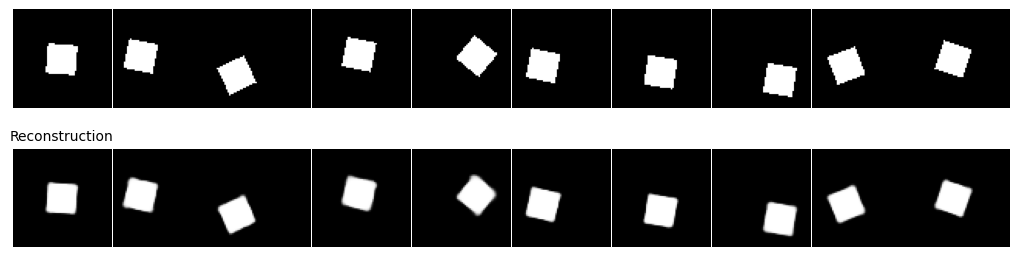

Plotting reconstructions from specific indices...


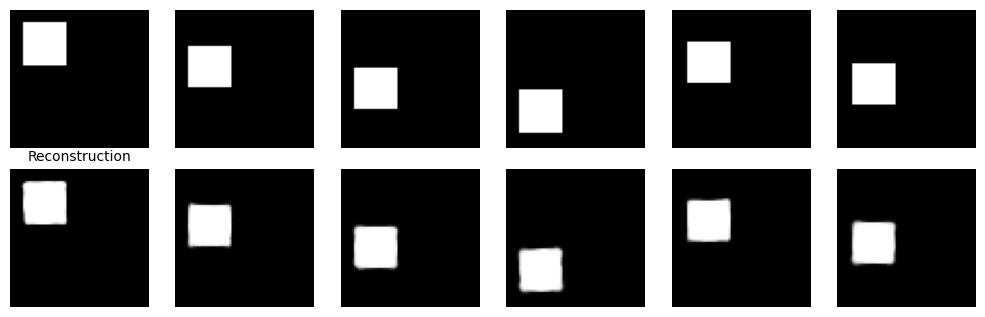

In [11]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


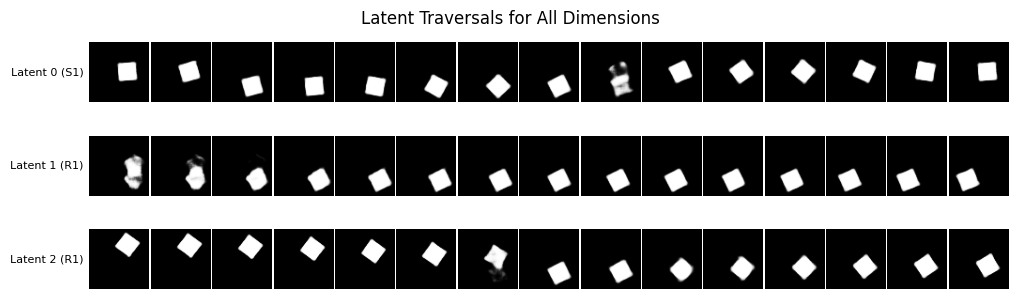

In [12]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0,
                                               use_ref_img=True
                                               )
plt.show()

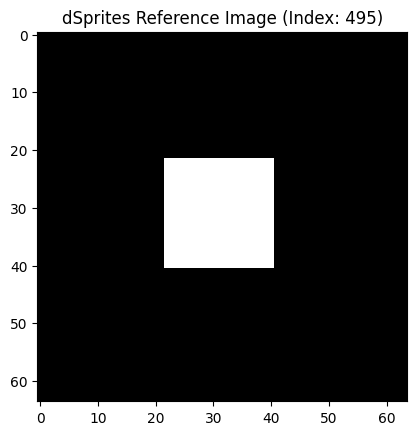

In [13]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

Plotting single latent traversal for dimension 0...


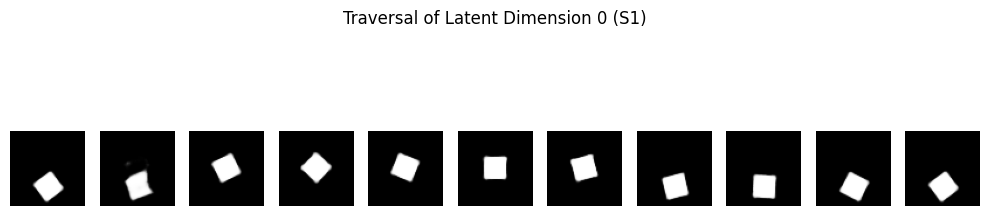

In [14]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=11,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


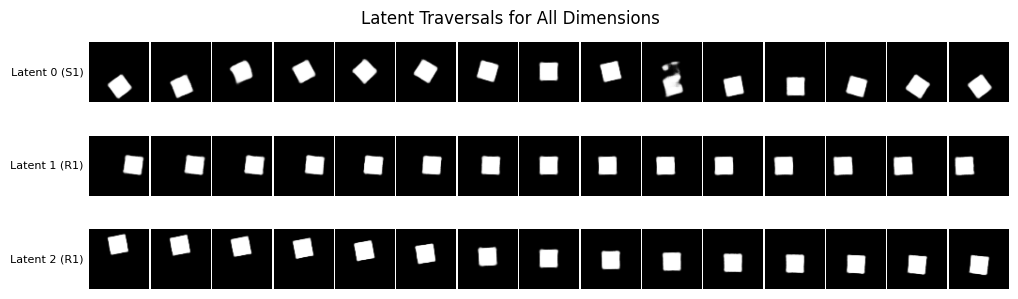

In [15]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )